In [16]:
#!pip install torch torchvision torchaudio gymnasium pandas numpy matplotlib tqdm mpmath==1.2.1

In [17]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


In [18]:
data = pd.read_csv("train_data.csv")

# Drop timestamp or non-numeric columns if they exist
if 'timestamp' in data.columns:
    data = data.drop(columns=['timestamp'])

# Ensure numeric and fill missing values
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)

print("Shape:", data.shape)
data.head()


Shape: (1400, 31)


,location_id,traffic_volume,avg_vehicle_speed,vehicle_count_cars,vehicle_count_trucks,vehicle_count_bikes,weather_condition,temperature,humidity,accident_reported,...,bike_ratio,weather_impact,weather_Cloudy,weather_Foggy,weather_Rainy,weather_Sunny,weather_Windy,signal_Green,signal_Red,signal_Yellow
0,1.00,0.902954,0.800401,0.098976,0.545455,1.000000,0.0,0.979439,0.537649,0,...,0.342553,0.652536,True,False,False,False,False,False,False,True
1,0.75,0.161392,0.319762,0.440273,0.424242,0.775510,0.0,0.884096,0.048955,0,...,0.114553,0.265677,False,False,False,True,False,False,True,False
2,0.00,0.875527,0.599970,0.240046,0.181818,0.489796,0.0,0.132513,0.284103,0,...,0.129062,0.112905,False,False,False,False,True,False,True,False
3,0.50,0.952532,0.408853,0.609784,0.373737,0.857143,0.0,0.941542,0.890744,0,...,0.097102,0.883883,False,False,True,False,False,False,False,True
4,0.00,0.181435,0.544669,0.489192,0.868687,0.836735,0.0,0.472614,0.465641,0,...,0.104318,0.339227,False,False,False,False,True,False,True,False


In [19]:
class TrafficEnv(gym.Env):
    def __init__(self, data):
        super(TrafficEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.max_index = len(data) - 1

        # Define spaces
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(len(data.columns)-1,), dtype=np.float32)
        self.action_space = spaces.Discrete(4)  # 4 signal phases

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Start from a random point in dataset
        self.current_step = np.random.randint(0, self.max_index - 50)
        obs = self.data.iloc[self.current_step, :-1].values.astype(np.float32)
        info = {}
        return obs, info

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_index

        row = self.data.iloc[self.current_step]
        wait_time = row.get('waiting_time', 0)
        queue_len = row.get('queue_length', 0)
        emergency = row.get('emergency_detected', 0) if 'emergency_detected' in row else 0

        reward = self.compute_reward(wait_time, queue_len, emergency, action)
        next_obs = row[:-1].values.astype(np.float32)
        truncated = False
        info = {}

        return next_obs, reward, done, truncated, info

    def compute_reward(self, wait_time, queue_len, emergency_detected, action):
        reward = - (0.7 * wait_time + 0.3 * queue_len)
        if emergency_detected and action == 0:  # example: NS-green helps emergency
            reward += 20
        return reward

    def render(self):
        pass


In [20]:
'''def compute_reward(wait_time, queue_len, emergency_detected):

    reward = - (0.7 * wait_time + 0.3 * queue_len)
    if emergency_detected:
        reward += 20  # positive reward for prioritizing emergency
    return reward'''


'def compute_reward(wait_time, queue_len, emergency_detected):\n\n    reward = - (0.7 * wait_time + 0.3 * queue_len)\n    if emergency_detected:\n        reward += 20  # positive reward for prioritizing emergency\n    return reward'

In [21]:
class PPOAgent(nn.Module):
    def __init__(self, state_dim, action_dim, lr=3e-4):
        super(PPOAgent, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def act(self, state):
        state = torch.FloatTensor(state)
        probs = self.actor(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def evaluate(self, state, action):
        probs = self.actor(state)
        dist = torch.distributions.Categorical(probs)
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return log_prob, self.critic(state), entropy


In [22]:
env = TrafficEnv(data)
agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)


import torch
import json
import os
from tqdm import tqdm

def train_ppo(
    episodes=200,
    gamma=0.99,
    clip_epsilon=0.2,
    save_path="ppo_traffic_model_latest.pt",
    rewards_path="reward_log.json"
):
    reward_history = []

    # Resume from saved rewards if file exists
    if os.path.exists(rewards_path):
        with open(rewards_path, "r") as f:
            reward_history = json.load(f)
        print(f"Loaded {len(reward_history)} previous rewards from '{rewards_path}'")

    # Continue training for new episodes
    for episode in tqdm(range(len(reward_history), len(reward_history) + episodes)):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, log_prob = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)

            # PPO update
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            value = agent.critic(state_tensor)
            next_value = agent.critic(next_state_tensor)
            advantage = reward_tensor + gamma * next_value - value

            new_log_prob, _, entropy = agent.evaluate(
                state_tensor, torch.tensor([action], dtype=torch.long)
            )

            ratio = (new_log_prob - log_prob).exp()
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantage.detach()
            loss = -torch.min(surr1, surr2) + 0.5 * advantage.pow(2) - 0.01 * entropy

            agent.optimizer.zero_grad()
            loss.mean().backward()
            agent.optimizer.step()

            total_reward += reward
            state = next_state

        reward_history.append(total_reward)
        print(f"Episode {episode + 1} | Total Reward: {total_reward:.2f}")

        # Save model & rewards every 10 episodes
        if (episode + 1) % 10 == 0:
            torch.save(agent.state_dict(), save_path)
            with open(rewards_path, "w") as f:
                json.dump(reward_history, f)
            print(f"💾 Progress saved — {episode + 1} episodes complete")

    print("Training complete!")
    torch.save(agent.state_dict(), save_path)
    with open(rewards_path, "w") as f:
        json.dump(reward_history, f)

    return reward_history


rewards = train_ppo(episodes=500)


  0%|          | 1/500 [00:03<25:01,  3.01s/it]

Episode 1 | Total Reward: -93.36


  0%|          | 2/500 [00:05<21:01,  2.53s/it]

Episode 2 | Total Reward: -69.01


  1%|          | 3/500 [00:06<17:06,  2.06s/it]

Episode 3 | Total Reward: -47.43


  1%|          | 4/500 [00:07<12:05,  1.46s/it]

Episode 4 | Total Reward: -16.41


  1%|          | 5/500 [00:10<16:42,  2.03s/it]

Episode 5 | Total Reward: -98.31


  1%|          | 6/500 [00:12<16:38,  2.02s/it]

Episode 6 | Total Reward: -63.47


  1%|▏         | 7/500 [00:14<17:43,  2.16s/it]

Episode 7 | Total Reward: -76.52


  2%|▏         | 8/500 [00:16<16:51,  2.06s/it]

Episode 8 | Total Reward: -58.30


  2%|▏         | 9/500 [00:17<13:09,  1.61s/it]

Episode 9 | Total Reward: -19.41


  2%|▏         | 10/500 [00:17<11:05,  1.36s/it]

Episode 10 | Total Reward: -25.51
💾 Progress saved — 10 episodes complete


  2%|▏         | 11/500 [00:20<13:22,  1.64s/it]

Episode 11 | Total Reward: -72.92


  2%|▏         | 12/500 [00:21<12:16,  1.51s/it]

Episode 12 | Total Reward: -38.12


  3%|▎         | 13/500 [00:24<15:45,  1.94s/it]

Episode 13 | Total Reward: -93.83


  3%|▎         | 14/500 [00:26<16:53,  2.09s/it]

Episode 14 | Total Reward: -77.05


  3%|▎         | 15/500 [00:28<16:09,  2.00s/it]

Episode 15 | Total Reward: -56.10


  3%|▎         | 16/500 [00:31<18:19,  2.27s/it]

Episode 16 | Total Reward: -93.36


  3%|▎         | 17/500 [00:31<13:25,  1.67s/it]

Episode 17 | Total Reward: -9.24


  4%|▎         | 18/500 [00:32<10:38,  1.32s/it]

Episode 18 | Total Reward: -17.19


  4%|▍         | 19/500 [00:34<11:43,  1.46s/it]

Episode 19 | Total Reward: -55.00


  4%|▍         | 20/500 [00:35<11:37,  1.45s/it]

Episode 20 | Total Reward: -45.60
💾 Progress saved — 20 episodes complete


  4%|▍         | 21/500 [00:36<10:11,  1.28s/it]

Episode 21 | Total Reward: -27.39


  4%|▍         | 22/500 [00:37<09:35,  1.20s/it]

Episode 22 | Total Reward: -32.52


  5%|▍         | 23/500 [00:38<08:39,  1.09s/it]

Episode 23 | Total Reward: -25.90


  5%|▍         | 24/500 [00:38<07:01,  1.13it/s]

Episode 24 | Total Reward: -13.63


  5%|▌         | 25/500 [00:40<10:08,  1.28s/it]

Episode 25 | Total Reward: -71.22


  5%|▌         | 26/500 [00:41<08:16,  1.05s/it]

Episode 26 | Total Reward: -16.41


  5%|▌         | 27/500 [00:42<07:34,  1.04it/s]

Episode 27 | Total Reward: -23.06


  6%|▌         | 28/500 [00:45<12:21,  1.57s/it]

Episode 28 | Total Reward: -97.08


  6%|▌         | 29/500 [00:47<14:54,  1.90s/it]

Episode 29 | Total Reward: -84.46


  6%|▌         | 30/500 [00:49<14:41,  1.88s/it]

Episode 30 | Total Reward: -58.06
💾 Progress saved — 30 episodes complete


  6%|▌         | 31/500 [00:50<13:00,  1.66s/it]

Episode 31 | Total Reward: -37.12


  6%|▋         | 32/500 [00:52<13:40,  1.75s/it]

Episode 32 | Total Reward: -61.65


  7%|▋         | 33/500 [00:53<10:14,  1.32s/it]

Episode 33 | Total Reward: -9.80


  7%|▋         | 34/500 [00:54<10:31,  1.36s/it]

Episode 34 | Total Reward: -44.86


  7%|▋         | 35/500 [00:56<11:19,  1.46s/it]

Episode 35 | Total Reward: -53.50


  7%|▋         | 36/500 [00:56<08:51,  1.15s/it]

Episode 36 | Total Reward: -13.21


  7%|▋         | 37/500 [00:58<09:55,  1.29s/it]

Episode 37 | Total Reward: -49.63


  8%|▊         | 38/500 [01:00<11:38,  1.51s/it]

Episode 38 | Total Reward: -65.70


  8%|▊         | 39/500 [01:02<14:21,  1.87s/it]

Episode 39 | Total Reward: -86.29


  8%|▊         | 40/500 [01:04<12:51,  1.68s/it]

Episode 40 | Total Reward: -38.42
💾 Progress saved — 40 episodes complete


  8%|▊         | 41/500 [01:06<14:39,  1.92s/it]

Episode 41 | Total Reward: -78.33


  8%|▊         | 42/500 [01:07<11:42,  1.53s/it]

Episode 42 | Total Reward: -20.33


  9%|▊         | 43/500 [01:09<12:47,  1.68s/it]

Episode 43 | Total Reward: -63.58


  9%|▉         | 44/500 [01:12<15:25,  2.03s/it]

Episode 44 | Total Reward: -92.59


  9%|▉         | 45/500 [01:13<14:19,  1.89s/it]

Episode 45 | Total Reward: -49.22


  9%|▉         | 46/500 [01:16<16:13,  2.14s/it]

Episode 46 | Total Reward: -86.73


  9%|▉         | 47/500 [01:18<16:45,  2.22s/it]

Episode 47 | Total Reward: -76.52


 10%|▉         | 48/500 [01:19<13:07,  1.74s/it]

Episode 48 | Total Reward: -19.79


 10%|▉         | 49/500 [01:20<11:38,  1.55s/it]

Episode 49 | Total Reward: -34.16


 10%|█         | 50/500 [01:21<10:20,  1.38s/it]

Episode 50 | Total Reward: -30.75
💾 Progress saved — 50 episodes complete


 10%|█         | 51/500 [01:24<12:49,  1.71s/it]

Episode 51 | Total Reward: -80.55


 10%|█         | 52/500 [01:24<09:59,  1.34s/it]

Episode 52 | Total Reward: -15.12


 11%|█         | 53/500 [01:27<13:22,  1.79s/it]

Episode 53 | Total Reward: -90.56


 11%|█         | 54/500 [01:29<14:36,  1.97s/it]

Episode 54 | Total Reward: -75.86


 11%|█         | 55/500 [01:30<12:18,  1.66s/it]

Episode 55 | Total Reward: -29.18


 11%|█         | 56/500 [01:32<12:35,  1.70s/it]

Episode 56 | Total Reward: -56.14


 11%|█▏        | 57/500 [01:34<12:47,  1.73s/it]

Episode 57 | Total Reward: -57.15


 12%|█▏        | 58/500 [01:35<11:30,  1.56s/it]

Episode 58 | Total Reward: -35.61


 12%|█▏        | 59/500 [01:37<11:26,  1.56s/it]

Episode 59 | Total Reward: -47.49


 12%|█▏        | 60/500 [01:37<09:13,  1.26s/it]

Episode 60 | Total Reward: -17.49
💾 Progress saved — 60 episodes complete


 12%|█▏        | 61/500 [01:38<08:17,  1.13s/it]

Episode 61 | Total Reward: -26.68


 12%|█▏        | 62/500 [01:38<07:00,  1.04it/s]

Episode 62 | Total Reward: -18.23


 13%|█▎        | 63/500 [01:40<08:02,  1.11s/it]

Episode 63 | Total Reward: -45.68


 13%|█▎        | 64/500 [01:43<11:14,  1.55s/it]

Episode 64 | Total Reward: -82.22


 13%|█▎        | 65/500 [01:44<11:35,  1.60s/it]

Episode 65 | Total Reward: -52.56


 13%|█▎        | 66/500 [01:46<11:27,  1.58s/it]

Episode 66 | Total Reward: -47.74


 13%|█▎        | 67/500 [01:49<14:29,  2.01s/it]

Episode 67 | Total Reward: -96.49


 14%|█▎        | 68/500 [01:51<15:25,  2.14s/it]

Episode 68 | Total Reward: -77.92


 14%|█▍        | 69/500 [01:52<12:14,  1.70s/it]

Episode 69 | Total Reward: -21.41


 14%|█▍        | 70/500 [01:55<14:17,  1.99s/it]

Episode 70 | Total Reward: -84.86
💾 Progress saved — 70 episodes complete


 14%|█▍        | 71/500 [01:56<12:41,  1.77s/it]

Episode 71 | Total Reward: -38.99


 14%|█▍        | 72/500 [01:59<14:41,  2.06s/it]

Episode 72 | Total Reward: -86.73


 15%|█▍        | 73/500 [02:00<12:52,  1.81s/it]

Episode 73 | Total Reward: -39.17


 15%|█▍        | 74/500 [02:01<11:16,  1.59s/it]

Episode 74 | Total Reward: -33.65


 15%|█▌        | 75/500 [02:02<11:17,  1.59s/it]

Episode 75 | Total Reward: -49.38


 15%|█▌        | 76/500 [02:03<09:20,  1.32s/it]

Episode 76 | Total Reward: -20.69


 15%|█▌        | 77/500 [02:05<09:40,  1.37s/it]

Episode 77 | Total Reward: -46.66


 16%|█▌        | 78/500 [02:07<10:52,  1.55s/it]

Episode 78 | Total Reward: -60.85


 16%|█▌        | 79/500 [02:08<10:48,  1.54s/it]

Episode 79 | Total Reward: -46.95


 16%|█▌        | 80/500 [02:09<09:37,  1.38s/it]

Episode 80 | Total Reward: -30.52
💾 Progress saved — 80 episodes complete


 16%|█▌        | 81/500 [02:12<12:57,  1.86s/it]

Episode 81 | Total Reward: -96.82


 16%|█▋        | 82/500 [02:14<12:22,  1.78s/it]

Episode 82 | Total Reward: -49.57


 17%|█▋        | 83/500 [02:14<10:09,  1.46s/it]

Episode 83 | Total Reward: -21.52


 17%|█▋        | 84/500 [02:15<08:46,  1.27s/it]

Episode 84 | Total Reward: -24.79


 17%|█▋        | 85/500 [02:17<08:46,  1.27s/it]

Episode 85 | Total Reward: -40.21


 17%|█▋        | 86/500 [02:19<10:33,  1.53s/it]

Episode 86 | Total Reward: -67.56


 17%|█▋        | 87/500 [02:20<10:44,  1.56s/it]

Episode 87 | Total Reward: -49.88


 18%|█▊        | 88/500 [02:22<11:07,  1.62s/it]

Episode 88 | Total Reward: -51.96


 18%|█▊        | 89/500 [02:25<13:47,  2.01s/it]

Episode 89 | Total Reward: -90.35


 18%|█▊        | 90/500 [02:26<11:52,  1.74s/it]

Episode 90 | Total Reward: -32.72
💾 Progress saved — 90 episodes complete


 18%|█▊        | 91/500 [02:29<14:34,  2.14s/it]

Episode 91 | Total Reward: -94.87


 18%|█▊        | 92/500 [02:31<14:12,  2.09s/it]

Episode 92 | Total Reward: -57.32


 19%|█▊        | 93/500 [02:32<10:56,  1.61s/it]

Episode 93 | Total Reward: -15.72


 19%|█▉        | 94/500 [02:34<11:58,  1.77s/it]

Episode 94 | Total Reward: -66.67


 19%|█▉        | 95/500 [02:35<09:56,  1.47s/it]

Episode 95 | Total Reward: -24.60


 19%|█▉        | 96/500 [02:38<13:51,  2.06s/it]

Episode 96 | Total Reward: -90.81


 19%|█▉        | 97/500 [02:41<15:01,  2.24s/it]

Episode 97 | Total Reward: -84.63


 20%|█▉        | 98/500 [02:43<14:57,  2.23s/it]

Episode 98 | Total Reward: -70.08


 20%|█▉        | 99/500 [02:45<14:49,  2.22s/it]

Episode 99 | Total Reward: -70.06


 20%|██        | 100/500 [02:47<13:58,  2.10s/it]

Episode 100 | Total Reward: -55.24
💾 Progress saved — 100 episodes complete


 20%|██        | 101/500 [02:49<14:09,  2.13s/it]

Episode 101 | Total Reward: -69.63


 20%|██        | 102/500 [02:51<14:27,  2.18s/it]

Episode 102 | Total Reward: -73.29


 21%|██        | 104/500 [02:54<10:11,  1.54s/it]

Episode 103 | Total Reward: -66.17
Episode 104 | Total Reward: -4.18


 21%|██        | 105/500 [02:55<10:09,  1.54s/it]

Episode 105 | Total Reward: -47.67


 21%|██        | 106/500 [02:55<07:37,  1.16s/it]

Episode 106 | Total Reward: -9.46


 21%|██▏       | 107/500 [02:57<07:58,  1.22s/it]

Episode 107 | Total Reward: -41.48


 22%|██▏       | 108/500 [02:59<09:09,  1.40s/it]

Episode 108 | Total Reward: -56.96


 22%|██▏       | 109/500 [03:00<08:20,  1.28s/it]

Episode 109 | Total Reward: -30.86


 22%|██▏       | 110/500 [03:02<10:56,  1.68s/it]

Episode 110 | Total Reward: -83.75
💾 Progress saved — 110 episodes complete


 22%|██▏       | 111/500 [03:05<12:35,  1.94s/it]

Episode 111 | Total Reward: -80.30


 22%|██▏       | 112/500 [03:08<14:51,  2.30s/it]

Episode 112 | Total Reward: -99.74


 23%|██▎       | 113/500 [03:08<11:23,  1.77s/it]

Episode 113 | Total Reward: -17.17


 23%|██▎       | 114/500 [03:09<09:12,  1.43s/it]

Episode 114 | Total Reward: -19.48


 23%|██▎       | 115/500 [03:10<07:48,  1.22s/it]

Episode 115 | Total Reward: -22.36


 23%|██▎       | 116/500 [03:12<08:58,  1.40s/it]

Episode 116 | Total Reward: -58.07


 23%|██▎       | 117/500 [03:13<09:56,  1.56s/it]

Episode 117 | Total Reward: -60.36


 24%|██▎       | 118/500 [03:14<08:04,  1.27s/it]

Episode 118 | Total Reward: -17.55


 24%|██▍       | 119/500 [03:17<11:10,  1.76s/it]

Episode 119 | Total Reward: -92.66


 24%|██▍       | 120/500 [03:17<08:17,  1.31s/it]

Episode 120 | Total Reward: -8.59
💾 Progress saved — 120 episodes complete


 24%|██▍       | 121/500 [03:20<11:05,  1.75s/it]

Episode 121 | Total Reward: -88.74


 24%|██▍       | 122/500 [03:22<11:27,  1.82s/it]

Episode 122 | Total Reward: -62.36


 25%|██▍       | 123/500 [03:25<13:10,  2.10s/it]

Episode 123 | Total Reward: -87.83


 25%|██▍       | 124/500 [03:25<09:57,  1.59s/it]

Episode 124 | Total Reward: -12.91


 25%|██▌       | 125/500 [03:26<08:45,  1.40s/it]

Episode 125 | Total Reward: -29.51


 25%|██▌       | 126/500 [03:27<08:32,  1.37s/it]

Episode 126 | Total Reward: -39.80


 25%|██▌       | 127/500 [03:30<10:56,  1.76s/it]

Episode 127 | Total Reward: -84.65


 26%|██▌       | 128/500 [03:31<09:00,  1.45s/it]

Episode 128 | Total Reward: -22.70


 26%|██▌       | 129/500 [03:34<11:41,  1.89s/it]

Episode 129 | Total Reward: -93.75


 26%|██▌       | 130/500 [03:37<13:38,  2.21s/it]

Episode 130 | Total Reward: -93.75
💾 Progress saved — 130 episodes complete


 26%|██▌       | 131/500 [03:39<14:18,  2.33s/it]

Episode 131 | Total Reward: -83.07


 26%|██▋       | 132/500 [03:42<15:51,  2.59s/it]

Episode 132 | Total Reward: -101.25


 27%|██▋       | 133/500 [03:44<13:56,  2.28s/it]

Episode 133 | Total Reward: -49.11


 27%|██▋       | 134/500 [03:45<12:16,  2.01s/it]

Episode 134 | Total Reward: -43.82


 27%|██▋       | 135/500 [03:46<10:09,  1.67s/it]

Episode 135 | Total Reward: -27.12


 27%|██▋       | 136/500 [03:48<09:30,  1.57s/it]

Episode 136 | Total Reward: -40.08


 27%|██▋       | 137/500 [03:50<11:37,  1.92s/it]

Episode 137 | Total Reward: -87.55


 28%|██▊       | 138/500 [03:53<13:30,  2.24s/it]

Episode 138 | Total Reward: -95.98


 28%|██▊       | 139/500 [03:56<13:20,  2.22s/it]

Episode 139 | Total Reward: -69.57


 28%|██▊       | 140/500 [03:59<14:55,  2.49s/it]

Episode 140 | Total Reward: -98.18
💾 Progress saved — 140 episodes complete


 28%|██▊       | 141/500 [04:01<13:54,  2.32s/it]

Episode 141 | Total Reward: -61.31


 28%|██▊       | 142/500 [04:01<10:12,  1.71s/it]

Episode 142 | Total Reward: -9.65


 29%|██▊       | 143/500 [04:03<10:19,  1.74s/it]

Episode 143 | Total Reward: -55.06


 29%|██▉       | 144/500 [04:03<07:45,  1.31s/it]

Episode 144 | Total Reward: -9.98


 29%|██▉       | 145/500 [04:05<08:26,  1.43s/it]

Episode 145 | Total Reward: -52.18


 29%|██▉       | 146/500 [04:07<09:16,  1.57s/it]

Episode 146 | Total Reward: -60.85


 29%|██▉       | 147/500 [04:09<11:21,  1.93s/it]

Episode 147 | Total Reward: -87.14


 30%|██▉       | 148/500 [04:11<11:15,  1.92s/it]

Episode 148 | Total Reward: -59.79


 30%|██▉       | 149/500 [04:13<11:11,  1.91s/it]

Episode 149 | Total Reward: -59.47


 30%|███       | 150/500 [04:15<11:15,  1.93s/it]

Episode 150 | Total Reward: -60.24
💾 Progress saved — 150 episodes complete


 30%|███       | 151/500 [04:16<08:57,  1.54s/it]

Episode 151 | Total Reward: -19.79


 30%|███       | 152/500 [04:16<07:25,  1.28s/it]

Episode 152 | Total Reward: -20.94


 31%|███       | 153/500 [04:19<10:32,  1.82s/it]

Episode 153 | Total Reward: -98.01


 31%|███       | 154/500 [04:22<11:45,  2.04s/it]

Episode 154 | Total Reward: -78.86


 31%|███       | 155/500 [04:24<11:45,  2.04s/it]

Episode 155 | Total Reward: -65.18


 31%|███       | 156/500 [04:25<09:36,  1.68s/it]

Episode 156 | Total Reward: -25.47


 32%|███▏      | 158/500 [04:27<07:14,  1.27s/it]

Episode 157 | Total Reward: -56.96
Episode 158 | Total Reward: -5.60


 32%|███▏      | 159/500 [04:29<08:37,  1.52s/it]

Episode 159 | Total Reward: -65.24


 32%|███▏      | 160/500 [04:29<06:43,  1.19s/it]

Episode 160 | Total Reward: -13.90
💾 Progress saved — 160 episodes complete


 32%|███▏      | 161/500 [04:32<08:57,  1.59s/it]

Episode 161 | Total Reward: -79.42


 32%|███▏      | 162/500 [04:34<09:56,  1.77s/it]

Episode 162 | Total Reward: -69.78


 33%|███▎      | 163/500 [04:34<07:17,  1.30s/it]

Episode 163 | Total Reward: -7.59


 33%|███▎      | 164/500 [04:36<08:15,  1.47s/it]

Episode 164 | Total Reward: -57.47


 33%|███▎      | 165/500 [04:39<09:32,  1.71s/it]

Episode 165 | Total Reward: -69.75


 33%|███▎      | 166/500 [04:39<07:17,  1.31s/it]

Episode 166 | Total Reward: -11.70


 33%|███▎      | 167/500 [04:41<09:08,  1.65s/it]

Episode 167 | Total Reward: -72.35


 34%|███▎      | 168/500 [04:44<11:22,  2.06s/it]

Episode 168 | Total Reward: -92.58


 34%|███▍      | 169/500 [04:46<10:39,  1.93s/it]

Episode 169 | Total Reward: -48.63


 34%|███▍      | 170/500 [04:48<10:25,  1.89s/it]

Episode 170 | Total Reward: -51.47
💾 Progress saved — 170 episodes complete


 34%|███▍      | 171/500 [04:50<11:15,  2.05s/it]

Episode 171 | Total Reward: -72.92


 34%|███▍      | 172/500 [04:52<10:19,  1.89s/it]

Episode 172 | Total Reward: -46.13


 35%|███▍      | 173/500 [04:55<12:59,  2.38s/it]

Episode 173 | Total Reward: -97.10


 35%|███▍      | 174/500 [04:58<13:58,  2.57s/it]

Episode 174 | Total Reward: -94.06


 35%|███▌      | 175/500 [05:00<13:07,  2.42s/it]

Episode 175 | Total Reward: -66.17


 35%|███▌      | 176/500 [05:02<11:16,  2.09s/it]

Episode 176 | Total Reward: -41.11


 35%|███▌      | 177/500 [05:03<10:19,  1.92s/it]

Episode 177 | Total Reward: -46.74


 36%|███▌      | 178/500 [05:04<09:08,  1.70s/it]

Episode 178 | Total Reward: -37.59


 36%|███▌      | 179/500 [05:05<07:36,  1.42s/it]

Episode 179 | Total Reward: -23.72


 36%|███▌      | 180/500 [05:06<06:19,  1.19s/it]

Episode 180 | Total Reward: -20.08
💾 Progress saved — 180 episodes complete


 36%|███▌      | 181/500 [05:09<08:45,  1.65s/it]

Episode 181 | Total Reward: -84.63


 36%|███▋      | 182/500 [05:10<07:52,  1.49s/it]

Episode 182 | Total Reward: -34.53


 37%|███▋      | 183/500 [05:10<05:49,  1.10s/it]

Episode 183 | Total Reward: -7.22


 37%|███▋      | 184/500 [05:13<08:29,  1.61s/it]

Episode 184 | Total Reward: -89.85


 37%|███▋      | 185/500 [05:13<06:48,  1.30s/it]

Episode 185 | Total Reward: -17.56


 37%|███▋      | 186/500 [05:14<06:38,  1.27s/it]

Episode 186 | Total Reward: -37.20


 37%|███▋      | 187/500 [05:17<08:43,  1.67s/it]

Episode 187 | Total Reward: -83.36


 38%|███▊      | 188/500 [05:17<06:46,  1.30s/it]

Episode 188 | Total Reward: -14.36


 38%|███▊      | 189/500 [05:20<08:48,  1.70s/it]

Episode 189 | Total Reward: -77.44


 38%|███▊      | 190/500 [05:21<07:15,  1.40s/it]

Episode 190 | Total Reward: -21.22
💾 Progress saved — 190 episodes complete


 38%|███▊      | 191/500 [05:22<06:29,  1.26s/it]

Episode 191 | Total Reward: -28.83


 38%|███▊      | 192/500 [05:22<05:08,  1.00s/it]

Episode 192 | Total Reward: -12.74


 39%|███▊      | 193/500 [05:24<06:28,  1.27s/it]

Episode 193 | Total Reward: -59.23


 39%|███▉      | 194/500 [05:25<06:29,  1.27s/it]

Episode 194 | Total Reward: -40.21


 39%|███▉      | 195/500 [05:26<06:11,  1.22s/it]

Episode 195 | Total Reward: -33.17


 39%|███▉      | 196/500 [05:28<06:34,  1.30s/it]

Episode 196 | Total Reward: -46.32


 39%|███▉      | 197/500 [05:30<08:13,  1.63s/it]

Episode 197 | Total Reward: -76.01


 40%|███▉      | 198/500 [05:33<09:42,  1.93s/it]

Episode 198 | Total Reward: -82.97


 40%|███▉      | 199/500 [05:34<07:44,  1.54s/it]

Episode 199 | Total Reward: -20.57


 40%|████      | 200/500 [05:36<08:48,  1.76s/it]

Episode 200 | Total Reward: -72.01
💾 Progress saved — 200 episodes complete


 40%|████      | 201/500 [05:38<09:31,  1.91s/it]

Episode 201 | Total Reward: -70.58


 40%|████      | 202/500 [05:39<07:52,  1.58s/it]

Episode 202 | Total Reward: -25.31


 41%|████      | 204/500 [05:41<06:07,  1.24s/it]

Episode 203 | Total Reward: -63.50
Episode 204 | Total Reward: -4.75


 41%|████      | 205/500 [05:42<06:16,  1.28s/it]

Episode 205 | Total Reward: -42.52


 41%|████      | 206/500 [05:43<04:45,  1.03it/s]

Episode 206 | Total Reward: -9.00


 41%|████▏     | 207/500 [05:43<03:54,  1.25it/s]

Episode 207 | Total Reward: -12.91


 42%|████▏     | 208/500 [05:43<03:07,  1.56it/s]

Episode 208 | Total Reward: -9.37


 42%|████▏     | 209/500 [05:45<04:41,  1.03it/s]

Episode 209 | Total Reward: -53.76


 42%|████▏     | 210/500 [05:46<04:05,  1.18it/s]

Episode 210 | Total Reward: -17.53
💾 Progress saved — 210 episodes complete


 42%|████▏     | 211/500 [05:46<04:04,  1.18it/s]

Episode 211 | Total Reward: -26.79


 42%|████▏     | 212/500 [05:47<04:14,  1.13it/s]

Episode 212 | Total Reward: -29.26


 43%|████▎     | 213/500 [05:50<06:51,  1.44s/it]

Episode 213 | Total Reward: -86.47


 43%|████▎     | 214/500 [05:51<05:40,  1.19s/it]

Episode 214 | Total Reward: -18.98


 43%|████▎     | 215/500 [05:52<05:17,  1.12s/it]

Episode 215 | Total Reward: -28.97


 43%|████▎     | 216/500 [05:53<06:05,  1.29s/it]

Episode 216 | Total Reward: -51.35


 43%|████▎     | 217/500 [05:56<07:40,  1.63s/it]

Episode 217 | Total Reward: -77.44


 44%|████▎     | 218/500 [05:57<07:16,  1.55s/it]

Episode 218 | Total Reward: -43.03


 44%|████▍     | 219/500 [05:58<06:19,  1.35s/it]

Episode 219 | Total Reward: -27.13


 44%|████▍     | 220/500 [05:58<04:58,  1.07s/it]

Episode 220 | Total Reward: -12.74
💾 Progress saved — 220 episodes complete


 44%|████▍     | 221/500 [05:59<04:17,  1.08it/s]

Episode 221 | Total Reward: -17.55


 44%|████▍     | 222/500 [05:59<03:34,  1.29it/s]

Episode 222 | Total Reward: -13.63


 45%|████▍     | 223/500 [06:01<04:42,  1.02s/it]

Episode 223 | Total Reward: -48.63


 45%|████▍     | 224/500 [06:02<04:23,  1.05it/s]

Episode 224 | Total Reward: -24.83


 45%|████▌     | 225/500 [06:04<06:28,  1.41s/it]

Episode 225 | Total Reward: -78.31


 45%|████▌     | 226/500 [06:05<05:14,  1.15s/it]

Episode 226 | Total Reward: -16.55


 45%|████▌     | 227/500 [06:07<05:58,  1.31s/it]

Episode 227 | Total Reward: -52.02


 46%|████▌     | 228/500 [06:08<05:37,  1.24s/it]

Episode 228 | Total Reward: -33.71


 46%|████▌     | 229/500 [06:08<04:21,  1.04it/s]

Episode 229 | Total Reward: -10.53


 46%|████▌     | 230/500 [06:10<05:39,  1.26s/it]

Episode 230 | Total Reward: -59.23
💾 Progress saved — 230 episodes complete


 46%|████▌     | 231/500 [06:12<06:35,  1.47s/it]

Episode 231 | Total Reward: -61.65


 46%|████▋     | 232/500 [06:12<05:22,  1.20s/it]

Episode 232 | Total Reward: -18.56


 47%|████▋     | 233/500 [06:14<05:29,  1.23s/it]

Episode 233 | Total Reward: -40.23


 47%|████▋     | 234/500 [06:15<05:11,  1.17s/it]

Episode 234 | Total Reward: -31.48


 47%|████▋     | 235/500 [06:17<07:05,  1.61s/it]

Episode 235 | Total Reward: -83.60


 47%|████▋     | 236/500 [06:20<08:52,  2.02s/it]

Episode 236 | Total Reward: -94.12


 47%|████▋     | 237/500 [06:22<08:01,  1.83s/it]

Episode 237 | Total Reward: -43.10


 48%|████▊     | 238/500 [06:23<07:22,  1.69s/it]

Episode 238 | Total Reward: -42.50


 48%|████▊     | 239/500 [06:25<07:10,  1.65s/it]

Episode 239 | Total Reward: -48.63


 48%|████▊     | 240/500 [06:25<06:00,  1.38s/it]

Episode 240 | Total Reward: -23.39
💾 Progress saved — 240 episodes complete


 48%|████▊     | 241/500 [06:26<04:55,  1.14s/it]

Episode 241 | Total Reward: -17.49


 48%|████▊     | 242/500 [06:29<06:55,  1.61s/it]

Episode 242 | Total Reward: -87.14


 49%|████▊     | 243/500 [06:32<08:46,  2.05s/it]

Episode 243 | Total Reward: -97.10


 49%|████▉     | 244/500 [06:33<08:13,  1.93s/it]

Episode 244 | Total Reward: -50.70


 49%|████▉     | 245/500 [06:36<09:10,  2.16s/it]

Episode 245 | Total Reward: -86.21


 49%|████▉     | 246/500 [06:37<07:44,  1.83s/it]

Episode 246 | Total Reward: -32.61


 49%|████▉     | 247/500 [06:38<06:34,  1.56s/it]

Episode 247 | Total Reward: -28.97


 50%|████▉     | 248/500 [06:40<07:30,  1.79s/it]

Episode 248 | Total Reward: -72.40


 50%|████▉     | 249/500 [06:41<05:44,  1.37s/it]

Episode 249 | Total Reward: -13.22


 50%|█████     | 250/500 [06:42<05:48,  1.39s/it]

Episode 250 | Total Reward: -44.11
💾 Progress saved — 250 episodes complete


 50%|█████     | 251/500 [06:45<06:57,  1.68s/it]

Episode 251 | Total Reward: -74.84


 50%|█████     | 252/500 [06:45<05:22,  1.30s/it]

Episode 252 | Total Reward: -13.63


 51%|█████     | 253/500 [06:48<07:27,  1.81s/it]

Episode 253 | Total Reward: -96.17


 51%|█████     | 254/500 [06:50<07:14,  1.77s/it]

Episode 254 | Total Reward: -50.70


 51%|█████     | 255/500 [06:50<05:45,  1.41s/it]

Episode 255 | Total Reward: -18.40


 51%|█████     | 256/500 [06:51<04:54,  1.21s/it]

Episode 256 | Total Reward: -22.48


 51%|█████▏    | 257/500 [06:52<04:06,  1.01s/it]

Episode 257 | Total Reward: -17.56


 52%|█████▏    | 258/500 [06:54<05:27,  1.35s/it]

Episode 258 | Total Reward: -67.44


 52%|█████▏    | 259/500 [06:55<04:41,  1.17s/it]

Episode 259 | Total Reward: -23.72


 52%|█████▏    | 260/500 [06:56<05:37,  1.41s/it]

Episode 260 | Total Reward: -61.80
💾 Progress saved — 260 episodes complete


 52%|█████▏    | 261/500 [06:58<05:13,  1.31s/it]

Episode 261 | Total Reward: -34.53


 52%|█████▏    | 262/500 [06:59<05:17,  1.33s/it]

Episode 262 | Total Reward: -42.41


 53%|█████▎    | 263/500 [07:01<06:32,  1.66s/it]

Episode 263 | Total Reward: -76.44


 53%|█████▎    | 264/500 [07:04<07:05,  1.80s/it]

Episode 264 | Total Reward: -67.46


 53%|█████▎    | 265/500 [07:06<07:49,  2.00s/it]

Episode 265 | Total Reward: -78.58


 53%|█████▎    | 266/500 [07:08<08:21,  2.14s/it]

Episode 266 | Total Reward: -78.96


 53%|█████▎    | 267/500 [07:09<06:48,  1.75s/it]

Episode 267 | Total Reward: -26.29


 54%|█████▎    | 268/500 [07:10<05:37,  1.46s/it]

Episode 268 | Total Reward: -23.25


 54%|█████▍    | 269/500 [07:12<06:30,  1.69s/it]

Episode 269 | Total Reward: -71.51


 54%|█████▍    | 270/500 [07:15<08:09,  2.13s/it]

Episode 270 | Total Reward: -100.62
💾 Progress saved — 270 episodes complete


 54%|█████▍    | 271/500 [07:18<08:45,  2.29s/it]

Episode 271 | Total Reward: -86.36


 54%|█████▍    | 272/500 [07:21<09:30,  2.50s/it]

Episode 272 | Total Reward: -94.88


 55%|█████▍    | 273/500 [07:24<09:21,  2.48s/it]

Episode 273 | Total Reward: -75.61


 55%|█████▍    | 274/500 [07:26<09:42,  2.58s/it]

Episode 274 | Total Reward: -90.98


 55%|█████▌    | 275/500 [07:28<08:52,  2.37s/it]

Episode 275 | Total Reward: -58.63


 55%|█████▌    | 276/500 [07:29<06:58,  1.87s/it]

Episode 276 | Total Reward: -22.25


 55%|█████▌    | 277/500 [07:30<05:48,  1.56s/it]

Episode 277 | Total Reward: -27.13


 56%|█████▌    | 278/500 [07:32<06:56,  1.88s/it]

Episode 278 | Total Reward: -81.76


 56%|█████▌    | 279/500 [07:35<08:00,  2.17s/it]

Episode 279 | Total Reward: -92.66


 56%|█████▌    | 280/500 [07:38<08:46,  2.39s/it]

Episode 280 | Total Reward: -93.06
💾 Progress saved — 280 episodes complete


 56%|█████▌    | 281/500 [07:40<07:49,  2.14s/it]

Episode 281 | Total Reward: -48.91


 56%|█████▋    | 282/500 [07:42<07:24,  2.04s/it]

Episode 282 | Total Reward: -54.73


 57%|█████▋    | 283/500 [07:43<06:43,  1.86s/it]

Episode 283 | Total Reward: -45.40


 57%|█████▋    | 284/500 [07:43<05:10,  1.44s/it]

Episode 284 | Total Reward: -14.47


 57%|█████▋    | 285/500 [07:46<06:31,  1.82s/it]

Episode 285 | Total Reward: -88.11


 57%|█████▋    | 286/500 [07:48<06:13,  1.75s/it]

Episode 286 | Total Reward: -48.30


 57%|█████▋    | 287/500 [07:49<05:42,  1.61s/it]

Episode 287 | Total Reward: -40.58


 58%|█████▊    | 288/500 [07:50<05:03,  1.43s/it]

Episode 288 | Total Reward: -32.21


 58%|█████▊    | 289/500 [07:51<04:40,  1.33s/it]

Episode 289 | Total Reward: -33.68


 58%|█████▊    | 290/500 [07:54<06:07,  1.75s/it]

Episode 290 | Total Reward: -87.13
💾 Progress saved — 290 episodes complete


 58%|█████▊    | 291/500 [07:56<06:01,  1.73s/it]

Episode 291 | Total Reward: -52.07


 58%|█████▊    | 292/500 [07:57<05:53,  1.70s/it]

Episode 292 | Total Reward: -49.96


 59%|█████▊    | 293/500 [08:00<06:47,  1.97s/it]

Episode 293 | Total Reward: -82.10


 59%|█████▉    | 294/500 [08:01<05:58,  1.74s/it]

Episode 294 | Total Reward: -36.68


 59%|█████▉    | 295/500 [08:03<06:12,  1.82s/it]

Episode 295 | Total Reward: -62.04


 59%|█████▉    | 296/500 [08:05<06:08,  1.81s/it]

Episode 296 | Total Reward: -55.00


 59%|█████▉    | 297/500 [08:07<06:11,  1.83s/it]

Episode 297 | Total Reward: -59.60


 60%|█████▉    | 298/500 [08:10<07:32,  2.24s/it]

Episode 298 | Total Reward: -101.25


 60%|█████▉    | 299/500 [08:11<06:17,  1.88s/it]

Episode 299 | Total Reward: -31.41


 60%|██████    | 300/500 [08:12<05:43,  1.72s/it]

Episode 300 | Total Reward: -42.37
💾 Progress saved — 300 episodes complete


 60%|██████    | 302/500 [08:15<04:54,  1.49s/it]

Episode 301 | Total Reward: -87.78
Episode 302 | Total Reward: -6.92


 61%|██████    | 304/500 [08:17<03:49,  1.17s/it]

Episode 303 | Total Reward: -59.96
Episode 304 | Total Reward: -5.23


 61%|██████    | 305/500 [08:19<04:42,  1.45s/it]

Episode 305 | Total Reward: -66.48


 61%|██████    | 306/500 [08:22<05:50,  1.81s/it]

Episode 306 | Total Reward: -83.60


 61%|██████▏   | 307/500 [08:24<05:38,  1.75s/it]

Episode 307 | Total Reward: -50.33


 62%|██████▏   | 308/500 [08:24<04:20,  1.36s/it]

Episode 308 | Total Reward: -13.86


 62%|██████▏   | 309/500 [08:26<04:57,  1.56s/it]

Episode 309 | Total Reward: -64.74


 62%|██████▏   | 310/500 [08:27<04:34,  1.45s/it]

Episode 310 | Total Reward: -38.12
💾 Progress saved — 310 episodes complete


 62%|██████▏   | 311/500 [08:28<04:18,  1.37s/it]

Episode 311 | Total Reward: -37.20


 62%|██████▏   | 312/500 [08:31<05:24,  1.72s/it]

Episode 312 | Total Reward: -81.34


 63%|██████▎   | 313/500 [08:33<05:48,  1.86s/it]

Episode 313 | Total Reward: -68.17


 63%|██████▎   | 314/500 [08:34<04:31,  1.46s/it]

Episode 314 | Total Reward: -16.68


 63%|██████▎   | 315/500 [08:36<04:58,  1.62s/it]

Episode 315 | Total Reward: -62.87


 63%|██████▎   | 316/500 [08:36<03:48,  1.24s/it]

Episode 316 | Total Reward: -12.45


 63%|██████▎   | 317/500 [08:38<04:05,  1.34s/it]

Episode 317 | Total Reward: -48.14


 64%|██████▎   | 318/500 [08:39<04:00,  1.32s/it]

Episode 318 | Total Reward: -40.21


 64%|██████▍   | 319/500 [08:40<03:23,  1.13s/it]

Episode 319 | Total Reward: -20.76


 64%|██████▍   | 320/500 [08:42<04:47,  1.60s/it]

Episode 320 | Total Reward: -85.56
💾 Progress saved — 320 episodes complete


 64%|██████▍   | 321/500 [08:43<03:58,  1.33s/it]

Episode 321 | Total Reward: -21.63


 64%|██████▍   | 322/500 [08:44<03:44,  1.26s/it]

Episode 322 | Total Reward: -35.30


 65%|██████▍   | 323/500 [08:47<04:58,  1.69s/it]

Episode 323 | Total Reward: -87.05


 65%|██████▍   | 324/500 [08:49<05:22,  1.83s/it]

Episode 324 | Total Reward: -68.78


 65%|██████▌   | 325/500 [08:51<05:31,  1.90s/it]

Episode 325 | Total Reward: -65.24


 65%|██████▌   | 326/500 [08:53<05:23,  1.86s/it]

Episode 326 | Total Reward: -53.72


 65%|██████▌   | 327/500 [08:54<04:50,  1.68s/it]

Episode 327 | Total Reward: -39.52


 66%|██████▌   | 328/500 [08:55<03:57,  1.38s/it]

Episode 328 | Total Reward: -21.17


 66%|██████▌   | 329/500 [08:55<03:27,  1.21s/it]

Episode 329 | Total Reward: -26.54


 66%|██████▌   | 330/500 [08:57<03:30,  1.24s/it]

Episode 330 | Total Reward: -40.77
💾 Progress saved — 330 episodes complete


 66%|██████▌   | 331/500 [08:58<03:31,  1.25s/it]

Episode 331 | Total Reward: -39.52


 66%|██████▋   | 332/500 [08:59<03:35,  1.28s/it]

Episode 332 | Total Reward: -42.09


 67%|██████▋   | 333/500 [09:02<04:20,  1.56s/it]

Episode 333 | Total Reward: -69.75


 67%|██████▋   | 334/500 [09:03<03:59,  1.44s/it]

Episode 334 | Total Reward: -37.37


 67%|██████▋   | 335/500 [09:03<03:13,  1.17s/it]

Episode 335 | Total Reward: -17.17


 67%|██████▋   | 336/500 [09:05<03:54,  1.43s/it]

Episode 336 | Total Reward: -63.69


 67%|██████▋   | 337/500 [09:06<02:56,  1.09s/it]

Episode 337 | Total Reward: -9.69


 68%|██████▊   | 338/500 [09:07<02:47,  1.03s/it]

Episode 338 | Total Reward: -28.42


 68%|██████▊   | 339/500 [09:09<03:34,  1.33s/it]

Episode 339 | Total Reward: -65.18


 68%|██████▊   | 340/500 [09:09<02:46,  1.04s/it]

Episode 340 | Total Reward: -11.43
💾 Progress saved — 340 episodes complete


 68%|██████▊   | 341/500 [09:12<04:27,  1.68s/it]

Episode 341 | Total Reward: -101.57


 68%|██████▊   | 342/500 [09:13<03:56,  1.50s/it]

Episode 342 | Total Reward: -32.72


 69%|██████▊   | 343/500 [09:14<03:02,  1.16s/it]

Episode 343 | Total Reward: -12.86


 69%|██████▉   | 344/500 [09:15<03:06,  1.20s/it]

Episode 344 | Total Reward: -39.12


 69%|██████▉   | 345/500 [09:16<02:44,  1.06s/it]

Episode 345 | Total Reward: -23.93


 69%|██████▉   | 346/500 [09:17<02:49,  1.10s/it]

Episode 346 | Total Reward: -38.16


 69%|██████▉   | 347/500 [09:17<02:15,  1.13it/s]

Episode 347 | Total Reward: -12.91


 70%|██████▉   | 348/500 [09:20<03:31,  1.39s/it]

Episode 348 | Total Reward: -82.55


 70%|██████▉   | 349/500 [09:22<04:07,  1.64s/it]

Episode 349 | Total Reward: -70.06


 70%|███████   | 350/500 [09:22<03:05,  1.24s/it]

Episode 350 | Total Reward: -10.41
💾 Progress saved — 350 episodes complete


 70%|███████   | 351/500 [09:25<03:59,  1.61s/it]

Episode 351 | Total Reward: -77.36


 70%|███████   | 352/500 [09:26<03:57,  1.61s/it]

Episode 352 | Total Reward: -50.58


 71%|███████   | 353/500 [09:27<03:13,  1.31s/it]

Episode 353 | Total Reward: -19.46


 71%|███████   | 354/500 [09:28<02:43,  1.12s/it]

Episode 354 | Total Reward: -21.52


 71%|███████   | 355/500 [09:29<03:07,  1.29s/it]

Episode 355 | Total Reward: -52.07


 71%|███████   | 356/500 [09:30<02:49,  1.18s/it]

Episode 356 | Total Reward: -28.74


 71%|███████▏  | 357/500 [09:30<02:09,  1.10it/s]

Episode 357 | Total Reward: -9.46


 72%|███████▏  | 358/500 [09:31<01:51,  1.27it/s]

Episode 358 | Total Reward: -15.72


 72%|███████▏  | 359/500 [09:33<02:37,  1.12s/it]

Episode 359 | Total Reward: -58.74


 72%|███████▏  | 360/500 [09:34<02:41,  1.15s/it]

Episode 360 | Total Reward: -39.52
💾 Progress saved — 360 episodes complete


 72%|███████▏  | 361/500 [09:36<03:12,  1.39s/it]

Episode 361 | Total Reward: -61.39


 72%|███████▏  | 362/500 [09:38<03:23,  1.47s/it]

Episode 362 | Total Reward: -51.55


 73%|███████▎  | 363/500 [09:38<02:32,  1.11s/it]

Episode 363 | Total Reward: -9.62


 73%|███████▎  | 364/500 [09:38<02:05,  1.08it/s]

Episode 364 | Total Reward: -15.72


 73%|███████▎  | 365/500 [09:41<02:56,  1.31s/it]

Episode 365 | Total Reward: -70.78


 73%|███████▎  | 366/500 [09:43<03:47,  1.70s/it]

Episode 366 | Total Reward: -82.97


 73%|███████▎  | 367/500 [09:44<02:51,  1.29s/it]

Episode 367 | Total Reward: -11.01


 74%|███████▍  | 369/500 [09:46<02:30,  1.15s/it]

Episode 368 | Total Reward: -71.51
Episode 369 | Total Reward: -5.06


 74%|███████▍  | 370/500 [09:47<02:14,  1.04s/it]

Episode 370 | Total Reward: -25.74
💾 Progress saved — 370 episodes complete


 74%|███████▍  | 371/500 [09:48<02:04,  1.03it/s]

Episode 371 | Total Reward: -25.72


 74%|███████▍  | 372/500 [09:49<02:02,  1.05it/s]

Episode 372 | Total Reward: -28.50


 75%|███████▍  | 374/500 [09:50<01:51,  1.13it/s]

Episode 373 | Total Reward: -53.04
Episode 374 | Total Reward: -7.19


 75%|███████▌  | 375/500 [09:51<01:41,  1.23it/s]

Episode 375 | Total Reward: -20.76


 75%|███████▌  | 376/500 [09:52<01:56,  1.06it/s]

Episode 376 | Total Reward: -39.12


 75%|███████▌  | 377/500 [09:55<02:54,  1.42s/it]

Episode 377 | Total Reward: -80.11


 76%|███████▌  | 378/500 [09:56<02:56,  1.44s/it]

Episode 378 | Total Reward: -47.74


 76%|███████▌  | 379/500 [09:59<03:29,  1.73s/it]

Episode 379 | Total Reward: -75.86


 76%|███████▌  | 380/500 [10:00<03:07,  1.56s/it]

Episode 380 | Total Reward: -36.72
💾 Progress saved — 380 episodes complete


 76%|███████▌  | 381/500 [10:02<03:23,  1.71s/it]

Episode 381 | Total Reward: -65.18


 76%|███████▋  | 382/500 [10:05<03:52,  1.97s/it]

Episode 382 | Total Reward: -80.84


 77%|███████▋  | 383/500 [10:07<03:54,  2.00s/it]

Episode 383 | Total Reward: -67.27


 77%|███████▋  | 384/500 [10:08<03:17,  1.70s/it]

Episode 384 | Total Reward: -31.41


 77%|███████▋  | 385/500 [10:09<03:01,  1.58s/it]

Episode 385 | Total Reward: -40.74


 77%|███████▋  | 386/500 [10:10<02:36,  1.37s/it]

Episode 386 | Total Reward: -27.69


 77%|███████▋  | 387/500 [10:13<03:22,  1.79s/it]

Episode 387 | Total Reward: -90.72


 78%|███████▊  | 388/500 [10:15<03:53,  2.09s/it]

Episode 388 | Total Reward: -88.18


 78%|███████▊  | 389/500 [10:18<03:56,  2.13s/it]

Episode 389 | Total Reward: -72.46


 78%|███████▊  | 390/500 [10:19<03:45,  2.05s/it]

Episode 390 | Total Reward: -59.23
💾 Progress saved — 390 episodes complete


 78%|███████▊  | 391/500 [10:23<04:18,  2.37s/it]

Episode 391 | Total Reward: -99.31


 78%|███████▊  | 392/500 [10:24<03:46,  2.10s/it]

Episode 392 | Total Reward: -45.94


 79%|███████▊  | 393/500 [10:26<03:25,  1.92s/it]

Episode 393 | Total Reward: -47.30


 79%|███████▉  | 394/500 [10:28<03:55,  2.22s/it]

Episode 394 | Total Reward: -94.88


 79%|███████▉  | 396/500 [10:30<02:19,  1.34s/it]

Episode 395 | Total Reward: -32.38
Episode 396 | Total Reward: -4.18


 79%|███████▉  | 397/500 [10:32<02:55,  1.70s/it]

Episode 397 | Total Reward: -82.66


 80%|███████▉  | 398/500 [10:33<02:34,  1.51s/it]

Episode 398 | Total Reward: -32.38


 80%|███████▉  | 399/500 [10:35<02:34,  1.52s/it]

Episode 399 | Total Reward: -48.69


 80%|████████  | 400/500 [10:35<02:02,  1.22s/it]

Episode 400 | Total Reward: -16.91
💾 Progress saved — 400 episodes complete


 80%|████████  | 401/500 [10:37<02:04,  1.26s/it]

Episode 401 | Total Reward: -41.55


 80%|████████  | 402/500 [10:38<02:15,  1.39s/it]

Episode 402 | Total Reward: -52.95


 81%|████████  | 403/500 [10:40<02:33,  1.58s/it]

Episode 403 | Total Reward: -64.21


 81%|████████  | 404/500 [10:42<02:31,  1.58s/it]

Episode 404 | Total Reward: -49.22


 81%|████████  | 405/500 [10:43<02:13,  1.40s/it]

Episode 405 | Total Reward: -30.49


 81%|████████  | 406/500 [10:44<02:08,  1.37s/it]

Episode 406 | Total Reward: -39.77


 81%|████████▏ | 407/500 [10:47<02:37,  1.70s/it]

Episode 407 | Total Reward: -79.22


 82%|████████▏ | 408/500 [10:50<03:12,  2.10s/it]

Episode 408 | Total Reward: -97.85


 82%|████████▏ | 409/500 [10:52<03:14,  2.14s/it]

Episode 409 | Total Reward: -71.58


 82%|████████▏ | 410/500 [10:53<02:50,  1.90s/it]

Episode 410 | Total Reward: -41.02
💾 Progress saved — 410 episodes complete


 82%|████████▏ | 411/500 [10:56<03:04,  2.07s/it]

Episode 411 | Total Reward: -77.84


 82%|████████▏ | 412/500 [10:58<03:07,  2.13s/it]

Episode 412 | Total Reward: -72.76


 83%|████████▎ | 413/500 [10:59<02:32,  1.75s/it]

Episode 413 | Total Reward: -27.05


 83%|████████▎ | 414/500 [11:01<02:46,  1.94s/it]

Episode 414 | Total Reward: -75.22


 83%|████████▎ | 415/500 [11:04<03:02,  2.14s/it]

Episode 415 | Total Reward: -83.75


 83%|████████▎ | 416/500 [11:05<02:46,  1.98s/it]

Episode 416 | Total Reward: -50.01


 83%|████████▎ | 417/500 [11:07<02:42,  1.96s/it]

Episode 417 | Total Reward: -61.16


 84%|████████▎ | 418/500 [11:10<03:07,  2.29s/it]

Episode 418 | Total Reward: -98.49


 84%|████████▍ | 419/500 [11:13<03:11,  2.37s/it]

Episode 419 | Total Reward: -82.97


 84%|████████▍ | 420/500 [11:14<02:26,  1.83s/it]

Episode 420 | Total Reward: -18.05
💾 Progress saved — 420 episodes complete


 84%|████████▍ | 421/500 [11:15<02:13,  1.70s/it]

Episode 421 | Total Reward: -41.76


 84%|████████▍ | 422/500 [11:18<02:37,  2.02s/it]

Episode 422 | Total Reward: -90.17


 85%|████████▍ | 423/500 [11:20<02:40,  2.08s/it]

Episode 423 | Total Reward: -70.49


 85%|████████▍ | 424/500 [11:22<02:29,  1.97s/it]

Episode 424 | Total Reward: -53.32


 85%|████████▌ | 425/500 [11:23<02:17,  1.83s/it]

Episode 425 | Total Reward: -47.74


 85%|████████▌ | 426/500 [11:24<01:57,  1.59s/it]

Episode 426 | Total Reward: -31.81


 85%|████████▌ | 427/500 [11:26<01:57,  1.61s/it]

Episode 427 | Total Reward: -51.35


 86%|████████▌ | 428/500 [11:28<02:03,  1.72s/it]

Episode 428 | Total Reward: -62.77


 86%|████████▌ | 429/500 [11:29<01:47,  1.52s/it]

Episode 429 | Total Reward: -33.17


 86%|████████▌ | 430/500 [11:31<02:03,  1.77s/it]

Episode 430 | Total Reward: -74.17
💾 Progress saved — 430 episodes complete


 86%|████████▌ | 431/500 [11:32<01:36,  1.40s/it]

Episode 431 | Total Reward: -17.78


 86%|████████▋ | 432/500 [11:35<02:02,  1.81s/it]

Episode 432 | Total Reward: -87.83


 87%|████████▋ | 433/500 [11:37<02:16,  2.03s/it]

Episode 433 | Total Reward: -81.34


 87%|████████▋ | 434/500 [11:38<01:58,  1.79s/it]

Episode 434 | Total Reward: -39.29


 87%|████████▋ | 435/500 [11:39<01:26,  1.34s/it]

Episode 435 | Total Reward: -9.69


 87%|████████▋ | 436/500 [11:41<01:47,  1.68s/it]

Episode 436 | Total Reward: -79.64


 88%|████████▊ | 438/500 [11:42<01:08,  1.11s/it]

Episode 437 | Total Reward: -35.82
Episode 438 | Total Reward: -5.29


 88%|████████▊ | 439/500 [11:45<01:34,  1.54s/it]

Episode 439 | Total Reward: -82.55


 88%|████████▊ | 440/500 [11:47<01:47,  1.78s/it]

Episode 440 | Total Reward: -74.84
💾 Progress saved — 440 episodes complete


 88%|████████▊ | 441/500 [11:49<01:50,  1.88s/it]

Episode 441 | Total Reward: -67.62


 88%|████████▊ | 442/500 [11:52<01:55,  1.99s/it]

Episode 442 | Total Reward: -71.31


 89%|████████▊ | 443/500 [11:53<01:38,  1.74s/it]

Episode 443 | Total Reward: -36.05


 89%|████████▉ | 444/500 [11:54<01:29,  1.60s/it]

Episode 444 | Total Reward: -40.33


 89%|████████▉ | 445/500 [11:56<01:37,  1.76s/it]

Episode 445 | Total Reward: -67.44


 89%|████████▉ | 446/500 [11:58<01:36,  1.79s/it]

Episode 446 | Total Reward: -58.30


 89%|████████▉ | 447/500 [11:59<01:28,  1.67s/it]

Episode 447 | Total Reward: -43.82


 90%|████████▉ | 448/500 [12:01<01:28,  1.71s/it]

Episode 448 | Total Reward: -55.48


 90%|████████▉ | 449/500 [12:04<01:38,  1.92s/it]

Episode 449 | Total Reward: -77.21


 90%|█████████ | 450/500 [12:04<01:12,  1.44s/it]

Episode 450 | Total Reward: -10.03
💾 Progress saved — 450 episodes complete


 90%|█████████ | 451/500 [12:04<00:55,  1.13s/it]

Episode 451 | Total Reward: -13.51


 90%|█████████ | 452/500 [12:07<01:11,  1.49s/it]

Episode 452 | Total Reward: -74.82


 91%|█████████ | 453/500 [12:07<00:58,  1.24s/it]

Episode 453 | Total Reward: -20.71


 91%|█████████ | 454/500 [12:09<01:00,  1.32s/it]

Episode 454 | Total Reward: -48.47


 91%|█████████ | 455/500 [12:11<01:10,  1.57s/it]

Episode 455 | Total Reward: -67.46


 91%|█████████ | 456/500 [12:11<00:52,  1.19s/it]

Episode 456 | Total Reward: -10.75


 91%|█████████▏| 457/500 [12:14<01:07,  1.56s/it]

Episode 457 | Total Reward: -77.62


 92%|█████████▏| 458/500 [12:16<01:12,  1.73s/it]

Episode 458 | Total Reward: -65.70


 92%|█████████▏| 459/500 [12:18<01:16,  1.88s/it]

Episode 459 | Total Reward: -71.22


 92%|█████████▏| 460/500 [12:21<01:23,  2.09s/it]

Episode 460 | Total Reward: -80.66
💾 Progress saved — 460 episodes complete


 92%|█████████▏| 461/500 [12:22<01:07,  1.74s/it]

Episode 461 | Total Reward: -27.05


 92%|█████████▏| 462/500 [12:25<01:20,  2.12s/it]

Episode 462 | Total Reward: -92.66


 93%|█████████▎| 463/500 [12:27<01:16,  2.08s/it]

Episode 463 | Total Reward: -60.93


 93%|█████████▎| 464/500 [12:29<01:19,  2.20s/it]

Episode 464 | Total Reward: -80.01


 93%|█████████▎| 465/500 [12:30<00:58,  1.68s/it]

Episode 465 | Total Reward: -14.46


 93%|█████████▎| 466/500 [12:31<00:58,  1.71s/it]

Episode 466 | Total Reward: -55.00


 93%|█████████▎| 467/500 [12:33<00:57,  1.74s/it]

Episode 467 | Total Reward: -57.45


 94%|█████████▎| 468/500 [12:35<01:00,  1.89s/it]

Episode 468 | Total Reward: -71.24


 94%|█████████▍| 469/500 [12:38<01:03,  2.04s/it]

Episode 469 | Total Reward: -75.93


 94%|█████████▍| 470/500 [12:38<00:46,  1.57s/it]

Episode 470 | Total Reward: -15.12
💾 Progress saved — 470 episodes complete


 94%|█████████▍| 471/500 [12:41<00:56,  1.95s/it]

Episode 471 | Total Reward: -91.07


 94%|█████████▍| 472/500 [12:44<01:04,  2.29s/it]

Episode 472 | Total Reward: -100.98


 95%|█████████▍| 473/500 [12:47<01:07,  2.51s/it]

Episode 473 | Total Reward: -97.39


 95%|█████████▍| 474/500 [12:50<01:06,  2.55s/it]

Episode 474 | Total Reward: -84.97


 95%|█████████▌| 475/500 [12:52<00:58,  2.36s/it]

Episode 475 | Total Reward: -60.01


 95%|█████████▌| 476/500 [12:53<00:52,  2.17s/it]

Episode 476 | Total Reward: -52.02


 95%|█████████▌| 477/500 [12:54<00:37,  1.63s/it]

Episode 477 | Total Reward: -12.79


 96%|█████████▌| 479/500 [12:56<00:27,  1.33s/it]

Episode 478 | Total Reward: -73.10
Episode 479 | Total Reward: -4.18


 96%|█████████▌| 480/500 [12:58<00:28,  1.43s/it]

Episode 480 | Total Reward: -51.00
💾 Progress saved — 480 episodes complete


 96%|█████████▌| 481/500 [12:58<00:22,  1.16s/it]

Episode 481 | Total Reward: -16.28


 96%|█████████▋| 482/500 [12:59<00:16,  1.11it/s]

Episode 482 | Total Reward: -10.07


 97%|█████████▋| 483/500 [13:02<00:25,  1.51s/it]

Episode 483 | Total Reward: -94.30


 97%|█████████▋| 484/500 [13:02<00:20,  1.26s/it]

Episode 484 | Total Reward: -21.41


 97%|█████████▋| 485/500 [13:05<00:24,  1.62s/it]

Episode 485 | Total Reward: -78.65


 97%|█████████▋| 486/500 [13:06<00:22,  1.58s/it]

Episode 486 | Total Reward: -45.51


 97%|█████████▋| 487/500 [13:09<00:24,  1.87s/it]

Episode 487 | Total Reward: -82.19


 98%|█████████▊| 488/500 [13:11<00:23,  1.96s/it]

Episode 488 | Total Reward: -68.95


 98%|█████████▊| 490/500 [13:12<00:11,  1.13s/it]

Episode 489 | Total Reward: -18.02
Episode 490 | Total Reward: -6.83
💾 Progress saved — 490 episodes complete


 98%|█████████▊| 491/500 [13:15<00:15,  1.68s/it]

Episode 491 | Total Reward: -96.49


 98%|█████████▊| 492/500 [13:16<00:12,  1.62s/it]

Episode 492 | Total Reward: -45.11


 99%|█████████▊| 493/500 [13:19<00:12,  1.84s/it]

Episode 493 | Total Reward: -73.23


 99%|█████████▉| 494/500 [13:20<00:11,  1.85s/it]

Episode 494 | Total Reward: -58.30


 99%|█████████▉| 495/500 [13:22<00:08,  1.65s/it]

Episode 495 | Total Reward: -36.30


 99%|█████████▉| 496/500 [13:23<00:06,  1.56s/it]

Episode 496 | Total Reward: -42.27


 99%|█████████▉| 497/500 [13:26<00:06,  2.00s/it]

Episode 497 | Total Reward: -94.40


100%|█████████▉| 498/500 [13:28<00:04,  2.01s/it]

Episode 498 | Total Reward: -65.67


100%|█████████▉| 499/500 [13:29<00:01,  1.81s/it]

Episode 499 | Total Reward: -42.55


100%|██████████| 500/500 [13:31<00:00,  1.62s/it]

Episode 500 | Total Reward: -38.37
💾 Progress saved — 500 episodes complete
Training complete!


In [23]:
torch.save(agent.state_dict(), "ppo_traffic_model_500.pt")
print("Model saved successfully!")


Model saved successfully!


In [24]:
print("Models saved: ppo_traffic_model_latest.pt, reward_log.json")

Models saved: ppo_traffic_model_latest.pt, reward_log.json


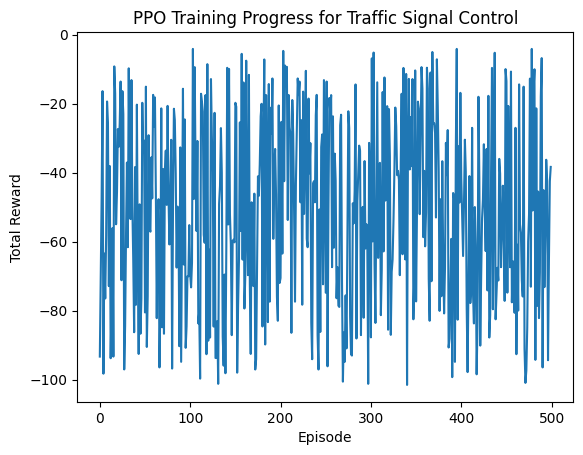

In [25]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PPO Training Progress for Traffic Signal Control")
plt.show()


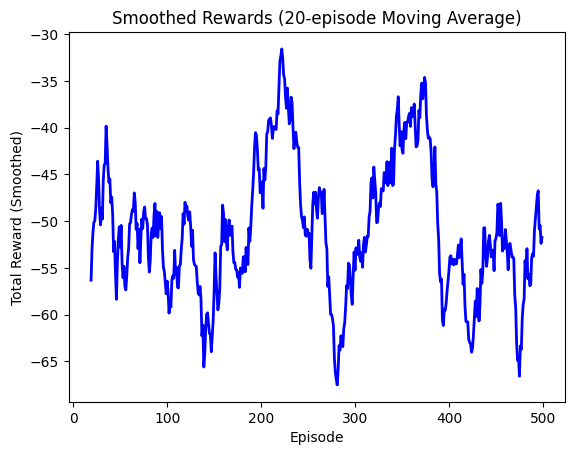

In [26]:
import pandas as pd
plt.plot(pd.Series(rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()


In [27]:
!pip install stable_baselines3

# Re-initialize the PPOAgent model structure
loaded_agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)

# Load the state dictionary into the agent
loaded_agent.load_state_dict(torch.load("ppo_traffic_model_500.pt"))
loaded_agent.eval() # Set the model to evaluation mode

print("Model loaded successfully!")

Model loaded successfully!


In [28]:
print("Continuing training for 500 more episodes...")
new_rewards = train_ppo(episodes=500)
rewards.extend(new_rewards)
print("Training complete.")

Continuing training for 500 more episodes...
Loaded 500 previous rewards from 'reward_log.json'


  0%|          | 1/500 [00:00<05:08,  1.62it/s]

Episode 501 | Total Reward: -18.97


  0%|          | 2/500 [00:03<14:28,  1.74s/it]

Episode 502 | Total Reward: -81.15


  1%|          | 3/500 [00:05<16:24,  1.98s/it]

Episode 503 | Total Reward: -69.97


  1%|          | 4/500 [00:07<16:22,  1.98s/it]

Episode 504 | Total Reward: -62.87


  1%|          | 5/500 [00:09<15:49,  1.92s/it]

Episode 505 | Total Reward: -56.32


  1%|          | 6/500 [00:10<14:58,  1.82s/it]

Episode 506 | Total Reward: -50.33


  2%|▏         | 8/500 [00:12<10:31,  1.28s/it]

Episode 507 | Total Reward: -57.47
Episode 508 | Total Reward: -5.02


  2%|▏         | 9/500 [00:15<14:14,  1.74s/it]

Episode 509 | Total Reward: -86.29


  2%|▏         | 10/500 [00:18<16:43,  2.05s/it]

Episode 510 | Total Reward: -85.56
💾 Progress saved — 510 episodes complete


  2%|▏         | 11/500 [00:20<17:30,  2.15s/it]

Episode 511 | Total Reward: -74.35


  2%|▏         | 12/500 [00:22<17:38,  2.17s/it]

Episode 512 | Total Reward: -70.13


  3%|▎         | 13/500 [00:24<15:08,  1.87s/it]

Episode 513 | Total Reward: -35.65


  3%|▎         | 14/500 [00:24<12:43,  1.57s/it]

Episode 514 | Total Reward: -28.01


  3%|▎         | 15/500 [00:27<14:20,  1.77s/it]

Episode 515 | Total Reward: -70.44


  3%|▎         | 16/500 [00:29<14:30,  1.80s/it]

Episode 516 | Total Reward: -58.38


  3%|▎         | 17/500 [00:30<12:32,  1.56s/it]

Episode 517 | Total Reward: -30.47


  4%|▎         | 18/500 [00:32<13:49,  1.72s/it]

Episode 518 | Total Reward: -66.50


  4%|▍         | 19/500 [00:34<14:25,  1.80s/it]

Episode 519 | Total Reward: -62.87


  4%|▍         | 20/500 [00:34<10:51,  1.36s/it]

Episode 520 | Total Reward: -9.92
💾 Progress saved — 520 episodes complete


  4%|▍         | 21/500 [00:37<14:47,  1.85s/it]

Episode 521 | Total Reward: -97.39


  5%|▍         | 23/500 [00:38<08:59,  1.13s/it]

Episode 522 | Total Reward: -25.63
Episode 523 | Total Reward: -6.57


  5%|▍         | 24/500 [00:41<13:33,  1.71s/it]

Episode 524 | Total Reward: -98.65


  5%|▌         | 25/500 [00:43<15:22,  1.94s/it]

Episode 525 | Total Reward: -78.86


  5%|▌         | 26/500 [00:46<16:21,  2.07s/it]

Episode 526 | Total Reward: -74.94


  5%|▌         | 27/500 [00:48<16:18,  2.07s/it]

Episode 527 | Total Reward: -65.95


  6%|▌         | 28/500 [00:50<16:17,  2.07s/it]

Episode 528 | Total Reward: -66.47


  6%|▌         | 29/500 [00:53<17:38,  2.25s/it]

Episode 529 | Total Reward: -86.21


  6%|▌         | 30/500 [00:55<18:44,  2.39s/it]

Episode 530 | Total Reward: -86.45
💾 Progress saved — 530 episodes complete


  6%|▌         | 31/500 [00:58<18:12,  2.33s/it]

Episode 531 | Total Reward: -69.78


  6%|▋         | 32/500 [01:00<18:57,  2.43s/it]

Episode 532 | Total Reward: -80.49


  7%|▋         | 33/500 [01:02<17:59,  2.31s/it]

Episode 533 | Total Reward: -64.21


  7%|▋         | 34/500 [01:05<19:13,  2.47s/it]

Episode 534 | Total Reward: -86.47


  7%|▋         | 35/500 [01:06<16:15,  2.10s/it]

Episode 535 | Total Reward: -38.01


  7%|▋         | 36/500 [01:09<18:10,  2.35s/it]

Episode 536 | Total Reward: -92.57


  7%|▋         | 37/500 [01:12<18:23,  2.38s/it]

Episode 537 | Total Reward: -79.76


  8%|▊         | 39/500 [01:15<14:01,  1.83s/it]

Episode 538 | Total Reward: -90.24
Episode 539 | Total Reward: -4.81


  8%|▊         | 40/500 [01:17<15:47,  2.06s/it]

Episode 540 | Total Reward: -83.90
💾 Progress saved — 540 episodes complete


  8%|▊         | 41/500 [01:19<14:27,  1.89s/it]

Episode 541 | Total Reward: -46.47


  8%|▊         | 42/500 [01:22<16:39,  2.18s/it]

Episode 542 | Total Reward: -92.50


  9%|▊         | 43/500 [01:22<12:46,  1.68s/it]

Episode 543 | Total Reward: -16.15


  9%|▉         | 44/500 [01:24<13:29,  1.78s/it]

Episode 544 | Total Reward: -63.58


  9%|▉         | 45/500 [01:25<10:17,  1.36s/it]

Episode 545 | Total Reward: -11.23


  9%|▉         | 46/500 [01:26<10:14,  1.35s/it]

Episode 546 | Total Reward: -41.80


  9%|▉         | 47/500 [01:28<12:36,  1.67s/it]

Episode 547 | Total Reward: -77.05


 10%|▉         | 48/500 [01:30<11:49,  1.57s/it]

Episode 548 | Total Reward: -41.28


 10%|▉         | 49/500 [01:31<11:46,  1.57s/it]

Episode 549 | Total Reward: -48.91


 10%|█         | 50/500 [01:32<08:48,  1.17s/it]

Episode 550 | Total Reward: -9.06
💾 Progress saved — 550 episodes complete


 10%|█         | 51/500 [01:33<08:45,  1.17s/it]

Episode 551 | Total Reward: -36.60


 10%|█         | 52/500 [01:34<09:58,  1.34s/it]

Episode 552 | Total Reward: -53.72


 11%|█         | 53/500 [01:35<07:46,  1.04s/it]

Episode 553 | Total Reward: -11.01


 11%|█         | 54/500 [01:37<10:39,  1.43s/it]

Episode 554 | Total Reward: -75.31


 11%|█         | 55/500 [01:38<10:07,  1.37s/it]

Episode 555 | Total Reward: -38.37


 11%|█         | 56/500 [01:40<09:40,  1.31s/it]

Episode 556 | Total Reward: -36.68


 11%|█▏        | 57/500 [01:42<13:03,  1.77s/it]

Episode 557 | Total Reward: -91.27


 12%|█▏        | 58/500 [01:44<12:09,  1.65s/it]

Episode 558 | Total Reward: -43.10


 12%|█▏        | 59/500 [01:45<10:25,  1.42s/it]

Episode 559 | Total Reward: -27.61


 12%|█▏        | 60/500 [01:46<11:26,  1.56s/it]

Episode 560 | Total Reward: -59.47
💾 Progress saved — 560 episodes complete


 12%|█▏        | 61/500 [01:50<14:53,  2.03s/it]

Episode 561 | Total Reward: -100.27


 12%|█▏        | 62/500 [01:52<14:30,  1.99s/it]

Episode 562 | Total Reward: -59.79


 13%|█▎        | 63/500 [01:53<12:35,  1.73s/it]

Episode 563 | Total Reward: -36.05


 13%|█▎        | 64/500 [01:55<14:46,  2.03s/it]

Episode 564 | Total Reward: -86.36


 13%|█▎        | 65/500 [01:58<15:34,  2.15s/it]

Episode 565 | Total Reward: -77.72


 13%|█▎        | 66/500 [01:58<11:32,  1.60s/it]

Episode 566 | Total Reward: -10.07


 13%|█▎        | 67/500 [01:59<10:38,  1.47s/it]

Episode 567 | Total Reward: -37.59


 14%|█▎        | 68/500 [02:01<12:10,  1.69s/it]

Episode 568 | Total Reward: -70.23


 14%|█▍        | 69/500 [02:02<09:25,  1.31s/it]

Episode 569 | Total Reward: -14.12


 14%|█▍        | 70/500 [02:03<08:18,  1.16s/it]

Episode 570 | Total Reward: -25.90
💾 Progress saved — 570 episodes complete


 14%|█▍        | 71/500 [02:04<08:20,  1.17s/it]

Episode 571 | Total Reward: -36.18


 14%|█▍        | 72/500 [02:07<11:27,  1.61s/it]

Episode 572 | Total Reward: -84.34


 15%|█▍        | 73/500 [02:08<10:31,  1.48s/it]

Episode 573 | Total Reward: -37.88


 15%|█▍        | 74/500 [02:09<09:14,  1.30s/it]

Episode 574 | Total Reward: -28.12


 15%|█▌        | 75/500 [02:10<10:18,  1.45s/it]

Episode 575 | Total Reward: -56.10


 15%|█▌        | 76/500 [02:12<11:00,  1.56s/it]

Episode 576 | Total Reward: -57.08


 15%|█▌        | 77/500 [02:14<11:04,  1.57s/it]

Episode 577 | Total Reward: -49.85


 16%|█▌        | 78/500 [02:17<13:52,  1.97s/it]

Episode 578 | Total Reward: -92.39


 16%|█▌        | 79/500 [02:18<12:40,  1.81s/it]

Episode 579 | Total Reward: -45.11


 16%|█▌        | 80/500 [02:21<14:48,  2.11s/it]

Episode 580 | Total Reward: -90.48
💾 Progress saved — 580 episodes complete


 16%|█▌        | 81/500 [02:24<16:36,  2.38s/it]

Episode 581 | Total Reward: -96.64


 16%|█▋        | 82/500 [02:26<16:01,  2.30s/it]

Episode 582 | Total Reward: -65.75


 17%|█▋        | 83/500 [02:27<12:29,  1.80s/it]

Episode 583 | Total Reward: -19.86


 17%|█▋        | 84/500 [02:29<14:10,  2.04s/it]

Episode 584 | Total Reward: -83.60


 17%|█▋        | 85/500 [02:31<14:10,  2.05s/it]

Episode 585 | Total Reward: -65.67


 17%|█▋        | 86/500 [02:32<11:22,  1.65s/it]

Episode 586 | Total Reward: -22.43


 17%|█▋        | 87/500 [02:33<10:48,  1.57s/it]

Episode 587 | Total Reward: -44.17


 18%|█▊        | 88/500 [02:36<12:13,  1.78s/it]

Episode 588 | Total Reward: -71.22


 18%|█▊        | 89/500 [02:38<13:31,  1.97s/it]

Episode 589 | Total Reward: -77.44


 18%|█▊        | 90/500 [02:39<11:35,  1.70s/it]

Episode 590 | Total Reward: -32.61
💾 Progress saved — 590 episodes complete


 18%|█▊        | 91/500 [02:42<14:04,  2.07s/it]

Episode 591 | Total Reward: -92.57


 18%|█▊        | 92/500 [02:43<10:45,  1.58s/it]

Episode 592 | Total Reward: -14.47


 19%|█▊        | 93/500 [02:44<10:41,  1.57s/it]

Episode 593 | Total Reward: -48.98


 19%|█▉        | 94/500 [02:45<09:12,  1.36s/it]

Episode 594 | Total Reward: -27.52


 19%|█▉        | 95/500 [02:46<08:17,  1.23s/it]

Episode 595 | Total Reward: -28.01


 19%|█▉        | 96/500 [02:47<06:54,  1.03s/it]

Episode 596 | Total Reward: -17.74


 19%|█▉        | 97/500 [02:49<09:35,  1.43s/it]

Episode 597 | Total Reward: -75.47


 20%|█▉        | 98/500 [02:52<12:28,  1.86s/it]

Episode 598 | Total Reward: -93.28


 20%|█▉        | 99/500 [02:52<09:38,  1.44s/it]

Episode 599 | Total Reward: -15.29


 20%|██        | 100/500 [02:53<08:34,  1.29s/it]

Episode 600 | Total Reward: -28.50
💾 Progress saved — 600 episodes complete


 20%|██        | 101/500 [02:54<07:39,  1.15s/it]

Episode 601 | Total Reward: -26.91


 20%|██        | 102/500 [02:57<10:45,  1.62s/it]

Episode 602 | Total Reward: -87.05


 21%|██        | 103/500 [02:59<12:25,  1.88s/it]

Episode 603 | Total Reward: -78.58


 21%|██        | 104/500 [03:01<12:29,  1.89s/it]

Episode 604 | Total Reward: -61.54


 21%|██        | 105/500 [03:03<12:41,  1.93s/it]

Episode 605 | Total Reward: -64.21


 21%|██        | 106/500 [03:05<13:03,  1.99s/it]

Episode 606 | Total Reward: -67.13


 21%|██▏       | 107/500 [03:07<11:40,  1.78s/it]

Episode 607 | Total Reward: -40.19


 22%|██▏       | 108/500 [03:08<11:02,  1.69s/it]

Episode 608 | Total Reward: -46.26


 22%|██▏       | 109/500 [03:09<09:00,  1.38s/it]

Episode 609 | Total Reward: -20.88


 22%|██▏       | 110/500 [03:11<11:04,  1.70s/it]

Episode 610 | Total Reward: -76.88
💾 Progress saved — 610 episodes complete


 22%|██▏       | 111/500 [03:13<11:21,  1.75s/it]

Episode 611 | Total Reward: -59.39


 22%|██▏       | 112/500 [03:16<13:32,  2.09s/it]

Episode 612 | Total Reward: -92.59


 23%|██▎       | 113/500 [03:16<10:15,  1.59s/it]

Episode 613 | Total Reward: -12.98


 23%|██▎       | 114/500 [03:19<11:34,  1.80s/it]

Episode 614 | Total Reward: -72.35


 23%|██▎       | 115/500 [03:19<08:40,  1.35s/it]

Episode 615 | Total Reward: -10.57


 23%|██▎       | 116/500 [03:22<11:16,  1.76s/it]

Episode 616 | Total Reward: -86.45


 23%|██▎       | 117/500 [03:23<10:57,  1.72s/it]

Episode 617 | Total Reward: -51.04


 24%|██▎       | 118/500 [03:26<13:28,  2.12s/it]

Episode 618 | Total Reward: -97.08


 24%|██▍       | 119/500 [03:29<14:49,  2.34s/it]

Episode 619 | Total Reward: -91.07


 24%|██▍       | 120/500 [03:30<12:32,  1.98s/it]

Episode 620 | Total Reward: -36.18
💾 Progress saved — 620 episodes complete


 24%|██▍       | 121/500 [03:32<12:16,  1.94s/it]

Episode 621 | Total Reward: -57.15


 24%|██▍       | 122/500 [03:34<11:35,  1.84s/it]

Episode 622 | Total Reward: -49.88


 25%|██▍       | 123/500 [03:35<11:00,  1.75s/it]

Episode 623 | Total Reward: -48.63


 25%|██▍       | 124/500 [03:37<11:01,  1.76s/it]

Episode 624 | Total Reward: -53.32


 25%|██▌       | 125/500 [03:39<12:14,  1.96s/it]

Episode 625 | Total Reward: -77.89


 25%|██▌       | 126/500 [03:40<09:03,  1.45s/it]

Episode 626 | Total Reward: -9.06


 25%|██▌       | 127/500 [03:41<08:41,  1.40s/it]

Episode 627 | Total Reward: -39.25


 26%|██▌       | 128/500 [03:42<08:00,  1.29s/it]

Episode 628 | Total Reward: -31.60


 26%|██▌       | 129/500 [03:45<10:57,  1.77s/it]

Episode 629 | Total Reward: -94.06


 26%|██▌       | 130/500 [03:47<10:47,  1.75s/it]

Episode 630 | Total Reward: -52.43
💾 Progress saved — 630 episodes complete


 26%|██▌       | 131/500 [03:49<11:56,  1.94s/it]

Episode 631 | Total Reward: -75.17


 26%|██▋       | 132/500 [03:52<13:50,  2.26s/it]

Episode 632 | Total Reward: -96.64


 27%|██▋       | 133/500 [03:54<13:48,  2.26s/it]

Episode 633 | Total Reward: -71.22


 27%|██▋       | 134/500 [03:56<12:21,  2.03s/it]

Episode 634 | Total Reward: -46.76


 27%|██▋       | 135/500 [03:57<10:19,  1.70s/it]

Episode 635 | Total Reward: -28.42


 27%|██▋       | 136/500 [03:59<11:37,  1.92s/it]

Episode 636 | Total Reward: -76.09


 27%|██▋       | 137/500 [04:01<12:18,  2.03s/it]

Episode 637 | Total Reward: -73.16


 28%|██▊       | 138/500 [04:04<12:28,  2.07s/it]

Episode 638 | Total Reward: -69.21


 28%|██▊       | 139/500 [04:06<12:12,  2.03s/it]

Episode 639 | Total Reward: -61.54


 28%|██▊       | 140/500 [04:06<09:12,  1.54s/it]

Episode 640 | Total Reward: -12.91
💾 Progress saved — 640 episodes complete


 28%|██▊       | 141/500 [04:07<07:30,  1.26s/it]

Episode 641 | Total Reward: -18.50


 28%|██▊       | 142/500 [04:07<06:23,  1.07s/it]

Episode 642 | Total Reward: -19.13


 29%|██▊       | 143/500 [04:10<08:49,  1.48s/it]

Episode 643 | Total Reward: -76.61


 29%|██▉       | 144/500 [04:11<08:02,  1.36s/it]

Episode 644 | Total Reward: -33.46


 29%|██▉       | 145/500 [04:12<08:37,  1.46s/it]

Episode 645 | Total Reward: -52.43


 29%|██▉       | 146/500 [04:15<11:04,  1.88s/it]

Episode 646 | Total Reward: -91.52


 29%|██▉       | 147/500 [04:17<10:21,  1.76s/it]

Episode 647 | Total Reward: -46.76


 30%|██▉       | 148/500 [04:17<07:48,  1.33s/it]

Episode 648 | Total Reward: -10.79


 30%|██▉       | 149/500 [04:19<09:20,  1.60s/it]

Episode 649 | Total Reward: -69.63


 30%|███       | 150/500 [04:22<11:18,  1.94s/it]

Episode 650 | Total Reward: -87.59
💾 Progress saved — 650 episodes complete


 30%|███       | 151/500 [04:23<09:36,  1.65s/it]

Episode 651 | Total Reward: -30.63


 30%|███       | 152/500 [04:24<08:10,  1.41s/it]

Episode 652 | Total Reward: -27.13


 31%|███       | 153/500 [04:26<10:05,  1.74s/it]

Episode 653 | Total Reward: -80.25


 31%|███       | 154/500 [04:28<09:17,  1.61s/it]

Episode 654 | Total Reward: -40.21


 31%|███       | 155/500 [04:30<10:03,  1.75s/it]

Episode 655 | Total Reward: -65.02


 31%|███       | 156/500 [04:30<07:22,  1.29s/it]

Episode 656 | Total Reward: -7.26


 31%|███▏      | 157/500 [04:32<09:27,  1.65s/it]

Episode 657 | Total Reward: -79.16


 32%|███▏      | 158/500 [04:33<07:51,  1.38s/it]

Episode 658 | Total Reward: -22.43


 32%|███▏      | 159/500 [04:34<06:32,  1.15s/it]

Episode 659 | Total Reward: -19.71


 32%|███▏      | 160/500 [04:36<07:42,  1.36s/it]

Episode 660 | Total Reward: -56.55
💾 Progress saved — 660 episodes complete


 32%|███▏      | 161/500 [04:38<09:00,  1.59s/it]

Episode 661 | Total Reward: -59.39


 33%|███▎      | 163/500 [04:40<07:22,  1.31s/it]

Episode 662 | Total Reward: -71.89
Episode 663 | Total Reward: -6.47


 33%|███▎      | 164/500 [04:43<09:31,  1.70s/it]

Episode 664 | Total Reward: -80.25


 33%|███▎      | 165/500 [04:46<11:47,  2.11s/it]

Episode 665 | Total Reward: -96.04


 33%|███▎      | 166/500 [04:48<11:45,  2.11s/it]

Episode 666 | Total Reward: -66.18


 33%|███▎      | 167/500 [04:50<11:09,  2.01s/it]

Episode 667 | Total Reward: -48.12


 34%|███▍      | 169/500 [04:51<06:33,  1.19s/it]

Episode 668 | Total Reward: -24.17
Episode 669 | Total Reward: -5.38


 34%|███▍      | 170/500 [04:52<07:12,  1.31s/it]

Episode 670 | Total Reward: -49.63
💾 Progress saved — 670 episodes complete


 34%|███▍      | 171/500 [04:54<07:59,  1.46s/it]

Episode 671 | Total Reward: -52.15


 34%|███▍      | 172/500 [04:55<07:34,  1.39s/it]

Episode 672 | Total Reward: -37.88


 35%|███▍      | 173/500 [04:58<10:03,  1.85s/it]

Episode 673 | Total Reward: -90.77


 35%|███▍      | 174/500 [04:59<08:01,  1.48s/it]

Episode 674 | Total Reward: -17.56


 35%|███▌      | 175/500 [05:01<09:24,  1.74s/it]

Episode 675 | Total Reward: -66.58


 35%|███▌      | 176/500 [05:04<11:31,  2.14s/it]

Episode 676 | Total Reward: -96.49


 35%|███▌      | 177/500 [05:06<10:57,  2.04s/it]

Episode 677 | Total Reward: -56.77


 36%|███▌      | 178/500 [05:07<08:32,  1.59s/it]

Episode 678 | Total Reward: -17.85


 36%|███▌      | 179/500 [05:09<09:30,  1.78s/it]

Episode 679 | Total Reward: -69.63


 36%|███▌      | 180/500 [05:11<10:14,  1.92s/it]

Episode 680 | Total Reward: -71.08
💾 Progress saved — 680 episodes complete


 36%|███▌      | 181/500 [05:13<09:53,  1.86s/it]

Episode 681 | Total Reward: -53.04


 36%|███▋      | 182/500 [05:15<10:50,  2.05s/it]

Episode 682 | Total Reward: -79.22


 37%|███▋      | 183/500 [05:16<09:25,  1.79s/it]

Episode 683 | Total Reward: -37.37


 37%|███▋      | 184/500 [05:19<10:57,  2.08s/it]

Episode 684 | Total Reward: -88.38


 37%|███▋      | 185/500 [05:22<11:47,  2.25s/it]

Episode 685 | Total Reward: -84.14


 37%|███▋      | 186/500 [05:24<12:00,  2.30s/it]

Episode 686 | Total Reward: -76.78


 37%|███▋      | 187/500 [05:26<10:41,  2.05s/it]

Episode 687 | Total Reward: -45.40


 38%|███▊      | 188/500 [05:28<10:24,  2.00s/it]

Episode 688 | Total Reward: -58.62


 38%|███▊      | 189/500 [05:30<10:24,  2.01s/it]

Episode 689 | Total Reward: -63.21


 38%|███▊      | 190/500 [05:32<10:25,  2.02s/it]

Episode 690 | Total Reward: -63.93
💾 Progress saved — 690 episodes complete


 38%|███▊      | 191/500 [05:34<10:10,  1.97s/it]

Episode 691 | Total Reward: -58.88


 38%|███▊      | 192/500 [05:36<10:53,  2.12s/it]

Episode 692 | Total Reward: -78.91


 39%|███▊      | 193/500 [05:39<11:25,  2.23s/it]

Episode 693 | Total Reward: -77.59


 39%|███▉      | 194/500 [05:40<09:51,  1.93s/it]

Episode 694 | Total Reward: -38.42


 39%|███▉      | 195/500 [05:42<10:23,  2.04s/it]

Episode 695 | Total Reward: -72.40


 39%|███▉      | 196/500 [05:44<10:00,  1.98s/it]

Episode 696 | Total Reward: -57.04


 39%|███▉      | 197/500 [05:47<11:05,  2.20s/it]

Episode 697 | Total Reward: -87.14


 40%|███▉      | 198/500 [05:48<10:29,  2.08s/it]

Episode 698 | Total Reward: -55.53


 40%|███▉      | 199/500 [05:50<10:22,  2.07s/it]

Episode 699 | Total Reward: -64.18


 40%|████      | 200/500 [05:53<10:49,  2.16s/it]

Episode 700 | Total Reward: -75.61
💾 Progress saved — 700 episodes complete


 40%|████      | 201/500 [05:56<11:46,  2.36s/it]

Episode 701 | Total Reward: -90.24


 40%|████      | 202/500 [05:58<12:09,  2.45s/it]

Episode 702 | Total Reward: -84.46


 41%|████      | 203/500 [06:01<12:24,  2.51s/it]

Episode 703 | Total Reward: -83.40


 41%|████      | 204/500 [06:02<10:11,  2.07s/it]

Episode 704 | Total Reward: -32.31


 41%|████      | 205/500 [06:03<08:06,  1.65s/it]

Episode 705 | Total Reward: -20.88


 41%|████      | 206/500 [06:03<06:37,  1.35s/it]

Episode 706 | Total Reward: -20.63


 41%|████▏     | 207/500 [06:04<05:44,  1.18s/it]

Episode 707 | Total Reward: -23.39


 42%|████▏     | 208/500 [06:06<06:36,  1.36s/it]

Episode 708 | Total Reward: -55.53


 42%|████▏     | 209/500 [06:07<06:27,  1.33s/it]

Episode 709 | Total Reward: -40.24


 42%|████▏     | 210/500 [06:08<05:35,  1.16s/it]

Episode 710 | Total Reward: -22.87
💾 Progress saved — 710 episodes complete


 42%|████▏     | 211/500 [06:09<05:37,  1.17s/it]

Episode 711 | Total Reward: -36.68


 42%|████▏     | 212/500 [06:11<06:51,  1.43s/it]

Episode 712 | Total Reward: -64.40


 43%|████▎     | 213/500 [06:12<05:47,  1.21s/it]

Episode 713 | Total Reward: -21.63


 43%|████▎     | 214/500 [06:12<04:35,  1.04it/s]

Episode 714 | Total Reward: -12.45


 43%|████▎     | 215/500 [06:14<05:38,  1.19s/it]

Episode 715 | Total Reward: -52.15


 43%|████▎     | 216/500 [06:15<06:05,  1.29s/it]

Episode 716 | Total Reward: -46.76


 43%|████▎     | 217/500 [06:18<08:29,  1.80s/it]

Episode 717 | Total Reward: -96.99


 44%|████▎     | 218/500 [06:19<07:02,  1.50s/it]

Episode 718 | Total Reward: -24.60


 44%|████▍     | 219/500 [06:21<07:07,  1.52s/it]

Episode 719 | Total Reward: -49.06


 44%|████▍     | 220/500 [06:24<08:51,  1.90s/it]

Episode 720 | Total Reward: -88.64
💾 Progress saved — 720 episodes complete


 44%|████▍     | 222/500 [06:26<06:23,  1.38s/it]

Episode 721 | Total Reward: -58.32
Episode 722 | Total Reward: -6.70


 45%|████▍     | 223/500 [06:28<07:38,  1.66s/it]

Episode 723 | Total Reward: -72.65


 45%|████▍     | 224/500 [06:29<06:16,  1.36s/it]

Episode 724 | Total Reward: -20.71


 45%|████▌     | 225/500 [06:29<04:54,  1.07s/it]

Episode 725 | Total Reward: -12.21


 45%|████▌     | 226/500 [06:30<04:13,  1.08it/s]

Episode 726 | Total Reward: -17.53


 45%|████▌     | 227/500 [06:30<03:39,  1.24it/s]

Episode 727 | Total Reward: -16.41


 46%|████▌     | 228/500 [06:33<05:48,  1.28s/it]

Episode 728 | Total Reward: -74.84


 46%|████▌     | 229/500 [06:35<07:40,  1.70s/it]

Episode 729 | Total Reward: -86.36


 46%|████▌     | 230/500 [06:37<08:20,  1.85s/it]

Episode 730 | Total Reward: -69.63
💾 Progress saved — 730 episodes complete


 46%|████▌     | 231/500 [06:38<06:13,  1.39s/it]

Episode 731 | Total Reward: -10.07


 46%|████▋     | 232/500 [06:39<06:06,  1.37s/it]

Episode 732 | Total Reward: -40.77


 47%|████▋     | 233/500 [06:41<06:53,  1.55s/it]

Episode 733 | Total Reward: -61.91


 47%|████▋     | 234/500 [06:42<06:20,  1.43s/it]

Episode 734 | Total Reward: -35.25


 47%|████▋     | 235/500 [06:43<06:01,  1.36s/it]

Episode 735 | Total Reward: -37.93


 47%|████▋     | 236/500 [06:45<05:50,  1.33s/it]

Episode 736 | Total Reward: -39.01


 47%|████▋     | 237/500 [06:47<07:30,  1.71s/it]

Episode 737 | Total Reward: -84.08


 48%|████▊     | 238/500 [06:50<08:34,  1.97s/it]

Episode 738 | Total Reward: -80.23


 48%|████▊     | 239/500 [06:51<07:18,  1.68s/it]

Episode 739 | Total Reward: -31.48


 48%|████▊     | 240/500 [06:51<05:58,  1.38s/it]

Episode 740 | Total Reward: -21.22
💾 Progress saved — 740 episodes complete


 48%|████▊     | 241/500 [06:53<05:58,  1.39s/it]

Episode 741 | Total Reward: -43.72


 48%|████▊     | 242/500 [06:55<06:58,  1.62s/it]

Episode 742 | Total Reward: -68.04


 49%|████▊     | 243/500 [06:55<05:20,  1.25s/it]

Episode 743 | Total Reward: -12.57


 49%|████▉     | 244/500 [06:58<06:59,  1.64s/it]

Episode 744 | Total Reward: -81.76


 49%|████▉     | 245/500 [07:01<08:56,  2.10s/it]

Episode 745 | Total Reward: -100.65


 49%|████▉     | 246/500 [07:04<10:08,  2.40s/it]

Episode 746 | Total Reward: -98.25


 49%|████▉     | 247/500 [07:06<09:21,  2.22s/it]

Episode 747 | Total Reward: -56.56


 50%|████▉     | 248/500 [07:08<09:22,  2.23s/it]

Episode 748 | Total Reward: -71.66


 50%|████▉     | 249/500 [07:10<09:01,  2.16s/it]

Episode 749 | Total Reward: -60.85


 50%|█████     | 250/500 [07:11<07:33,  1.81s/it]

Episode 750 | Total Reward: -31.20
💾 Progress saved — 750 episodes complete


 50%|█████     | 251/500 [07:14<08:13,  1.98s/it]

Episode 751 | Total Reward: -75.86


 50%|█████     | 252/500 [07:15<07:15,  1.76s/it]

Episode 752 | Total Reward: -38.16


 51%|█████     | 253/500 [07:16<05:53,  1.43s/it]

Episode 753 | Total Reward: -20.94


 51%|█████     | 254/500 [07:17<06:15,  1.53s/it]

Episode 754 | Total Reward: -54.07


 51%|█████     | 255/500 [07:20<07:16,  1.78s/it]

Episode 755 | Total Reward: -76.01


 51%|█████     | 256/500 [07:22<07:42,  1.90s/it]

Episode 756 | Total Reward: -67.16


 51%|█████▏    | 257/500 [07:24<07:28,  1.84s/it]

Episode 757 | Total Reward: -53.09


 52%|█████▏    | 258/500 [07:27<09:00,  2.23s/it]

Episode 758 | Total Reward: -99.25


 52%|█████▏    | 259/500 [07:28<07:19,  1.83s/it]

Episode 759 | Total Reward: -27.56


 52%|█████▏    | 260/500 [07:29<07:13,  1.81s/it]

Episode 760 | Total Reward: -55.53
💾 Progress saved — 760 episodes complete


 52%|█████▏    | 261/500 [07:31<07:19,  1.84s/it]

Episode 761 | Total Reward: -58.32


 52%|█████▏    | 262/500 [07:32<05:55,  1.49s/it]

Episode 762 | Total Reward: -21.45


 53%|█████▎    | 263/500 [07:35<07:46,  1.97s/it]

Episode 763 | Total Reward: -100.16


 53%|█████▎    | 264/500 [07:38<08:31,  2.17s/it]

Episode 764 | Total Reward: -83.63


 53%|█████▎    | 265/500 [07:40<08:21,  2.13s/it]

Episode 765 | Total Reward: -64.80


 53%|█████▎    | 266/500 [07:40<06:09,  1.58s/it]

Episode 766 | Total Reward: -9.69


 53%|█████▎    | 267/500 [07:43<07:28,  1.92s/it]

Episode 767 | Total Reward: -85.53


 54%|█████▎    | 268/500 [07:44<06:40,  1.73s/it]

Episode 768 | Total Reward: -39.05


 54%|█████▍    | 269/500 [07:46<07:13,  1.88s/it]

Episode 769 | Total Reward: -70.90


 54%|█████▍    | 270/500 [07:48<07:13,  1.88s/it]

Episode 770 | Total Reward: -59.87
💾 Progress saved — 770 episodes complete


 54%|█████▍    | 271/500 [07:51<07:54,  2.07s/it]

Episode 771 | Total Reward: -79.76


 54%|█████▍    | 272/500 [07:52<06:40,  1.76s/it]

Episode 772 | Total Reward: -32.00


 55%|█████▍    | 273/500 [07:54<07:06,  1.88s/it]

Episode 773 | Total Reward: -68.24


 55%|█████▍    | 274/500 [07:56<06:55,  1.84s/it]

Episode 774 | Total Reward: -54.98


 55%|█████▌    | 275/500 [07:57<06:18,  1.68s/it]

Episode 775 | Total Reward: -40.95


 55%|█████▌    | 276/500 [08:00<07:34,  2.03s/it]

Episode 776 | Total Reward: -91.07


 55%|█████▌    | 277/500 [08:03<08:32,  2.30s/it]

Episode 777 | Total Reward: -92.59


 56%|█████▌    | 278/500 [08:05<08:45,  2.37s/it]

Episode 778 | Total Reward: -79.76


 56%|█████▌    | 279/500 [08:08<09:28,  2.57s/it]

Episode 779 | Total Reward: -98.95


 56%|█████▌    | 280/500 [08:11<09:11,  2.51s/it]

Episode 780 | Total Reward: -74.35
💾 Progress saved — 780 episodes complete


 56%|█████▌    | 281/500 [08:13<09:06,  2.50s/it]

Episode 781 | Total Reward: -77.62


 56%|█████▋    | 282/500 [08:15<08:46,  2.41s/it]

Episode 782 | Total Reward: -70.46


 57%|█████▋    | 283/500 [08:17<08:08,  2.25s/it]

Episode 783 | Total Reward: -59.60


 57%|█████▋    | 284/500 [08:18<06:03,  1.68s/it]

Episode 784 | Total Reward: -11.87


 57%|█████▋    | 285/500 [08:20<06:51,  1.91s/it]

Episode 785 | Total Reward: -77.21


 57%|█████▋    | 286/500 [08:21<06:02,  1.69s/it]

Episode 786 | Total Reward: -35.65


 57%|█████▋    | 287/500 [08:23<05:47,  1.63s/it]

Episode 787 | Total Reward: -46.95


 58%|█████▊    | 288/500 [08:24<05:55,  1.68s/it]

Episode 788 | Total Reward: -55.78


 58%|█████▊    | 289/500 [08:27<06:46,  1.93s/it]

Episode 789 | Total Reward: -79.64


 58%|█████▊    | 290/500 [08:30<07:34,  2.17s/it]

Episode 790 | Total Reward: -85.86
💾 Progress saved — 790 episodes complete


 58%|█████▊    | 291/500 [08:31<06:50,  1.96s/it]

Episode 791 | Total Reward: -46.45


 58%|█████▊    | 292/500 [08:33<06:52,  1.98s/it]

Episode 792 | Total Reward: -63.21


 59%|█████▊    | 293/500 [08:35<06:31,  1.89s/it]

Episode 793 | Total Reward: -51.63


 59%|█████▉    | 294/500 [08:37<06:23,  1.86s/it]

Episode 794 | Total Reward: -55.53


 59%|█████▉    | 295/500 [08:40<07:35,  2.22s/it]

Episode 795 | Total Reward: -98.84


 59%|█████▉    | 296/500 [08:42<07:38,  2.25s/it]

Episode 796 | Total Reward: -71.24


 59%|█████▉    | 297/500 [08:44<07:39,  2.26s/it]

Episode 797 | Total Reward: -72.60


 60%|█████▉    | 298/500 [08:47<08:25,  2.50s/it]

Episode 798 | Total Reward: -98.95


 60%|█████▉    | 299/500 [08:50<08:26,  2.52s/it]

Episode 799 | Total Reward: -81.17


 60%|██████    | 300/500 [08:52<08:16,  2.48s/it]

Episode 800 | Total Reward: -75.93
💾 Progress saved — 800 episodes complete


 60%|██████    | 301/500 [08:54<06:59,  2.11s/it]

Episode 801 | Total Reward: -38.72


 60%|██████    | 302/500 [08:57<07:59,  2.42s/it]

Episode 802 | Total Reward: -100.77


 61%|██████    | 303/500 [08:57<06:15,  1.91s/it]

Episode 803 | Total Reward: -22.77


 61%|██████    | 304/500 [08:58<05:02,  1.54s/it]

Episode 804 | Total Reward: -20.71


 61%|██████    | 305/500 [08:59<04:43,  1.45s/it]

Episode 805 | Total Reward: -39.01


 61%|██████    | 306/500 [09:02<05:47,  1.79s/it]

Episode 806 | Total Reward: -82.19


 61%|██████▏   | 307/500 [09:05<06:54,  2.15s/it]

Episode 807 | Total Reward: -95.69


 62%|██████▏   | 308/500 [09:07<06:22,  1.99s/it]

Episode 808 | Total Reward: -50.87


 62%|██████▏   | 309/500 [09:09<06:49,  2.14s/it]

Episode 809 | Total Reward: -80.19


 62%|██████▏   | 310/500 [09:10<05:40,  1.79s/it]

Episode 810 | Total Reward: -29.19
💾 Progress saved — 810 episodes complete


 62%|██████▏   | 312/500 [09:12<04:02,  1.29s/it]

Episode 811 | Total Reward: -53.98
Episode 812 | Total Reward: -4.86


 63%|██████▎   | 313/500 [09:14<04:49,  1.55s/it]

Episode 813 | Total Reward: -69.07


 63%|██████▎   | 314/500 [09:17<06:13,  2.01s/it]

Episode 814 | Total Reward: -98.84


 63%|██████▎   | 315/500 [09:19<05:57,  1.93s/it]

Episode 815 | Total Reward: -55.06


 63%|██████▎   | 316/500 [09:20<04:47,  1.56s/it]

Episode 816 | Total Reward: -21.97


 63%|██████▎   | 317/500 [09:22<05:16,  1.73s/it]

Episode 817 | Total Reward: -66.20


 64%|██████▎   | 318/500 [09:23<05:15,  1.74s/it]

Episode 818 | Total Reward: -53.76


 64%|██████▍   | 319/500 [09:24<04:32,  1.51s/it]

Episode 819 | Total Reward: -30.80


 64%|██████▍   | 320/500 [09:28<06:01,  2.01s/it]

Episode 820 | Total Reward: -100.63
💾 Progress saved — 820 episodes complete


 64%|██████▍   | 321/500 [09:31<06:59,  2.34s/it]

Episode 821 | Total Reward: -98.97


 64%|██████▍   | 322/500 [09:31<05:19,  1.80s/it]

Episode 822 | Total Reward: -16.36


 65%|██████▍   | 324/500 [09:34<04:35,  1.57s/it]

Episode 823 | Total Reward: -99.31
Episode 824 | Total Reward: -4.63


 65%|██████▌   | 325/500 [09:35<04:05,  1.40s/it]

Episode 825 | Total Reward: -31.41


 65%|██████▌   | 326/500 [09:37<04:22,  1.51s/it]

Episode 826 | Total Reward: -53.72


 66%|██████▌   | 328/500 [09:39<03:23,  1.18s/it]

Episode 827 | Total Reward: -58.06
Episode 828 | Total Reward: -6.92


 66%|██████▌   | 329/500 [09:40<03:20,  1.17s/it]

Episode 829 | Total Reward: -36.72


 66%|██████▌   | 330/500 [09:42<03:14,  1.15s/it]

Episode 830 | Total Reward: -33.17
💾 Progress saved — 830 episodes complete


 66%|██████▌   | 331/500 [09:42<02:52,  1.02s/it]

Episode 831 | Total Reward: -22.28


 66%|██████▋   | 332/500 [09:44<03:10,  1.14s/it]

Episode 832 | Total Reward: -43.04


 67%|██████▋   | 333/500 [09:45<03:38,  1.31s/it]

Episode 833 | Total Reward: -52.95


 67%|██████▋   | 334/500 [09:46<02:49,  1.02s/it]

Episode 834 | Total Reward: -11.89


 67%|██████▋   | 335/500 [09:46<02:24,  1.14it/s]

Episode 835 | Total Reward: -17.08


 67%|██████▋   | 336/500 [09:49<03:55,  1.43s/it]

Episode 836 | Total Reward: -87.25


 67%|██████▋   | 337/500 [09:50<03:13,  1.19s/it]

Episode 837 | Total Reward: -19.00


 68%|██████▊   | 338/500 [09:52<04:24,  1.63s/it]

Episode 838 | Total Reward: -85.22


 68%|██████▊   | 339/500 [09:54<04:35,  1.71s/it]

Episode 839 | Total Reward: -58.49


 68%|██████▊   | 340/500 [09:56<04:42,  1.77s/it]

Episode 840 | Total Reward: -58.91
💾 Progress saved — 840 episodes complete


 68%|██████▊   | 341/500 [09:57<03:49,  1.44s/it]

Episode 841 | Total Reward: -21.34


 68%|██████▊   | 342/500 [09:57<03:01,  1.15s/it]

Episode 842 | Total Reward: -15.29


 69%|██████▊   | 343/500 [09:58<02:51,  1.10s/it]

Episode 843 | Total Reward: -29.46


 69%|██████▉   | 344/500 [10:01<03:51,  1.49s/it]

Episode 844 | Total Reward: -76.57


 69%|██████▉   | 345/500 [10:01<03:00,  1.16s/it]

Episode 845 | Total Reward: -13.60


 69%|██████▉   | 346/500 [10:02<02:31,  1.02it/s]

Episode 846 | Total Reward: -17.56


 69%|██████▉   | 347/500 [10:05<04:02,  1.59s/it]

Episode 847 | Total Reward: -96.55


 70%|██████▉   | 348/500 [10:05<03:29,  1.38s/it]

Episode 848 | Total Reward: -28.01


 70%|██████▉   | 349/500 [10:07<03:58,  1.58s/it]

Episode 849 | Total Reward: -65.75


 70%|███████   | 350/500 [10:10<04:45,  1.90s/it]

Episode 850 | Total Reward: -84.63
💾 Progress saved — 850 episodes complete


 70%|███████   | 351/500 [10:13<05:24,  2.18s/it]

Episode 851 | Total Reward: -90.24


 70%|███████   | 352/500 [10:15<05:30,  2.23s/it]

Episode 852 | Total Reward: -74.94


 71%|███████   | 353/500 [10:16<04:03,  1.66s/it]

Episode 853 | Total Reward: -10.63


 71%|███████   | 354/500 [10:19<05:01,  2.06s/it]

Episode 854 | Total Reward: -97.39


 71%|███████   | 356/500 [10:19<02:48,  1.17s/it]

Episode 855 | Total Reward: -17.65
Episode 856 | Total Reward: -5.23


 71%|███████▏  | 357/500 [10:20<02:11,  1.09it/s]

Episode 857 | Total Reward: -11.22


 72%|███████▏  | 358/500 [10:23<03:35,  1.52s/it]

Episode 858 | Total Reward: -93.06


 72%|███████▏  | 359/500 [10:25<04:13,  1.80s/it]

Episode 859 | Total Reward: -77.84


 72%|███████▏  | 360/500 [10:27<04:06,  1.76s/it]

Episode 860 | Total Reward: -50.92
💾 Progress saved — 860 episodes complete


 72%|███████▏  | 361/500 [10:29<04:47,  2.07s/it]

Episode 861 | Total Reward: -88.58


 72%|███████▏  | 362/500 [10:30<03:50,  1.67s/it]

Episode 862 | Total Reward: -23.34


 73%|███████▎  | 363/500 [10:32<03:40,  1.61s/it]

Episode 863 | Total Reward: -45.98


 73%|███████▎  | 364/500 [10:35<04:40,  2.07s/it]

Episode 864 | Total Reward: -100.27


 73%|███████▎  | 365/500 [10:35<03:38,  1.62s/it]

Episode 865 | Total Reward: -18.69


 73%|███████▎  | 366/500 [10:36<03:10,  1.42s/it]

Episode 866 | Total Reward: -29.01


 73%|███████▎  | 367/500 [10:39<03:47,  1.71s/it]

Episode 867 | Total Reward: -76.73


 74%|███████▎  | 368/500 [10:42<04:44,  2.15s/it]

Episode 868 | Total Reward: -101.66


 74%|███████▍  | 369/500 [10:42<03:31,  1.61s/it]

Episode 869 | Total Reward: -11.08


 74%|███████▍  | 370/500 [10:43<02:45,  1.27s/it]

Episode 870 | Total Reward: -15.29
💾 Progress saved — 870 episodes complete


 74%|███████▍  | 371/500 [10:45<03:18,  1.54s/it]

Episode 871 | Total Reward: -68.35


 74%|███████▍  | 372/500 [10:46<03:15,  1.53s/it]

Episode 872 | Total Reward: -47.10


 75%|███████▍  | 374/500 [10:47<01:56,  1.08it/s]

Episode 873 | Total Reward: -18.68
Episode 874 | Total Reward: -5.23


 75%|███████▌  | 375/500 [10:49<02:46,  1.33s/it]

Episode 875 | Total Reward: -72.65


 75%|███████▌  | 376/500 [10:51<02:54,  1.41s/it]

Episode 876 | Total Reward: -49.63


 75%|███████▌  | 377/500 [10:53<02:55,  1.42s/it]

Episode 877 | Total Reward: -46.20


 76%|███████▌  | 378/500 [10:53<02:26,  1.20s/it]

Episode 878 | Total Reward: -20.33


 76%|███████▌  | 379/500 [10:56<03:36,  1.79s/it]

Episode 879 | Total Reward: -101.44


 76%|███████▌  | 380/500 [10:57<03:10,  1.59s/it]

Episode 880 | Total Reward: -35.65
💾 Progress saved — 880 episodes complete


 76%|███████▌  | 381/500 [10:58<02:33,  1.29s/it]

Episode 881 | Total Reward: -18.97


 76%|███████▋  | 382/500 [11:00<02:57,  1.50s/it]

Episode 882 | Total Reward: -62.24


 77%|███████▋  | 383/500 [11:02<02:56,  1.51s/it]

Episode 883 | Total Reward: -46.95


 77%|███████▋  | 384/500 [11:03<02:34,  1.33s/it]

Episode 884 | Total Reward: -28.74


 77%|███████▋  | 385/500 [11:03<02:17,  1.20s/it]

Episode 885 | Total Reward: -28.12


 77%|███████▋  | 386/500 [11:06<03:19,  1.75s/it]

Episode 886 | Total Reward: -96.99


 77%|███████▋  | 387/500 [11:07<02:38,  1.40s/it]

Episode 887 | Total Reward: -18.50


 78%|███████▊  | 388/500 [11:08<02:17,  1.23s/it]

Episode 888 | Total Reward: -26.68


 78%|███████▊  | 389/500 [11:11<03:15,  1.76s/it]

Episode 889 | Total Reward: -96.61


 78%|███████▊  | 390/500 [11:11<02:25,  1.32s/it]

Episode 890 | Total Reward: -9.37
💾 Progress saved — 890 episodes complete


 78%|███████▊  | 391/500 [11:13<02:37,  1.45s/it]

Episode 891 | Total Reward: -55.06


 78%|███████▊  | 392/500 [11:15<03:12,  1.78s/it]

Episode 892 | Total Reward: -80.76


 79%|███████▊  | 393/500 [11:18<03:46,  2.12s/it]

Episode 893 | Total Reward: -94.88


 79%|███████▉  | 394/500 [11:20<03:43,  2.11s/it]

Episode 894 | Total Reward: -66.17


 79%|███████▉  | 395/500 [11:23<03:57,  2.26s/it]

Episode 895 | Total Reward: -84.50


 79%|███████▉  | 396/500 [11:24<03:06,  1.79s/it]

Episode 896 | Total Reward: -21.97


 79%|███████▉  | 397/500 [11:25<02:39,  1.55s/it]

Episode 897 | Total Reward: -29.86


 80%|███████▉  | 398/500 [11:25<02:01,  1.19s/it]

Episode 898 | Total Reward: -12.05


 80%|███████▉  | 399/500 [11:25<01:30,  1.11it/s]

Episode 899 | Total Reward: -7.90


 80%|████████  | 400/500 [11:26<01:13,  1.36it/s]

Episode 900 | Total Reward: -10.81
💾 Progress saved — 900 episodes complete


 80%|████████  | 401/500 [11:28<01:45,  1.07s/it]

Episode 901 | Total Reward: -57.47


 80%|████████  | 402/500 [11:28<01:20,  1.22it/s]

Episode 902 | Total Reward: -8.53


 81%|████████  | 403/500 [11:29<01:39,  1.03s/it]

Episode 903 | Total Reward: -47.58


 81%|████████  | 404/500 [11:30<01:43,  1.08s/it]

Episode 904 | Total Reward: -38.16


 81%|████████  | 405/500 [11:32<02:03,  1.30s/it]

Episode 905 | Total Reward: -55.06


 81%|████████  | 406/500 [11:33<01:42,  1.09s/it]

Episode 906 | Total Reward: -18.83


 81%|████████▏ | 407/500 [11:36<02:37,  1.69s/it]

Episode 907 | Total Reward: -99.25


 82%|████████▏ | 408/500 [11:36<02:00,  1.31s/it]

Episode 908 | Total Reward: -13.63


 82%|████████▏ | 409/500 [11:39<02:22,  1.56s/it]

Episode 909 | Total Reward: -68.04


 82%|████████▏ | 410/500 [11:39<01:48,  1.21s/it]

Episode 910 | Total Reward: -12.14
💾 Progress saved — 910 episodes complete


 82%|████████▏ | 411/500 [11:42<02:34,  1.73s/it]

Episode 911 | Total Reward: -95.26


 82%|████████▏ | 412/500 [11:43<02:08,  1.46s/it]

Episode 912 | Total Reward: -26.20


 83%|████████▎ | 413/500 [11:46<02:50,  1.96s/it]

Episode 913 | Total Reward: -101.42


 83%|████████▎ | 414/500 [11:47<02:34,  1.80s/it]

Episode 914 | Total Reward: -44.04


 83%|████████▎ | 415/500 [11:50<03:06,  2.19s/it]

Episode 915 | Total Reward: -101.25


 83%|████████▎ | 416/500 [11:51<02:27,  1.76s/it]

Episode 916 | Total Reward: -23.47


 83%|████████▎ | 417/500 [11:54<02:51,  2.06s/it]

Episode 917 | Total Reward: -88.48


 84%|████████▎ | 418/500 [11:54<02:06,  1.55s/it]

Episode 918 | Total Reward: -11.23


 84%|████████▍ | 419/500 [11:57<02:35,  1.92s/it]

Episode 919 | Total Reward: -89.66


 84%|████████▍ | 420/500 [11:59<02:23,  1.79s/it]

Episode 920 | Total Reward: -46.04
💾 Progress saved — 920 episodes complete


 84%|████████▍ | 421/500 [11:59<01:56,  1.47s/it]

Episode 921 | Total Reward: -23.06


 84%|████████▍ | 422/500 [12:00<01:41,  1.30s/it]

Episode 922 | Total Reward: -28.37


 85%|████████▍ | 423/500 [12:03<02:15,  1.76s/it]

Episode 923 | Total Reward: -91.37


 85%|████████▍ | 424/500 [12:04<01:49,  1.44s/it]

Episode 924 | Total Reward: -21.17


 85%|████████▌ | 425/500 [12:06<02:00,  1.61s/it]

Episode 925 | Total Reward: -63.47


 85%|████████▌ | 426/500 [12:07<01:55,  1.56s/it]

Episode 926 | Total Reward: -45.60


 85%|████████▌ | 427/500 [12:09<01:50,  1.52s/it]

Episode 927 | Total Reward: -43.87


 86%|████████▌ | 428/500 [12:11<02:10,  1.81s/it]

Episode 928 | Total Reward: -79.64


 86%|████████▌ | 429/500 [12:13<02:21,  1.99s/it]

Episode 929 | Total Reward: -78.06


 86%|████████▌ | 430/500 [12:14<01:50,  1.57s/it]

Episode 930 | Total Reward: -18.83
💾 Progress saved — 930 episodes complete


 86%|████████▌ | 431/500 [12:14<01:24,  1.23s/it]

Episode 931 | Total Reward: -13.55


 86%|████████▋ | 432/500 [12:16<01:34,  1.40s/it]

Episode 932 | Total Reward: -54.78


 87%|████████▋ | 433/500 [12:17<01:25,  1.28s/it]

Episode 933 | Total Reward: -31.03


 87%|████████▋ | 434/500 [12:19<01:30,  1.38s/it]

Episode 934 | Total Reward: -50.24


 87%|████████▋ | 435/500 [12:19<01:09,  1.07s/it]

Episode 935 | Total Reward: -11.89


 87%|████████▋ | 436/500 [12:22<01:41,  1.59s/it]

Episode 936 | Total Reward: -89.54


 87%|████████▋ | 437/500 [12:24<01:38,  1.57s/it]

Episode 937 | Total Reward: -47.22


 88%|████████▊ | 438/500 [12:25<01:41,  1.63s/it]

Episode 938 | Total Reward: -55.24


 88%|████████▊ | 439/500 [12:26<01:17,  1.26s/it]

Episode 939 | Total Reward: -12.86


 88%|████████▊ | 440/500 [12:27<01:09,  1.16s/it]

Episode 940 | Total Reward: -28.64
💾 Progress saved — 940 episodes complete


 88%|████████▊ | 441/500 [12:28<01:16,  1.29s/it]

Episode 941 | Total Reward: -49.06


 88%|████████▊ | 442/500 [12:31<01:32,  1.59s/it]

Episode 942 | Total Reward: -72.40


 89%|████████▊ | 443/500 [12:33<01:49,  1.91s/it]

Episode 943 | Total Reward: -84.50


 89%|████████▉ | 444/500 [12:34<01:35,  1.70s/it]

Episode 944 | Total Reward: -38.16


 89%|████████▉ | 445/500 [12:35<01:12,  1.33s/it]

Episode 945 | Total Reward: -14.73


 89%|████████▉ | 446/500 [12:38<01:35,  1.76s/it]

Episode 946 | Total Reward: -87.99


 89%|████████▉ | 447/500 [12:39<01:24,  1.60s/it]

Episode 947 | Total Reward: -39.01


 90%|████████▉ | 448/500 [12:40<01:11,  1.38s/it]

Episode 948 | Total Reward: -27.00


 90%|████████▉ | 449/500 [12:42<01:16,  1.50s/it]

Episode 949 | Total Reward: -55.63


 90%|█████████ | 450/500 [12:43<01:07,  1.35s/it]

Episode 950 | Total Reward: -30.95
💾 Progress saved — 950 episodes complete


 90%|█████████ | 451/500 [12:44<01:15,  1.53s/it]

Episode 951 | Total Reward: -61.54


 90%|█████████ | 452/500 [12:46<01:09,  1.45s/it]

Episode 952 | Total Reward: -39.01


 91%|█████████ | 453/500 [12:47<01:08,  1.47s/it]

Episode 953 | Total Reward: -46.61


 91%|█████████ | 454/500 [12:49<01:12,  1.58s/it]

Episode 954 | Total Reward: -56.55


 91%|█████████ | 455/500 [12:49<00:53,  1.20s/it]

Episode 955 | Total Reward: -10.53


 91%|█████████ | 456/500 [12:50<00:42,  1.04it/s]

Episode 956 | Total Reward: -12.91


 91%|█████████▏| 457/500 [12:51<00:42,  1.02it/s]

Episode 957 | Total Reward: -32.38


 92%|█████████▏| 458/500 [12:53<00:56,  1.35s/it]

Episode 958 | Total Reward: -69.80


 92%|█████████▏| 459/500 [12:56<01:09,  1.69s/it]

Episode 959 | Total Reward: -79.76


 92%|█████████▏| 460/500 [12:57<01:04,  1.61s/it]

Episode 960 | Total Reward: -44.69
💾 Progress saved — 960 episodes complete


 92%|█████████▏| 461/500 [12:58<00:57,  1.47s/it]

Episode 961 | Total Reward: -35.48


 92%|█████████▏| 462/500 [13:01<01:09,  1.84s/it]

Episode 962 | Total Reward: -86.47


 93%|█████████▎| 463/500 [13:03<01:14,  2.01s/it]

Episode 963 | Total Reward: -76.83


 93%|█████████▎| 464/500 [13:06<01:18,  2.18s/it]

Episode 964 | Total Reward: -80.77


 93%|█████████▎| 465/500 [13:09<01:23,  2.39s/it]

Episode 965 | Total Reward: -94.23


 93%|█████████▎| 466/500 [13:10<01:08,  2.02s/it]

Episode 966 | Total Reward: -36.18


 93%|█████████▎| 467/500 [13:11<01:01,  1.86s/it]

Episode 967 | Total Reward: -46.76


 94%|█████████▎| 468/500 [13:12<00:52,  1.63s/it]

Episode 968 | Total Reward: -34.16


 94%|█████████▍| 469/500 [13:14<00:53,  1.73s/it]

Episode 969 | Total Reward: -61.66


 94%|█████████▍| 470/500 [13:15<00:39,  1.30s/it]

Episode 970 | Total Reward: -10.03
💾 Progress saved — 970 episodes complete


 94%|█████████▍| 471/500 [13:18<00:53,  1.85s/it]

Episode 971 | Total Reward: -99.31


 94%|█████████▍| 472/500 [13:19<00:47,  1.70s/it]

Episode 972 | Total Reward: -42.41


 95%|█████████▍| 473/500 [13:21<00:44,  1.65s/it]

Episode 973 | Total Reward: -46.50


 95%|█████████▍| 474/500 [13:23<00:44,  1.71s/it]

Episode 974 | Total Reward: -58.06


 95%|█████████▌| 475/500 [13:25<00:50,  2.00s/it]

Episode 975 | Total Reward: -86.63


 95%|█████████▌| 476/500 [13:28<00:54,  2.28s/it]

Episode 976 | Total Reward: -91.37


 95%|█████████▌| 477/500 [13:31<00:57,  2.52s/it]

Episode 977 | Total Reward: -98.97


 96%|█████████▌| 478/500 [13:32<00:44,  2.03s/it]

Episode 978 | Total Reward: -27.52


 96%|█████████▌| 479/500 [13:33<00:33,  1.60s/it]

Episode 979 | Total Reward: -18.56


 96%|█████████▌| 480/500 [13:33<00:27,  1.36s/it]

Episode 980 | Total Reward: -25.22
💾 Progress saved — 980 episodes complete


 96%|█████████▌| 481/500 [13:35<00:29,  1.55s/it]

Episode 981 | Total Reward: -63.21


 96%|█████████▋| 482/500 [13:37<00:28,  1.57s/it]

Episode 982 | Total Reward: -48.69


 97%|█████████▋| 483/500 [13:39<00:30,  1.77s/it]

Episode 983 | Total Reward: -70.29


 97%|█████████▋| 484/500 [13:41<00:27,  1.74s/it]

Episode 984 | Total Reward: -52.43


 97%|█████████▋| 485/500 [13:42<00:24,  1.64s/it]

Episode 985 | Total Reward: -43.08


 97%|█████████▋| 486/500 [13:44<00:23,  1.68s/it]

Episode 986 | Total Reward: -53.54


 97%|█████████▋| 487/500 [13:46<00:21,  1.65s/it]

Episode 987 | Total Reward: -49.38


 98%|█████████▊| 488/500 [13:48<00:21,  1.83s/it]

Episode 988 | Total Reward: -69.80


 98%|█████████▊| 489/500 [13:50<00:21,  2.00s/it]

Episode 989 | Total Reward: -76.68


 98%|█████████▊| 490/500 [13:52<00:17,  1.76s/it]

Episode 990 | Total Reward: -38.56
💾 Progress saved — 990 episodes complete


 98%|█████████▊| 491/500 [13:55<00:19,  2.16s/it]

Episode 991 | Total Reward: -99.31


 98%|█████████▊| 492/500 [13:55<00:13,  1.75s/it]

Episode 992 | Total Reward: -24.78


 99%|█████████▊| 493/500 [13:56<00:09,  1.42s/it]

Episode 993 | Total Reward: -20.62


 99%|█████████▉| 494/500 [13:58<00:09,  1.54s/it]

Episode 994 | Total Reward: -55.57


 99%|█████████▉| 495/500 [13:59<00:07,  1.47s/it]

Episode 995 | Total Reward: -39.73


 99%|█████████▉| 496/500 [14:01<00:06,  1.53s/it]

Episode 996 | Total Reward: -52.02


 99%|█████████▉| 497/500 [14:02<00:04,  1.38s/it]

Episode 997 | Total Reward: -31.51


100%|█████████▉| 498/500 [14:04<00:03,  1.72s/it]

Episode 998 | Total Reward: -78.96


100%|█████████▉| 499/500 [14:06<00:01,  1.70s/it]

Episode 999 | Total Reward: -51.04


100%|██████████| 500/500 [14:09<00:00,  1.70s/it]

Episode 1000 | Total Reward: -92.79
💾 Progress saved — 1000 episodes complete
Training complete!
Training complete.


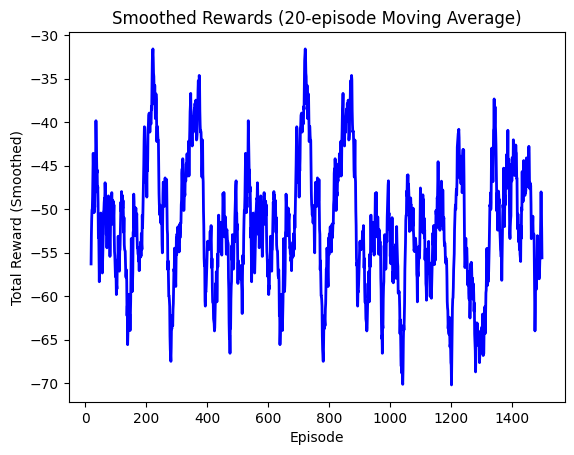

In [29]:
import pandas as pd
plt.plot(pd.Series(rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()

In [30]:
torch.save(agent.state_dict(), "ppo_traffic_model_1000.pt")


In [31]:
print("Models saved: ppo_traffic_model_latest.pt, reward_log.json, ppo_traffic_model_1000.pt")

Models saved: ppo_traffic_model_latest.pt, reward_log.json, ppo_traffic_model_1000.pt


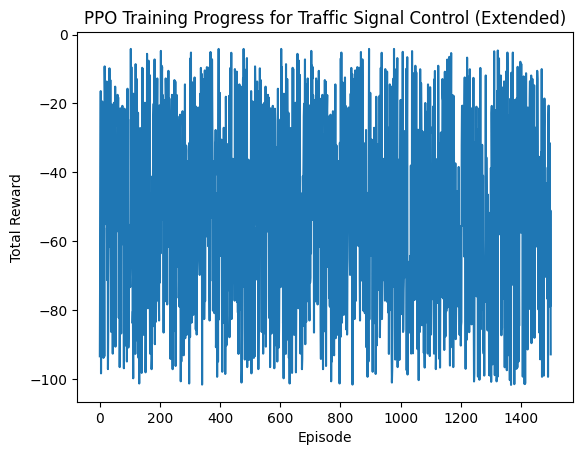

In [32]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PPO Training Progress for Traffic Signal Control (Extended)")
plt.show()

In [33]:
!pip install stable_baselines3

# Re-initialize the PPOAgent model structure
loaded_agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)

# Load the state dictionary into the agent
loaded_agent.load_state_dict(torch.load("ppo_traffic_model_1000.pt"))
loaded_agent.eval() # Set the model to evaluation mode

print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
env = TrafficEnv(data)
agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)


import torch
import json
import os
from tqdm import tqdm

def train_ppo(
    episodes=200,
    gamma=0.99,
    clip_epsilon=0.2,
    save_path="ppo_traffic_model_latest.pt",
    rewards_path="reward_log.json"
):
    reward_history = []

    # Resume from saved rewards if file exists
    if os.path.exists(rewards_path):
        with open(rewards_path, "r") as f:
            reward_history = json.load(f)
        print(f"Loaded {len(reward_history)} previous rewards from '{rewards_path}'")

    # Continue training for new episodes
    for episode in tqdm(range(len(reward_history), len(reward_history) + episodes)):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, log_prob = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)

            # PPO update
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            value = agent.critic(state_tensor)
            next_value = agent.critic(next_state_tensor)
            advantage = reward_tensor + gamma * next_value - value

            new_log_prob, _, entropy = agent.evaluate(
                state_tensor, torch.tensor([action], dtype=torch.long)
            )

            ratio = (new_log_prob - log_prob).exp()
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantage.detach()
            loss = -torch.min(surr1, surr2) + 0.5 * advantage.pow(2) - 0.01 * entropy

            agent.optimizer.zero_grad()
            loss.mean().backward()
            agent.optimizer.step()

            total_reward += reward
            state = next_state

        reward_history.append(total_reward)
        print(f"Episode {episode + 1} | Total Reward: {total_reward:.2f}")

        # Save model & rewards every 10 episodes
        if (episode + 1) % 10 == 0:
            torch.save(agent.state_dict(), save_path)
            with open(rewards_path, "w") as f:
                json.dump(reward_history, f)
            print(f"💾 Progress saved — {episode + 1} episodes complete")

    print("Training complete!")
    torch.save(agent.state_dict(), save_path)
    with open(rewards_path, "w") as f:
        json.dump(reward_history, f)

    return reward_history

In [35]:
agent.load_state_dict(torch.load("ppo_traffic_model_1000.pt"))


<All keys matched successfully>

In [36]:
''' rewards: rewards+ new_rewards+rewards_more'''

' rewards: rewards+ new_rewards+rewards_more'

In [37]:
print("Continuing training for 500 more episodes...")
new_rewards = train_ppo(episodes=500)
rewards.extend(new_rewards)
print("Training complete.")

Continuing training for 500 more episodes...
✅ Loaded 1000 previous rewards from 'reward_log.json'


  0%|          | 1/500 [00:00<07:18,  1.14it/s]

Episode 1001 | Total Reward: -27.69


  0%|          | 2/500 [00:01<04:26,  1.87it/s]

Episode 1002 | Total Reward: -10.03


  1%|          | 3/500 [00:02<07:09,  1.16it/s]

Episode 1003 | Total Reward: -40.21


  1%|          | 4/500 [00:05<14:20,  1.73s/it]

Episode 1004 | Total Reward: -98.97


  1%|          | 5/500 [00:07<14:14,  1.73s/it]

Episode 1005 | Total Reward: -53.50


  1%|          | 6/500 [00:07<10:56,  1.33s/it]

Episode 1006 | Total Reward: -15.47


  1%|▏         | 7/500 [00:09<11:10,  1.36s/it]

Episode 1007 | Total Reward: -45.10


  2%|▏         | 8/500 [00:11<13:36,  1.66s/it]

Episode 1008 | Total Reward: -74.35


  2%|▏         | 9/500 [00:14<16:39,  2.03s/it]

Episode 1009 | Total Reward: -92.66


  2%|▏         | 10/500 [00:15<14:14,  1.74s/it]

Episode 1010 | Total Reward: -34.56
💾 Progress saved — 1010 episodes complete


  2%|▏         | 11/500 [00:17<14:25,  1.77s/it]

Episode 1011 | Total Reward: -57.01


  2%|▏         | 12/500 [00:19<14:34,  1.79s/it]

Episode 1012 | Total Reward: -58.32


  3%|▎         | 13/500 [00:19<11:34,  1.43s/it]

Episode 1013 | Total Reward: -18.81


  3%|▎         | 14/500 [00:21<12:54,  1.59s/it]

Episode 1014 | Total Reward: -62.81


  3%|▎         | 15/500 [00:23<13:49,  1.71s/it]

Episode 1015 | Total Reward: -63.92


  3%|▎         | 16/500 [00:24<10:59,  1.36s/it]

Episode 1016 | Total Reward: -18.02


  3%|▎         | 17/500 [00:25<10:48,  1.34s/it]

Episode 1017 | Total Reward: -42.19


  4%|▎         | 18/500 [00:27<11:30,  1.43s/it]

Episode 1018 | Total Reward: -50.24


  4%|▍         | 19/500 [00:29<14:42,  1.83s/it]

Episode 1019 | Total Reward: -90.72


  4%|▍         | 20/500 [00:31<14:14,  1.78s/it]

Episode 1020 | Total Reward: -52.06
💾 Progress saved — 1020 episodes complete


  4%|▍         | 21/500 [00:32<12:35,  1.58s/it]

Episode 1021 | Total Reward: -35.12


  4%|▍         | 22/500 [00:34<13:29,  1.69s/it]

Episode 1022 | Total Reward: -62.76


  5%|▍         | 23/500 [00:36<13:10,  1.66s/it]

Episode 1023 | Total Reward: -50.44


  5%|▍         | 24/500 [00:37<13:07,  1.65s/it]

Episode 1024 | Total Reward: -51.00


  5%|▌         | 25/500 [00:38<09:50,  1.24s/it]

Episode 1025 | Total Reward: -9.46


  5%|▌         | 26/500 [00:39<09:30,  1.20s/it]

Episode 1026 | Total Reward: -35.89


  5%|▌         | 27/500 [00:42<13:48,  1.75s/it]

Episode 1027 | Total Reward: -100.34


  6%|▌         | 28/500 [00:43<12:58,  1.65s/it]

Episode 1028 | Total Reward: -44.04


  6%|▌         | 29/500 [00:45<12:28,  1.59s/it]

Episode 1029 | Total Reward: -46.32


  6%|▌         | 30/500 [00:47<14:51,  1.90s/it]

Episode 1030 | Total Reward: -84.86
💾 Progress saved — 1030 episodes complete


  6%|▌         | 31/500 [00:49<13:58,  1.79s/it]

Episode 1031 | Total Reward: -46.76


  6%|▋         | 32/500 [00:51<14:39,  1.88s/it]

Episode 1032 | Total Reward: -68.68


  7%|▋         | 33/500 [00:53<14:05,  1.81s/it]

Episode 1033 | Total Reward: -52.31


  7%|▋         | 34/500 [00:54<12:39,  1.63s/it]

Episode 1034 | Total Reward: -38.37


  7%|▋         | 35/500 [00:54<10:09,  1.31s/it]

Episode 1035 | Total Reward: -18.40


  7%|▋         | 36/500 [00:57<13:09,  1.70s/it]

Episode 1036 | Total Reward: -85.22


  7%|▋         | 37/500 [00:59<13:42,  1.78s/it]

Episode 1037 | Total Reward: -61.89


  8%|▊         | 38/500 [01:00<12:06,  1.57s/it]

Episode 1038 | Total Reward: -35.82


  8%|▊         | 39/500 [01:02<13:25,  1.75s/it]

Episode 1039 | Total Reward: -70.57


  8%|▊         | 40/500 [01:05<16:32,  2.16s/it]

Episode 1040 | Total Reward: -101.20
💾 Progress saved — 1040 episodes complete


  8%|▊         | 41/500 [01:07<14:25,  1.89s/it]

Episode 1041 | Total Reward: -40.19


  8%|▊         | 42/500 [01:09<16:49,  2.20s/it]

Episode 1042 | Total Reward: -95.52


  9%|▊         | 43/500 [01:11<15:16,  2.00s/it]

Episode 1043 | Total Reward: -48.98


  9%|▉         | 44/500 [01:13<14:39,  1.93s/it]

Episode 1044 | Total Reward: -56.81


  9%|▉         | 45/500 [01:15<15:11,  2.00s/it]

Episode 1045 | Total Reward: -70.29


  9%|▉         | 46/500 [01:16<13:24,  1.77s/it]

Episode 1046 | Total Reward: -39.73


  9%|▉         | 47/500 [01:18<13:15,  1.76s/it]

Episode 1047 | Total Reward: -53.76


 10%|▉         | 48/500 [01:21<15:55,  2.11s/it]

Episode 1048 | Total Reward: -96.55


 10%|▉         | 49/500 [01:23<16:58,  2.26s/it]

Episode 1049 | Total Reward: -84.46


 10%|█         | 50/500 [01:25<15:09,  2.02s/it]

Episode 1050 | Total Reward: -47.10
💾 Progress saved — 1050 episodes complete


 10%|█         | 52/500 [01:25<08:09,  1.09s/it]

Episode 1051 | Total Reward: -8.07
Episode 1052 | Total Reward: -6.47


 11%|█         | 53/500 [01:27<09:51,  1.32s/it]

Episode 1053 | Total Reward: -59.79


 11%|█         | 54/500 [01:29<11:07,  1.50s/it]

Episode 1054 | Total Reward: -59.91


 11%|█         | 55/500 [01:32<14:03,  1.90s/it]

Episode 1055 | Total Reward: -92.76


 11%|█         | 56/500 [01:33<13:20,  1.80s/it]

Episode 1056 | Total Reward: -50.01


 11%|█▏        | 57/500 [01:35<12:18,  1.67s/it]

Episode 1057 | Total Reward: -43.91


 12%|█▏        | 58/500 [01:37<12:34,  1.71s/it]

Episode 1058 | Total Reward: -57.76


 12%|█▏        | 59/500 [01:37<10:31,  1.43s/it]

Episode 1059 | Total Reward: -24.83


 12%|█▏        | 60/500 [01:38<08:01,  1.10s/it]

Episode 1060 | Total Reward: -10.10
💾 Progress saved — 1060 episodes complete


 12%|█▏        | 61/500 [01:40<09:58,  1.36s/it]

Episode 1061 | Total Reward: -63.47


 12%|█▏        | 62/500 [01:42<12:06,  1.66s/it]

Episode 1062 | Total Reward: -76.88


 13%|█▎        | 63/500 [01:42<08:55,  1.22s/it]

Episode 1063 | Total Reward: -7.45


 13%|█▎        | 64/500 [01:44<10:25,  1.43s/it]

Episode 1064 | Total Reward: -61.58


 13%|█▎        | 65/500 [01:45<08:51,  1.22s/it]

Episode 1065 | Total Reward: -23.93


 13%|█▎        | 66/500 [01:48<12:24,  1.72s/it]

Episode 1066 | Total Reward: -92.59


 13%|█▎        | 67/500 [01:51<14:47,  2.05s/it]

Episode 1067 | Total Reward: -92.33


 14%|█▎        | 68/500 [01:52<13:20,  1.85s/it]

Episode 1068 | Total Reward: -44.95


 14%|█▍        | 69/500 [01:52<09:56,  1.38s/it]

Episode 1069 | Total Reward: -9.85


 14%|█▍        | 70/500 [01:53<07:40,  1.07s/it]

Episode 1070 | Total Reward: -11.70
💾 Progress saved — 1070 episodes complete


 14%|█▍        | 71/500 [01:55<10:32,  1.47s/it]

Episode 1071 | Total Reward: -77.44


 14%|█▍        | 72/500 [01:58<13:43,  1.92s/it]

Episode 1072 | Total Reward: -97.04


 15%|█▍        | 73/500 [02:00<13:51,  1.95s/it]

Episode 1073 | Total Reward: -63.50


 15%|█▍        | 74/500 [02:03<15:00,  2.11s/it]

Episode 1074 | Total Reward: -83.51


 15%|█▌        | 75/500 [02:03<12:25,  1.75s/it]

Episode 1075 | Total Reward: -28.87


 15%|█▌        | 76/500 [02:05<11:44,  1.66s/it]

Episode 1076 | Total Reward: -45.97


 16%|█▌        | 78/500 [02:08<09:58,  1.42s/it]

Episode 1077 | Total Reward: -88.38
Episode 1078 | Total Reward: -5.29


 16%|█▌        | 79/500 [02:08<08:13,  1.17s/it]

Episode 1079 | Total Reward: -18.38


 16%|█▌        | 80/500 [02:11<10:54,  1.56s/it]

Episode 1080 | Total Reward: -80.11
💾 Progress saved — 1080 episodes complete


 16%|█▌        | 81/500 [02:12<10:15,  1.47s/it]

Episode 1081 | Total Reward: -40.74


 16%|█▋        | 82/500 [02:14<10:38,  1.53s/it]

Episode 1082 | Total Reward: -52.61


 17%|█▋        | 83/500 [02:15<09:19,  1.34s/it]

Episode 1083 | Total Reward: -28.64


 17%|█▋        | 85/500 [02:16<07:05,  1.03s/it]

Episode 1084 | Total Reward: -48.47
Episode 1085 | Total Reward: -5.06


 17%|█▋        | 86/500 [02:18<08:10,  1.18s/it]

Episode 1086 | Total Reward: -49.21


 17%|█▋        | 87/500 [02:19<07:31,  1.09s/it]

Episode 1087 | Total Reward: -26.86


 18%|█▊        | 88/500 [02:21<10:34,  1.54s/it]

Episode 1088 | Total Reward: -83.75


 18%|█▊        | 89/500 [02:24<12:53,  1.88s/it]

Episode 1089 | Total Reward: -87.62


 18%|█▊        | 90/500 [02:25<11:52,  1.74s/it]

Episode 1090 | Total Reward: -45.40
💾 Progress saved — 1090 episodes complete


 18%|█▊        | 91/500 [02:27<10:51,  1.59s/it]

Episode 1091 | Total Reward: -39.77


 18%|█▊        | 92/500 [02:28<09:24,  1.38s/it]

Episode 1092 | Total Reward: -28.74


 19%|█▊        | 93/500 [02:28<08:27,  1.25s/it]

Episode 1093 | Total Reward: -28.50


 19%|█▉        | 94/500 [02:32<12:07,  1.79s/it]

Episode 1094 | Total Reward: -99.25


 19%|█▉        | 95/500 [02:34<12:58,  1.92s/it]

Episode 1095 | Total Reward: -72.35


 19%|█▉        | 96/500 [02:34<09:51,  1.46s/it]

Episode 1096 | Total Reward: -13.21


 19%|█▉        | 97/500 [02:36<10:30,  1.56s/it]

Episode 1097 | Total Reward: -58.32


 20%|█▉        | 98/500 [02:39<12:34,  1.88s/it]

Episode 1098 | Total Reward: -84.40


 20%|█▉        | 99/500 [02:41<13:30,  2.02s/it]

Episode 1099 | Total Reward: -76.68


 20%|██        | 100/500 [02:42<11:52,  1.78s/it]

Episode 1100 | Total Reward: -39.46
💾 Progress saved — 1100 episodes complete


 20%|██        | 101/500 [02:44<12:52,  1.94s/it]

Episode 1101 | Total Reward: -73.29


 20%|██        | 102/500 [02:47<14:55,  2.25s/it]

Episode 1102 | Total Reward: -98.28


 21%|██        | 103/500 [02:49<14:01,  2.12s/it]

Episode 1103 | Total Reward: -56.10


 21%|██        | 104/500 [02:51<13:50,  2.10s/it]

Episode 1104 | Total Reward: -67.07


 21%|██        | 105/500 [02:52<11:55,  1.81s/it]

Episode 1105 | Total Reward: -37.37


 21%|██        | 106/500 [02:54<11:14,  1.71s/it]

Episode 1106 | Total Reward: -46.40


 21%|██▏       | 107/500 [02:56<12:12,  1.86s/it]

Episode 1107 | Total Reward: -71.66


 22%|██▏       | 108/500 [02:59<13:34,  2.08s/it]

Episode 1108 | Total Reward: -84.65


 22%|██▏       | 109/500 [02:59<10:05,  1.55s/it]

Episode 1109 | Total Reward: -10.00


 22%|██▏       | 110/500 [03:00<09:31,  1.46s/it]

Episode 1110 | Total Reward: -40.19
💾 Progress saved — 1110 episodes complete


 22%|██▏       | 111/500 [03:03<12:24,  1.91s/it]

Episode 1111 | Total Reward: -98.39


 22%|██▏       | 112/500 [03:06<14:21,  2.22s/it]

Episode 1112 | Total Reward: -95.05


 23%|██▎       | 113/500 [03:09<14:31,  2.25s/it]

Episode 1113 | Total Reward: -76.73


 23%|██▎       | 114/500 [03:11<15:30,  2.41s/it]

Episode 1114 | Total Reward: -88.74


 23%|██▎       | 115/500 [03:13<14:45,  2.30s/it]

Episode 1115 | Total Reward: -66.48


 23%|██▎       | 116/500 [03:15<14:00,  2.19s/it]

Episode 1116 | Total Reward: -61.46


 23%|██▎       | 117/500 [03:17<12:53,  2.02s/it]

Episode 1117 | Total Reward: -51.47


 24%|██▎       | 118/500 [03:17<10:00,  1.57s/it]

Episode 1118 | Total Reward: -17.40


 24%|██▍       | 119/500 [03:19<09:42,  1.53s/it]

Episode 1119 | Total Reward: -45.68


 24%|██▍       | 120/500 [03:20<08:17,  1.31s/it]

Episode 1120 | Total Reward: -25.10
💾 Progress saved — 1120 episodes complete


 24%|██▍       | 121/500 [03:22<11:13,  1.78s/it]

Episode 1121 | Total Reward: -93.51


 24%|██▍       | 122/500 [03:23<08:31,  1.35s/it]

Episode 1122 | Total Reward: -12.23


 25%|██▍       | 123/500 [03:25<09:51,  1.57s/it]

Episode 1123 | Total Reward: -66.58


 25%|██▍       | 124/500 [03:25<07:47,  1.24s/it]

Episode 1124 | Total Reward: -16.15


 25%|██▌       | 125/500 [03:28<10:42,  1.71s/it]

Episode 1125 | Total Reward: -92.33


 25%|██▌       | 126/500 [03:31<12:29,  2.00s/it]

Episode 1126 | Total Reward: -85.62


 25%|██▌       | 127/500 [03:34<13:39,  2.20s/it]

Episode 1127 | Total Reward: -85.69


 26%|██▌       | 128/500 [03:37<15:03,  2.43s/it]

Episode 1128 | Total Reward: -97.91


 26%|██▌       | 129/500 [03:38<12:35,  2.04s/it]

Episode 1129 | Total Reward: -35.65


 26%|██▌       | 130/500 [03:40<13:37,  2.21s/it]

Episode 1130 | Total Reward: -84.40
💾 Progress saved — 1130 episodes complete


 26%|██▌       | 131/500 [03:41<09:58,  1.62s/it]

Episode 1131 | Total Reward: -8.53


 26%|██▋       | 132/500 [03:42<09:46,  1.59s/it]

Episode 1132 | Total Reward: -49.38


 27%|██▋       | 133/500 [03:43<08:30,  1.39s/it]

Episode 1133 | Total Reward: -28.96


 27%|██▋       | 134/500 [03:44<08:35,  1.41s/it]

Episode 1134 | Total Reward: -46.47


 27%|██▋       | 135/500 [03:46<09:12,  1.51s/it]

Episode 1135 | Total Reward: -55.63


 27%|██▋       | 136/500 [03:48<09:33,  1.58s/it]

Episode 1136 | Total Reward: -54.30


 27%|██▋       | 137/500 [03:51<12:13,  2.02s/it]

Episode 1137 | Total Reward: -98.18


 28%|██▊       | 138/500 [03:51<09:20,  1.55s/it]

Episode 1138 | Total Reward: -14.53


 28%|██▊       | 139/500 [03:54<10:45,  1.79s/it]

Episode 1139 | Total Reward: -75.86


 28%|██▊       | 140/500 [03:57<12:57,  2.16s/it]

Episode 1140 | Total Reward: -99.31
💾 Progress saved — 1140 episodes complete


 28%|██▊       | 141/500 [03:57<09:33,  1.60s/it]

Episode 1141 | Total Reward: -9.46


 28%|██▊       | 142/500 [03:58<08:11,  1.37s/it]

Episode 1142 | Total Reward: -27.22


 29%|██▊       | 143/500 [03:59<08:03,  1.36s/it]

Episode 1143 | Total Reward: -41.48


 29%|██▉       | 144/500 [04:01<09:13,  1.56s/it]

Episode 1144 | Total Reward: -64.62


 29%|██▉       | 145/500 [04:02<07:26,  1.26s/it]

Episode 1145 | Total Reward: -18.38


 29%|██▉       | 146/500 [04:04<08:14,  1.40s/it]

Episode 1146 | Total Reward: -55.48


 29%|██▉       | 147/500 [04:05<07:32,  1.28s/it]

Episode 1147 | Total Reward: -31.72


 30%|██▉       | 148/500 [04:07<09:54,  1.69s/it]

Episode 1148 | Total Reward: -86.45


 30%|██▉       | 149/500 [04:09<10:11,  1.74s/it]

Episode 1149 | Total Reward: -60.85


 30%|███       | 150/500 [04:10<09:26,  1.62s/it]

Episode 1150 | Total Reward: -40.39
💾 Progress saved — 1150 episodes complete


 30%|███       | 151/500 [04:11<07:33,  1.30s/it]

Episode 1151 | Total Reward: -18.18


 30%|███       | 152/500 [04:13<09:00,  1.55s/it]

Episode 1152 | Total Reward: -70.38


 31%|███       | 153/500 [04:15<09:02,  1.56s/it]

Episode 1153 | Total Reward: -50.48


 31%|███       | 154/500 [04:16<08:54,  1.54s/it]

Episode 1154 | Total Reward: -46.93


 31%|███       | 155/500 [04:17<08:05,  1.41s/it]

Episode 1155 | Total Reward: -35.10


 31%|███       | 156/500 [04:18<07:40,  1.34s/it]

Episode 1156 | Total Reward: -38.07


 31%|███▏      | 157/500 [04:20<08:53,  1.55s/it]

Episode 1157 | Total Reward: -64.18


 32%|███▏      | 158/500 [04:22<09:05,  1.59s/it]

Episode 1158 | Total Reward: -53.32


 32%|███▏      | 159/500 [04:23<08:22,  1.47s/it]

Episode 1159 | Total Reward: -39.05


 32%|███▏      | 160/500 [04:25<08:45,  1.55s/it]

Episode 1160 | Total Reward: -54.62
💾 Progress saved — 1160 episodes complete


 32%|███▏      | 161/500 [04:28<10:22,  1.84s/it]

Episode 1161 | Total Reward: -82.19


 32%|███▏      | 162/500 [04:30<12:01,  2.14s/it]

Episode 1162 | Total Reward: -91.71


 33%|███▎      | 163/500 [04:33<12:07,  2.16s/it]

Episode 1163 | Total Reward: -71.24


 33%|███▎      | 164/500 [04:34<11:31,  2.06s/it]

Episode 1164 | Total Reward: -58.63


 33%|███▎      | 165/500 [04:35<09:42,  1.74s/it]

Episode 1165 | Total Reward: -31.41


 33%|███▎      | 166/500 [04:38<11:38,  2.09s/it]

Episode 1166 | Total Reward: -95.26


 33%|███▎      | 167/500 [04:41<12:15,  2.21s/it]

Episode 1167 | Total Reward: -80.25


 34%|███▎      | 168/500 [04:42<09:54,  1.79s/it]

Episode 1168 | Total Reward: -26.93


 34%|███▍      | 169/500 [04:44<10:12,  1.85s/it]

Episode 1169 | Total Reward: -64.18


 34%|███▍      | 170/500 [04:45<09:20,  1.70s/it]

Episode 1170 | Total Reward: -43.04
💾 Progress saved — 1170 episodes complete


 34%|███▍      | 171/500 [04:47<09:10,  1.67s/it]

Episode 1171 | Total Reward: -51.24


 34%|███▍      | 172/500 [04:49<10:11,  1.87s/it]

Episode 1172 | Total Reward: -75.22


 35%|███▍      | 174/500 [04:51<07:16,  1.34s/it]

Episode 1173 | Total Reward: -55.78
Episode 1174 | Total Reward: -6.24


 35%|███▌      | 175/500 [04:53<08:28,  1.56s/it]

Episode 1175 | Total Reward: -68.04


 35%|███▌      | 176/500 [04:56<10:49,  2.00s/it]

Episode 1176 | Total Reward: -99.25


 35%|███▌      | 177/500 [04:57<08:26,  1.57s/it]

Episode 1177 | Total Reward: -17.65


 36%|███▌      | 178/500 [04:58<08:51,  1.65s/it]

Episode 1178 | Total Reward: -59.65


 36%|███▌      | 179/500 [05:00<08:43,  1.63s/it]

Episode 1179 | Total Reward: -50.33


 36%|███▌      | 180/500 [05:02<08:39,  1.62s/it]

Episode 1180 | Total Reward: -49.64
💾 Progress saved — 1180 episodes complete


 36%|███▌      | 181/500 [05:02<06:51,  1.29s/it]

Episode 1181 | Total Reward: -17.05


 36%|███▋      | 182/500 [05:03<06:50,  1.29s/it]

Episode 1182 | Total Reward: -41.41


 37%|███▋      | 183/500 [05:04<06:15,  1.18s/it]

Episode 1183 | Total Reward: -29.19


 37%|███▋      | 184/500 [05:07<09:03,  1.72s/it]

Episode 1184 | Total Reward: -98.12


 37%|███▋      | 185/500 [05:08<07:50,  1.49s/it]

Episode 1185 | Total Reward: -31.33


 37%|███▋      | 186/500 [05:10<08:19,  1.59s/it]

Episode 1186 | Total Reward: -57.40


 37%|███▋      | 187/500 [05:12<08:29,  1.63s/it]

Episode 1187 | Total Reward: -53.20


 38%|███▊      | 188/500 [05:14<08:49,  1.70s/it]

Episode 1188 | Total Reward: -59.96


 38%|███▊      | 189/500 [05:16<10:32,  2.03s/it]

Episode 1189 | Total Reward: -91.37


 38%|███▊      | 190/500 [05:19<10:38,  2.06s/it]

Episode 1190 | Total Reward: -69.33
💾 Progress saved — 1190 episodes complete


 38%|███▊      | 191/500 [05:21<10:57,  2.13s/it]

Episode 1191 | Total Reward: -73.32


 38%|███▊      | 192/500 [05:21<08:00,  1.56s/it]

Episode 1192 | Total Reward: -6.77


 39%|███▊      | 193/500 [05:24<09:31,  1.86s/it]

Episode 1193 | Total Reward: -84.14


 39%|███▉      | 194/500 [05:27<11:21,  2.23s/it]

Episode 1194 | Total Reward: -99.91


 39%|███▉      | 195/500 [05:29<11:11,  2.20s/it]

Episode 1195 | Total Reward: -70.38


 39%|███▉      | 196/500 [05:32<11:56,  2.36s/it]

Episode 1196 | Total Reward: -87.14


 39%|███▉      | 197/500 [05:34<11:15,  2.23s/it]

Episode 1197 | Total Reward: -62.56


 40%|███▉      | 198/500 [05:37<12:29,  2.48s/it]

Episode 1198 | Total Reward: -100.58


 40%|███▉      | 199/500 [05:38<11:27,  2.28s/it]

Episode 1199 | Total Reward: -58.91


 40%|████      | 200/500 [05:40<09:58,  2.00s/it]

Episode 1200 | Total Reward: -42.31
💾 Progress saved — 1200 episodes complete


 40%|████      | 201/500 [05:42<10:54,  2.19s/it]

Episode 1201 | Total Reward: -86.73


 40%|████      | 202/500 [05:45<11:35,  2.33s/it]

Episode 1202 | Total Reward: -87.19


 41%|████      | 203/500 [05:46<09:00,  1.82s/it]

Episode 1203 | Total Reward: -19.71


 41%|████      | 204/500 [05:46<07:22,  1.50s/it]

Episode 1204 | Total Reward: -24.39


 41%|████      | 205/500 [05:49<08:46,  1.79s/it]

Episode 1205 | Total Reward: -80.49


 41%|████      | 206/500 [05:51<09:36,  1.96s/it]

Episode 1206 | Total Reward: -77.89


 41%|████▏     | 207/500 [05:54<10:37,  2.18s/it]

Episode 1207 | Total Reward: -86.73


 42%|████▏     | 208/500 [05:57<11:26,  2.35s/it]

Episode 1208 | Total Reward: -90.17


 42%|████▏     | 209/500 [05:57<08:36,  1.77s/it]

Episode 1209 | Total Reward: -14.36


 42%|████▏     | 210/500 [05:59<09:15,  1.91s/it]

Episode 1210 | Total Reward: -72.60
💾 Progress saved — 1210 episodes complete


 42%|████▏     | 211/500 [06:00<07:35,  1.58s/it]

Episode 1211 | Total Reward: -25.63


 42%|████▏     | 212/500 [06:01<05:58,  1.25s/it]

Episode 1212 | Total Reward: -15.89


 43%|████▎     | 213/500 [06:02<06:13,  1.30s/it]

Episode 1213 | Total Reward: -45.10


 43%|████▎     | 214/500 [06:04<06:45,  1.42s/it]

Episode 1214 | Total Reward: -54.30


 43%|████▎     | 215/500 [06:05<06:01,  1.27s/it]

Episode 1215 | Total Reward: -28.32


 43%|████▎     | 216/500 [06:06<06:34,  1.39s/it]

Episode 1216 | Total Reward: -52.95


 43%|████▎     | 217/500 [06:08<06:36,  1.40s/it]

Episode 1217 | Total Reward: -46.04


 44%|████▎     | 218/500 [06:08<05:16,  1.12s/it]

Episode 1218 | Total Reward: -15.22


 44%|████▍     | 219/500 [06:09<04:18,  1.09it/s]

Episode 1219 | Total Reward: -14.62


 44%|████▍     | 220/500 [06:11<06:20,  1.36s/it]

Episode 1220 | Total Reward: -76.81
💾 Progress saved — 1220 episodes complete


 44%|████▍     | 221/500 [06:14<07:52,  1.69s/it]

Episode 1221 | Total Reward: -79.90


 44%|████▍     | 222/500 [06:15<07:01,  1.51s/it]

Episode 1222 | Total Reward: -35.41


 45%|████▍     | 223/500 [06:16<07:11,  1.56s/it]

Episode 1223 | Total Reward: -51.76


 45%|████▍     | 224/500 [06:17<06:31,  1.42s/it]

Episode 1224 | Total Reward: -34.32


 45%|████▌     | 225/500 [06:18<05:00,  1.09s/it]

Episode 1225 | Total Reward: -11.70


 45%|████▌     | 226/500 [06:20<05:56,  1.30s/it]

Episode 1226 | Total Reward: -56.32


 45%|████▌     | 227/500 [06:21<06:29,  1.43s/it]

Episode 1227 | Total Reward: -53.32


 46%|████▌     | 228/500 [06:23<06:51,  1.51s/it]

Episode 1228 | Total Reward: -53.40


 46%|████▌     | 229/500 [06:25<07:10,  1.59s/it]

Episode 1229 | Total Reward: -56.32


 46%|████▌     | 230/500 [06:27<08:44,  1.94s/it]

Episode 1230 | Total Reward: -90.68
💾 Progress saved — 1230 episodes complete


 46%|████▌     | 231/500 [06:31<10:11,  2.28s/it]

Episode 1231 | Total Reward: -100.63


 46%|████▋     | 232/500 [06:33<09:47,  2.19s/it]

Episode 1232 | Total Reward: -62.57


 47%|████▋     | 233/500 [06:35<10:40,  2.40s/it]

Episode 1233 | Total Reward: -94.88


 47%|████▋     | 234/500 [06:36<08:35,  1.94s/it]

Episode 1234 | Total Reward: -27.56


 47%|████▋     | 235/500 [06:39<09:15,  2.10s/it]

Episode 1235 | Total Reward: -80.01


 47%|████▋     | 236/500 [06:42<10:18,  2.34s/it]

Episode 1236 | Total Reward: -96.04


 47%|████▋     | 237/500 [06:43<08:36,  1.96s/it]

Episode 1237 | Total Reward: -32.31


 48%|████▊     | 238/500 [06:43<06:29,  1.49s/it]

Episode 1238 | Total Reward: -12.14


 48%|████▊     | 239/500 [06:45<07:29,  1.72s/it]

Episode 1239 | Total Reward: -73.67


 48%|████▊     | 240/500 [06:47<07:56,  1.83s/it]

Episode 1240 | Total Reward: -67.94
💾 Progress saved — 1240 episodes complete


 48%|████▊     | 241/500 [06:48<06:10,  1.43s/it]

Episode 1241 | Total Reward: -15.22


 48%|████▊     | 242/500 [06:50<07:32,  1.75s/it]

Episode 1242 | Total Reward: -82.22


 49%|████▊     | 243/500 [06:52<07:10,  1.67s/it]

Episode 1243 | Total Reward: -47.17


 49%|████▉     | 244/500 [06:54<07:56,  1.86s/it]

Episode 1244 | Total Reward: -73.29


 49%|████▉     | 245/500 [06:55<06:45,  1.59s/it]

Episode 1245 | Total Reward: -30.52


 49%|████▉     | 246/500 [06:58<07:49,  1.85s/it]

Episode 1246 | Total Reward: -80.49


 49%|████▉     | 247/500 [06:59<07:36,  1.81s/it]

Episode 1247 | Total Reward: -54.07


 50%|████▉     | 248/500 [07:02<09:04,  2.16s/it]

Episode 1248 | Total Reward: -97.85


 50%|████▉     | 249/500 [07:03<06:41,  1.60s/it]

Episode 1249 | Total Reward: -9.65


 50%|█████     | 250/500 [07:04<06:11,  1.49s/it]

Episode 1250 | Total Reward: -39.39
💾 Progress saved — 1250 episodes complete


 50%|█████     | 251/500 [07:06<07:12,  1.74s/it]

Episode 1251 | Total Reward: -74.80


 50%|█████     | 252/500 [07:09<07:56,  1.92s/it]

Episode 1252 | Total Reward: -76.88


 51%|█████     | 253/500 [07:09<06:11,  1.50s/it]

Episode 1253 | Total Reward: -17.53


 51%|█████     | 254/500 [07:12<07:51,  1.92s/it]

Episode 1254 | Total Reward: -93.99


 51%|█████     | 255/500 [07:15<08:53,  2.18s/it]

Episode 1255 | Total Reward: -91.14


 51%|█████     | 256/500 [07:17<09:08,  2.25s/it]

Episode 1256 | Total Reward: -77.36


 51%|█████▏    | 257/500 [07:19<08:34,  2.12s/it]

Episode 1257 | Total Reward: -57.45


 52%|█████▏    | 258/500 [07:21<08:01,  1.99s/it]

Episode 1258 | Total Reward: -53.08


 52%|█████▏    | 259/500 [07:23<07:48,  1.95s/it]

Episode 1259 | Total Reward: -58.74


 52%|█████▏    | 260/500 [07:25<08:41,  2.17s/it]

Episode 1260 | Total Reward: -88.11
💾 Progress saved — 1260 episodes complete


 52%|█████▏    | 261/500 [07:27<08:42,  2.18s/it]

Episode 1261 | Total Reward: -71.02


 52%|█████▏    | 262/500 [07:29<07:31,  1.90s/it]

Episode 1262 | Total Reward: -39.49


 53%|█████▎    | 263/500 [07:32<08:46,  2.22s/it]

Episode 1263 | Total Reward: -97.10


 53%|█████▎    | 264/500 [07:35<09:34,  2.43s/it]

Episode 1264 | Total Reward: -94.87


 53%|█████▎    | 265/500 [07:38<10:08,  2.59s/it]

Episode 1265 | Total Reward: -96.88


 53%|█████▎    | 266/500 [07:38<07:30,  1.93s/it]

Episode 1266 | Total Reward: -12.79


 53%|█████▎    | 267/500 [07:38<05:55,  1.53s/it]

Episode 1267 | Total Reward: -18.69


 54%|█████▎    | 268/500 [07:39<04:56,  1.28s/it]

Episode 1268 | Total Reward: -22.77


 54%|█████▍    | 269/500 [07:41<06:03,  1.57s/it]

Episode 1269 | Total Reward: -73.32


 54%|█████▍    | 270/500 [07:42<04:58,  1.30s/it]

Episode 1270 | Total Reward: -20.99
💾 Progress saved — 1270 episodes complete


 54%|█████▍    | 271/500 [07:44<05:25,  1.42s/it]

Episode 1271 | Total Reward: -52.07


 55%|█████▍    | 273/500 [07:45<03:49,  1.01s/it]

Episode 1272 | Total Reward: -40.61
Episode 1273 | Total Reward: -5.60


 55%|█████▍    | 274/500 [07:48<05:14,  1.39s/it]

Episode 1274 | Total Reward: -74.16


 55%|█████▌    | 275/500 [07:48<04:26,  1.19s/it]

Episode 1275 | Total Reward: -21.58


 55%|█████▌    | 276/500 [07:50<04:49,  1.29s/it]

Episode 1276 | Total Reward: -49.45


 55%|█████▌    | 277/500 [07:53<06:42,  1.81s/it]

Episode 1277 | Total Reward: -98.95


 56%|█████▌    | 278/500 [07:54<06:30,  1.76s/it]

Episode 1278 | Total Reward: -51.10


 56%|█████▌    | 279/500 [07:57<07:02,  1.91s/it]

Episode 1279 | Total Reward: -74.65


 56%|█████▌    | 280/500 [07:58<06:32,  1.78s/it]

Episode 1280 | Total Reward: -46.86
💾 Progress saved — 1280 episodes complete


 56%|█████▌    | 281/500 [07:59<05:33,  1.52s/it]

Episode 1281 | Total Reward: -28.42


 56%|█████▋    | 282/500 [08:02<06:52,  1.89s/it]

Episode 1282 | Total Reward: -91.07


 57%|█████▋    | 283/500 [08:04<06:35,  1.82s/it]

Episode 1283 | Total Reward: -52.02


 57%|█████▋    | 284/500 [08:05<06:35,  1.83s/it]

Episode 1284 | Total Reward: -58.88


 57%|█████▋    | 285/500 [08:07<06:12,  1.73s/it]

Episode 1285 | Total Reward: -48.69


 57%|█████▋    | 286/500 [08:09<06:13,  1.74s/it]

Episode 1286 | Total Reward: -56.14


 57%|█████▋    | 287/500 [08:11<06:46,  1.91s/it]

Episode 1287 | Total Reward: -73.23


 58%|█████▊    | 288/500 [08:13<07:11,  2.04s/it]

Episode 1288 | Total Reward: -76.40


 58%|█████▊    | 289/500 [08:15<06:46,  1.93s/it]

Episode 1289 | Total Reward: -51.96


 58%|█████▊    | 291/500 [08:16<04:26,  1.27s/it]

Episode 1290 | Total Reward: -43.82
💾 Progress saved — 1290 episodes complete
Episode 1291 | Total Reward: -4.46


 58%|█████▊    | 292/500 [08:18<04:16,  1.23s/it]

Episode 1292 | Total Reward: -36.05


 59%|█████▊    | 293/500 [08:19<04:24,  1.28s/it]

Episode 1293 | Total Reward: -43.79


 59%|█████▉    | 294/500 [08:20<03:40,  1.07s/it]

Episode 1294 | Total Reward: -18.68


 59%|█████▉    | 295/500 [08:22<04:50,  1.42s/it]

Episode 1295 | Total Reward: -71.77


 59%|█████▉    | 296/500 [08:23<05:04,  1.49s/it]

Episode 1296 | Total Reward: -52.31


 59%|█████▉    | 297/500 [08:26<06:28,  1.91s/it]

Episode 1297 | Total Reward: -94.12


 60%|█████▉    | 298/500 [08:29<07:38,  2.27s/it]

Episode 1298 | Total Reward: -101.69


 60%|█████▉    | 299/500 [08:32<08:15,  2.47s/it]

Episode 1299 | Total Reward: -94.50


 60%|██████    | 300/500 [08:35<08:36,  2.58s/it]

Episode 1300 | Total Reward: -93.28
💾 Progress saved — 1300 episodes complete


 60%|██████    | 301/500 [08:38<08:51,  2.67s/it]

Episode 1301 | Total Reward: -93.39


 60%|██████    | 302/500 [08:39<07:28,  2.27s/it]

Episode 1302 | Total Reward: -42.50


 61%|██████    | 303/500 [08:40<05:27,  1.66s/it]

Episode 1303 | Total Reward: -9.24


 61%|██████    | 304/500 [08:40<04:21,  1.34s/it]

Episode 1304 | Total Reward: -18.50


 61%|██████    | 305/500 [08:41<03:33,  1.09s/it]

Episode 1305 | Total Reward: -17.19


 61%|██████    | 306/500 [08:43<04:50,  1.50s/it]

Episode 1306 | Total Reward: -77.72


 61%|██████▏   | 307/500 [08:44<04:04,  1.26s/it]

Episode 1307 | Total Reward: -23.49


 62%|██████▏   | 308/500 [08:44<03:04,  1.04it/s]

Episode 1308 | Total Reward: -8.01


 62%|██████▏   | 309/500 [08:45<02:27,  1.29it/s]

Episode 1309 | Total Reward: -11.23


 62%|██████▏   | 310/500 [08:45<02:14,  1.41it/s]

Episode 1310 | Total Reward: -18.18
💾 Progress saved — 1310 episodes complete


 62%|██████▏   | 311/500 [08:46<02:34,  1.23it/s]

Episode 1311 | Total Reward: -32.72


 62%|██████▏   | 312/500 [08:48<03:24,  1.09s/it]

Episode 1312 | Total Reward: -52.02


 63%|██████▎   | 313/500 [08:50<04:31,  1.45s/it]

Episode 1313 | Total Reward: -63.69


 63%|██████▎   | 314/500 [08:51<04:06,  1.33s/it]

Episode 1314 | Total Reward: -31.81


 63%|██████▎   | 315/500 [08:53<04:27,  1.45s/it]

Episode 1315 | Total Reward: -55.06


 63%|██████▎   | 316/500 [08:54<03:49,  1.25s/it]

Episode 1316 | Total Reward: -24.39


 63%|██████▎   | 317/500 [08:54<02:52,  1.06it/s]

Episode 1317 | Total Reward: -8.73


 64%|██████▎   | 318/500 [08:56<03:25,  1.13s/it]

Episode 1318 | Total Reward: -48.63


 64%|██████▍   | 319/500 [08:56<02:41,  1.12it/s]

Episode 1319 | Total Reward: -11.12


 64%|██████▍   | 320/500 [08:56<02:03,  1.46it/s]

Episode 1320 | Total Reward: -7.59
💾 Progress saved — 1320 episodes complete


 64%|██████▍   | 321/500 [08:58<03:01,  1.02s/it]

Episode 1321 | Total Reward: -56.96


 64%|██████▍   | 322/500 [08:59<02:55,  1.01it/s]

Episode 1322 | Total Reward: -28.12


 65%|██████▍   | 324/500 [09:01<02:56,  1.00s/it]

Episode 1323 | Total Reward: -73.29
Episode 1324 | Total Reward: -4.95


 65%|██████▌   | 325/500 [09:03<03:29,  1.20s/it]

Episode 1325 | Total Reward: -52.56


 65%|██████▌   | 326/500 [09:06<05:00,  1.73s/it]

Episode 1326 | Total Reward: -94.06


 65%|██████▌   | 327/500 [09:08<05:03,  1.75s/it]

Episode 1327 | Total Reward: -58.38


 66%|██████▌   | 328/500 [09:10<05:09,  1.80s/it]

Episode 1328 | Total Reward: -60.85


 66%|██████▌   | 329/500 [09:12<05:33,  1.95s/it]

Episode 1329 | Total Reward: -74.35


 66%|██████▌   | 330/500 [09:14<05:56,  2.10s/it]

Episode 1330 | Total Reward: -79.76
💾 Progress saved — 1330 episodes complete


 66%|██████▌   | 331/500 [09:15<04:51,  1.72s/it]

Episode 1331 | Total Reward: -26.42


 66%|██████▋   | 332/500 [09:17<04:56,  1.76s/it]

Episode 1332 | Total Reward: -59.47


 67%|██████▋   | 333/500 [09:18<04:34,  1.64s/it]

Episode 1333 | Total Reward: -43.26


 67%|██████▋   | 334/500 [09:19<04:05,  1.48s/it]

Episode 1334 | Total Reward: -34.22


 67%|██████▋   | 335/500 [09:20<03:14,  1.18s/it]

Episode 1335 | Total Reward: -16.01


 67%|██████▋   | 336/500 [09:21<03:01,  1.11s/it]

Episode 1336 | Total Reward: -28.96


 68%|██████▊   | 338/500 [09:22<01:54,  1.41it/s]

Episode 1337 | Total Reward: -18.66
Episode 1338 | Total Reward: -5.23


 68%|██████▊   | 339/500 [09:24<03:21,  1.25s/it]

Episode 1339 | Total Reward: -82.19


 68%|██████▊   | 340/500 [09:25<03:04,  1.15s/it]

Episode 1340 | Total Reward: -28.87
💾 Progress saved — 1340 episodes complete


 68%|██████▊   | 341/500 [09:27<03:57,  1.49s/it]

Episode 1341 | Total Reward: -73.29


 68%|██████▊   | 342/500 [09:30<04:30,  1.71s/it]

Episode 1342 | Total Reward: -71.24


 69%|██████▊   | 343/500 [09:32<05:05,  1.95s/it]

Episode 1343 | Total Reward: -80.25


 69%|██████▉   | 344/500 [09:33<03:57,  1.52s/it]

Episode 1344 | Total Reward: -17.29


 69%|██████▉   | 345/500 [09:35<04:26,  1.72s/it]

Episode 1345 | Total Reward: -70.46


 69%|██████▉   | 347/500 [09:37<03:38,  1.43s/it]

Episode 1346 | Total Reward: -81.25
Episode 1347 | Total Reward: -5.77


 70%|██████▉   | 348/500 [09:39<03:38,  1.44s/it]

Episode 1348 | Total Reward: -46.24


 70%|██████▉   | 349/500 [09:41<04:24,  1.75s/it]

Episode 1349 | Total Reward: -81.17


 70%|███████   | 350/500 [09:44<05:08,  2.06s/it]

Episode 1350 | Total Reward: -89.45
💾 Progress saved — 1350 episodes complete


 70%|███████   | 351/500 [09:45<04:06,  1.66s/it]

Episode 1351 | Total Reward: -22.71


 70%|███████   | 352/500 [09:48<04:50,  1.96s/it]

Episode 1352 | Total Reward: -87.19


 71%|███████   | 353/500 [09:48<03:52,  1.58s/it]

Episode 1353 | Total Reward: -21.17


 71%|███████   | 354/500 [09:50<04:01,  1.66s/it]

Episode 1354 | Total Reward: -58.91


 71%|███████   | 355/500 [09:52<04:06,  1.70s/it]

Episode 1355 | Total Reward: -58.32


 71%|███████   | 356/500 [09:54<04:12,  1.75s/it]

Episode 1356 | Total Reward: -59.60


 71%|███████▏  | 357/500 [09:55<03:35,  1.51s/it]

Episode 1357 | Total Reward: -29.05


 72%|███████▏  | 358/500 [09:56<03:13,  1.36s/it]

Episode 1358 | Total Reward: -32.31


 72%|███████▏  | 359/500 [09:57<03:15,  1.39s/it]

Episode 1359 | Total Reward: -46.26


 72%|███████▏  | 360/500 [10:00<04:15,  1.82s/it]

Episode 1360 | Total Reward: -92.48
💾 Progress saved — 1360 episodes complete


 72%|███████▏  | 361/500 [10:02<04:15,  1.84s/it]

Episode 1361 | Total Reward: -60.24


 72%|███████▏  | 362/500 [10:04<04:13,  1.84s/it]

Episode 1362 | Total Reward: -59.15


 73%|███████▎  | 363/500 [10:04<03:21,  1.47s/it]

Episode 1363 | Total Reward: -18.69


 73%|███████▎  | 364/500 [10:05<02:57,  1.31s/it]

Episode 1364 | Total Reward: -29.19


 73%|███████▎  | 365/500 [10:08<04:08,  1.84s/it]

Episode 1365 | Total Reward: -100.63


 73%|███████▎  | 366/500 [10:10<03:43,  1.67s/it]

Episode 1366 | Total Reward: -39.77


 73%|███████▎  | 367/500 [10:10<02:54,  1.31s/it]

Episode 1367 | Total Reward: -15.42


 74%|███████▎  | 368/500 [10:12<03:05,  1.40s/it]

Episode 1368 | Total Reward: -51.45


 74%|███████▍  | 369/500 [10:15<03:59,  1.83s/it]

Episode 1369 | Total Reward: -92.57


 74%|███████▍  | 370/500 [10:15<03:15,  1.51s/it]

Episode 1370 | Total Reward: -23.06
💾 Progress saved — 1370 episodes complete


 74%|███████▍  | 371/500 [10:17<03:19,  1.55s/it]

Episode 1371 | Total Reward: -50.44


 74%|███████▍  | 372/500 [10:18<03:10,  1.48s/it]

Episode 1372 | Total Reward: -42.63


 75%|███████▍  | 373/500 [10:21<03:43,  1.76s/it]

Episode 1373 | Total Reward: -75.86


 75%|███████▍  | 374/500 [10:22<03:22,  1.61s/it]

Episode 1374 | Total Reward: -39.99


 75%|███████▌  | 375/500 [10:25<04:07,  1.98s/it]

Episode 1375 | Total Reward: -93.28


 75%|███████▌  | 376/500 [10:27<03:59,  1.93s/it]

Episode 1376 | Total Reward: -57.08


 76%|███████▌  | 378/500 [10:28<02:32,  1.25s/it]

Episode 1377 | Total Reward: -40.21
Episode 1378 | Total Reward: -4.21


 76%|███████▌  | 379/500 [10:31<03:33,  1.77s/it]

Episode 1379 | Total Reward: -98.49


 76%|███████▌  | 380/500 [10:33<03:37,  1.81s/it]

Episode 1380 | Total Reward: -60.83
💾 Progress saved — 1380 episodes complete


 76%|███████▌  | 381/500 [10:33<02:52,  1.45s/it]

Episode 1381 | Total Reward: -18.98


 76%|███████▋  | 382/500 [10:35<02:58,  1.51s/it]

Episode 1382 | Total Reward: -52.48


 77%|███████▋  | 383/500 [10:37<02:55,  1.50s/it]

Episode 1383 | Total Reward: -46.29


 77%|███████▋  | 384/500 [10:39<03:25,  1.77s/it]

Episode 1384 | Total Reward: -77.84


 77%|███████▋  | 385/500 [10:42<04:06,  2.15s/it]

Episode 1385 | Total Reward: -98.69


 77%|███████▋  | 386/500 [10:44<04:12,  2.21s/it]

Episode 1386 | Total Reward: -77.09


 77%|███████▋  | 387/500 [10:46<03:43,  1.98s/it]

Episode 1387 | Total Reward: -45.60


 78%|███████▊  | 388/500 [10:47<03:01,  1.62s/it]

Episode 1388 | Total Reward: -24.79


 78%|███████▊  | 389/500 [10:48<02:56,  1.59s/it]

Episode 1389 | Total Reward: -47.43


 78%|███████▊  | 390/500 [10:51<03:27,  1.89s/it]

Episode 1390 | Total Reward: -84.14
💾 Progress saved — 1390 episodes complete


 78%|███████▊  | 391/500 [10:53<03:38,  2.01s/it]

Episode 1391 | Total Reward: -74.65


 78%|███████▊  | 392/500 [10:54<03:10,  1.76s/it]

Episode 1392 | Total Reward: -37.37


 79%|███████▊  | 393/500 [10:56<03:14,  1.81s/it]

Episode 1393 | Total Reward: -62.36


 79%|███████▉  | 394/500 [10:57<02:51,  1.62s/it]

Episode 1394 | Total Reward: -36.72


 79%|███████▉  | 395/500 [10:58<02:14,  1.28s/it]

Episode 1395 | Total Reward: -15.82


 79%|███████▉  | 396/500 [11:00<02:28,  1.43s/it]

Episode 1396 | Total Reward: -55.57


 79%|███████▉  | 397/500 [11:02<02:57,  1.72s/it]

Episode 1397 | Total Reward: -77.72


 80%|███████▉  | 398/500 [11:03<02:44,  1.61s/it]

Episode 1398 | Total Reward: -43.38


 80%|███████▉  | 399/500 [11:06<03:18,  1.96s/it]

Episode 1399 | Total Reward: -90.17


 80%|████████  | 400/500 [11:09<03:38,  2.18s/it]

Episode 1400 | Total Reward: -87.55
💾 Progress saved — 1400 episodes complete


 80%|████████  | 401/500 [11:11<03:22,  2.05s/it]

Episode 1401 | Total Reward: -53.54


 80%|████████  | 402/500 [11:13<03:38,  2.23s/it]

Episode 1402 | Total Reward: -87.29


 81%|████████  | 403/500 [11:16<03:57,  2.45s/it]

Episode 1403 | Total Reward: -95.98


 81%|████████  | 404/500 [11:17<03:12,  2.01s/it]

Episode 1404 | Total Reward: -29.26


 81%|████████  | 405/500 [11:20<03:41,  2.33s/it]

Episode 1405 | Total Reward: -100.98


 81%|████████  | 406/500 [11:21<03:09,  2.01s/it]

Episode 1406 | Total Reward: -40.23


 81%|████████▏ | 407/500 [11:24<03:12,  2.07s/it]

Episode 1407 | Total Reward: -70.94


 82%|████████▏ | 408/500 [11:25<02:54,  1.89s/it]

Episode 1408 | Total Reward: -47.01


 82%|████████▏ | 409/500 [11:27<02:47,  1.84s/it]

Episode 1409 | Total Reward: -52.56


 82%|████████▏ | 410/500 [11:28<02:34,  1.71s/it]

Episode 1410 | Total Reward: -45.51
💾 Progress saved — 1410 episodes complete


 82%|████████▏ | 411/500 [11:30<02:26,  1.65s/it]

Episode 1411 | Total Reward: -47.58


 82%|████████▏ | 412/500 [11:32<02:33,  1.74s/it]

Episode 1412 | Total Reward: -61.91


 83%|████████▎ | 413/500 [11:33<02:14,  1.54s/it]

Episode 1413 | Total Reward: -34.74


 83%|████████▎ | 414/500 [11:35<02:33,  1.79s/it]

Episode 1414 | Total Reward: -76.09


 83%|████████▎ | 415/500 [11:36<02:00,  1.42s/it]

Episode 1415 | Total Reward: -18.66


 83%|████████▎ | 416/500 [11:38<02:26,  1.75s/it]

Episode 1416 | Total Reward: -82.17


 83%|████████▎ | 417/500 [11:39<01:58,  1.43s/it]

Episode 1417 | Total Reward: -21.90


 84%|████████▎ | 418/500 [11:41<02:04,  1.52s/it]

Episode 1418 | Total Reward: -55.14


 84%|████████▍ | 419/500 [11:43<02:12,  1.64s/it]

Episode 1419 | Total Reward: -61.46


 84%|████████▍ | 420/500 [11:44<02:08,  1.61s/it]

Episode 1420 | Total Reward: -48.98
💾 Progress saved — 1420 episodes complete


 84%|████████▍ | 421/500 [11:45<01:49,  1.39s/it]

Episode 1421 | Total Reward: -28.37


 84%|████████▍ | 422/500 [11:45<01:21,  1.04s/it]

Episode 1422 | Total Reward: -7.40


 85%|████████▍ | 423/500 [11:47<01:39,  1.29s/it]

Episode 1423 | Total Reward: -59.60


 85%|████████▌ | 425/500 [11:48<01:03,  1.18it/s]

Episode 1424 | Total Reward: -24.66
Episode 1425 | Total Reward: -5.17


 85%|████████▌ | 426/500 [11:50<01:35,  1.30s/it]

Episode 1426 | Total Reward: -76.44


 85%|████████▌ | 427/500 [11:52<01:42,  1.40s/it]

Episode 1427 | Total Reward: -52.06


 86%|████████▌ | 428/500 [11:55<02:04,  1.73s/it]

Episode 1428 | Total Reward: -81.21


 86%|████████▌ | 429/500 [11:55<01:43,  1.45s/it]

Episode 1429 | Total Reward: -26.00


 86%|████████▌ | 430/500 [11:58<02:05,  1.79s/it]

Episode 1430 | Total Reward: -83.90
💾 Progress saved — 1430 episodes complete


 86%|████████▌ | 431/500 [12:01<02:30,  2.18s/it]

Episode 1431 | Total Reward: -100.62


 86%|████████▋ | 432/500 [12:02<02:05,  1.85s/it]

Episode 1432 | Total Reward: -34.78


 87%|████████▋ | 433/500 [12:04<01:55,  1.73s/it]

Episode 1433 | Total Reward: -46.04


 87%|████████▋ | 434/500 [12:04<01:31,  1.38s/it]

Episode 1434 | Total Reward: -18.18


 87%|████████▋ | 435/500 [12:06<01:32,  1.42s/it]

Episode 1435 | Total Reward: -47.43


 87%|████████▋ | 436/500 [12:08<01:47,  1.68s/it]

Episode 1436 | Total Reward: -73.82


 87%|████████▋ | 437/500 [12:09<01:38,  1.57s/it]

Episode 1437 | Total Reward: -42.27


 88%|████████▊ | 438/500 [12:12<01:54,  1.84s/it]

Episode 1438 | Total Reward: -80.55


 88%|████████▊ | 439/500 [12:14<01:57,  1.93s/it]

Episode 1439 | Total Reward: -69.37


 88%|████████▊ | 440/500 [12:15<01:48,  1.80s/it]

Episode 1440 | Total Reward: -47.91
💾 Progress saved — 1440 episodes complete


 88%|████████▊ | 441/500 [12:17<01:45,  1.79s/it]

Episode 1441 | Total Reward: -55.00


 88%|████████▊ | 442/500 [12:19<01:46,  1.83s/it]

Episode 1442 | Total Reward: -60.43


 89%|████████▊ | 443/500 [12:21<01:54,  2.01s/it]

Episode 1443 | Total Reward: -77.92


 89%|████████▉ | 444/500 [12:24<02:00,  2.15s/it]

Episode 1444 | Total Reward: -80.49


 89%|████████▉ | 445/500 [12:25<01:37,  1.78s/it]

Episode 1445 | Total Reward: -29.05


 89%|████████▉ | 446/500 [12:25<01:12,  1.34s/it]

Episode 1446 | Total Reward: -10.63


 89%|████████▉ | 447/500 [12:27<01:21,  1.53s/it]

Episode 1447 | Total Reward: -62.08


 90%|████████▉ | 448/500 [12:29<01:30,  1.73s/it]

Episode 1448 | Total Reward: -70.85


 90%|████████▉ | 449/500 [12:32<01:40,  1.98s/it]

Episode 1449 | Total Reward: -82.55


 90%|█████████ | 450/500 [12:32<01:17,  1.56s/it]

Episode 1450 | Total Reward: -18.09
💾 Progress saved — 1450 episodes complete


 90%|█████████ | 451/500 [12:34<01:23,  1.70s/it]

Episode 1451 | Total Reward: -66.00


 90%|█████████ | 452/500 [12:37<01:27,  1.83s/it]

Episode 1452 | Total Reward: -69.37


 91%|█████████ | 453/500 [12:38<01:24,  1.80s/it]

Episode 1453 | Total Reward: -52.07


 91%|█████████ | 454/500 [12:39<01:11,  1.56s/it]

Episode 1454 | Total Reward: -31.89


 91%|█████████ | 455/500 [12:40<00:55,  1.24s/it]

Episode 1455 | Total Reward: -16.33


 91%|█████████ | 456/500 [12:41<00:57,  1.30s/it]

Episode 1456 | Total Reward: -46.20


 91%|█████████▏| 457/500 [12:42<00:50,  1.16s/it]

Episode 1457 | Total Reward: -27.52


 92%|█████████▏| 458/500 [12:44<01:00,  1.45s/it]

Episode 1458 | Total Reward: -68.26


 92%|█████████▏| 459/500 [12:45<00:47,  1.17s/it]

Episode 1459 | Total Reward: -16.51


 92%|█████████▏| 460/500 [12:46<00:45,  1.15s/it]

Episode 1460 | Total Reward: -36.22
💾 Progress saved — 1460 episodes complete


 92%|█████████▏| 461/500 [12:49<01:07,  1.73s/it]

Episode 1461 | Total Reward: -99.31


 92%|█████████▏| 462/500 [12:49<00:50,  1.32s/it]

Episode 1462 | Total Reward: -12.23


 93%|█████████▎| 463/500 [12:51<00:51,  1.38s/it]

Episode 1463 | Total Reward: -48.98


 93%|█████████▎| 464/500 [12:52<00:44,  1.24s/it]

Episode 1464 | Total Reward: -28.83


 93%|█████████▎| 465/500 [12:53<00:48,  1.37s/it]

Episode 1465 | Total Reward: -52.18


 93%|█████████▎| 467/500 [12:57<00:44,  1.35s/it]

Episode 1466 | Total Reward: -98.01
Episode 1467 | Total Reward: -6.70


 94%|█████████▎| 468/500 [12:59<00:55,  1.72s/it]

Episode 1468 | Total Reward: -83.13


 94%|█████████▍| 469/500 [13:00<00:49,  1.60s/it]

Episode 1469 | Total Reward: -42.55


 94%|█████████▍| 470/500 [13:02<00:44,  1.48s/it]

Episode 1470 | Total Reward: -38.72
💾 Progress saved — 1470 episodes complete


 94%|█████████▍| 471/500 [13:02<00:33,  1.16s/it]

Episode 1471 | Total Reward: -13.22


 94%|█████████▍| 472/500 [13:04<00:40,  1.45s/it]

Episode 1472 | Total Reward: -69.33


 95%|█████████▍| 473/500 [13:04<00:29,  1.08s/it]

Episode 1473 | Total Reward: -7.40


 95%|█████████▍| 474/500 [13:06<00:28,  1.11s/it]

Episode 1474 | Total Reward: -38.42


 95%|█████████▌| 475/500 [13:07<00:32,  1.28s/it]

Episode 1475 | Total Reward: -52.56


 95%|█████████▌| 476/500 [13:09<00:37,  1.56s/it]

Episode 1476 | Total Reward: -70.58


 95%|█████████▌| 477/500 [13:11<00:33,  1.46s/it]

Episode 1477 | Total Reward: -40.23


 96%|█████████▌| 478/500 [13:13<00:34,  1.57s/it]

Episode 1478 | Total Reward: -57.64


 96%|█████████▌| 479/500 [13:14<00:32,  1.53s/it]

Episode 1479 | Total Reward: -46.50


 96%|█████████▌| 480/500 [13:17<00:38,  1.91s/it]

Episode 1480 | Total Reward: -89.85
💾 Progress saved — 1480 episodes complete


 96%|█████████▌| 481/500 [13:19<00:39,  2.09s/it]

Episode 1481 | Total Reward: -80.01


 96%|█████████▋| 482/500 [13:20<00:32,  1.81s/it]

Episode 1482 | Total Reward: -38.12


 97%|█████████▋| 483/500 [13:21<00:25,  1.50s/it]

Episode 1483 | Total Reward: -24.83


 97%|█████████▋| 484/500 [13:23<00:27,  1.71s/it]

Episode 1484 | Total Reward: -70.49


 97%|█████████▋| 485/500 [13:25<00:25,  1.71s/it]

Episode 1485 | Total Reward: -55.14


 97%|█████████▋| 486/500 [13:26<00:22,  1.59s/it]

Episode 1486 | Total Reward: -41.02


 97%|█████████▋| 487/500 [13:29<00:23,  1.81s/it]

Episode 1487 | Total Reward: -74.80


 98%|█████████▊| 488/500 [13:30<00:20,  1.70s/it]

Episode 1488 | Total Reward: -46.32


 98%|█████████▊| 489/500 [13:33<00:21,  1.94s/it]

Episode 1489 | Total Reward: -79.90


 98%|█████████▊| 490/500 [13:35<00:20,  2.00s/it]

Episode 1490 | Total Reward: -69.80
💾 Progress saved — 1490 episodes complete


 98%|█████████▊| 491/500 [13:38<00:20,  2.32s/it]

Episode 1491 | Total Reward: -98.84


 98%|█████████▊| 492/500 [13:40<00:17,  2.18s/it]

Episode 1492 | Total Reward: -58.38


 99%|█████████▊| 493/500 [13:42<00:15,  2.25s/it]

Episode 1493 | Total Reward: -78.96


 99%|█████████▉| 494/500 [13:44<00:12,  2.03s/it]

Episode 1494 | Total Reward: -47.30


 99%|█████████▉| 495/500 [13:45<00:08,  1.73s/it]

Episode 1495 | Total Reward: -33.46


 99%|█████████▉| 496/500 [13:45<00:05,  1.35s/it]

Episode 1496 | Total Reward: -15.68


 99%|█████████▉| 497/500 [13:47<00:04,  1.51s/it]

Episode 1497 | Total Reward: -60.24


100%|█████████▉| 498/500 [13:48<00:02,  1.30s/it]

Episode 1498 | Total Reward: -26.20


100%|█████████▉| 499/500 [13:51<00:01,  1.77s/it]

Episode 1499 | Total Reward: -92.79


100%|██████████| 500/500 [13:52<00:00,  1.67s/it]

Episode 1500 | Total Reward: -39.25
💾 Progress saved — 1500 episodes complete
Training complete!
Training complete.


In [38]:
torch.save(agent.state_dict(), "ppo_traffic_model_1500.pt")


In [39]:
print("Models saved: ppo_traffic_model_latest.pt, reward_log.json, ppo_traffic_model_1500.pt")

Models saved: ppo_traffic_model_latest.pt, reward_log.json, ppo_traffic_model_1500.pt


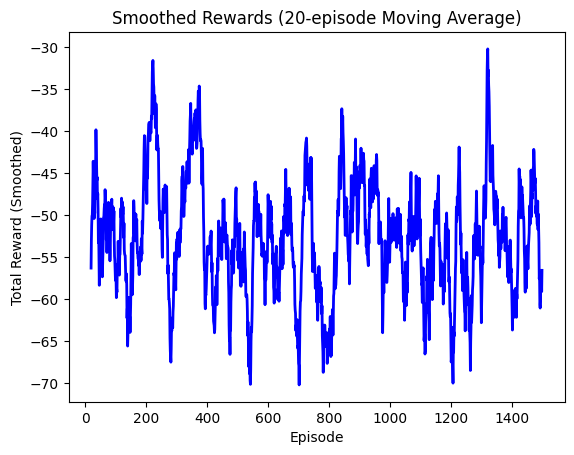

In [40]:
import pandas as pd
plt.plot(pd.Series(new_rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()


In [41]:
#all_rewards=rewards+ new_rewards+rewards_more

NameError: name 'all_rewards' is not defined

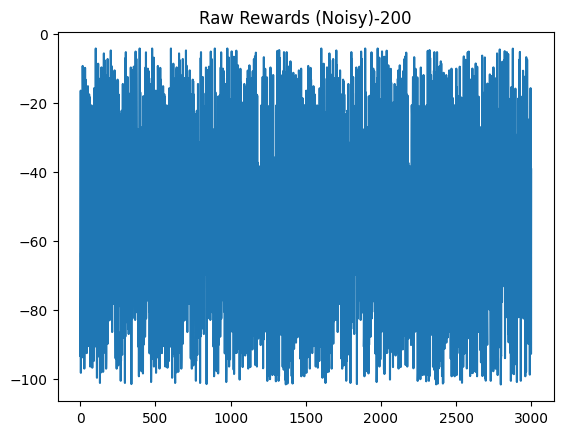

In [42]:
plt.plot(rewards)
plt.title("Raw Rewards (Noisy)-200")
plt.plot(all_rewards)
plt.title("Raw Rewards (Noisy)-600")


Text(0.5, 1.0, 'Smoothed Rewards (20-Episode Moving Average)')

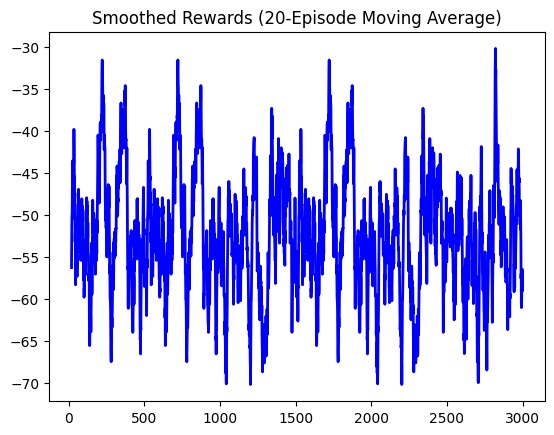

In [43]:
import pandas as pd
plt.plot(pd.Series(rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-Episode Moving Average)")


In [44]:
!pip install stable_baselines3

# Re-initialize the PPOAgent model structure
loaded_agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)

# Load the state dictionary into the agent
loaded_agent.load_state_dict(torch.load("ppo_traffic_model_1500.pt"))
loaded_agent.eval() # Set the model to evaluation mode

print("Model loaded successfully!")

Model loaded successfully!


In [45]:
env = TrafficEnv(data)
agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)



In [46]:
agent.load_state_dict(torch.load("ppo_traffic_model_1500.pt"))
print("Loaded model from 1500-episode checkpoint")


Loaded model from 1500-episode checkpoint


In [47]:
print("Current learning rate:")
for g in agent.optimizer.param_groups:
    print(g['lr'])


Current learning rate:
0.0003


In [48]:
for g in agent.optimizer.param_groups:
    g['lr'] = 1e-4  # or 5e-5 if training is still noisy

print("Learning rate successfully changed!")


Learning rate successfully changed!


In [49]:
print("Current learning rate:")
for g in agent.optimizer.param_groups:
    print(g['lr'])

Current learning rate:
0.0001


In [ ]:
import os # Add this line
import json # Add this line if not already imported

def train_ppo(
    episodes=200,
    gamma=0.99,
    clip_epsilon=0.2,
    save_path="ppo_traffic_model_latest.pt",
    rewards_path="reward_log.json"
):
    reward_history = []

    # Resume from saved rewards if file exists
    if os.path.exists(rewards_path):
        with open(rewards_path, "r") as f:
            reward_history = json.load(f)
        print(f"Loaded {len(reward_history)} previous rewards from '{rewards_path}'")

    # Continue training for new episodes
    for episode in tqdm(range(len(reward_history), len(reward_history) + episodes)):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, log_prob = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)

            # PPO update
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            value = agent.critic(state_tensor)
            next_value = agent.critic(next_state_tensor)
            advantage = reward_tensor + gamma * next_value - value

            new_log_prob, _, entropy = agent.evaluate(
                state_tensor, torch.tensor([action], dtype=torch.long)
            )

            ratio = (new_log_prob - log_prob).exp()
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantage.detach()
            loss = -torch.min(surr1, surr2) + 0.5 * advantage.pow(2) - 0.01 * entropy

            agent.optimizer.zero_grad()
            loss.mean().backward()
            agent.optimizer.step()

            total_reward += reward
            state = next_state

        reward_history.append(total_reward)
        print(f"Episode {episode + 1} | Total Reward: {total_reward:.2f}")

        # Save model & rewards every 10 episodes
        if (episode + 1) % 10 == 0:
            torch.save(agent.state_dict(), save_path)
            with open(rewards_path, "w") as f:
                json.dump(reward_history, f)
            print(f"💾 Progress saved — {episode + 1} episodes complete")

    print("Training complete!")
    torch.save(agent.state_dict(), save_path)
    with open(rewards_path, "w") as f:
        json.dump(reward_history, f)

    return reward_history  

In [51]:
# Training with new Learning Rate:

In [52]:
print("Continuing training for 500 more episodes with DIFFERENT learning rate:")
newlr_rewards = train_ppo(episodes=500)
rewards.extend(newlr_rewards)
print("Training complete.")

Continuing training for 500 more episodes with DIFFERENT learning rate:
✅ Loaded 1500 previous rewards from 'reward_log.json'


  0%|          | 1/500 [00:00<04:25,  1.88it/s]

Episode 1501 | Total Reward: -17.29


  0%|          | 2/500 [00:02<12:50,  1.55s/it]

Episode 1502 | Total Reward: -71.08


  1%|          | 3/500 [00:05<16:40,  2.01s/it]

Episode 1503 | Total Reward: -83.63


  1%|          | 4/500 [00:07<16:27,  1.99s/it]

Episode 1504 | Total Reward: -62.08


  1%|          | 5/500 [00:09<16:40,  2.02s/it]

Episode 1505 | Total Reward: -66.86


  1%|          | 6/500 [00:10<13:29,  1.64s/it]

Episode 1506 | Total Reward: -26.86


  1%|▏         | 7/500 [00:11<12:19,  1.50s/it]

Episode 1507 | Total Reward: -38.12


  2%|▏         | 8/500 [00:12<10:44,  1.31s/it]

Episode 1508 | Total Reward: -28.12


  2%|▏         | 9/500 [00:14<13:04,  1.60s/it]

Episode 1509 | Total Reward: -72.39


  2%|▏         | 10/500 [00:15<12:11,  1.49s/it]

Episode 1510 | Total Reward: -38.66
💾 Progress saved — 1510 episodes complete


  2%|▏         | 11/500 [00:18<15:26,  1.89s/it]

Episode 1511 | Total Reward: -91.42


  2%|▏         | 12/500 [00:20<15:26,  1.90s/it]

Episode 1512 | Total Reward: -61.39


  3%|▎         | 13/500 [00:23<17:04,  2.10s/it]

Episode 1513 | Total Reward: -81.34


  3%|▎         | 14/500 [00:23<12:29,  1.54s/it]

Episode 1514 | Total Reward: -8.73


  3%|▎         | 15/500 [00:26<15:02,  1.86s/it]

Episode 1515 | Total Reward: -85.52


  3%|▎         | 16/500 [00:26<11:13,  1.39s/it]

Episode 1516 | Total Reward: -9.80


  3%|▎         | 17/500 [00:27<10:43,  1.33s/it]

Episode 1517 | Total Reward: -36.95


  4%|▎         | 18/500 [00:28<10:22,  1.29s/it]

Episode 1518 | Total Reward: -38.68


  4%|▍         | 19/500 [00:31<14:02,  1.75s/it]

Episode 1519 | Total Reward: -83.33


  4%|▍         | 20/500 [00:31<10:36,  1.33s/it]

Episode 1520 | Total Reward: -11.15
💾 Progress saved — 1520 episodes complete


  4%|▍         | 21/500 [00:34<13:00,  1.63s/it]

Episode 1521 | Total Reward: -75.47


  4%|▍         | 22/500 [00:35<13:11,  1.66s/it]

Episode 1522 | Total Reward: -54.98


  5%|▍         | 23/500 [00:38<15:00,  1.89s/it]

Episode 1523 | Total Reward: -78.15


  5%|▍         | 24/500 [00:40<15:37,  1.97s/it]

Episode 1524 | Total Reward: -68.95


  5%|▌         | 25/500 [00:43<17:38,  2.23s/it]

Episode 1525 | Total Reward: -91.18


  5%|▌         | 26/500 [00:44<15:45,  1.99s/it]

Episode 1526 | Total Reward: -44.81


  5%|▌         | 27/500 [00:47<17:30,  2.22s/it]

Episode 1527 | Total Reward: -89.07


  6%|▌         | 28/500 [00:50<18:33,  2.36s/it]

Episode 1528 | Total Reward: -83.66


  6%|▌         | 29/500 [00:51<16:04,  2.05s/it]

Episode 1529 | Total Reward: -42.09


  6%|▌         | 30/500 [00:52<13:16,  1.69s/it]

Episode 1530 | Total Reward: -27.13
💾 Progress saved — 1530 episodes complete


  6%|▌         | 31/500 [00:54<13:04,  1.67s/it]

Episode 1531 | Total Reward: -50.29


  6%|▋         | 32/500 [00:55<12:33,  1.61s/it]

Episode 1532 | Total Reward: -46.13


  7%|▋         | 33/500 [00:56<12:06,  1.56s/it]

Episode 1533 | Total Reward: -45.98


  7%|▋         | 34/500 [00:58<12:40,  1.63s/it]

Episode 1534 | Total Reward: -58.43


  7%|▋         | 35/500 [01:00<13:52,  1.79s/it]

Episode 1535 | Total Reward: -67.05


  7%|▋         | 36/500 [01:03<16:23,  2.12s/it]

Episode 1536 | Total Reward: -94.39


  7%|▋         | 37/500 [01:05<14:47,  1.92s/it]

Episode 1537 | Total Reward: -46.13


  8%|▊         | 38/500 [01:08<17:27,  2.27s/it]

Episode 1538 | Total Reward: -96.82


  8%|▊         | 39/500 [01:11<19:00,  2.47s/it]

Episode 1539 | Total Reward: -88.38


  8%|▊         | 41/500 [01:12<11:16,  1.47s/it]

Episode 1540 | Total Reward: -29.06
💾 Progress saved — 1540 episodes complete
Episode 1541 | Total Reward: -4.46


  8%|▊         | 42/500 [01:12<08:33,  1.12s/it]

Episode 1542 | Total Reward: -9.46


  9%|▊         | 43/500 [01:13<07:01,  1.08it/s]

Episode 1543 | Total Reward: -15.12


  9%|▉         | 44/500 [01:15<09:27,  1.24s/it]

Episode 1544 | Total Reward: -63.50


  9%|▉         | 45/500 [01:18<12:56,  1.71s/it]

Episode 1545 | Total Reward: -89.90


  9%|▉         | 46/500 [01:18<10:17,  1.36s/it]

Episode 1546 | Total Reward: -18.02


  9%|▉         | 47/500 [01:20<12:02,  1.60s/it]

Episode 1547 | Total Reward: -67.94


 10%|▉         | 48/500 [01:23<15:03,  2.00s/it]

Episode 1548 | Total Reward: -93.83


 10%|▉         | 49/500 [01:24<12:42,  1.69s/it]

Episode 1549 | Total Reward: -29.05


 10%|█         | 51/500 [01:26<09:38,  1.29s/it]

Episode 1550 | Total Reward: -61.66
💾 Progress saved — 1550 episodes complete
Episode 1551 | Total Reward: -4.81


 10%|█         | 52/500 [01:29<11:58,  1.60s/it]

Episode 1552 | Total Reward: -75.39


 11%|█         | 53/500 [01:31<14:19,  1.92s/it]

Episode 1553 | Total Reward: -86.45


 11%|█         | 54/500 [01:33<13:58,  1.88s/it]

Episode 1554 | Total Reward: -55.57


 11%|█         | 55/500 [01:36<16:14,  2.19s/it]

Episode 1555 | Total Reward: -96.17


 11%|█         | 56/500 [01:38<15:12,  2.06s/it]

Episode 1556 | Total Reward: -54.62


 12%|█▏        | 58/500 [01:41<12:16,  1.67s/it]

Episode 1557 | Total Reward: -97.02
Episode 1558 | Total Reward: -4.75


 12%|█▏        | 59/500 [01:43<13:48,  1.88s/it]

Episode 1559 | Total Reward: -75.86


 12%|█▏        | 60/500 [01:46<15:38,  2.13s/it]

Episode 1560 | Total Reward: -89.66
💾 Progress saved — 1560 episodes complete


 12%|█▏        | 61/500 [01:48<14:42,  2.01s/it]

Episode 1561 | Total Reward: -55.06


 12%|█▏        | 62/500 [01:49<13:35,  1.86s/it]

Episode 1562 | Total Reward: -47.37


 13%|█▎        | 63/500 [01:51<14:40,  2.02s/it]

Episode 1563 | Total Reward: -76.44


 13%|█▎        | 64/500 [01:52<11:34,  1.59s/it]

Episode 1564 | Total Reward: -19.10


 13%|█▎        | 65/500 [01:52<08:59,  1.24s/it]

Episode 1565 | Total Reward: -12.86


 13%|█▎        | 66/500 [01:54<10:20,  1.43s/it]

Episode 1566 | Total Reward: -59.15


 13%|█▎        | 67/500 [01:55<08:57,  1.24s/it]

Episode 1567 | Total Reward: -26.29


 14%|█▎        | 68/500 [01:58<12:37,  1.75s/it]

Episode 1568 | Total Reward: -96.49


 14%|█▍        | 70/500 [01:59<07:45,  1.08s/it]

Episode 1569 | Total Reward: -26.01
Episode 1570 | Total Reward: -5.74
💾 Progress saved — 1570 episodes complete


 14%|█▍        | 71/500 [02:00<06:57,  1.03it/s]

Episode 1571 | Total Reward: -23.47


 14%|█▍        | 72/500 [02:03<10:42,  1.50s/it]

Episode 1572 | Total Reward: -87.71


 15%|█▍        | 74/500 [02:04<07:40,  1.08s/it]

Episode 1573 | Total Reward: -44.86
Episode 1574 | Total Reward: -5.95


 15%|█▌        | 75/500 [02:05<08:11,  1.16s/it]

Episode 1575 | Total Reward: -42.41


 15%|█▌        | 77/500 [02:09<08:50,  1.25s/it]

Episode 1576 | Total Reward: -98.95
Episode 1577 | Total Reward: -5.17


 16%|█▌        | 78/500 [02:09<07:29,  1.06s/it]

Episode 1578 | Total Reward: -19.48


 16%|█▌        | 79/500 [02:11<08:36,  1.23s/it]

Episode 1579 | Total Reward: -49.96


 16%|█▌        | 80/500 [02:13<10:30,  1.50s/it]

Episode 1580 | Total Reward: -68.31
💾 Progress saved — 1580 episodes complete


 16%|█▌        | 81/500 [02:15<10:39,  1.53s/it]

Episode 1581 | Total Reward: -50.12


 17%|█▋        | 83/500 [02:18<09:49,  1.41s/it]

Episode 1582 | Total Reward: -98.01
Episode 1583 | Total Reward: -4.10


 17%|█▋        | 84/500 [02:19<09:47,  1.41s/it]

Episode 1584 | Total Reward: -45.26


 17%|█▋        | 85/500 [02:21<11:20,  1.64s/it]

Episode 1585 | Total Reward: -69.10


 17%|█▋        | 86/500 [02:24<14:18,  2.07s/it]

Episode 1586 | Total Reward: -100.63


 17%|█▋        | 87/500 [02:26<13:41,  1.99s/it]

Episode 1587 | Total Reward: -56.32


 18%|█▊        | 88/500 [02:27<10:15,  1.49s/it]

Episode 1588 | Total Reward: -11.51


 18%|█▊        | 89/500 [02:28<09:31,  1.39s/it]

Episode 1589 | Total Reward: -37.37


 18%|█▊        | 90/500 [02:30<10:48,  1.58s/it]

Episode 1590 | Total Reward: -65.95
💾 Progress saved — 1590 episodes complete


 18%|█▊        | 91/500 [02:31<10:56,  1.61s/it]

Episode 1591 | Total Reward: -51.35


 18%|█▊        | 92/500 [02:33<11:25,  1.68s/it]

Episode 1592 | Total Reward: -58.32


 19%|█▊        | 93/500 [02:33<08:27,  1.25s/it]

Episode 1593 | Total Reward: -8.46


 19%|█▉        | 94/500 [02:36<10:21,  1.53s/it]

Episode 1594 | Total Reward: -71.58


 19%|█▉        | 95/500 [02:37<10:42,  1.59s/it]

Episode 1595 | Total Reward: -53.54


 19%|█▉        | 96/500 [02:39<10:13,  1.52s/it]

Episode 1596 | Total Reward: -43.79


 19%|█▉        | 97/500 [02:40<09:12,  1.37s/it]

Episode 1597 | Total Reward: -32.52


 20%|█▉        | 98/500 [02:42<10:52,  1.62s/it]

Episode 1598 | Total Reward: -71.77


 20%|█▉        | 99/500 [02:43<08:42,  1.30s/it]

Episode 1599 | Total Reward: -17.65


 20%|██        | 100/500 [02:44<09:36,  1.44s/it]

Episode 1600 | Total Reward: -55.29
💾 Progress saved — 1600 episodes complete


 20%|██        | 101/500 [02:45<07:39,  1.15s/it]

Episode 1601 | Total Reward: -15.68


 20%|██        | 102/500 [02:48<11:22,  1.72s/it]

Episode 1602 | Total Reward: -98.39


 21%|██        | 103/500 [02:49<09:22,  1.42s/it]

Episode 1603 | Total Reward: -22.43


 21%|██        | 104/500 [02:49<07:26,  1.13s/it]

Episode 1604 | Total Reward: -14.85


 21%|██        | 105/500 [02:51<10:08,  1.54s/it]

Episode 1605 | Total Reward: -81.15


 21%|██▏       | 107/500 [02:54<08:49,  1.35s/it]

Episode 1606 | Total Reward: -81.76
Episode 1607 | Total Reward: -7.45


 22%|██▏       | 108/500 [02:55<07:34,  1.16s/it]

Episode 1608 | Total Reward: -23.39


 22%|██▏       | 109/500 [02:56<07:21,  1.13s/it]

Episode 1609 | Total Reward: -34.22


 22%|██▏       | 110/500 [02:56<05:59,  1.09it/s]

Episode 1610 | Total Reward: -14.37
💾 Progress saved — 1610 episodes complete


 22%|██▏       | 111/500 [02:57<05:22,  1.21it/s]

Episode 1611 | Total Reward: -19.10


 23%|██▎       | 113/500 [02:58<03:31,  1.83it/s]

Episode 1612 | Total Reward: -13.22
Episode 1613 | Total Reward: -5.87


 23%|██▎       | 114/500 [03:00<07:52,  1.22s/it]

Episode 1614 | Total Reward: -90.48


 23%|██▎       | 115/500 [03:02<08:29,  1.32s/it]

Episode 1615 | Total Reward: -49.50


 23%|██▎       | 116/500 [03:05<11:32,  1.80s/it]

Episode 1616 | Total Reward: -94.44


 23%|██▎       | 117/500 [03:06<10:07,  1.59s/it]

Episode 1617 | Total Reward: -34.61


 24%|██▎       | 118/500 [03:07<08:06,  1.27s/it]

Episode 1618 | Total Reward: -17.74


 24%|██▍       | 119/500 [03:08<08:51,  1.40s/it]

Episode 1619 | Total Reward: -52.06


 24%|██▍       | 120/500 [03:09<07:48,  1.23s/it]

Episode 1620 | Total Reward: -27.39
💾 Progress saved — 1620 episodes complete


 24%|██▍       | 121/500 [03:10<07:00,  1.11s/it]

Episode 1621 | Total Reward: -25.63


 24%|██▍       | 122/500 [03:11<07:17,  1.16s/it]

Episode 1622 | Total Reward: -39.73


 25%|██▍       | 123/500 [03:14<10:48,  1.72s/it]

Episode 1623 | Total Reward: -97.98


 25%|██▌       | 125/500 [03:16<08:09,  1.31s/it]

Episode 1624 | Total Reward: -64.74
Episode 1625 | Total Reward: -5.23


 25%|██▌       | 126/500 [03:19<09:57,  1.60s/it]

Episode 1626 | Total Reward: -73.59


 25%|██▌       | 127/500 [03:20<10:05,  1.62s/it]

Episode 1627 | Total Reward: -53.72


 26%|██▌       | 128/500 [03:21<07:48,  1.26s/it]

Episode 1628 | Total Reward: -13.22


 26%|██▌       | 129/500 [03:21<06:31,  1.05s/it]

Episode 1629 | Total Reward: -18.02


 26%|██▌       | 130/500 [03:22<05:01,  1.23it/s]

Episode 1630 | Total Reward: -9.00
💾 Progress saved — 1630 episodes complete


 26%|██▌       | 131/500 [03:24<08:56,  1.45s/it]

Episode 1631 | Total Reward: -94.06


 26%|██▋       | 132/500 [03:26<09:10,  1.50s/it]

Episode 1632 | Total Reward: -50.44


 27%|██▋       | 133/500 [03:29<11:01,  1.80s/it]

Episode 1633 | Total Reward: -81.13


 27%|██▋       | 134/500 [03:31<12:59,  2.13s/it]

Episode 1634 | Total Reward: -95.05


 27%|██▋       | 135/500 [03:33<11:53,  1.95s/it]

Episode 1635 | Total Reward: -47.30


 27%|██▋       | 136/500 [03:34<09:36,  1.58s/it]

Episode 1636 | Total Reward: -22.32


 27%|██▋       | 137/500 [03:36<09:56,  1.64s/it]

Episode 1637 | Total Reward: -56.69


 28%|██▊       | 138/500 [03:38<11:40,  1.94s/it]

Episode 1638 | Total Reward: -84.34


 28%|██▊       | 139/500 [03:40<11:40,  1.94s/it]

Episode 1639 | Total Reward: -62.98


 28%|██▊       | 140/500 [03:42<10:44,  1.79s/it]

Episode 1640 | Total Reward: -46.04
💾 Progress saved — 1640 episodes complete


 28%|██▊       | 141/500 [03:43<09:52,  1.65s/it]

Episode 1641 | Total Reward: -40.39


 28%|██▊       | 142/500 [03:44<08:54,  1.49s/it]

Episode 1642 | Total Reward: -35.70


 29%|██▊       | 143/500 [03:45<07:30,  1.26s/it]

Episode 1643 | Total Reward: -22.87


 29%|██▉       | 144/500 [03:47<09:07,  1.54s/it]

Episode 1644 | Total Reward: -70.71


 29%|██▉       | 145/500 [03:48<08:26,  1.43s/it]

Episode 1645 | Total Reward: -36.05


 29%|██▉       | 146/500 [03:50<09:01,  1.53s/it]

Episode 1646 | Total Reward: -56.32


 29%|██▉       | 147/500 [03:52<10:02,  1.71s/it]

Episode 1647 | Total Reward: -68.95


 30%|██▉       | 148/500 [03:55<11:49,  2.02s/it]

Episode 1648 | Total Reward: -87.29


 30%|██▉       | 149/500 [03:55<09:37,  1.64s/it]

Episode 1649 | Total Reward: -24.91


 30%|███       | 151/500 [03:58<07:25,  1.28s/it]

Episode 1650 | Total Reward: -65.84
💾 Progress saved — 1650 episodes complete
Episode 1651 | Total Reward: -5.17


 30%|███       | 152/500 [03:59<06:59,  1.21s/it]

Episode 1652 | Total Reward: -32.20


 31%|███       | 153/500 [04:00<07:45,  1.34s/it]

Episode 1653 | Total Reward: -51.83


 31%|███       | 154/500 [04:03<09:20,  1.62s/it]

Episode 1654 | Total Reward: -73.82


 31%|███       | 155/500 [04:04<09:40,  1.68s/it]

Episode 1655 | Total Reward: -56.96


 31%|███       | 156/500 [04:06<09:21,  1.63s/it]

Episode 1656 | Total Reward: -48.63


 31%|███▏      | 157/500 [04:08<09:10,  1.60s/it]

Episode 1657 | Total Reward: -48.14


 32%|███▏      | 158/500 [04:09<08:21,  1.47s/it]

Episode 1658 | Total Reward: -36.59


 32%|███▏      | 159/500 [04:11<09:36,  1.69s/it]

Episode 1659 | Total Reward: -70.46


 32%|███▏      | 160/500 [04:13<10:12,  1.80s/it]

Episode 1660 | Total Reward: -66.86
💾 Progress saved — 1660 episodes complete


 32%|███▏      | 161/500 [04:14<08:24,  1.49s/it]

Episode 1661 | Total Reward: -24.26


 32%|███▏      | 162/500 [04:16<10:28,  1.86s/it]

Episode 1662 | Total Reward: -87.16


 33%|███▎      | 163/500 [04:18<09:18,  1.66s/it]

Episode 1663 | Total Reward: -38.31


 33%|███▎      | 164/500 [04:20<10:37,  1.90s/it]

Episode 1664 | Total Reward: -80.49


 33%|███▎      | 165/500 [04:23<11:37,  2.08s/it]

Episode 1665 | Total Reward: -80.49


 33%|███▎      | 166/500 [04:25<12:06,  2.18s/it]

Episode 1666 | Total Reward: -76.83


 33%|███▎      | 167/500 [04:27<11:18,  2.04s/it]

Episode 1667 | Total Reward: -53.20


 34%|███▎      | 168/500 [04:29<11:45,  2.12s/it]

Episode 1668 | Total Reward: -75.20


 34%|███▍      | 169/500 [04:31<12:04,  2.19s/it]

Episode 1669 | Total Reward: -76.61


 34%|███▍      | 170/500 [04:34<13:08,  2.39s/it]

Episode 1670 | Total Reward: -92.13
💾 Progress saved — 1670 episodes complete


 34%|███▍      | 171/500 [04:37<13:43,  2.50s/it]

Episode 1671 | Total Reward: -89.45


 34%|███▍      | 172/500 [04:38<12:00,  2.20s/it]

Episode 1672 | Total Reward: -46.13


 35%|███▍      | 173/500 [04:40<11:19,  2.08s/it]

Episode 1673 | Total Reward: -57.40


 35%|███▍      | 174/500 [04:42<09:59,  1.84s/it]

Episode 1674 | Total Reward: -41.11


 35%|███▌      | 176/500 [04:44<07:27,  1.38s/it]

Episode 1675 | Total Reward: -65.67
Episode 1676 | Total Reward: -5.23


 35%|███▌      | 177/500 [04:44<05:51,  1.09s/it]

Episode 1677 | Total Reward: -13.90


 36%|███▌      | 178/500 [04:45<05:52,  1.10s/it]

Episode 1678 | Total Reward: -34.83


 36%|███▌      | 179/500 [04:46<04:45,  1.13it/s]

Episode 1679 | Total Reward: -13.83


 36%|███▌      | 180/500 [04:47<05:29,  1.03s/it]

Episode 1680 | Total Reward: -43.08
💾 Progress saved — 1680 episodes complete


 36%|███▌      | 181/500 [04:48<05:22,  1.01s/it]

Episode 1681 | Total Reward: -30.47


 36%|███▋      | 182/500 [04:50<06:16,  1.18s/it]

Episode 1682 | Total Reward: -49.85


 37%|███▋      | 183/500 [04:51<06:52,  1.30s/it]

Episode 1683 | Total Reward: -49.88


 37%|███▋      | 184/500 [04:54<09:21,  1.78s/it]

Episode 1684 | Total Reward: -93.83


 37%|███▋      | 185/500 [04:57<11:28,  2.19s/it]

Episode 1685 | Total Reward: -98.97


 37%|███▋      | 186/500 [05:00<12:09,  2.32s/it]

Episode 1686 | Total Reward: -84.50


 37%|███▋      | 187/500 [05:03<12:59,  2.49s/it]

Episode 1687 | Total Reward: -95.85


 38%|███▊      | 189/500 [05:04<08:07,  1.57s/it]

Episode 1688 | Total Reward: -45.97
Episode 1689 | Total Reward: -4.90


 38%|███▊      | 190/500 [05:07<09:13,  1.79s/it]

Episode 1690 | Total Reward: -73.16
💾 Progress saved — 1690 episodes complete


 38%|███▊      | 191/500 [05:07<07:21,  1.43s/it]

Episode 1691 | Total Reward: -18.81


 38%|███▊      | 192/500 [05:09<08:01,  1.56s/it]

Episode 1692 | Total Reward: -58.62


 39%|███▊      | 193/500 [05:12<10:21,  2.02s/it]

Episode 1693 | Total Reward: -101.06


 39%|███▉      | 194/500 [05:15<11:23,  2.23s/it]

Episode 1694 | Total Reward: -88.58


 39%|███▉      | 195/500 [05:17<10:30,  2.07s/it]

Episode 1695 | Total Reward: -51.24


 39%|███▉      | 196/500 [05:17<07:46,  1.53s/it]

Episode 1696 | Total Reward: -10.00


 39%|███▉      | 197/500 [05:19<08:50,  1.75s/it]

Episode 1697 | Total Reward: -72.46


 40%|███▉      | 198/500 [05:21<08:57,  1.78s/it]

Episode 1698 | Total Reward: -59.23


 40%|███▉      | 199/500 [05:23<08:45,  1.75s/it]

Episode 1699 | Total Reward: -52.24


 40%|████      | 200/500 [05:25<09:46,  1.95s/it]

Episode 1700 | Total Reward: -78.15
💾 Progress saved — 1700 episodes complete


 40%|████      | 201/500 [05:26<07:47,  1.56s/it]

Episode 1701 | Total Reward: -19.71


 40%|████      | 202/500 [05:29<09:58,  2.01s/it]

Episode 1702 | Total Reward: -97.37


 41%|████      | 203/500 [05:31<10:11,  2.06s/it]

Episode 1703 | Total Reward: -70.61


 41%|████      | 204/500 [05:33<10:16,  2.08s/it]

Episode 1704 | Total Reward: -68.95


 41%|████      | 205/500 [05:33<07:30,  1.53s/it]

Episode 1705 | Total Reward: -7.59


 41%|████      | 206/500 [05:35<07:29,  1.53s/it]

Episode 1706 | Total Reward: -48.21


 41%|████▏     | 207/500 [05:35<05:42,  1.17s/it]

Episode 1707 | Total Reward: -10.98


 42%|████▏     | 208/500 [05:36<04:47,  1.01it/s]

Episode 1708 | Total Reward: -17.53


 42%|████▏     | 209/500 [05:37<05:16,  1.09s/it]

Episode 1709 | Total Reward: -42.19


 42%|████▏     | 210/500 [05:38<05:39,  1.17s/it]

Episode 1710 | Total Reward: -42.55
💾 Progress saved — 1710 episodes complete


 42%|████▏     | 211/500 [05:39<05:16,  1.10s/it]

Episode 1711 | Total Reward: -29.01


 42%|████▏     | 212/500 [05:41<05:53,  1.23s/it]

Episode 1712 | Total Reward: -48.12


 43%|████▎     | 213/500 [05:41<04:25,  1.08it/s]

Episode 1713 | Total Reward: -7.90


 43%|████▎     | 214/500 [05:42<04:42,  1.01it/s]

Episode 1714 | Total Reward: -36.59


 43%|████▎     | 215/500 [05:44<05:06,  1.08s/it]

Episode 1715 | Total Reward: -40.33


 43%|████▎     | 216/500 [05:46<06:30,  1.38s/it]

Episode 1716 | Total Reward: -67.56


 43%|████▎     | 217/500 [05:46<04:57,  1.05s/it]

Episode 1717 | Total Reward: -9.41


 44%|████▎     | 218/500 [05:47<04:59,  1.06s/it]

Episode 1718 | Total Reward: -35.10


 44%|████▍     | 219/500 [05:48<05:33,  1.19s/it]

Episode 1719 | Total Reward: -45.97


 44%|████▍     | 220/500 [05:50<05:21,  1.15s/it]

Episode 1720 | Total Reward: -33.80
💾 Progress saved — 1720 episodes complete


 44%|████▍     | 221/500 [05:52<07:09,  1.54s/it]

Episode 1721 | Total Reward: -80.01


 44%|████▍     | 222/500 [05:53<06:15,  1.35s/it]

Episode 1722 | Total Reward: -28.67


 45%|████▍     | 223/500 [05:54<05:28,  1.19s/it]

Episode 1723 | Total Reward: -24.73


 45%|████▍     | 224/500 [05:55<05:35,  1.22s/it]

Episode 1724 | Total Reward: -41.02


 45%|████▌     | 225/500 [05:55<04:17,  1.07it/s]

Episode 1725 | Total Reward: -9.69


 45%|████▌     | 226/500 [05:57<05:11,  1.14s/it]

Episode 1726 | Total Reward: -49.96


 45%|████▌     | 227/500 [05:59<05:52,  1.29s/it]

Episode 1727 | Total Reward: -52.06


 46%|████▌     | 228/500 [06:00<05:45,  1.27s/it]

Episode 1728 | Total Reward: -38.12


 46%|████▌     | 229/500 [06:00<04:36,  1.02s/it]

Episode 1729 | Total Reward: -14.25


 46%|████▌     | 230/500 [06:00<03:31,  1.28it/s]

Episode 1730 | Total Reward: -7.90
💾 Progress saved — 1730 episodes complete


 46%|████▌     | 231/500 [06:02<04:48,  1.07s/it]

Episode 1731 | Total Reward: -55.14


 46%|████▋     | 232/500 [06:04<05:43,  1.28s/it]

Episode 1732 | Total Reward: -55.78


 47%|████▋     | 233/500 [06:07<08:07,  1.82s/it]

Episode 1733 | Total Reward: -100.27


 47%|████▋     | 234/500 [06:08<07:06,  1.61s/it]

Episode 1734 | Total Reward: -34.96


 47%|████▋     | 235/500 [06:10<07:49,  1.77s/it]

Episode 1735 | Total Reward: -67.05


 47%|████▋     | 236/500 [06:13<09:11,  2.09s/it]

Episode 1736 | Total Reward: -93.28


 47%|████▋     | 237/500 [06:15<08:56,  2.04s/it]

Episode 1737 | Total Reward: -61.39


 48%|████▊     | 238/500 [06:15<06:36,  1.51s/it]

Episode 1738 | Total Reward: -9.69


 48%|████▊     | 239/500 [06:17<06:28,  1.49s/it]

Episode 1739 | Total Reward: -44.81


 48%|████▊     | 240/500 [06:19<07:07,  1.64s/it]

Episode 1740 | Total Reward: -64.48
💾 Progress saved — 1740 episodes complete


 48%|████▊     | 241/500 [06:21<07:56,  1.84s/it]

Episode 1741 | Total Reward: -71.58


 48%|████▊     | 242/500 [06:24<08:57,  2.08s/it]

Episode 1742 | Total Reward: -87.05


 49%|████▊     | 243/500 [06:24<07:06,  1.66s/it]

Episode 1743 | Total Reward: -20.88


 49%|████▉     | 244/500 [06:26<06:44,  1.58s/it]

Episode 1744 | Total Reward: -44.95


 49%|████▉     | 245/500 [06:27<06:41,  1.57s/it]

Episode 1745 | Total Reward: -47.58


 49%|████▉     | 246/500 [06:28<05:36,  1.32s/it]

Episode 1746 | Total Reward: -23.93


 50%|████▉     | 248/500 [06:31<05:31,  1.31s/it]

Episode 1747 | Total Reward: -96.49
Episode 1748 | Total Reward: -5.06


 50%|█████     | 250/500 [06:32<03:14,  1.29it/s]

Episode 1749 | Total Reward: -12.91
Episode 1750 | Total Reward: -5.77
💾 Progress saved — 1750 episodes complete


 50%|█████     | 251/500 [06:32<03:03,  1.36it/s]

Episode 1751 | Total Reward: -20.50


 50%|█████     | 252/500 [06:33<02:38,  1.57it/s]

Episode 1752 | Total Reward: -13.52


 51%|█████     | 253/500 [06:34<03:15,  1.27it/s]

Episode 1753 | Total Reward: -36.18


 51%|█████     | 254/500 [06:35<03:00,  1.37it/s]

Episode 1754 | Total Reward: -18.68


 51%|█████     | 255/500 [06:37<05:03,  1.24s/it]

Episode 1755 | Total Reward: -77.21


 51%|█████     | 256/500 [06:40<07:01,  1.73s/it]

Episode 1756 | Total Reward: -92.58


 51%|█████▏    | 257/500 [06:40<05:17,  1.31s/it]

Episode 1757 | Total Reward: -11.12


 52%|█████▏    | 258/500 [06:41<04:55,  1.22s/it]

Episode 1758 | Total Reward: -32.38


 52%|█████▏    | 259/500 [06:42<04:39,  1.16s/it]

Episode 1759 | Total Reward: -32.22


 52%|█████▏    | 260/500 [06:45<06:54,  1.73s/it]

Episode 1760 | Total Reward: -98.84
💾 Progress saved — 1760 episodes complete


 52%|█████▏    | 261/500 [06:45<05:08,  1.29s/it]

Episode 1761 | Total Reward: -9.04


 52%|█████▏    | 262/500 [06:48<05:59,  1.51s/it]

Episode 1762 | Total Reward: -63.77


 53%|█████▎    | 263/500 [06:48<04:49,  1.22s/it]

Episode 1763 | Total Reward: -17.17


 53%|█████▎    | 264/500 [06:51<06:50,  1.74s/it]

Episode 1764 | Total Reward: -96.64


 53%|█████▎    | 265/500 [06:52<06:02,  1.54s/it]

Episode 1765 | Total Reward: -34.83


 53%|█████▎    | 266/500 [06:52<04:31,  1.16s/it]

Episode 1766 | Total Reward: -9.41


 53%|█████▎    | 267/500 [06:53<04:15,  1.10s/it]

Episode 1767 | Total Reward: -29.69


 54%|█████▎    | 268/500 [06:56<06:16,  1.62s/it]

Episode 1768 | Total Reward: -93.13


 54%|█████▍    | 269/500 [06:57<05:12,  1.35s/it]

Episode 1769 | Total Reward: -23.47


 54%|█████▍    | 270/500 [06:58<04:40,  1.22s/it]

Episode 1770 | Total Reward: -27.82
💾 Progress saved — 1770 episodes complete


 54%|█████▍    | 271/500 [07:00<05:16,  1.38s/it]

Episode 1771 | Total Reward: -53.98


 54%|█████▍    | 272/500 [07:02<06:26,  1.70s/it]

Episode 1772 | Total Reward: -78.91


 55%|█████▍    | 273/500 [07:03<05:27,  1.44s/it]

Episode 1773 | Total Reward: -27.64


 55%|█████▍    | 274/500 [07:04<05:30,  1.46s/it]

Episode 1774 | Total Reward: -46.85


 55%|█████▌    | 275/500 [07:07<06:25,  1.71s/it]

Episode 1775 | Total Reward: -74.84


 55%|█████▌    | 276/500 [07:08<06:28,  1.73s/it]

Episode 1776 | Total Reward: -56.56


 55%|█████▌    | 277/500 [07:11<07:28,  2.01s/it]

Episode 1777 | Total Reward: -85.22


 56%|█████▌    | 278/500 [07:13<06:53,  1.86s/it]

Episode 1778 | Total Reward: -48.21


 56%|█████▌    | 279/500 [07:14<06:03,  1.64s/it]

Episode 1779 | Total Reward: -36.95


 56%|█████▌    | 280/500 [07:15<05:46,  1.57s/it]

Episode 1780 | Total Reward: -44.04
💾 Progress saved — 1780 episodes complete


 56%|█████▋    | 282/500 [07:18<04:49,  1.33s/it]

Episode 1781 | Total Reward: -76.73
Episode 1782 | Total Reward: -6.24


 57%|█████▋    | 283/500 [07:20<05:54,  1.63s/it]

Episode 1783 | Total Reward: -76.40


 57%|█████▋    | 284/500 [07:22<05:50,  1.62s/it]

Episode 1784 | Total Reward: -50.12


 57%|█████▋    | 285/500 [07:23<05:16,  1.47s/it]

Episode 1785 | Total Reward: -36.50


 57%|█████▋    | 286/500 [07:25<06:33,  1.84s/it]

Episode 1786 | Total Reward: -87.59


 57%|█████▋    | 287/500 [07:26<05:29,  1.55s/it]

Episode 1787 | Total Reward: -27.13


 58%|█████▊    | 288/500 [07:27<04:43,  1.34s/it]

Episode 1788 | Total Reward: -27.00


 58%|█████▊    | 289/500 [07:30<05:47,  1.65s/it]

Episode 1789 | Total Reward: -76.27


 58%|█████▊    | 290/500 [07:32<07:02,  2.01s/it]

Episode 1790 | Total Reward: -93.75
💾 Progress saved — 1790 episodes complete


 58%|█████▊    | 291/500 [07:35<07:47,  2.24s/it]

Episode 1791 | Total Reward: -89.45


 58%|█████▊    | 292/500 [07:36<05:59,  1.73s/it]

Episode 1792 | Total Reward: -17.85


 59%|█████▊    | 293/500 [07:36<04:31,  1.31s/it]

Episode 1793 | Total Reward: -11.23


 59%|█████▉    | 294/500 [07:37<04:13,  1.23s/it]

Episode 1794 | Total Reward: -32.99


 59%|█████▉    | 295/500 [07:40<05:34,  1.63s/it]

Episode 1795 | Total Reward: -83.51


 59%|█████▉    | 296/500 [07:42<05:46,  1.70s/it]

Episode 1796 | Total Reward: -58.91


 59%|█████▉    | 297/500 [07:43<06:00,  1.78s/it]

Episode 1797 | Total Reward: -62.98


 60%|█████▉    | 298/500 [07:45<05:29,  1.63s/it]

Episode 1798 | Total Reward: -41.28


 60%|█████▉    | 299/500 [07:47<06:15,  1.87s/it]

Episode 1799 | Total Reward: -78.65


 60%|██████    | 300/500 [07:49<05:56,  1.78s/it]

Episode 1800 | Total Reward: -49.50
💾 Progress saved — 1800 episodes complete


 60%|██████    | 301/500 [07:49<04:46,  1.44s/it]

Episode 1801 | Total Reward: -20.08


 60%|██████    | 302/500 [07:51<04:37,  1.40s/it]

Episode 1802 | Total Reward: -41.80


 61%|██████    | 303/500 [07:52<03:59,  1.21s/it]

Episode 1803 | Total Reward: -25.47


 61%|██████    | 304/500 [07:53<04:11,  1.28s/it]

Episode 1804 | Total Reward: -46.40


 61%|██████    | 305/500 [07:54<03:32,  1.09s/it]

Episode 1805 | Total Reward: -19.71


 61%|██████    | 306/500 [07:56<04:25,  1.37s/it]

Episode 1806 | Total Reward: -65.02


 61%|██████▏   | 307/500 [07:56<03:43,  1.16s/it]

Episode 1807 | Total Reward: -21.08


 62%|██████▏   | 308/500 [07:59<04:55,  1.54s/it]

Episode 1808 | Total Reward: -78.58


 62%|██████▏   | 309/500 [08:00<04:53,  1.54s/it]

Episode 1809 | Total Reward: -47.74


 62%|██████▏   | 310/500 [08:01<04:05,  1.29s/it]

Episode 1810 | Total Reward: -22.87
💾 Progress saved — 1810 episodes complete


 62%|██████▏   | 311/500 [08:02<03:33,  1.13s/it]

Episode 1811 | Total Reward: -24.39


 62%|██████▏   | 312/500 [08:04<04:37,  1.47s/it]

Episode 1812 | Total Reward: -74.06


 63%|██████▎   | 313/500 [08:06<05:24,  1.74s/it]

Episode 1813 | Total Reward: -74.94


 63%|██████▎   | 314/500 [08:08<05:08,  1.66s/it]

Episode 1814 | Total Reward: -46.76


 63%|██████▎   | 315/500 [08:10<05:51,  1.90s/it]

Episode 1815 | Total Reward: -75.81


 63%|██████▎   | 317/500 [08:11<03:29,  1.15s/it]

Episode 1816 | Total Reward: -26.01
Episode 1817 | Total Reward: -5.57


 64%|██████▎   | 318/500 [08:14<04:50,  1.60s/it]

Episode 1818 | Total Reward: -87.14


 64%|██████▍   | 319/500 [08:16<04:57,  1.65s/it]

Episode 1819 | Total Reward: -55.48


 64%|██████▍   | 320/500 [08:16<04:03,  1.35s/it]

Episode 1820 | Total Reward: -21.10
💾 Progress saved — 1820 episodes complete


 64%|██████▍   | 321/500 [08:18<04:16,  1.43s/it]

Episode 1821 | Total Reward: -50.70


 64%|██████▍   | 322/500 [08:20<04:32,  1.53s/it]

Episode 1822 | Total Reward: -55.48


 65%|██████▍   | 323/500 [08:20<03:39,  1.24s/it]

Episode 1823 | Total Reward: -17.85


 65%|██████▍   | 324/500 [08:22<04:27,  1.52s/it]

Episode 1824 | Total Reward: -69.80


 65%|██████▌   | 325/500 [08:25<05:20,  1.83s/it]

Episode 1825 | Total Reward: -83.75


 65%|██████▌   | 326/500 [08:25<03:59,  1.38s/it]

Episode 1826 | Total Reward: -10.10


 65%|██████▌   | 327/500 [08:27<04:31,  1.57s/it]

Episode 1827 | Total Reward: -65.18


 66%|██████▌   | 328/500 [08:29<04:41,  1.64s/it]

Episode 1828 | Total Reward: -56.55


 66%|██████▌   | 329/500 [08:30<04:24,  1.55s/it]

Episode 1829 | Total Reward: -42.19


 66%|██████▌   | 330/500 [08:32<04:47,  1.69s/it]

Episode 1830 | Total Reward: -65.70
💾 Progress saved — 1830 episodes complete


 66%|██████▌   | 331/500 [08:33<03:49,  1.36s/it]

Episode 1831 | Total Reward: -18.66


 66%|██████▋   | 332/500 [08:35<04:40,  1.67s/it]

Episode 1832 | Total Reward: -77.05


 67%|██████▋   | 333/500 [08:38<05:35,  2.01s/it]

Episode 1833 | Total Reward: -92.06


 67%|██████▋   | 334/500 [08:41<06:03,  2.19s/it]

Episode 1834 | Total Reward: -84.34


 67%|██████▋   | 335/500 [08:42<05:09,  1.88s/it]

Episode 1835 | Total Reward: -37.37


 67%|██████▋   | 337/500 [08:45<04:08,  1.53s/it]

Episode 1836 | Total Reward: -86.52
Episode 1837 | Total Reward: -5.77


 68%|██████▊   | 338/500 [08:45<03:15,  1.21s/it]

Episode 1838 | Total Reward: -15.30


 68%|██████▊   | 339/500 [08:48<04:37,  1.72s/it]

Episode 1839 | Total Reward: -96.61


 68%|██████▊   | 340/500 [08:50<04:57,  1.86s/it]

Episode 1840 | Total Reward: -70.29
💾 Progress saved — 1840 episodes complete


 68%|██████▊   | 341/500 [08:52<05:00,  1.89s/it]

Episode 1841 | Total Reward: -62.56


 68%|██████▊   | 342/500 [08:55<05:47,  2.20s/it]

Episode 1842 | Total Reward: -95.91


 69%|██████▊   | 343/500 [08:56<04:32,  1.73s/it]

Episode 1843 | Total Reward: -20.57


 69%|██████▉   | 344/500 [08:59<05:20,  2.05s/it]

Episode 1844 | Total Reward: -92.48


 69%|██████▉   | 345/500 [08:59<04:05,  1.59s/it]

Episode 1845 | Total Reward: -14.47


 69%|██████▉   | 346/500 [09:00<03:26,  1.34s/it]

Episode 1846 | Total Reward: -24.78


 69%|██████▉   | 347/500 [09:01<03:27,  1.35s/it]

Episode 1847 | Total Reward: -43.91


 70%|██████▉   | 348/500 [09:03<03:56,  1.56s/it]

Episode 1848 | Total Reward: -66.47


 70%|██████▉   | 349/500 [09:05<04:16,  1.70s/it]

Episode 1849 | Total Reward: -64.86


 70%|███████   | 350/500 [09:06<03:14,  1.30s/it]

Episode 1850 | Total Reward: -11.57
💾 Progress saved — 1850 episodes complete


 70%|███████   | 351/500 [09:06<02:28,  1.00it/s]

Episode 1851 | Total Reward: -10.03


 70%|███████   | 352/500 [09:07<02:20,  1.05it/s]

Episode 1852 | Total Reward: -27.47


 71%|███████   | 353/500 [09:08<02:44,  1.12s/it]

Episode 1853 | Total Reward: -47.74


 71%|███████   | 354/500 [09:10<03:00,  1.24s/it]

Episode 1854 | Total Reward: -46.45


 71%|███████   | 355/500 [09:12<03:38,  1.51s/it]

Episode 1855 | Total Reward: -68.17


 71%|███████   | 356/500 [09:13<03:31,  1.47s/it]

Episode 1856 | Total Reward: -44.17


 71%|███████▏  | 357/500 [09:17<04:39,  1.96s/it]

Episode 1857 | Total Reward: -100.53


 72%|███████▏  | 359/500 [09:19<03:14,  1.38s/it]

Episode 1858 | Total Reward: -58.62
Episode 1859 | Total Reward: -4.81


 72%|███████▏  | 360/500 [09:19<02:50,  1.22s/it]

Episode 1860 | Total Reward: -26.54
💾 Progress saved — 1860 episodes complete


 72%|███████▏  | 361/500 [09:22<03:43,  1.61s/it]

Episode 1861 | Total Reward: -79.90


 72%|███████▏  | 362/500 [09:23<03:10,  1.38s/it]

Episode 1862 | Total Reward: -27.47


 73%|███████▎  | 363/500 [09:25<03:27,  1.52s/it]

Episode 1863 | Total Reward: -59.47


 73%|███████▎  | 364/500 [09:26<03:09,  1.40s/it]

Episode 1864 | Total Reward: -35.70


 73%|███████▎  | 365/500 [09:27<03:00,  1.34s/it]

Episode 1865 | Total Reward: -37.88


 73%|███████▎  | 366/500 [09:28<02:50,  1.27s/it]

Episode 1866 | Total Reward: -36.05


 73%|███████▎  | 367/500 [09:30<03:32,  1.60s/it]

Episode 1867 | Total Reward: -75.93


 74%|███████▎  | 368/500 [09:31<03:12,  1.46s/it]

Episode 1868 | Total Reward: -35.82


 74%|███████▍  | 369/500 [09:34<03:59,  1.83s/it]

Episode 1869 | Total Reward: -88.58


 74%|███████▍  | 370/500 [09:35<03:07,  1.44s/it]

Episode 1870 | Total Reward: -17.51
💾 Progress saved — 1870 episodes complete


 74%|███████▍  | 371/500 [09:36<02:57,  1.38s/it]

Episode 1871 | Total Reward: -39.17


 74%|███████▍  | 372/500 [09:38<03:19,  1.56s/it]

Episode 1872 | Total Reward: -62.98


 75%|███████▍  | 373/500 [09:39<02:44,  1.30s/it]

Episode 1873 | Total Reward: -21.63


 75%|███████▍  | 374/500 [09:40<03:00,  1.43s/it]

Episode 1874 | Total Reward: -54.62


 75%|███████▌  | 375/500 [09:41<02:16,  1.09s/it]

Episode 1875 | Total Reward: -10.63


 75%|███████▌  | 376/500 [09:44<03:27,  1.68s/it]

Episode 1876 | Total Reward: -99.70


 75%|███████▌  | 377/500 [09:45<02:57,  1.45s/it]

Episode 1877 | Total Reward: -28.83


 76%|███████▌  | 378/500 [09:48<03:51,  1.90s/it]

Episode 1878 | Total Reward: -97.61


 76%|███████▌  | 379/500 [09:49<03:16,  1.62s/it]

Episode 1879 | Total Reward: -30.75


 76%|███████▌  | 380/500 [09:50<03:10,  1.59s/it]

Episode 1880 | Total Reward: -47.10
💾 Progress saved — 1880 episodes complete


 76%|███████▌  | 381/500 [09:53<03:54,  1.97s/it]

Episode 1881 | Total Reward: -93.28


 76%|███████▋  | 382/500 [09:54<03:36,  1.83s/it]

Episode 1882 | Total Reward: -47.10


 77%|███████▋  | 383/500 [09:55<03:04,  1.58s/it]

Episode 1883 | Total Reward: -31.33


 77%|███████▋  | 384/500 [09:57<02:56,  1.52s/it]

Episode 1884 | Total Reward: -43.63


 77%|███████▋  | 385/500 [09:58<03:02,  1.58s/it]

Episode 1885 | Total Reward: -55.63


 77%|███████▋  | 386/500 [10:00<03:09,  1.66s/it]

Episode 1886 | Total Reward: -58.49


 77%|███████▋  | 387/500 [10:02<02:51,  1.52s/it]

Episode 1887 | Total Reward: -38.31


 78%|███████▊  | 388/500 [10:04<03:26,  1.84s/it]

Episode 1888 | Total Reward: -84.97


 78%|███████▊  | 389/500 [10:05<03:06,  1.68s/it]

Episode 1889 | Total Reward: -40.24


 78%|███████▊  | 390/500 [10:08<03:20,  1.82s/it]

Episode 1890 | Total Reward: -69.63
💾 Progress saved — 1890 episodes complete


 78%|███████▊  | 391/500 [10:08<02:31,  1.39s/it]

Episode 1891 | Total Reward: -12.21


 78%|███████▊  | 392/500 [10:09<02:31,  1.40s/it]

Episode 1892 | Total Reward: -44.95


 79%|███████▊  | 393/500 [10:12<02:59,  1.68s/it]

Episode 1893 | Total Reward: -73.05


 79%|███████▉  | 394/500 [10:13<02:29,  1.41s/it]

Episode 1894 | Total Reward: -25.83


 79%|███████▉  | 395/500 [10:13<01:57,  1.12s/it]

Episode 1895 | Total Reward: -14.06


 79%|███████▉  | 396/500 [10:15<02:12,  1.28s/it]

Episode 1896 | Total Reward: -52.48


 79%|███████▉  | 397/500 [10:15<01:40,  1.03it/s]

Episode 1897 | Total Reward: -9.24


 80%|███████▉  | 398/500 [10:15<01:18,  1.30it/s]

Episode 1898 | Total Reward: -9.69


 80%|███████▉  | 399/500 [10:16<01:35,  1.06it/s]

Episode 1899 | Total Reward: -43.08


 80%|████████  | 400/500 [10:17<01:17,  1.30it/s]

Episode 1900 | Total Reward: -12.07
💾 Progress saved — 1900 episodes complete


 80%|████████  | 401/500 [10:18<01:29,  1.11it/s]

Episode 1901 | Total Reward: -38.56


 80%|████████  | 402/500 [10:20<02:06,  1.29s/it]

Episode 1902 | Total Reward: -71.48


 81%|████████  | 403/500 [10:23<02:33,  1.59s/it]

Episode 1903 | Total Reward: -72.24


 81%|████████  | 405/500 [10:24<01:49,  1.15s/it]

Episode 1904 | Total Reward: -50.58
Episode 1905 | Total Reward: -5.02


 81%|████████  | 406/500 [10:25<01:41,  1.08s/it]

Episode 1906 | Total Reward: -28.83


 81%|████████▏ | 407/500 [10:27<01:48,  1.17s/it]

Episode 1907 | Total Reward: -43.63


 82%|████████▏ | 408/500 [10:28<01:58,  1.29s/it]

Episode 1908 | Total Reward: -49.57


 82%|████████▏ | 409/500 [10:30<02:25,  1.60s/it]

Episode 1909 | Total Reward: -75.61


 82%|████████▏ | 410/500 [10:31<02:09,  1.44s/it]

Episode 1910 | Total Reward: -33.17
💾 Progress saved — 1910 episodes complete


 82%|████████▏ | 411/500 [10:33<02:17,  1.55s/it]

Episode 1911 | Total Reward: -57.15


 82%|████████▏ | 412/500 [10:34<01:51,  1.27s/it]

Episode 1912 | Total Reward: -19.23


 83%|████████▎ | 413/500 [10:35<01:44,  1.20s/it]

Episode 1913 | Total Reward: -33.39


 83%|████████▎ | 414/500 [10:36<01:42,  1.20s/it]

Episode 1914 | Total Reward: -38.16


 83%|████████▎ | 415/500 [10:38<02:09,  1.52s/it]

Episode 1915 | Total Reward: -72.92


 83%|████████▎ | 416/500 [10:40<02:13,  1.59s/it]

Episode 1916 | Total Reward: -56.56


 83%|████████▎ | 417/500 [10:42<02:12,  1.60s/it]

Episode 1917 | Total Reward: -50.12


 84%|████████▎ | 418/500 [10:43<02:06,  1.55s/it]

Episode 1918 | Total Reward: -45.26


 84%|████████▍ | 419/500 [10:44<01:49,  1.35s/it]

Episode 1919 | Total Reward: -28.01


 84%|████████▍ | 420/500 [10:46<01:58,  1.49s/it]

Episode 1920 | Total Reward: -57.97
💾 Progress saved — 1920 episodes complete


 84%|████████▍ | 421/500 [10:47<01:38,  1.25s/it]

Episode 1921 | Total Reward: -22.36


 84%|████████▍ | 422/500 [10:50<02:17,  1.77s/it]

Episode 1922 | Total Reward: -97.61


 85%|████████▍ | 423/500 [10:52<02:34,  2.00s/it]

Episode 1923 | Total Reward: -80.76


 85%|████████▍ | 424/500 [10:54<02:39,  2.10s/it]

Episode 1924 | Total Reward: -74.82


 85%|████████▌ | 425/500 [10:56<02:21,  1.89s/it]

Episode 1925 | Total Reward: -45.38


 85%|████████▌ | 426/500 [10:58<02:34,  2.09s/it]

Episode 1926 | Total Reward: -83.75


 85%|████████▌ | 427/500 [10:59<02:03,  1.69s/it]

Episode 1927 | Total Reward: -24.66


 86%|████████▌ | 428/500 [11:02<02:26,  2.03s/it]

Episode 1928 | Total Reward: -91.71


 86%|████████▌ | 429/500 [11:05<02:41,  2.27s/it]

Episode 1929 | Total Reward: -92.13


 86%|████████▌ | 430/500 [11:06<02:13,  1.91s/it]

Episode 1930 | Total Reward: -34.00
💾 Progress saved — 1930 episodes complete


 86%|████████▌ | 431/500 [11:08<02:19,  2.01s/it]

Episode 1931 | Total Reward: -72.76


 86%|████████▋ | 432/500 [11:11<02:31,  2.23s/it]

Episode 1932 | Total Reward: -88.38


 87%|████████▋ | 433/500 [11:13<02:18,  2.07s/it]

Episode 1933 | Total Reward: -52.24


 87%|████████▋ | 434/500 [11:14<02:07,  1.93s/it]

Episode 1934 | Total Reward: -51.24


 87%|████████▋ | 435/500 [11:17<02:24,  2.22s/it]

Episode 1935 | Total Reward: -94.39


 87%|████████▋ | 436/500 [11:19<02:19,  2.18s/it]

Episode 1936 | Total Reward: -67.42


 87%|████████▋ | 437/500 [11:22<02:27,  2.35s/it]

Episode 1937 | Total Reward: -87.55


 88%|████████▊ | 438/500 [11:23<01:54,  1.84s/it]

Episode 1938 | Total Reward: -20.17


 88%|████████▊ | 439/500 [11:23<01:30,  1.48s/it]

Episode 1939 | Total Reward: -20.57


 88%|████████▊ | 440/500 [11:25<01:27,  1.47s/it]

Episode 1940 | Total Reward: -45.98
💾 Progress saved — 1940 episodes complete


 88%|████████▊ | 441/500 [11:28<01:53,  1.93s/it]

Episode 1941 | Total Reward: -98.01


 88%|████████▊ | 442/500 [11:28<01:30,  1.57s/it]

Episode 1942 | Total Reward: -23.11


 89%|████████▊ | 443/500 [11:29<01:21,  1.42s/it]

Episode 1943 | Total Reward: -34.83


 89%|████████▉ | 444/500 [11:30<01:07,  1.20s/it]

Episode 1944 | Total Reward: -21.58


 89%|████████▉ | 445/500 [11:33<01:32,  1.68s/it]

Episode 1945 | Total Reward: -89.15


 89%|████████▉ | 446/500 [11:34<01:15,  1.40s/it]

Episode 1946 | Total Reward: -24.60


 89%|████████▉ | 447/500 [11:36<01:35,  1.80s/it]

Episode 1947 | Total Reward: -90.35


 90%|████████▉ | 448/500 [11:37<01:12,  1.39s/it]

Episode 1948 | Total Reward: -14.41


 90%|████████▉ | 449/500 [11:38<01:11,  1.40s/it]

Episode 1949 | Total Reward: -44.11


 90%|█████████ | 451/500 [11:40<00:52,  1.07s/it]

Episode 1950 | Total Reward: -50.87
💾 Progress saved — 1950 episodes complete
Episode 1951 | Total Reward: -5.29


 90%|█████████ | 452/500 [11:41<00:48,  1.00s/it]

Episode 1952 | Total Reward: -27.44


 91%|█████████ | 453/500 [11:43<00:58,  1.23s/it]

Episode 1953 | Total Reward: -54.07


 91%|█████████ | 454/500 [11:43<00:50,  1.09s/it]

Episode 1954 | Total Reward: -24.83


 91%|█████████ | 455/500 [11:44<00:41,  1.08it/s]

Episode 1955 | Total Reward: -17.08


 91%|█████████ | 456/500 [11:45<00:46,  1.06s/it]

Episode 1956 | Total Reward: -43.63


 91%|█████████▏| 457/500 [11:46<00:43,  1.02s/it]

Episode 1957 | Total Reward: -29.86


 92%|█████████▏| 458/500 [11:49<01:06,  1.58s/it]

Episode 1958 | Total Reward: -94.39


 92%|█████████▏| 459/500 [11:51<01:02,  1.53s/it]

Episode 1959 | Total Reward: -45.08


 92%|█████████▏| 460/500 [11:51<00:49,  1.24s/it]

Episode 1960 | Total Reward: -17.55
💾 Progress saved — 1960 episodes complete


 92%|█████████▏| 461/500 [11:52<00:47,  1.22s/it]

Episode 1961 | Total Reward: -36.60


 92%|█████████▏| 462/500 [11:53<00:35,  1.07it/s]

Episode 1962 | Total Reward: -9.62


 93%|█████████▎| 463/500 [11:55<00:50,  1.36s/it]

Episode 1963 | Total Reward: -76.09


 93%|█████████▎| 464/500 [11:57<00:53,  1.48s/it]

Episode 1964 | Total Reward: -56.14


 93%|█████████▎| 465/500 [11:57<00:41,  1.20s/it]

Episode 1965 | Total Reward: -17.65


 93%|█████████▎| 466/500 [11:58<00:32,  1.05it/s]

Episode 1966 | Total Reward: -12.21


 93%|█████████▎| 467/500 [12:00<00:49,  1.51s/it]

Episode 1967 | Total Reward: -91.71


 94%|█████████▎| 468/500 [12:02<00:48,  1.51s/it]

Episode 1968 | Total Reward: -47.01


 94%|█████████▍| 469/500 [12:05<01:00,  1.97s/it]

Episode 1969 | Total Reward: -98.97


 94%|█████████▍| 470/500 [12:07<00:57,  1.92s/it]

Episode 1970 | Total Reward: -57.76
💾 Progress saved — 1970 episodes complete


 94%|█████████▍| 471/500 [12:10<01:06,  2.28s/it]

Episode 1971 | Total Reward: -99.70


 94%|█████████▍| 472/500 [12:10<00:47,  1.70s/it]

Episode 1972 | Total Reward: -11.51


 95%|█████████▍| 473/500 [12:12<00:49,  1.82s/it]

Episode 1973 | Total Reward: -66.86


 95%|█████████▍| 474/500 [12:14<00:47,  1.83s/it]

Episode 1974 | Total Reward: -58.91


 95%|█████████▌| 475/500 [12:15<00:34,  1.39s/it]

Episode 1975 | Total Reward: -12.21


 95%|█████████▌| 476/500 [12:16<00:33,  1.40s/it]

Episode 1976 | Total Reward: -45.38


 95%|█████████▌| 477/500 [12:18<00:37,  1.63s/it]

Episode 1977 | Total Reward: -70.61


 96%|█████████▌| 478/500 [12:19<00:30,  1.39s/it]

Episode 1978 | Total Reward: -27.22


 96%|█████████▌| 479/500 [12:20<00:28,  1.34s/it]

Episode 1979 | Total Reward: -39.12


 96%|█████████▌| 480/500 [12:21<00:25,  1.28s/it]

Episode 1980 | Total Reward: -36.48
💾 Progress saved — 1980 episodes complete


 96%|█████████▌| 481/500 [12:22<00:21,  1.13s/it]

Episode 1981 | Total Reward: -25.47


 96%|█████████▋| 482/500 [12:23<00:20,  1.14s/it]

Episode 1982 | Total Reward: -36.59


 97%|█████████▋| 483/500 [12:24<00:16,  1.00it/s]

Episode 1983 | Total Reward: -20.69


 97%|█████████▋| 484/500 [12:25<00:14,  1.08it/s]

Episode 1984 | Total Reward: -24.66


 97%|█████████▋| 485/500 [12:26<00:16,  1.09s/it]

Episode 1985 | Total Reward: -46.76


 97%|█████████▋| 486/500 [12:28<00:18,  1.30s/it]

Episode 1986 | Total Reward: -57.01


 97%|█████████▋| 487/500 [12:29<00:15,  1.16s/it]

Episode 1987 | Total Reward: -26.93


 98%|█████████▊| 488/500 [12:30<00:15,  1.26s/it]

Episode 1988 | Total Reward: -47.37


 98%|█████████▊| 489/500 [12:33<00:17,  1.58s/it]

Episode 1989 | Total Reward: -73.59


 98%|█████████▊| 490/500 [12:34<00:14,  1.44s/it]

Episode 1990 | Total Reward: -35.36
💾 Progress saved — 1990 episodes complete


 98%|█████████▊| 491/500 [12:35<00:12,  1.34s/it]

Episode 1991 | Total Reward: -36.22


 99%|█████████▊| 493/500 [12:36<00:06,  1.17it/s]

Episode 1992 | Total Reward: -21.52
Episode 1993 | Total Reward: -6.47


 99%|█████████▉| 495/500 [12:38<00:04,  1.14it/s]

Episode 1994 | Total Reward: -62.24
Episode 1995 | Total Reward: -5.23


 99%|█████████▉| 496/500 [12:40<00:05,  1.42s/it]

Episode 1996 | Total Reward: -88.11


 99%|█████████▉| 497/500 [12:41<00:03,  1.12s/it]

Episode 1997 | Total Reward: -13.83


100%|█████████▉| 498/500 [12:41<00:01,  1.05it/s]

Episode 1998 | Total Reward: -18.76


100%|█████████▉| 499/500 [12:42<00:00,  1.36it/s]

Episode 1999 | Total Reward: -8.01


100%|██████████| 500/500 [12:45<00:00,  1.53s/it]

Episode 2000 | Total Reward: -101.25
💾 Progress saved — 2000 episodes complete
Training complete!
Training complete.


In [53]:
torch.save(agent.state_dict(), "ppo_traffic_model_2000.pt")


In [54]:
print("Models saved: ppo_traffic_model_latest.pt, reward_log.json, ppo_traffic_model_2000.pt")

Models saved: ppo_traffic_model_latest.pt, reward_log.json, ppo_traffic_model_2000.pt


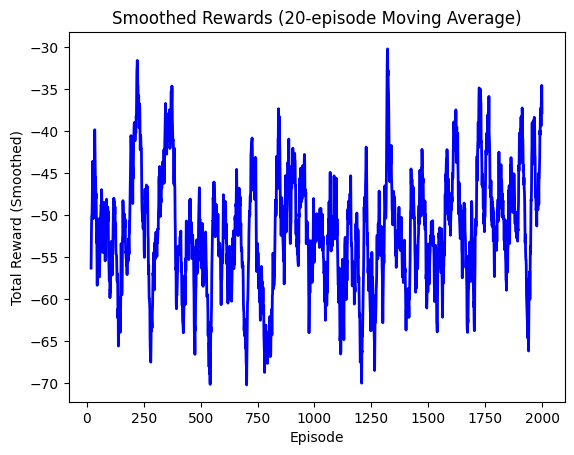

In [55]:
import pandas as pd
plt.plot(pd.Series(newlr_rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()

In [56]:
print("Continuing training for 500 more episodes with DIFFERENT learning rate:")
newlr2_rewards = train_ppo(episodes=500)
rewards.extend(newlr2_rewards)
print("Training complete.")

Continuing training for 500 more episodes with DIFFERENT learning rate:
✅ Loaded 2000 previous rewards from 'reward_log.json'


  0%|          | 1/500 [00:01<16:04,  1.93s/it]

Episode 2001 | Total Reward: -61.54


  0%|          | 2/500 [00:04<16:59,  2.05s/it]

Episode 2002 | Total Reward: -68.68


  1%|          | 3/500 [00:06<17:34,  2.12s/it]

Episode 2003 | Total Reward: -70.23


  1%|          | 4/500 [00:07<15:59,  1.93s/it]

Episode 2004 | Total Reward: -51.00


  1%|          | 5/500 [00:10<16:30,  2.00s/it]

Episode 2005 | Total Reward: -68.35


  1%|          | 6/500 [00:12<18:14,  2.22s/it]

Episode 2006 | Total Reward: -86.21


  1%|▏         | 7/500 [00:14<17:09,  2.09s/it]

Episode 2007 | Total Reward: -57.01


  2%|▏         | 8/500 [00:14<12:49,  1.56s/it]

Episode 2008 | Total Reward: -14.73


  2%|▏         | 9/500 [00:17<15:16,  1.87s/it]

Episode 2009 | Total Reward: -83.36


  2%|▏         | 10/500 [00:18<13:56,  1.71s/it]

Episode 2010 | Total Reward: -41.96
💾 Progress saved — 2010 episodes complete


  2%|▏         | 11/500 [00:19<10:53,  1.34s/it]

Episode 2011 | Total Reward: -15.82


  2%|▏         | 12/500 [00:21<11:50,  1.46s/it]

Episode 2012 | Total Reward: -54.30


  3%|▎         | 13/500 [00:22<11:15,  1.39s/it]

Episode 2013 | Total Reward: -39.25


  3%|▎         | 14/500 [00:25<15:01,  1.86s/it]

Episode 2014 | Total Reward: -96.04


  3%|▎         | 15/500 [00:25<11:30,  1.42s/it]

Episode 2015 | Total Reward: -14.20


  3%|▎         | 16/500 [00:26<10:54,  1.35s/it]

Episode 2016 | Total Reward: -38.31


  3%|▎         | 17/500 [00:27<09:47,  1.22s/it]

Episode 2017 | Total Reward: -28.97


  4%|▎         | 18/500 [00:29<11:10,  1.39s/it]

Episode 2018 | Total Reward: -54.98


  4%|▍         | 19/500 [00:30<10:56,  1.36s/it]

Episode 2019 | Total Reward: -41.41


  4%|▍         | 20/500 [00:32<12:01,  1.50s/it]

Episode 2020 | Total Reward: -56.56
💾 Progress saved — 2020 episodes complete


  4%|▍         | 21/500 [00:33<10:43,  1.34s/it]

Episode 2021 | Total Reward: -29.46


  4%|▍         | 22/500 [00:34<08:47,  1.10s/it]

Episode 2022 | Total Reward: -16.68


  5%|▍         | 23/500 [00:34<07:45,  1.03it/s]

Episode 2023 | Total Reward: -20.69


  5%|▍         | 24/500 [00:36<08:50,  1.11s/it]

Episode 2024 | Total Reward: -41.96


  5%|▌         | 25/500 [00:39<14:03,  1.77s/it]

Episode 2025 | Total Reward: -101.11


  5%|▌         | 26/500 [00:42<16:25,  2.08s/it]

Episode 2026 | Total Reward: -84.14


  5%|▌         | 27/500 [00:42<12:01,  1.53s/it]

Episode 2027 | Total Reward: -8.12


  6%|▌         | 28/500 [00:43<10:35,  1.35s/it]

Episode 2028 | Total Reward: -28.32


  6%|▌         | 29/500 [00:45<11:26,  1.46s/it]

Episode 2029 | Total Reward: -52.02


  6%|▌         | 30/500 [00:45<09:22,  1.20s/it]

Episode 2030 | Total Reward: -18.66
💾 Progress saved — 2030 episodes complete


  6%|▌         | 31/500 [00:46<07:22,  1.06it/s]

Episode 2031 | Total Reward: -11.70


  6%|▋         | 32/500 [00:47<07:40,  1.02it/s]

Episode 2032 | Total Reward: -32.55


  7%|▋         | 33/500 [00:48<07:47,  1.00s/it]

Episode 2033 | Total Reward: -33.31


  7%|▋         | 34/500 [00:50<10:12,  1.32s/it]

Episode 2034 | Total Reward: -65.95


  7%|▋         | 35/500 [00:53<14:05,  1.82s/it]

Episode 2035 | Total Reward: -98.12


  7%|▋         | 36/500 [00:53<10:53,  1.41s/it]

Episode 2036 | Total Reward: -14.37


  7%|▋         | 37/500 [00:54<09:40,  1.25s/it]

Episode 2037 | Total Reward: -28.83


  8%|▊         | 38/500 [00:54<07:17,  1.06it/s]

Episode 2038 | Total Reward: -8.35


  8%|▊         | 39/500 [00:56<09:20,  1.22s/it]

Episode 2039 | Total Reward: -59.10


  8%|▊         | 40/500 [00:57<08:55,  1.16s/it]

Episode 2040 | Total Reward: -32.20
💾 Progress saved — 2040 episodes complete


  8%|▊         | 41/500 [01:00<12:07,  1.59s/it]

Episode 2041 | Total Reward: -82.66


  8%|▊         | 42/500 [01:02<14:03,  1.84s/it]

Episode 2042 | Total Reward: -79.85


  9%|▊         | 43/500 [01:05<15:32,  2.04s/it]

Episode 2043 | Total Reward: -80.79


  9%|▉         | 44/500 [01:05<11:23,  1.50s/it]

Episode 2044 | Total Reward: -8.46


  9%|▉         | 45/500 [01:08<14:41,  1.94s/it]

Episode 2045 | Total Reward: -97.10


  9%|▉         | 46/500 [01:10<15:16,  2.02s/it]

Episode 2046 | Total Reward: -70.23


  9%|▉         | 47/500 [01:12<13:40,  1.81s/it]

Episode 2047 | Total Reward: -42.31


 10%|▉         | 48/500 [01:14<14:28,  1.92s/it]

Episode 2048 | Total Reward: -70.06


 10%|▉         | 49/500 [01:17<16:49,  2.24s/it]

Episode 2049 | Total Reward: -98.01


 10%|█         | 50/500 [01:19<17:58,  2.40s/it]

Episode 2050 | Total Reward: -87.89
💾 Progress saved — 2050 episodes complete


 10%|█         | 52/500 [01:22<12:02,  1.61s/it]

Episode 2051 | Total Reward: -60.85
Episode 2052 | Total Reward: -4.10


 11%|█         | 53/500 [01:24<13:19,  1.79s/it]

Episode 2053 | Total Reward: -70.23


 11%|█         | 54/500 [01:25<12:16,  1.65s/it]

Episode 2054 | Total Reward: -41.76


 11%|█         | 55/500 [01:27<12:58,  1.75s/it]

Episode 2055 | Total Reward: -63.93


 11%|█         | 56/500 [01:28<10:44,  1.45s/it]

Episode 2056 | Total Reward: -24.60


 11%|█▏        | 57/500 [01:30<12:05,  1.64s/it]

Episode 2057 | Total Reward: -65.18


 12%|█▏        | 58/500 [01:31<11:58,  1.62s/it]

Episode 2058 | Total Reward: -50.63


 12%|█▏        | 59/500 [01:34<14:27,  1.97s/it]

Episode 2059 | Total Reward: -89.73


 12%|█▏        | 60/500 [01:36<14:17,  1.95s/it]

Episode 2060 | Total Reward: -59.96
💾 Progress saved — 2060 episodes complete


 12%|█▏        | 61/500 [01:38<13:06,  1.79s/it]

Episode 2061 | Total Reward: -45.08


 12%|█▏        | 62/500 [01:39<13:17,  1.82s/it]

Episode 2062 | Total Reward: -59.79


 13%|█▎        | 63/500 [01:40<11:00,  1.51s/it]

Episode 2063 | Total Reward: -25.72


 13%|█▎        | 64/500 [01:42<12:16,  1.69s/it]

Episode 2064 | Total Reward: -67.46


 13%|█▎        | 65/500 [01:44<11:38,  1.60s/it]

Episode 2065 | Total Reward: -45.97


 13%|█▎        | 66/500 [01:46<12:11,  1.69s/it]

Episode 2066 | Total Reward: -59.79


 13%|█▎        | 67/500 [01:46<09:18,  1.29s/it]

Episode 2067 | Total Reward: -11.87


 14%|█▎        | 68/500 [01:48<10:54,  1.52s/it]

Episode 2068 | Total Reward: -65.40


 14%|█▍        | 69/500 [01:49<10:39,  1.48s/it]

Episode 2069 | Total Reward: -44.11


 14%|█▍        | 70/500 [01:51<10:16,  1.43s/it]

Episode 2070 | Total Reward: -42.27
💾 Progress saved — 2070 episodes complete


 14%|█▍        | 71/500 [01:53<11:07,  1.56s/it]

Episode 2071 | Total Reward: -58.18


 14%|█▍        | 72/500 [01:54<11:38,  1.63s/it]

Episode 2072 | Total Reward: -57.47


 15%|█▍        | 73/500 [01:55<09:50,  1.38s/it]

Episode 2073 | Total Reward: -25.80


 15%|█▍        | 74/500 [01:56<08:46,  1.24s/it]

Episode 2074 | Total Reward: -28.32


 15%|█▌        | 75/500 [01:58<10:31,  1.49s/it]

Episode 2075 | Total Reward: -66.50


 15%|█▌        | 76/500 [01:59<09:28,  1.34s/it]

Episode 2076 | Total Reward: -30.86


 15%|█▌        | 77/500 [02:00<08:28,  1.20s/it]

Episode 2077 | Total Reward: -28.42


 16%|█▌        | 78/500 [02:01<08:36,  1.22s/it]

Episode 2078 | Total Reward: -40.74


 16%|█▌        | 79/500 [02:02<08:22,  1.19s/it]

Episode 2079 | Total Reward: -35.61


 16%|█▌        | 80/500 [02:05<11:25,  1.63s/it]

Episode 2080 | Total Reward: -86.47
💾 Progress saved — 2080 episodes complete


 16%|█▌        | 81/500 [02:06<10:11,  1.46s/it]

Episode 2081 | Total Reward: -33.80


 16%|█▋        | 82/500 [02:07<08:55,  1.28s/it]

Episode 2082 | Total Reward: -27.12


 17%|█▋        | 83/500 [02:09<09:25,  1.36s/it]

Episode 2083 | Total Reward: -47.98


 17%|█▋        | 84/500 [02:10<09:55,  1.43s/it]

Episode 2084 | Total Reward: -50.01


 17%|█▋        | 85/500 [02:13<12:20,  1.79s/it]

Episode 2085 | Total Reward: -85.22


 17%|█▋        | 86/500 [02:15<13:09,  1.91s/it]

Episode 2086 | Total Reward: -70.13


 17%|█▋        | 87/500 [02:16<10:41,  1.55s/it]

Episode 2087 | Total Reward: -23.71


 18%|█▊        | 88/500 [02:17<10:08,  1.48s/it]

Episode 2088 | Total Reward: -41.41


 18%|█▊        | 89/500 [02:20<12:49,  1.87s/it]

Episode 2089 | Total Reward: -89.90


 18%|█▊        | 90/500 [02:22<12:47,  1.87s/it]

Episode 2090 | Total Reward: -59.15
💾 Progress saved — 2090 episodes complete


 18%|█▊        | 91/500 [02:23<10:49,  1.59s/it]

Episode 2091 | Total Reward: -29.18


 18%|█▊        | 92/500 [02:24<11:11,  1.65s/it]

Episode 2092 | Total Reward: -55.62


 19%|█▊        | 93/500 [02:26<10:45,  1.59s/it]

Episode 2093 | Total Reward: -45.40


 19%|█▉        | 94/500 [02:28<12:53,  1.90s/it]

Episode 2094 | Total Reward: -86.63


 19%|█▉        | 95/500 [02:31<13:26,  1.99s/it]

Episode 2095 | Total Reward: -69.37


 19%|█▉        | 96/500 [02:32<12:43,  1.89s/it]

Episode 2096 | Total Reward: -52.02


 19%|█▉        | 97/500 [02:33<10:17,  1.53s/it]

Episode 2097 | Total Reward: -22.48


 20%|█▉        | 98/500 [02:36<12:56,  1.93s/it]

Episode 2098 | Total Reward: -92.33


 20%|█▉        | 99/500 [02:39<14:45,  2.21s/it]

Episode 2099 | Total Reward: -93.99


 20%|██        | 100/500 [02:41<15:50,  2.38s/it]

Episode 2100 | Total Reward: -88.18
💾 Progress saved — 2100 episodes complete


 20%|██        | 101/500 [02:44<16:09,  2.43s/it]

Episode 2101 | Total Reward: -83.66


 20%|██        | 102/500 [02:46<15:36,  2.35s/it]

Episode 2102 | Total Reward: -69.97


 21%|██        | 103/500 [02:48<13:32,  2.05s/it]

Episode 2103 | Total Reward: -41.80


 21%|██        | 104/500 [02:50<15:03,  2.28s/it]

Episode 2104 | Total Reward: -91.65


 21%|██        | 105/500 [02:53<15:31,  2.36s/it]

Episode 2105 | Total Reward: -82.55


 21%|██        | 106/500 [02:54<13:40,  2.08s/it]

Episode 2106 | Total Reward: -46.29


 21%|██▏       | 107/500 [02:55<10:05,  1.54s/it]

Episode 2107 | Total Reward: -9.46


 22%|██▏       | 108/500 [02:55<07:44,  1.19s/it]

Episode 2108 | Total Reward: -11.08


 22%|██▏       | 109/500 [02:56<08:15,  1.27s/it]

Episode 2109 | Total Reward: -46.50


 22%|██▏       | 110/500 [02:58<07:49,  1.20s/it]

Episode 2110 | Total Reward: -32.61
💾 Progress saved — 2110 episodes complete


 22%|██▏       | 111/500 [03:00<10:31,  1.62s/it]

Episode 2111 | Total Reward: -83.19


 22%|██▏       | 112/500 [03:02<10:33,  1.63s/it]

Episode 2112 | Total Reward: -52.02


 23%|██▎       | 113/500 [03:05<13:11,  2.04s/it]

Episode 2113 | Total Reward: -98.28


 23%|██▎       | 114/500 [03:06<11:31,  1.79s/it]

Episode 2114 | Total Reward: -37.93


 23%|██▎       | 116/500 [03:06<06:13,  1.03it/s]

Episode 2115 | Total Reward: -7.52
Episode 2116 | Total Reward: -5.87


 23%|██▎       | 117/500 [03:09<10:03,  1.58s/it]

Episode 2117 | Total Reward: -97.91


 24%|██▎       | 118/500 [03:12<11:44,  1.84s/it]

Episode 2118 | Total Reward: -79.64


 24%|██▍       | 119/500 [03:14<11:49,  1.86s/it]

Episode 2119 | Total Reward: -60.74


 24%|██▍       | 120/500 [03:16<12:11,  1.92s/it]

Episode 2120 | Total Reward: -67.16
💾 Progress saved — 2120 episodes complete


 24%|██▍       | 121/500 [03:18<13:32,  2.14s/it]

Episode 2121 | Total Reward: -86.63


 24%|██▍       | 122/500 [03:20<13:16,  2.11s/it]

Episode 2122 | Total Reward: -64.18


 25%|██▍       | 123/500 [03:22<12:53,  2.05s/it]

Episode 2123 | Total Reward: -61.89


 25%|██▍       | 124/500 [03:25<13:41,  2.18s/it]

Episode 2124 | Total Reward: -80.49


 25%|██▌       | 125/500 [03:26<11:40,  1.87s/it]

Episode 2125 | Total Reward: -35.98


 25%|██▌       | 126/500 [03:27<09:41,  1.55s/it]

Episode 2126 | Total Reward: -26.86


 25%|██▌       | 127/500 [03:28<09:21,  1.51s/it]

Episode 2127 | Total Reward: -45.10


 26%|██▌       | 128/500 [03:29<07:49,  1.26s/it]

Episode 2128 | Total Reward: -21.63


 26%|██▌       | 129/500 [03:30<07:57,  1.29s/it]

Episode 2129 | Total Reward: -42.63


 26%|██▌       | 130/500 [03:33<10:57,  1.78s/it]

Episode 2130 | Total Reward: -94.94
💾 Progress saved — 2130 episodes complete


 26%|██▌       | 131/500 [03:35<11:13,  1.83s/it]

Episode 2131 | Total Reward: -62.56


 26%|██▋       | 132/500 [03:37<10:46,  1.76s/it]

Episode 2132 | Total Reward: -49.64


 27%|██▋       | 133/500 [03:38<10:03,  1.64s/it]

Episode 2133 | Total Reward: -44.95


 27%|██▋       | 134/500 [03:39<08:23,  1.38s/it]

Episode 2134 | Total Reward: -24.17


 27%|██▋       | 135/500 [03:40<07:33,  1.24s/it]

Episode 2135 | Total Reward: -30.09


 27%|██▋       | 136/500 [03:41<08:09,  1.35s/it]

Episode 2136 | Total Reward: -49.50


 27%|██▋       | 137/500 [03:43<08:28,  1.40s/it]

Episode 2137 | Total Reward: -48.69


 28%|██▊       | 138/500 [03:45<10:14,  1.70s/it]

Episode 2138 | Total Reward: -78.96


 28%|██▊       | 139/500 [03:47<09:52,  1.64s/it]

Episode 2139 | Total Reward: -47.74


 28%|██▊       | 140/500 [03:48<08:15,  1.38s/it]

Episode 2140 | Total Reward: -23.93
💾 Progress saved — 2140 episodes complete


 28%|██▊       | 141/500 [03:49<08:11,  1.37s/it]

Episode 2141 | Total Reward: -43.72


 28%|██▊       | 142/500 [03:51<09:28,  1.59s/it]

Episode 2142 | Total Reward: -67.13


 29%|██▉       | 144/500 [03:54<08:40,  1.46s/it]

Episode 2143 | Total Reward: -98.95
Episode 2144 | Total Reward: -5.95


 29%|██▉       | 145/500 [03:56<09:30,  1.61s/it]

Episode 2145 | Total Reward: -63.10


 29%|██▉       | 146/500 [03:58<09:38,  1.63s/it]

Episode 2146 | Total Reward: -53.08


 29%|██▉       | 147/500 [04:00<10:14,  1.74s/it]

Episode 2147 | Total Reward: -65.67


 30%|██▉       | 148/500 [04:03<12:23,  2.11s/it]

Episode 2148 | Total Reward: -97.32


 30%|██▉       | 149/500 [04:05<12:50,  2.19s/it]

Episode 2149 | Total Reward: -78.91


 30%|███       | 150/500 [04:07<11:21,  1.95s/it]

Episode 2150 | Total Reward: -43.91
💾 Progress saved — 2150 episodes complete


 30%|███       | 151/500 [04:08<10:53,  1.87s/it]

Episode 2151 | Total Reward: -52.24


 30%|███       | 152/500 [04:10<10:48,  1.86s/it]

Episode 2152 | Total Reward: -59.79


 31%|███       | 153/500 [04:11<09:57,  1.72s/it]

Episode 2153 | Total Reward: -43.62


 31%|███       | 154/500 [04:13<10:05,  1.75s/it]

Episode 2154 | Total Reward: -58.38


 31%|███       | 155/500 [04:15<09:24,  1.64s/it]

Episode 2155 | Total Reward: -44.25


 31%|███       | 156/500 [04:17<09:46,  1.71s/it]

Episode 2156 | Total Reward: -60.36


 31%|███▏      | 157/500 [04:17<07:12,  1.26s/it]

Episode 2157 | Total Reward: -8.07


 32%|███▏      | 158/500 [04:18<07:07,  1.25s/it]

Episode 2158 | Total Reward: -39.17


 32%|███▏      | 159/500 [04:19<06:26,  1.13s/it]

Episode 2159 | Total Reward: -27.47


 32%|███▏      | 160/500 [04:22<09:44,  1.72s/it]

Episode 2160 | Total Reward: -100.58
💾 Progress saved — 2160 episodes complete


 32%|███▏      | 162/500 [04:24<06:45,  1.20s/it]

Episode 2161 | Total Reward: -46.85
Episode 2162 | Total Reward: -5.23


 33%|███▎      | 163/500 [04:26<09:17,  1.65s/it]

Episode 2163 | Total Reward: -88.30


 33%|███▎      | 164/500 [04:28<08:36,  1.54s/it]

Episode 2164 | Total Reward: -40.43


 33%|███▎      | 165/500 [04:29<08:26,  1.51s/it]

Episode 2165 | Total Reward: -46.47


 33%|███▎      | 166/500 [04:31<08:37,  1.55s/it]

Episode 2166 | Total Reward: -51.55


 33%|███▎      | 167/500 [04:33<09:34,  1.73s/it]

Episode 2167 | Total Reward: -68.35


 34%|███▎      | 168/500 [04:34<09:12,  1.66s/it]

Episode 2168 | Total Reward: -49.11


 34%|███▍      | 169/500 [04:37<11:01,  2.00s/it]

Episode 2169 | Total Reward: -91.28


 34%|███▍      | 170/500 [04:38<09:10,  1.67s/it]

Episode 2170 | Total Reward: -28.50
💾 Progress saved — 2170 episodes complete


 34%|███▍      | 171/500 [04:39<08:28,  1.55s/it]

Episode 2171 | Total Reward: -40.39


 34%|███▍      | 172/500 [04:42<10:52,  1.99s/it]

Episode 2172 | Total Reward: -98.12


 35%|███▍      | 173/500 [04:43<08:31,  1.57s/it]

Episode 2173 | Total Reward: -18.40


 35%|███▍      | 174/500 [04:45<10:17,  1.89s/it]

Episode 2174 | Total Reward: -88.64


 35%|███▌      | 175/500 [04:48<11:19,  2.09s/it]

Episode 2175 | Total Reward: -82.55


 35%|███▌      | 176/500 [04:51<12:42,  2.35s/it]

Episode 2176 | Total Reward: -98.65


 35%|███▌      | 177/500 [04:54<13:52,  2.58s/it]

Episode 2177 | Total Reward: -100.65


 36%|███▌      | 178/500 [04:55<11:43,  2.18s/it]

Episode 2178 | Total Reward: -40.58


 36%|███▌      | 179/500 [04:58<12:22,  2.31s/it]

Episode 2179 | Total Reward: -84.41


 36%|███▌      | 180/500 [04:58<09:15,  1.73s/it]

Episode 2180 | Total Reward: -13.21
💾 Progress saved — 2180 episodes complete


 36%|███▌      | 181/500 [04:59<07:08,  1.34s/it]

Episode 2181 | Total Reward: -14.20


 36%|███▋      | 182/500 [04:59<05:54,  1.12s/it]

Episode 2182 | Total Reward: -18.83


 37%|███▋      | 183/500 [05:02<09:03,  1.72s/it]

Episode 2183 | Total Reward: -101.20


 37%|███▋      | 184/500 [05:04<08:59,  1.71s/it]

Episode 2184 | Total Reward: -53.09


 37%|███▋      | 185/500 [05:05<06:53,  1.31s/it]

Episode 2185 | Total Reward: -13.55


 37%|███▋      | 186/500 [05:05<05:36,  1.07s/it]

Episode 2186 | Total Reward: -16.41


 37%|███▋      | 187/500 [05:08<08:43,  1.67s/it]

Episode 2187 | Total Reward: -99.91


 38%|███▊      | 188/500 [05:09<07:24,  1.43s/it]

Episode 2188 | Total Reward: -27.44


 38%|███▊      | 189/500 [05:09<05:45,  1.11s/it]

Episode 2189 | Total Reward: -12.91


 38%|███▊      | 190/500 [05:11<05:55,  1.15s/it]

Episode 2190 | Total Reward: -39.99
💾 Progress saved — 2190 episodes complete


 38%|███▊      | 191/500 [05:11<04:27,  1.16it/s]

Episode 2191 | Total Reward: -7.52


 38%|███▊      | 192/500 [05:12<04:40,  1.10it/s]

Episode 2192 | Total Reward: -31.96


 39%|███▊      | 193/500 [05:15<08:04,  1.58s/it]

Episode 2193 | Total Reward: -101.69


 39%|███▉      | 194/500 [05:17<08:52,  1.74s/it]

Episode 2194 | Total Reward: -69.92


 39%|███▉      | 195/500 [05:18<07:16,  1.43s/it]

Episode 2195 | Total Reward: -22.32


 39%|███▉      | 196/500 [05:18<05:58,  1.18s/it]

Episode 2196 | Total Reward: -18.97


 39%|███▉      | 197/500 [05:20<06:00,  1.19s/it]

Episode 2197 | Total Reward: -38.56


 40%|███▉      | 198/500 [05:22<07:19,  1.46s/it]

Episode 2198 | Total Reward: -67.56


 40%|███▉      | 199/500 [05:25<09:35,  1.91s/it]

Episode 2199 | Total Reward: -95.85


 40%|████      | 200/500 [05:25<07:44,  1.55s/it]

Episode 2200 | Total Reward: -21.95
💾 Progress saved — 2200 episodes complete


 40%|████      | 201/500 [05:26<06:06,  1.23s/it]

Episode 2201 | Total Reward: -15.47


 40%|████      | 202/500 [05:28<08:07,  1.63s/it]

Episode 2202 | Total Reward: -84.50


 41%|████      | 203/500 [05:29<06:34,  1.33s/it]

Episode 2203 | Total Reward: -19.48


 41%|████      | 204/500 [05:32<08:38,  1.75s/it]

Episode 2204 | Total Reward: -88.80


 41%|████      | 205/500 [05:33<07:42,  1.57s/it]

Episode 2205 | Total Reward: -36.05


 41%|████      | 206/500 [05:36<09:27,  1.93s/it]

Episode 2206 | Total Reward: -90.98


 41%|████▏     | 207/500 [05:36<07:44,  1.58s/it]

Episode 2207 | Total Reward: -25.51


 42%|████▏     | 208/500 [05:39<09:36,  1.97s/it]

Episode 2208 | Total Reward: -94.94


 42%|████▏     | 209/500 [05:41<09:34,  1.97s/it]

Episode 2209 | Total Reward: -63.65


 42%|████▏     | 210/500 [05:43<09:39,  2.00s/it]

Episode 2210 | Total Reward: -65.22
💾 Progress saved — 2210 episodes complete


 42%|████▏     | 211/500 [05:44<08:12,  1.71s/it]

Episode 2211 | Total Reward: -32.61


 42%|████▏     | 212/500 [05:45<07:11,  1.50s/it]

Episode 2212 | Total Reward: -32.31


 43%|████▎     | 213/500 [05:47<07:15,  1.52s/it]

Episode 2213 | Total Reward: -48.07


 43%|████▎     | 214/500 [05:49<08:10,  1.71s/it]

Episode 2214 | Total Reward: -71.24


 43%|████▎     | 215/500 [05:49<05:59,  1.26s/it]

Episode 2215 | Total Reward: -7.59


 43%|████▎     | 216/500 [05:52<07:56,  1.68s/it]

Episode 2216 | Total Reward: -86.47


 43%|████▎     | 217/500 [05:54<08:40,  1.84s/it]

Episode 2217 | Total Reward: -70.94


 44%|████▎     | 218/500 [05:57<10:18,  2.19s/it]

Episode 2218 | Total Reward: -99.62


 44%|████▍     | 219/500 [05:58<08:03,  1.72s/it]

Episode 2219 | Total Reward: -20.14


 44%|████▍     | 220/500 [06:00<08:40,  1.86s/it]

Episode 2220 | Total Reward: -70.94
💾 Progress saved — 2220 episodes complete


 44%|████▍     | 221/500 [06:01<06:51,  1.48s/it]

Episode 2221 | Total Reward: -18.68


 44%|████▍     | 222/500 [06:01<05:57,  1.29s/it]

Episode 2222 | Total Reward: -27.05


 45%|████▍     | 223/500 [06:04<07:14,  1.57s/it]

Episode 2223 | Total Reward: -70.61


 45%|████▍     | 224/500 [06:05<06:36,  1.44s/it]

Episode 2224 | Total Reward: -36.68


 45%|████▌     | 225/500 [06:07<07:11,  1.57s/it]

Episode 2225 | Total Reward: -61.33


 45%|████▌     | 226/500 [06:09<08:19,  1.82s/it]

Episode 2226 | Total Reward: -77.59


 45%|████▌     | 227/500 [06:11<07:57,  1.75s/it]

Episode 2227 | Total Reward: -50.70


 46%|████▌     | 228/500 [06:11<06:12,  1.37s/it]

Episode 2228 | Total Reward: -16.15


 46%|████▌     | 229/500 [06:13<07:08,  1.58s/it]

Episode 2229 | Total Reward: -66.27


 46%|████▌     | 230/500 [06:15<06:57,  1.55s/it]

Episode 2230 | Total Reward: -46.61
💾 Progress saved — 2230 episodes complete


 46%|████▌     | 231/500 [06:15<05:13,  1.16s/it]

Episode 2231 | Total Reward: -9.65


 46%|████▋     | 232/500 [06:16<04:58,  1.12s/it]

Episode 2232 | Total Reward: -31.64


 47%|████▋     | 233/500 [06:17<04:12,  1.06it/s]

Episode 2233 | Total Reward: -18.02


 47%|████▋     | 234/500 [06:19<06:35,  1.49s/it]

Episode 2234 | Total Reward: -90.17


 47%|████▋     | 235/500 [06:21<06:52,  1.56s/it]

Episode 2235 | Total Reward: -55.06


 47%|████▋     | 236/500 [06:22<05:55,  1.35s/it]

Episode 2236 | Total Reward: -28.01


 47%|████▋     | 237/500 [06:23<05:35,  1.27s/it]

Episode 2237 | Total Reward: -34.74


 48%|████▊     | 238/500 [06:23<04:27,  1.02s/it]

Episode 2238 | Total Reward: -12.98


 48%|████▊     | 239/500 [06:24<03:57,  1.10it/s]

Episode 2239 | Total Reward: -20.63


 48%|████▊     | 240/500 [06:25<03:38,  1.19it/s]

Episode 2240 | Total Reward: -20.99
💾 Progress saved — 2240 episodes complete


 48%|████▊     | 241/500 [06:25<02:58,  1.45it/s]

Episode 2241 | Total Reward: -11.22


 48%|████▊     | 242/500 [06:28<05:42,  1.33s/it]

Episode 2242 | Total Reward: -92.27


 49%|████▊     | 243/500 [06:30<06:09,  1.44s/it]

Episode 2243 | Total Reward: -53.08


 49%|████▉     | 244/500 [06:32<07:41,  1.80s/it]

Episode 2244 | Total Reward: -87.29


 49%|████▉     | 245/500 [06:35<08:51,  2.09s/it]

Episode 2245 | Total Reward: -88.58


 49%|████▉     | 246/500 [06:38<09:38,  2.28s/it]

Episode 2246 | Total Reward: -87.78


 49%|████▉     | 247/500 [06:40<10:11,  2.42s/it]

Episode 2247 | Total Reward: -91.07


 50%|████▉     | 248/500 [06:43<10:43,  2.55s/it]

Episode 2248 | Total Reward: -93.99


 50%|████▉     | 249/500 [06:44<08:34,  2.05s/it]

Episode 2249 | Total Reward: -27.47


 50%|█████     | 250/500 [06:47<08:52,  2.13s/it]

Episode 2250 | Total Reward: -75.81
💾 Progress saved — 2250 episodes complete


 50%|█████     | 251/500 [06:48<08:38,  2.08s/it]

Episode 2251 | Total Reward: -62.76


 50%|█████     | 252/500 [06:51<08:39,  2.10s/it]

Episode 2252 | Total Reward: -70.08


 51%|█████     | 253/500 [06:54<09:51,  2.40s/it]

Episode 2253 | Total Reward: -100.33


 51%|█████     | 254/500 [06:54<07:15,  1.77s/it]

Episode 2254 | Total Reward: -10.25


 51%|█████     | 255/500 [06:55<06:52,  1.68s/it]

Episode 2255 | Total Reward: -47.37


 51%|█████     | 256/500 [06:58<07:43,  1.90s/it]

Episode 2256 | Total Reward: -78.65


 51%|█████▏    | 257/500 [06:59<06:25,  1.59s/it]

Episode 2257 | Total Reward: -27.90


 52%|█████▏    | 258/500 [07:00<05:22,  1.33s/it]

Episode 2258 | Total Reward: -24.66


 52%|█████▏    | 259/500 [07:01<05:45,  1.43s/it]

Episode 2259 | Total Reward: -53.98


 52%|█████▏    | 260/500 [07:02<04:26,  1.11s/it]

Episode 2260 | Total Reward: -12.07
💾 Progress saved — 2260 episodes complete


 52%|█████▏    | 261/500 [07:03<05:09,  1.29s/it]

Episode 2261 | Total Reward: -53.09


 52%|█████▏    | 262/500 [07:04<05:04,  1.28s/it]

Episode 2262 | Total Reward: -39.17


 53%|█████▎    | 263/500 [07:06<05:41,  1.44s/it]

Episode 2263 | Total Reward: -58.74


 53%|█████▎    | 264/500 [07:08<05:45,  1.46s/it]

Episode 2264 | Total Reward: -47.74


 53%|█████▎    | 265/500 [07:10<06:17,  1.61s/it]

Episode 2265 | Total Reward: -62.76


 53%|█████▎    | 266/500 [07:12<07:25,  1.90s/it]

Episode 2266 | Total Reward: -85.41


 53%|█████▎    | 267/500 [07:15<07:41,  1.98s/it]

Episode 2267 | Total Reward: -68.68


 54%|█████▎    | 268/500 [07:15<06:03,  1.57s/it]

Episode 2268 | Total Reward: -19.13


 54%|█████▍    | 269/500 [07:16<05:06,  1.32s/it]

Episode 2269 | Total Reward: -25.39


 54%|█████▍    | 270/500 [07:17<04:33,  1.19s/it]

Episode 2270 | Total Reward: -27.90
💾 Progress saved — 2270 episodes complete


 54%|█████▍    | 271/500 [07:19<05:34,  1.46s/it]

Episode 2271 | Total Reward: -67.59


 54%|█████▍    | 272/500 [07:20<05:39,  1.49s/it]

Episode 2272 | Total Reward: -49.06


 55%|█████▍    | 273/500 [07:21<04:38,  1.23s/it]

Episode 2273 | Total Reward: -19.92


 55%|█████▍    | 274/500 [07:24<06:18,  1.68s/it]

Episode 2274 | Total Reward: -88.80


 55%|█████▌    | 275/500 [07:26<07:28,  1.99s/it]

Episode 2275 | Total Reward: -87.55


 55%|█████▌    | 276/500 [07:27<06:11,  1.66s/it]

Episode 2276 | Total Reward: -28.62


 55%|█████▌    | 277/500 [07:30<07:42,  2.07s/it]

Episode 2277 | Total Reward: -99.63


 56%|█████▌    | 278/500 [07:33<08:19,  2.25s/it]

Episode 2278 | Total Reward: -87.71


 56%|█████▌    | 279/500 [07:36<08:45,  2.38s/it]

Episode 2279 | Total Reward: -87.14


 56%|█████▌    | 280/500 [07:37<07:40,  2.09s/it]

Episode 2280 | Total Reward: -46.32
💾 Progress saved — 2280 episodes complete


 56%|█████▌    | 281/500 [07:39<07:18,  2.00s/it]

Episode 2281 | Total Reward: -56.07


 56%|█████▋    | 282/500 [07:42<08:04,  2.22s/it]

Episode 2282 | Total Reward: -90.35


 57%|█████▋    | 283/500 [07:44<08:38,  2.39s/it]

Episode 2283 | Total Reward: -91.52


 57%|█████▋    | 284/500 [07:46<07:27,  2.07s/it]

Episode 2284 | Total Reward: -42.81


 57%|█████▋    | 285/500 [07:47<06:49,  1.90s/it]

Episode 2285 | Total Reward: -47.74


 57%|█████▋    | 286/500 [07:49<07:04,  1.98s/it]

Episode 2286 | Total Reward: -70.90


 57%|█████▋    | 287/500 [07:52<07:05,  2.00s/it]

Episode 2287 | Total Reward: -66.44


 58%|█████▊    | 288/500 [07:54<07:37,  2.16s/it]

Episode 2288 | Total Reward: -83.90


 58%|█████▊    | 289/500 [07:57<08:20,  2.37s/it]

Episode 2289 | Total Reward: -94.40


 58%|█████▊    | 290/500 [07:57<06:02,  1.73s/it]

Episode 2290 | Total Reward: -8.01
💾 Progress saved — 2290 episodes complete


 58%|█████▊    | 291/500 [07:57<04:33,  1.31s/it]

Episode 2291 | Total Reward: -10.57


 59%|█████▊    | 293/500 [08:00<04:09,  1.20s/it]

Episode 2292 | Total Reward: -81.65
Episode 2293 | Total Reward: -4.63


 59%|█████▉    | 294/500 [08:02<04:57,  1.45s/it]

Episode 2294 | Total Reward: -66.18


 59%|█████▉    | 295/500 [08:03<04:46,  1.40s/it]

Episode 2295 | Total Reward: -39.99


 59%|█████▉    | 296/500 [08:05<04:38,  1.37s/it]

Episode 2296 | Total Reward: -41.50


 59%|█████▉    | 297/500 [08:07<05:24,  1.60s/it]

Episode 2297 | Total Reward: -69.07


 60%|█████▉    | 298/500 [08:08<05:04,  1.51s/it]

Episode 2298 | Total Reward: -41.02


 60%|█████▉    | 299/500 [08:11<06:36,  1.97s/it]

Episode 2299 | Total Reward: -100.86


 60%|██████    | 300/500 [08:14<07:20,  2.20s/it]

Episode 2300 | Total Reward: -87.83
💾 Progress saved — 2300 episodes complete


 60%|██████    | 301/500 [08:16<06:52,  2.07s/it]

Episode 2301 | Total Reward: -55.57


 60%|██████    | 302/500 [08:16<05:26,  1.65s/it]

Episode 2302 | Total Reward: -21.08


 61%|██████    | 303/500 [08:17<04:26,  1.35s/it]

Episode 2303 | Total Reward: -21.52


 61%|██████    | 304/500 [08:17<03:27,  1.06s/it]

Episode 2304 | Total Reward: -12.86


 61%|██████    | 305/500 [08:19<04:05,  1.26s/it]

Episode 2305 | Total Reward: -53.32


 61%|██████    | 306/500 [08:21<04:41,  1.45s/it]

Episode 2306 | Total Reward: -62.24


 61%|██████▏   | 307/500 [08:21<03:36,  1.12s/it]

Episode 2307 | Total Reward: -11.64


 62%|██████▏   | 308/500 [08:22<02:49,  1.13it/s]

Episode 2308 | Total Reward: -11.23


 62%|██████▏   | 309/500 [08:23<03:07,  1.02it/s]

Episode 2309 | Total Reward: -39.01


 62%|██████▏   | 310/500 [08:25<04:04,  1.29s/it]

Episode 2310 | Total Reward: -63.21
💾 Progress saved — 2310 episodes complete


 62%|██████▏   | 311/500 [08:27<04:32,  1.44s/it]

Episode 2311 | Total Reward: -56.14


 62%|██████▏   | 312/500 [08:28<04:30,  1.44s/it]

Episode 2312 | Total Reward: -46.61


 63%|██████▎   | 313/500 [08:29<04:20,  1.39s/it]

Episode 2313 | Total Reward: -40.77


 63%|██████▎   | 314/500 [08:32<05:08,  1.66s/it]

Episode 2314 | Total Reward: -74.46


 63%|██████▎   | 315/500 [08:34<05:59,  1.94s/it]

Episode 2315 | Total Reward: -85.18


 63%|██████▎   | 316/500 [08:35<04:31,  1.48s/it]

Episode 2316 | Total Reward: -13.27


 63%|██████▎   | 317/500 [08:35<03:37,  1.19s/it]

Episode 2317 | Total Reward: -16.91


 64%|██████▎   | 318/500 [08:38<04:39,  1.54s/it]

Episode 2318 | Total Reward: -76.68


 64%|██████▍   | 319/500 [08:38<03:57,  1.31s/it]

Episode 2319 | Total Reward: -25.77


 64%|██████▍   | 320/500 [08:41<05:01,  1.68s/it]

Episode 2320 | Total Reward: -82.10
💾 Progress saved — 2320 episodes complete


 64%|██████▍   | 321/500 [08:42<04:15,  1.43s/it]

Episode 2321 | Total Reward: -27.52


 64%|██████▍   | 322/500 [08:43<04:08,  1.40s/it]

Episode 2322 | Total Reward: -42.69


 65%|██████▍   | 323/500 [08:44<03:44,  1.27s/it]

Episode 2323 | Total Reward: -30.47


 65%|██████▍   | 324/500 [08:46<04:21,  1.48s/it]

Episode 2324 | Total Reward: -63.92


 65%|██████▌   | 325/500 [08:49<05:41,  1.95s/it]

Episode 2325 | Total Reward: -100.33


 65%|██████▌   | 326/500 [08:51<05:52,  2.03s/it]

Episode 2326 | Total Reward: -73.05


 65%|██████▌   | 327/500 [08:52<04:43,  1.64s/it]

Episode 2327 | Total Reward: -23.34


 66%|██████▌   | 328/500 [08:54<04:41,  1.64s/it]

Episode 2328 | Total Reward: -52.07


 66%|██████▌   | 329/500 [08:56<05:19,  1.87s/it]

Episode 2329 | Total Reward: -77.89


 66%|██████▌   | 330/500 [08:58<05:02,  1.78s/it]

Episode 2330 | Total Reward: -49.63
💾 Progress saved — 2330 episodes complete


 66%|██████▌   | 331/500 [09:00<05:48,  2.06s/it]

Episode 2331 | Total Reward: -89.45


 66%|██████▋   | 332/500 [09:02<05:46,  2.06s/it]

Episode 2332 | Total Reward: -67.74


 67%|██████▋   | 333/500 [09:05<06:33,  2.36s/it]

Episode 2333 | Total Reward: -99.76


 67%|██████▋   | 334/500 [09:08<06:46,  2.45s/it]

Episode 2334 | Total Reward: -87.29


 67%|██████▋   | 335/500 [09:10<06:40,  2.43s/it]

Episode 2335 | Total Reward: -77.59


 67%|██████▋   | 336/500 [09:11<05:05,  1.86s/it]

Episode 2336 | Total Reward: -18.48


 67%|██████▋   | 337/500 [09:12<04:17,  1.58s/it]

Episode 2337 | Total Reward: -29.25


 68%|██████▊   | 338/500 [09:14<04:55,  1.82s/it]

Episode 2338 | Total Reward: -77.72


 68%|██████▊   | 339/500 [09:16<04:40,  1.74s/it]

Episode 2339 | Total Reward: -49.85


 68%|██████▊   | 340/500 [09:18<04:45,  1.78s/it]

Episode 2340 | Total Reward: -60.93
💾 Progress saved — 2340 episodes complete


 68%|██████▊   | 341/500 [09:19<04:30,  1.70s/it]

Episode 2341 | Total Reward: -47.10


 68%|██████▊   | 342/500 [09:21<04:29,  1.71s/it]

Episode 2342 | Total Reward: -55.24


 69%|██████▊   | 343/500 [09:23<05:05,  1.94s/it]

Episode 2343 | Total Reward: -81.65


 69%|██████▉   | 344/500 [09:26<05:21,  2.06s/it]

Episode 2344 | Total Reward: -74.62


 69%|██████▉   | 345/500 [09:28<05:41,  2.20s/it]

Episode 2345 | Total Reward: -83.07


 69%|██████▉   | 346/500 [09:29<04:23,  1.71s/it]

Episode 2346 | Total Reward: -18.50


 69%|██████▉   | 347/500 [09:31<04:18,  1.69s/it]

Episode 2347 | Total Reward: -50.63


 70%|██████▉   | 348/500 [09:33<04:45,  1.88s/it]

Episode 2348 | Total Reward: -76.61


 70%|██████▉   | 349/500 [09:36<05:23,  2.14s/it]

Episode 2349 | Total Reward: -90.48


 70%|███████   | 350/500 [09:36<04:04,  1.63s/it]

Episode 2350 | Total Reward: -14.06
💾 Progress saved — 2350 episodes complete


 70%|███████   | 351/500 [09:37<03:28,  1.40s/it]

Episode 2351 | Total Reward: -27.44


 70%|███████   | 352/500 [09:39<04:10,  1.69s/it]

Episode 2352 | Total Reward: -78.06


 71%|███████   | 353/500 [09:40<03:41,  1.51s/it]

Episode 2353 | Total Reward: -34.16


 71%|███████   | 354/500 [09:42<04:00,  1.65s/it]

Episode 2354 | Total Reward: -64.18


 71%|███████   | 355/500 [09:45<04:39,  1.92s/it]

Episode 2355 | Total Reward: -84.97


 71%|███████   | 356/500 [09:46<03:44,  1.56s/it]

Episode 2356 | Total Reward: -22.77


 71%|███████▏  | 357/500 [09:47<03:38,  1.53s/it]

Episode 2357 | Total Reward: -45.40


 72%|███████▏  | 358/500 [09:48<02:57,  1.25s/it]

Episode 2358 | Total Reward: -19.46


 72%|███████▏  | 359/500 [09:50<03:48,  1.62s/it]

Episode 2359 | Total Reward: -80.77


 72%|███████▏  | 360/500 [09:51<03:19,  1.42s/it]

Episode 2360 | Total Reward: -30.95
💾 Progress saved — 2360 episodes complete


 72%|███████▏  | 361/500 [09:52<02:37,  1.13s/it]

Episode 2361 | Total Reward: -14.83


 72%|███████▏  | 362/500 [09:54<03:29,  1.52s/it]

Episode 2362 | Total Reward: -80.01


 73%|███████▎  | 363/500 [09:55<03:15,  1.43s/it]

Episode 2363 | Total Reward: -38.37


 73%|███████▎  | 364/500 [09:58<04:05,  1.81s/it]

Episode 2364 | Total Reward: -87.19


 73%|███████▎  | 365/500 [09:59<03:16,  1.46s/it]

Episode 2365 | Total Reward: -20.69


 73%|███████▎  | 366/500 [10:00<02:56,  1.32s/it]

Episode 2366 | Total Reward: -31.64


 73%|███████▎  | 367/500 [10:02<03:56,  1.78s/it]

Episode 2367 | Total Reward: -94.88


 74%|███████▎  | 368/500 [10:05<04:36,  2.10s/it]

Episode 2368 | Total Reward: -92.66


 74%|███████▍  | 369/500 [10:08<04:44,  2.17s/it]

Episode 2369 | Total Reward: -76.83


 74%|███████▍  | 370/500 [10:08<03:47,  1.75s/it]

Episode 2370 | Total Reward: -24.60
💾 Progress saved — 2370 episodes complete


 74%|███████▍  | 371/500 [10:09<03:16,  1.52s/it]

Episode 2371 | Total Reward: -32.21


 74%|███████▍  | 372/500 [10:10<02:35,  1.22s/it]

Episode 2372 | Total Reward: -15.68


 75%|███████▍  | 373/500 [10:11<02:24,  1.14s/it]

Episode 2373 | Total Reward: -30.52


 75%|███████▍  | 374/500 [10:11<02:06,  1.00s/it]

Episode 2374 | Total Reward: -22.48


 75%|███████▌  | 375/500 [10:12<01:46,  1.17it/s]

Episode 2375 | Total Reward: -16.91


 75%|███████▌  | 376/500 [10:15<02:53,  1.40s/it]

Episode 2376 | Total Reward: -87.83


 75%|███████▌  | 377/500 [10:17<03:35,  1.75s/it]

Episode 2377 | Total Reward: -83.60


 76%|███████▌  | 378/500 [10:19<03:30,  1.73s/it]

Episode 2378 | Total Reward: -53.04


 76%|███████▌  | 379/500 [10:22<04:08,  2.06s/it]

Episode 2379 | Total Reward: -92.66


 76%|███████▌  | 380/500 [10:25<04:34,  2.29s/it]

Episode 2380 | Total Reward: -92.58
💾 Progress saved — 2380 episodes complete


 76%|███████▌  | 381/500 [10:26<03:46,  1.90s/it]

Episode 2381 | Total Reward: -31.81


 76%|███████▋  | 382/500 [10:28<04:18,  2.19s/it]

Episode 2382 | Total Reward: -93.39


 77%|███████▋  | 383/500 [10:30<03:56,  2.02s/it]

Episode 2383 | Total Reward: -50.60


 77%|███████▋  | 384/500 [10:32<03:42,  1.92s/it]

Episode 2384 | Total Reward: -54.62


 77%|███████▋  | 385/500 [10:32<02:43,  1.42s/it]

Episode 2385 | Total Reward: -9.00


 77%|███████▋  | 386/500 [10:32<02:11,  1.15s/it]

Episode 2386 | Total Reward: -17.19


 77%|███████▋  | 387/500 [10:33<02:04,  1.10s/it]

Episode 2387 | Total Reward: -31.72


 78%|███████▊  | 388/500 [10:34<01:45,  1.07it/s]

Episode 2388 | Total Reward: -18.05


 78%|███████▊  | 389/500 [10:36<02:23,  1.29s/it]

Episode 2389 | Total Reward: -66.20


 78%|███████▊  | 390/500 [10:37<01:58,  1.08s/it]

Episode 2390 | Total Reward: -18.40
💾 Progress saved — 2390 episodes complete


 78%|███████▊  | 391/500 [10:38<01:51,  1.02s/it]

Episode 2391 | Total Reward: -26.61


 78%|███████▊  | 392/500 [10:39<02:03,  1.15s/it]

Episode 2392 | Total Reward: -44.25


 79%|███████▊  | 393/500 [10:41<02:44,  1.53s/it]

Episode 2393 | Total Reward: -77.44


 79%|███████▉  | 394/500 [10:43<02:51,  1.62s/it]

Episode 2394 | Total Reward: -59.31


 79%|███████▉  | 395/500 [10:46<03:22,  1.93s/it]

Episode 2395 | Total Reward: -84.56


 79%|███████▉  | 396/500 [10:47<02:56,  1.70s/it]

Episode 2396 | Total Reward: -37.37


 79%|███████▉  | 397/500 [10:48<02:34,  1.50s/it]

Episode 2397 | Total Reward: -31.72


 80%|███████▉  | 398/500 [10:49<02:06,  1.24s/it]

Episode 2398 | Total Reward: -19.26


 80%|███████▉  | 399/500 [10:51<02:34,  1.53s/it]

Episode 2399 | Total Reward: -71.89


 80%|████████  | 400/500 [10:53<02:48,  1.69s/it]

Episode 2400 | Total Reward: -67.18
💾 Progress saved — 2400 episodes complete


 80%|████████  | 401/500 [10:54<02:20,  1.42s/it]

Episode 2401 | Total Reward: -25.80


 80%|████████  | 402/500 [10:57<03:11,  1.96s/it]

Episode 2402 | Total Reward: -93.51


 81%|████████  | 403/500 [10:59<03:16,  2.02s/it]

Episode 2403 | Total Reward: -53.76


 81%|████████  | 404/500 [11:02<03:21,  2.10s/it]

Episode 2404 | Total Reward: -73.23


 81%|████████  | 405/500 [11:03<03:05,  1.96s/it]

Episode 2405 | Total Reward: -51.39


 81%|████████  | 406/500 [11:06<03:29,  2.22s/it]

Episode 2406 | Total Reward: -94.06


 81%|████████▏ | 407/500 [11:09<03:41,  2.38s/it]

Episode 2407 | Total Reward: -88.58


 82%|████████▏ | 408/500 [11:11<03:37,  2.36s/it]

Episode 2408 | Total Reward: -75.93


 82%|████████▏ | 409/500 [11:12<03:02,  2.00s/it]

Episode 2409 | Total Reward: -38.10


 82%|████████▏ | 410/500 [11:14<02:48,  1.87s/it]

Episode 2410 | Total Reward: -47.74
💾 Progress saved — 2410 episodes complete


 82%|████████▏ | 411/500 [11:14<02:08,  1.45s/it]

Episode 2411 | Total Reward: -15.29


 82%|████████▏ | 412/500 [11:15<01:51,  1.27s/it]

Episode 2412 | Total Reward: -26.68


 83%|████████▎ | 413/500 [11:16<01:44,  1.20s/it]

Episode 2413 | Total Reward: -33.68


 83%|████████▎ | 414/500 [11:19<02:23,  1.67s/it]

Episode 2414 | Total Reward: -90.17


 83%|████████▎ | 415/500 [11:20<02:07,  1.50s/it]

Episode 2415 | Total Reward: -34.96


 83%|████████▎ | 416/500 [11:20<01:35,  1.14s/it]

Episode 2416 | Total Reward: -10.57


 83%|████████▎ | 417/500 [11:22<01:50,  1.33s/it]

Episode 2417 | Total Reward: -57.08


 84%|████████▎ | 418/500 [11:23<01:34,  1.15s/it]

Episode 2418 | Total Reward: -23.71


 84%|████████▍ | 419/500 [11:25<01:48,  1.34s/it]

Episode 2419 | Total Reward: -57.15


 84%|████████▍ | 420/500 [11:27<02:22,  1.78s/it]

Episode 2420 | Total Reward: -92.58
💾 Progress saved — 2420 episodes complete


 84%|████████▍ | 421/500 [11:28<01:59,  1.52s/it]

Episode 2421 | Total Reward: -28.32


 84%|████████▍ | 422/500 [11:31<02:19,  1.78s/it]

Episode 2422 | Total Reward: -76.57


 85%|████████▍ | 423/500 [11:32<02:02,  1.59s/it]

Episode 2423 | Total Reward: -36.68


 85%|████████▍ | 424/500 [11:33<01:59,  1.57s/it]

Episode 2424 | Total Reward: -49.38


 85%|████████▌ | 425/500 [11:36<02:14,  1.79s/it]

Episode 2425 | Total Reward: -74.82


 85%|████████▌ | 426/500 [11:36<01:37,  1.32s/it]

Episode 2426 | Total Reward: -7.72


 85%|████████▌ | 427/500 [11:37<01:36,  1.32s/it]

Episode 2427 | Total Reward: -41.76


 86%|████████▌ | 428/500 [11:40<02:08,  1.79s/it]

Episode 2428 | Total Reward: -95.05


 86%|████████▌ | 429/500 [11:41<01:41,  1.44s/it]

Episode 2429 | Total Reward: -19.48


 86%|████████▌ | 430/500 [11:43<02:07,  1.82s/it]

Episode 2430 | Total Reward: -89.15
💾 Progress saved — 2430 episodes complete


 86%|████████▌ | 431/500 [11:46<02:25,  2.11s/it]

Episode 2431 | Total Reward: -90.56


 87%|████████▋ | 433/500 [11:49<01:52,  1.68s/it]

Episode 2432 | Total Reward: -94.87
Episode 2433 | Total Reward: -5.44


 87%|████████▋ | 435/500 [11:50<00:59,  1.08it/s]

Episode 2434 | Total Reward: -6.57
Episode 2435 | Total Reward: -7.22


 87%|████████▋ | 436/500 [11:50<00:43,  1.46it/s]

Episode 2436 | Total Reward: -4.63


 87%|████████▋ | 437/500 [11:52<01:14,  1.18s/it]

Episode 2437 | Total Reward: -75.47


 88%|████████▊ | 438/500 [11:54<01:19,  1.28s/it]

Episode 2438 | Total Reward: -48.21


 88%|████████▊ | 439/500 [11:54<01:05,  1.07s/it]

Episode 2439 | Total Reward: -18.97


 88%|████████▊ | 440/500 [11:57<01:38,  1.65s/it]

Episode 2440 | Total Reward: -98.53
💾 Progress saved — 2440 episodes complete


 88%|████████▊ | 441/500 [11:59<01:46,  1.81s/it]

Episode 2441 | Total Reward: -70.13


 88%|████████▊ | 442/500 [12:00<01:25,  1.48s/it]

Episode 2442 | Total Reward: -22.48


 89%|████████▊ | 443/500 [12:01<01:23,  1.46s/it]

Episode 2443 | Total Reward: -45.40


 89%|████████▉ | 444/500 [12:02<01:12,  1.29s/it]

Episode 2444 | Total Reward: -28.67


 89%|████████▉ | 445/500 [12:03<00:53,  1.03it/s]

Episode 2445 | Total Reward: -7.59


 89%|████████▉ | 446/500 [12:05<01:23,  1.54s/it]

Episode 2446 | Total Reward: -95.52


 89%|████████▉ | 447/500 [12:07<01:22,  1.56s/it]

Episode 2447 | Total Reward: -50.60


 90%|████████▉ | 448/500 [12:08<01:09,  1.33s/it]

Episode 2448 | Total Reward: -26.42


 90%|█████████ | 450/500 [12:09<00:48,  1.03it/s]

Episode 2449 | Total Reward: -40.43
Episode 2450 | Total Reward: -5.38
💾 Progress saved — 2450 episodes complete


 90%|█████████ | 451/500 [12:11<01:04,  1.31s/it]

Episode 2451 | Total Reward: -67.97


 90%|█████████ | 452/500 [12:13<01:12,  1.51s/it]

Episode 2452 | Total Reward: -64.48


 91%|█████████ | 453/500 [12:15<01:13,  1.56s/it]

Episode 2453 | Total Reward: -53.08


 91%|█████████ | 454/500 [12:16<00:57,  1.25s/it]

Episode 2454 | Total Reward: -17.19


 91%|█████████ | 455/500 [12:19<01:19,  1.76s/it]

Episode 2455 | Total Reward: -97.80


 91%|█████████ | 456/500 [12:20<01:14,  1.70s/it]

Episode 2456 | Total Reward: -48.69


 91%|█████████▏| 457/500 [12:21<00:57,  1.35s/it]

Episode 2457 | Total Reward: -16.51


 92%|█████████▏| 458/500 [12:22<00:53,  1.28s/it]

Episode 2458 | Total Reward: -36.59


 92%|█████████▏| 459/500 [12:23<00:47,  1.15s/it]

Episode 2459 | Total Reward: -27.64


 92%|█████████▏| 460/500 [12:25<01:05,  1.63s/it]

Episode 2460 | Total Reward: -89.84
💾 Progress saved — 2460 episodes complete


 92%|█████████▏| 461/500 [12:28<01:16,  1.96s/it]

Episode 2461 | Total Reward: -90.17


 92%|█████████▏| 462/500 [12:29<00:58,  1.53s/it]

Episode 2462 | Total Reward: -17.19


 93%|█████████▎| 463/500 [12:30<00:53,  1.43s/it]

Episode 2463 | Total Reward: -38.37


 93%|█████████▎| 464/500 [12:31<00:46,  1.30s/it]

Episode 2464 | Total Reward: -30.49


 93%|█████████▎| 465/500 [12:31<00:35,  1.01s/it]

Episode 2465 | Total Reward: -11.87


 93%|█████████▎| 466/500 [12:34<00:48,  1.44s/it]

Episode 2466 | Total Reward: -80.19


 93%|█████████▎| 467/500 [12:34<00:36,  1.09s/it]

Episode 2467 | Total Reward: -9.69


 94%|█████████▎| 468/500 [12:36<00:41,  1.30s/it]

Episode 2468 | Total Reward: -56.14


 94%|█████████▍| 469/500 [12:36<00:33,  1.10s/it]

Episode 2469 | Total Reward: -20.08


 94%|█████████▍| 470/500 [12:38<00:38,  1.29s/it]

Episode 2470 | Total Reward: -56.55
💾 Progress saved — 2470 episodes complete


 94%|█████████▍| 471/500 [12:39<00:33,  1.15s/it]

Episode 2471 | Total Reward: -26.53


 94%|█████████▍| 472/500 [12:42<00:48,  1.72s/it]

Episode 2472 | Total Reward: -98.12


 95%|█████████▍| 473/500 [12:44<00:47,  1.76s/it]

Episode 2473 | Total Reward: -60.43


 95%|█████████▍| 474/500 [12:45<00:37,  1.46s/it]

Episode 2474 | Total Reward: -25.47


 95%|█████████▌| 475/500 [12:46<00:36,  1.45s/it]

Episode 2475 | Total Reward: -46.40


 95%|█████████▌| 476/500 [12:47<00:29,  1.21s/it]

Episode 2476 | Total Reward: -20.17


 95%|█████████▌| 477/500 [12:50<00:40,  1.77s/it]

Episode 2477 | Total Reward: -100.34


 96%|█████████▌| 478/500 [12:50<00:30,  1.37s/it]

Episode 2478 | Total Reward: -14.53


 96%|█████████▌| 479/500 [12:52<00:30,  1.45s/it]

Episode 2479 | Total Reward: -51.51


 96%|█████████▌| 480/500 [12:54<00:31,  1.59s/it]

Episode 2480 | Total Reward: -62.49
💾 Progress saved — 2480 episodes complete


 96%|█████████▌| 481/500 [12:54<00:24,  1.27s/it]

Episode 2481 | Total Reward: -16.36


 96%|█████████▋| 482/500 [12:57<00:32,  1.79s/it]

Episode 2482 | Total Reward: -97.91


 97%|█████████▋| 483/500 [12:58<00:26,  1.55s/it]

Episode 2483 | Total Reward: -31.96


 97%|█████████▋| 484/500 [12:59<00:22,  1.40s/it]

Episode 2484 | Total Reward: -34.16


 97%|█████████▋| 485/500 [12:59<00:15,  1.05s/it]

Episode 2485 | Total Reward: -8.55


 97%|█████████▋| 487/500 [13:00<00:07,  1.64it/s]

Episode 2486 | Total Reward: -7.40
Episode 2487 | Total Reward: -4.86


 98%|█████████▊| 488/500 [13:01<00:09,  1.21it/s]

Episode 2488 | Total Reward: -42.86


 98%|█████████▊| 489/500 [13:03<00:12,  1.11s/it]

Episode 2489 | Total Reward: -55.62


 98%|█████████▊| 490/500 [13:06<00:16,  1.63s/it]

Episode 2490 | Total Reward: -94.23
💾 Progress saved — 2490 episodes complete


 98%|█████████▊| 491/500 [13:07<00:12,  1.43s/it]

Episode 2491 | Total Reward: -30.96


 98%|█████████▊| 492/500 [13:09<00:13,  1.67s/it]

Episode 2492 | Total Reward: -71.22


 99%|█████████▊| 493/500 [13:12<00:13,  1.98s/it]

Episode 2493 | Total Reward: -88.48


 99%|█████████▉| 494/500 [13:13<00:10,  1.79s/it]

Episode 2494 | Total Reward: -43.87


 99%|█████████▉| 495/500 [13:15<00:09,  1.86s/it]

Episode 2495 | Total Reward: -65.75


 99%|█████████▉| 496/500 [13:18<00:08,  2.20s/it]

Episode 2496 | Total Reward: -98.65


 99%|█████████▉| 497/500 [13:18<00:04,  1.64s/it]

Episode 2497 | Total Reward: -11.08


100%|█████████▉| 498/500 [13:19<00:02,  1.22s/it]

Episode 2498 | Total Reward: -8.88


100%|█████████▉| 499/500 [13:19<00:01,  1.02s/it]

Episode 2499 | Total Reward: -16.60


100%|██████████| 500/500 [13:21<00:00,  1.60s/it]

Episode 2500 | Total Reward: -43.87
💾 Progress saved — 2500 episodes complete
Training complete!
Training complete.


In [57]:
torch.save(agent.state_dict(), "ppo_traffic_model_2500.pt")


In [58]:
print("Models saved: ppo_traffic_model_latest.pt, reward_log.json, ppo_traffic_model_2500.pt")

Models saved: ppo_traffic_model_latest.pt, reward_log.json, ppo_traffic_model_2500.pt


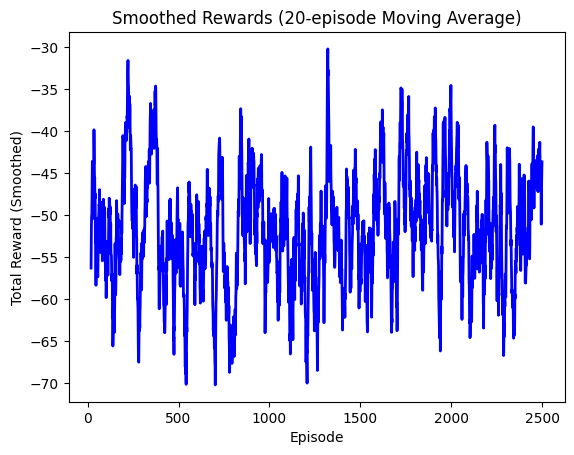

In [59]:
import pandas as pd
plt.plot(pd.Series(newlr2_rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json, os
from tqdm import tqdm


env = TrafficEnv(data)

# Load agent with same architecture
agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)

# Load previous trained weights if available
model_path = "ppo_traffic_model_2500.pt"
if os.path.exists(model_path):
    agent.load_state_dict(torch.load(model_path))
    print("Loaded existing trained model:", model_path)
else:
    print("No previous model found — training will start fresh.")


# 2️ PPO Evaluation function (NO EXPLORATION)
def evaluate(agent, env, episodes=10):
    rewards = []
    for _ in range(episodes):
        s, _ = env.reset()
        done = False
        total = 0
        while not done:
            a, _ = agent.act(s)   # greedy action (actor takes highest prob)
            s, r, done, truncated, _ = env.step(a)
            total += r
        rewards.append(total)
    return np.mean(rewards)


# 3️ TRAINING FUNCTION (NEW)
def train_ppo_next_phase(
    episodes=1000,
    gamma=0.99,
    clip_epsilon=0.2,
    save_path="ppo_traffic_model_latest.pt",
    rewards_path="reward_log.json"
):
    # Load previous reward log
    reward_history = []
    if os.path.exists(rewards_path):
        with open(rewards_path, "r") as f:
            reward_history = json.load(f)
        print(f"Loaded {len(reward_history)} previous reward entries.")

    # LR scheduler — reduces LR when improvement plateaus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        agent.optimizer,
        mode='max',
        factor=0.5,     # Halve the LR
        patience=5,     # Wait 5 eval cycles
        min_lr=1e-6
        # verbose=True  # Removed verbose argument
    )

    print("\n Starting Next-Phase Training...\n")

    for ep in tqdm(range(episodes)):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, log_prob = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)

            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            value = agent.critic(state_tensor)
            next_value = agent.critic(next_state_tensor)
            advantage = reward_tensor + gamma * next_value - value

            new_log_prob, _, entropy = agent.evaluate(
                state_tensor, torch.tensor([action], dtype=torch.long)
            )

            ratio = (new_log_prob - log_prob).exp()
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantage.detach()
            loss = -torch.min(surr1, surr2) + 0.5 * advantage.pow(2) - 0.01 * entropy

            agent.optimizer.zero_grad()
            loss.mean().backward()
            agent.optimizer.step()

            total_reward += reward
            state = next_state

        reward_history.append(total_reward)
        print(f"Episode {len(reward_history)} | Reward: {total_reward:.2f}")

        # Every 100 episodes → evaluate & adjust LR
        if (ep + 1) % 100 == 0:
            eval_reward = evaluate(agent, env, episodes=5)
            print(f"Evaluation Reward after {len(reward_history)} eps: {eval_reward:.2f}")

            scheduler.step(eval_reward)

            # Save progress
            torch.save(agent.state_dict(), save_path)
            with open(rewards_path, "w") as f:
                json.dump(reward_history, f)
            print("💾 Autosaved model + rewards.")

    # final save
    torch.save(agent.state_dict(), save_path)
    with open(rewards_path, "w") as f:
        json.dump(reward_history, f)

    print("\nTraining Phase Complete!")
    return reward_history


# 4️ Run training
new_rewards = train_ppo_next_phase(episodes=1000)

✔ Loaded existing trained model: ppo_traffic_model_2500.pt
✔ Loaded 2500 previous reward entries.

 Starting Next-Phase Training...



  0%|          | 1/1000 [00:02<38:24,  2.31s/it]

Episode 2501 | Reward: -73.05


  0%|          | 2/1000 [00:05<43:25,  2.61s/it]

Episode 2502 | Reward: -87.84


  0%|          | 3/1000 [00:05<27:56,  1.68s/it]

Episode 2503 | Reward: -18.31


  0%|          | 4/1000 [00:05<18:34,  1.12s/it]

Episode 2504 | Reward: -9.00


  0%|          | 5/1000 [00:06<13:38,  1.22it/s]

Episode 2505 | Reward: -9.37


  1%|          | 6/1000 [00:06<11:07,  1.49it/s]

Episode 2506 | Reward: -12.21


  1%|          | 7/1000 [00:08<17:04,  1.03s/it]

Episode 2507 | Reward: -57.40


  1%|          | 8/1000 [00:10<20:06,  1.22s/it]

Episode 2508 | Reward: -49.64


  1%|          | 9/1000 [00:10<15:58,  1.03it/s]

Episode 2509 | Reward: -13.84


  1%|          | 10/1000 [00:11<15:58,  1.03it/s]

Episode 2510 | Reward: -31.03


  1%|          | 11/1000 [00:14<24:07,  1.46s/it]

Episode 2511 | Reward: -84.63


  1%|          | 12/1000 [00:17<32:06,  1.95s/it]

Episode 2512 | Reward: -100.33


  1%|▏         | 13/1000 [00:19<33:00,  2.01s/it]

Episode 2513 | Reward: -69.86


  1%|▏         | 14/1000 [00:21<33:29,  2.04s/it]

Episode 2514 | Reward: -64.74


  2%|▏         | 15/1000 [00:22<27:17,  1.66s/it]

Episode 2515 | Reward: -24.79


  2%|▏         | 16/1000 [00:22<21:53,  1.34s/it]

Episode 2516 | Reward: -18.69


  2%|▏         | 17/1000 [00:24<23:57,  1.46s/it]

Episode 2517 | Reward: -55.53


  2%|▏         | 18/1000 [00:24<18:49,  1.15s/it]

Episode 2518 | Reward: -14.23


  2%|▏         | 19/1000 [00:27<25:43,  1.57s/it]

Episode 2519 | Reward: -80.19


  2%|▏         | 21/1000 [00:30<21:45,  1.33s/it]

Episode 2520 | Reward: -79.88
Episode 2521 | Reward: -4.81


  2%|▏         | 22/1000 [00:30<16:13,  1.00it/s]

Episode 2522 | Reward: -6.83


  2%|▏         | 23/1000 [00:31<15:50,  1.03it/s]

Episode 2523 | Reward: -28.64


  2%|▏         | 24/1000 [00:31<12:15,  1.33it/s]

Episode 2524 | Reward: -8.45


  2%|▎         | 25/1000 [00:32<15:54,  1.02it/s]

Episode 2525 | Reward: -47.74


  3%|▎         | 26/1000 [00:35<23:18,  1.44s/it]

Episode 2526 | Reward: -83.07


  3%|▎         | 27/1000 [00:36<22:49,  1.41s/it]

Episode 2527 | Reward: -42.37


  3%|▎         | 28/1000 [00:39<27:12,  1.68s/it]

Episode 2528 | Reward: -76.68


  3%|▎         | 29/1000 [00:39<22:47,  1.41s/it]

Episode 2529 | Reward: -24.12


  3%|▎         | 30/1000 [00:42<28:49,  1.78s/it]

Episode 2530 | Reward: -87.13


  3%|▎         | 31/1000 [00:43<26:09,  1.62s/it]

Episode 2531 | Reward: -40.39


  3%|▎         | 32/1000 [00:43<19:26,  1.21s/it]

Episode 2532 | Reward: -8.35


  3%|▎         | 33/1000 [00:46<25:00,  1.55s/it]

Episode 2533 | Reward: -76.88


  3%|▎         | 34/1000 [00:48<28:59,  1.80s/it]

Episode 2534 | Reward: -76.68


  4%|▎         | 35/1000 [00:51<33:49,  2.10s/it]

Episode 2535 | Reward: -91.85


  4%|▎         | 36/1000 [00:54<38:23,  2.39s/it]

Episode 2536 | Reward: -101.11


  4%|▎         | 37/1000 [00:54<27:55,  1.74s/it]

Episode 2537 | Reward: -8.26


  4%|▍         | 38/1000 [00:56<25:23,  1.58s/it]

Episode 2538 | Reward: -39.39


  4%|▍         | 39/1000 [00:56<20:43,  1.29s/it]

Episode 2539 | Reward: -19.70


  4%|▍         | 40/1000 [00:57<16:23,  1.02s/it]

Episode 2540 | Reward: -13.21


  4%|▍         | 41/1000 [00:58<20:29,  1.28s/it]

Episode 2541 | Reward: -57.47


  4%|▍         | 42/1000 [01:01<24:59,  1.56s/it]

Episode 2542 | Reward: -70.85


  4%|▍         | 43/1000 [01:01<19:15,  1.21s/it]

Episode 2543 | Reward: -12.74


  4%|▍         | 44/1000 [01:04<27:09,  1.70s/it]

Episode 2544 | Reward: -90.09


  4%|▍         | 45/1000 [01:04<21:42,  1.36s/it]

Episode 2545 | Reward: -17.51


  5%|▍         | 46/1000 [01:06<21:43,  1.37s/it]

Episode 2546 | Reward: -43.91


  5%|▍         | 47/1000 [01:08<23:37,  1.49s/it]

Episode 2547 | Reward: -56.96


  5%|▍         | 48/1000 [01:11<32:23,  2.04s/it]

Episode 2548 | Reward: -98.65


  5%|▍         | 49/1000 [01:11<24:06,  1.52s/it]

Episode 2549 | Reward: -8.55


  5%|▌         | 50/1000 [01:13<26:19,  1.66s/it]

Episode 2550 | Reward: -56.77


  5%|▌         | 51/1000 [01:14<23:37,  1.49s/it]

Episode 2551 | Reward: -33.93


  5%|▌         | 52/1000 [01:15<21:37,  1.37s/it]

Episode 2552 | Reward: -34.56


  5%|▌         | 53/1000 [01:17<24:21,  1.54s/it]

Episode 2553 | Reward: -61.68


  5%|▌         | 54/1000 [01:19<25:20,  1.61s/it]

Episode 2554 | Reward: -55.48


  6%|▌         | 55/1000 [01:20<21:09,  1.34s/it]

Episode 2555 | Reward: -21.52


  6%|▌         | 56/1000 [01:23<28:06,  1.79s/it]

Episode 2556 | Reward: -88.30


  6%|▌         | 57/1000 [01:25<31:04,  1.98s/it]

Episode 2557 | Reward: -73.10


  6%|▌         | 59/1000 [01:26<17:15,  1.10s/it]

Episode 2558 | Reward: -14.46
Episode 2559 | Reward: -4.21


  6%|▌         | 60/1000 [01:28<22:50,  1.46s/it]

Episode 2560 | Reward: -74.35


  6%|▌         | 61/1000 [01:29<19:58,  1.28s/it]

Episode 2561 | Reward: -27.44


  6%|▌         | 62/1000 [01:31<22:13,  1.42s/it]

Episode 2562 | Reward: -55.06


  6%|▋         | 63/1000 [01:33<26:59,  1.73s/it]

Episode 2563 | Reward: -80.23


  6%|▋         | 64/1000 [01:34<22:48,  1.46s/it]

Episode 2564 | Reward: -27.13


  6%|▋         | 65/1000 [01:37<28:34,  1.83s/it]

Episode 2565 | Reward: -87.78


  7%|▋         | 66/1000 [01:39<30:17,  1.95s/it]

Episode 2566 | Reward: -71.89


  7%|▋         | 67/1000 [01:39<22:12,  1.43s/it]

Episode 2567 | Reward: -7.59


  7%|▋         | 68/1000 [01:42<28:23,  1.83s/it]

Episode 2568 | Reward: -89.15


  7%|▋         | 69/1000 [01:42<21:54,  1.41s/it]

Episode 2569 | Reward: -13.83


  7%|▋         | 70/1000 [01:44<23:11,  1.50s/it]

Episode 2570 | Reward: -52.48


  7%|▋         | 71/1000 [01:46<23:55,  1.55s/it]

Episode 2571 | Reward: -51.29


  7%|▋         | 72/1000 [01:47<21:29,  1.39s/it]

Episode 2572 | Reward: -33.65


  7%|▋         | 73/1000 [01:48<21:43,  1.41s/it]

Episode 2573 | Reward: -45.51


  7%|▋         | 74/1000 [01:49<21:26,  1.39s/it]

Episode 2574 | Reward: -43.79


  8%|▊         | 75/1000 [01:50<20:11,  1.31s/it]

Episode 2575 | Reward: -35.36


  8%|▊         | 76/1000 [01:51<18:15,  1.19s/it]

Episode 2576 | Reward: -28.62


  8%|▊         | 77/1000 [01:53<20:48,  1.35s/it]

Episode 2577 | Reward: -55.00


  8%|▊         | 78/1000 [01:54<20:14,  1.32s/it]

Episode 2578 | Reward: -40.02


  8%|▊         | 79/1000 [01:55<16:53,  1.10s/it]

Episode 2579 | Reward: -19.13


  8%|▊         | 80/1000 [01:56<16:08,  1.05s/it]

Episode 2580 | Reward: -29.46


  8%|▊         | 81/1000 [01:57<16:30,  1.08s/it]

Episode 2581 | Reward: -36.59


  8%|▊         | 82/1000 [01:58<15:41,  1.03s/it]

Episode 2582 | Reward: -28.12


  8%|▊         | 83/1000 [01:59<15:48,  1.03s/it]

Episode 2583 | Reward: -34.32


  8%|▊         | 84/1000 [02:01<19:41,  1.29s/it]

Episode 2584 | Reward: -60.42


  8%|▊         | 85/1000 [02:04<26:34,  1.74s/it]

Episode 2585 | Reward: -88.23


  9%|▊         | 86/1000 [02:06<28:51,  1.89s/it]

Episode 2586 | Reward: -73.59


  9%|▊         | 87/1000 [02:08<27:54,  1.83s/it]

Episode 2587 | Reward: -53.50


  9%|▉         | 88/1000 [02:09<26:06,  1.72s/it]

Episode 2588 | Reward: -46.04


  9%|▉         | 89/1000 [02:09<19:36,  1.29s/it]

Episode 2589 | Reward: -10.07


  9%|▉         | 90/1000 [02:10<15:49,  1.04s/it]

Episode 2590 | Reward: -14.62


  9%|▉         | 91/1000 [02:12<22:12,  1.47s/it]

Episode 2591 | Reward: -79.22


  9%|▉         | 92/1000 [02:13<19:42,  1.30s/it]

Episode 2592 | Reward: -29.51


  9%|▉         | 93/1000 [02:16<24:17,  1.61s/it]

Episode 2593 | Reward: -75.13


  9%|▉         | 94/1000 [02:17<25:20,  1.68s/it]

Episode 2594 | Reward: -59.31


 10%|▉         | 95/1000 [02:20<29:45,  1.97s/it]

Episode 2595 | Reward: -86.76


 10%|▉         | 96/1000 [02:22<31:51,  2.11s/it]

Episode 2596 | Reward: -77.84


 10%|▉         | 97/1000 [02:26<36:05,  2.40s/it]

Episode 2597 | Reward: -100.92


 10%|▉         | 98/1000 [02:27<32:42,  2.18s/it]

Episode 2598 | Reward: -52.50


 10%|▉         | 99/1000 [02:28<27:00,  1.80s/it]

Episode 2599 | Reward: -28.96
Episode 2600 | Reward: -10.57


 10%|█         | 101/1000 [02:30<18:33,  1.24s/it]

🧪 Evaluation Reward after 2600 eps: -35.82
💾 Autosaved model + rewards.
Episode 2601 | Reward: -5.29


 10%|█         | 102/1000 [02:32<21:38,  1.45s/it]

Episode 2602 | Reward: -60.36


 10%|█         | 103/1000 [02:32<17:46,  1.19s/it]

Episode 2603 | Reward: -18.83


 10%|█         | 104/1000 [02:34<22:04,  1.48s/it]

Episode 2604 | Reward: -70.46


 10%|█         | 105/1000 [02:36<24:14,  1.63s/it]

Episode 2605 | Reward: -62.28


 11%|█         | 106/1000 [02:37<18:21,  1.23s/it]

Episode 2606 | Reward: -10.63


 11%|█         | 107/1000 [02:39<24:50,  1.67s/it]

Episode 2607 | Reward: -88.58


 11%|█         | 108/1000 [02:40<19:08,  1.29s/it]

Episode 2608 | Reward: -13.51


 11%|█         | 109/1000 [02:42<22:40,  1.53s/it]

Episode 2609 | Reward: -66.44


 11%|█         | 110/1000 [02:44<27:28,  1.85s/it]

Episode 2610 | Reward: -85.62


 11%|█         | 111/1000 [02:47<28:30,  1.92s/it]

Episode 2611 | Reward: -68.59


 11%|█         | 112/1000 [02:47<20:57,  1.42s/it]

Episode 2612 | Reward: -7.59


 11%|█▏        | 113/1000 [02:50<27:04,  1.83s/it]

Episode 2613 | Reward: -91.85


 11%|█▏        | 114/1000 [02:52<28:19,  1.92s/it]

Episode 2614 | Reward: -68.68


 12%|█▏        | 115/1000 [02:53<23:22,  1.58s/it]

Episode 2615 | Reward: -26.53


 12%|█▏        | 116/1000 [02:55<25:12,  1.71s/it]

Episode 2616 | Reward: -64.40


 12%|█▏        | 118/1000 [02:55<15:00,  1.02s/it]

Episode 2617 | Reward: -20.14
Episode 2618 | Reward: -5.74


 12%|█▏        | 119/1000 [02:58<22:28,  1.53s/it]

Episode 2619 | Reward: -88.61


 12%|█▏        | 120/1000 [03:00<26:07,  1.78s/it]

Episode 2620 | Reward: -77.72


 12%|█▏        | 121/1000 [03:03<28:25,  1.94s/it]

Episode 2621 | Reward: -74.65


 12%|█▏        | 122/1000 [03:03<20:46,  1.42s/it]

Episode 2622 | Reward: -6.85


 12%|█▏        | 123/1000 [03:05<21:42,  1.49s/it]

Episode 2623 | Reward: -51.69


 12%|█▏        | 124/1000 [03:06<20:40,  1.42s/it]

Episode 2624 | Reward: -40.21


 12%|█▎        | 125/1000 [03:07<20:20,  1.39s/it]

Episode 2625 | Reward: -43.63


 13%|█▎        | 126/1000 [03:07<15:32,  1.07s/it]

Episode 2626 | Reward: -10.25


 13%|█▎        | 127/1000 [03:09<16:11,  1.11s/it]

Episode 2627 | Reward: -38.91


 13%|█▎        | 128/1000 [03:12<24:00,  1.65s/it]

Episode 2628 | Reward: -96.04


 13%|█▎        | 129/1000 [03:12<17:54,  1.23s/it]

Episode 2629 | Reward: -8.44


 13%|█▎        | 130/1000 [03:14<19:45,  1.36s/it]

Episode 2630 | Reward: -52.31


 13%|█▎        | 131/1000 [03:14<15:33,  1.07s/it]

Episode 2631 | Reward: -13.83


 13%|█▎        | 132/1000 [03:16<21:29,  1.49s/it]

Episode 2632 | Reward: -79.46


 13%|█▎        | 133/1000 [03:17<19:50,  1.37s/it]

Episode 2633 | Reward: -35.89


 13%|█▎        | 134/1000 [03:19<22:21,  1.55s/it]

Episode 2634 | Reward: -63.58


 14%|█▎        | 135/1000 [03:22<26:23,  1.83s/it]

Episode 2635 | Reward: -80.84


 14%|█▎        | 136/1000 [03:25<29:45,  2.07s/it]

Episode 2636 | Reward: -86.36


 14%|█▎        | 137/1000 [03:27<32:00,  2.23s/it]

Episode 2637 | Reward: -85.56


 14%|█▍        | 138/1000 [03:28<26:39,  1.86s/it]

Episode 2638 | Reward: -30.80


 14%|█▍        | 139/1000 [03:30<24:50,  1.73s/it]

Episode 2639 | Reward: -46.85


 14%|█▍        | 140/1000 [03:30<18:56,  1.32s/it]

Episode 2640 | Reward: -12.00


 14%|█▍        | 141/1000 [03:31<16:54,  1.18s/it]

Episode 2641 | Reward: -26.93


 14%|█▍        | 142/1000 [03:32<16:56,  1.18s/it]

Episode 2642 | Reward: -38.72


 14%|█▍        | 143/1000 [03:35<23:59,  1.68s/it]

Episode 2643 | Reward: -92.39


 14%|█▍        | 144/1000 [03:37<28:13,  1.98s/it]

Episode 2644 | Reward: -87.62


 14%|█▍        | 145/1000 [03:39<26:45,  1.88s/it]

Episode 2645 | Reward: -51.76


 15%|█▍        | 146/1000 [03:41<28:47,  2.02s/it]

Episode 2646 | Reward: -77.21


 15%|█▍        | 147/1000 [03:43<26:45,  1.88s/it]

Episode 2647 | Reward: -48.91


 15%|█▍        | 148/1000 [03:45<28:46,  2.03s/it]

Episode 2648 | Reward: -77.55


 15%|█▍        | 149/1000 [03:47<28:45,  2.03s/it]

Episode 2649 | Reward: -65.40


 15%|█▌        | 150/1000 [03:49<28:46,  2.03s/it]

Episode 2650 | Reward: -66.39


 15%|█▌        | 151/1000 [03:51<25:11,  1.78s/it]

Episode 2651 | Reward: -38.91


 15%|█▌        | 152/1000 [03:52<22:19,  1.58s/it]

Episode 2652 | Reward: -36.30


 15%|█▌        | 153/1000 [03:53<20:28,  1.45s/it]

Episode 2653 | Reward: -35.48


 15%|█▌        | 154/1000 [03:54<20:34,  1.46s/it]

Episode 2654 | Reward: -47.30


 16%|█▌        | 155/1000 [03:56<22:04,  1.57s/it]

Episode 2655 | Reward: -59.23


 16%|█▌        | 156/1000 [03:58<23:11,  1.65s/it]

Episode 2656 | Reward: -58.74


 16%|█▌        | 157/1000 [04:01<26:49,  1.91s/it]

Episode 2657 | Reward: -82.22


 16%|█▌        | 158/1000 [04:01<20:48,  1.48s/it]

Episode 2658 | Reward: -16.01


 16%|█▌        | 159/1000 [04:02<20:28,  1.46s/it]

Episode 2659 | Reward: -45.17


 16%|█▌        | 160/1000 [04:04<19:58,  1.43s/it]

Episode 2660 | Reward: -40.58


 16%|█▌        | 161/1000 [04:05<20:42,  1.48s/it]

Episode 2661 | Reward: -51.04


 16%|█▋        | 163/1000 [04:07<14:11,  1.02s/it]

Episode 2662 | Reward: -38.66
Episode 2663 | Reward: -4.90


 16%|█▋        | 164/1000 [04:09<17:48,  1.28s/it]

Episode 2664 | Reward: -61.46


 16%|█▋        | 165/1000 [04:10<17:05,  1.23s/it]

Episode 2665 | Reward: -35.82


 17%|█▋        | 166/1000 [04:11<18:52,  1.36s/it]

Episode 2666 | Reward: -52.56


 17%|█▋        | 167/1000 [04:13<18:15,  1.31s/it]

Episode 2667 | Reward: -39.46


 17%|█▋        | 168/1000 [04:15<24:19,  1.75s/it]

Episode 2668 | Reward: -90.17


 17%|█▋        | 169/1000 [04:17<23:06,  1.67s/it]

Episode 2669 | Reward: -47.37


 17%|█▋        | 170/1000 [04:17<17:34,  1.27s/it]

Episode 2670 | Reward: -11.12


 17%|█▋        | 171/1000 [04:20<22:01,  1.59s/it]

Episode 2671 | Reward: -76.09


 17%|█▋        | 172/1000 [04:22<27:04,  1.96s/it]

Episode 2672 | Reward: -93.51


 17%|█▋        | 173/1000 [04:25<28:23,  2.06s/it]

Episode 2673 | Reward: -74.70


 17%|█▋        | 174/1000 [04:28<32:15,  2.34s/it]

Episode 2674 | Reward: -98.69


 18%|█▊        | 175/1000 [04:31<34:14,  2.49s/it]

Episode 2675 | Reward: -93.51


 18%|█▊        | 176/1000 [04:32<30:31,  2.22s/it]

Episode 2676 | Reward: -50.44


 18%|█▊        | 177/1000 [04:33<24:14,  1.77s/it]

Episode 2677 | Reward: -22.59


 18%|█▊        | 178/1000 [04:36<28:27,  2.08s/it]

Episode 2678 | Reward: -91.37


 18%|█▊        | 179/1000 [04:37<26:06,  1.91s/it]

Episode 2679 | Reward: -47.91


 18%|█▊        | 180/1000 [04:39<24:09,  1.77s/it]

Episode 2680 | Reward: -46.50


 18%|█▊        | 181/1000 [04:39<18:52,  1.38s/it]

Episode 2681 | Reward: -15.54


 18%|█▊        | 182/1000 [04:40<17:02,  1.25s/it]

Episode 2682 | Reward: -30.37


 18%|█▊        | 183/1000 [04:41<14:31,  1.07s/it]

Episode 2683 | Reward: -20.63


 18%|█▊        | 184/1000 [04:43<19:31,  1.44s/it]

Episode 2684 | Reward: -74.64


 18%|█▊        | 185/1000 [04:43<15:36,  1.15s/it]

Episode 2685 | Reward: -14.98


 19%|█▊        | 186/1000 [04:46<22:52,  1.69s/it]

Episode 2686 | Reward: -96.99


 19%|█▊        | 187/1000 [04:48<20:40,  1.53s/it]

Episode 2687 | Reward: -37.37


 19%|█▉        | 188/1000 [04:49<21:30,  1.59s/it]

Episode 2688 | Reward: -55.29


 19%|█▉        | 190/1000 [04:52<17:49,  1.32s/it]

Episode 2689 | Reward: -75.13
Episode 2690 | Reward: -6.83


 19%|█▉        | 191/1000 [04:54<23:08,  1.72s/it]

Episode 2691 | Reward: -85.22


 19%|█▉        | 192/1000 [04:56<24:40,  1.83s/it]

Episode 2692 | Reward: -68.78


 19%|█▉        | 193/1000 [04:57<20:34,  1.53s/it]

Episode 2693 | Reward: -26.95


 19%|█▉        | 194/1000 [05:00<25:50,  1.92s/it]

Episode 2694 | Reward: -92.78


 20%|█▉        | 195/1000 [05:03<28:32,  2.13s/it]

Episode 2695 | Reward: -85.53


 20%|█▉        | 196/1000 [05:05<28:54,  2.16s/it]

Episode 2696 | Reward: -70.94


 20%|█▉        | 197/1000 [05:06<25:19,  1.89s/it]

Episode 2697 | Reward: -41.11


 20%|█▉        | 198/1000 [05:07<20:40,  1.55s/it]

Episode 2698 | Reward: -23.72


 20%|█▉        | 199/1000 [05:08<20:13,  1.51s/it]

Episode 2699 | Reward: -46.45
Episode 2700 | Reward: -70.29


 20%|██        | 200/1000 [05:12<28:09,  2.11s/it]

🧪 Evaluation Reward after 2700 eps: -40.82
💾 Autosaved model + rewards.


 20%|██        | 201/1000 [05:15<31:04,  2.33s/it]

Episode 2701 | Reward: -91.42


 20%|██        | 202/1000 [05:16<25:31,  1.92s/it]

Episode 2702 | Reward: -30.63


 20%|██        | 203/1000 [05:18<25:06,  1.89s/it]

Episode 2703 | Reward: -58.91


 20%|██        | 204/1000 [05:18<18:49,  1.42s/it]

Episode 2704 | Reward: -11.01


 20%|██        | 205/1000 [05:19<18:32,  1.40s/it]

Episode 2705 | Reward: -43.62


 21%|██        | 206/1000 [05:22<22:14,  1.68s/it]

Episode 2706 | Reward: -75.61


 21%|██        | 207/1000 [05:23<20:18,  1.54s/it]

Episode 2707 | Reward: -38.56


 21%|██        | 208/1000 [05:25<21:58,  1.66s/it]

Episode 2708 | Reward: -62.53


 21%|██        | 209/1000 [05:27<23:46,  1.80s/it]

Episode 2709 | Reward: -69.21


 21%|██        | 210/1000 [05:28<22:29,  1.71s/it]

Episode 2710 | Reward: -47.49


 21%|██        | 211/1000 [05:30<22:36,  1.72s/it]

Episode 2711 | Reward: -55.29


 21%|██        | 212/1000 [05:31<17:53,  1.36s/it]

Episode 2712 | Reward: -17.17


 21%|██▏       | 213/1000 [05:33<22:12,  1.69s/it]

Episode 2713 | Reward: -80.66


 21%|██▏       | 214/1000 [05:34<19:33,  1.49s/it]

Episode 2714 | Reward: -31.89


 22%|██▏       | 215/1000 [05:36<21:54,  1.67s/it]

Episode 2715 | Reward: -67.46


 22%|██▏       | 216/1000 [05:38<22:11,  1.70s/it]

Episode 2716 | Reward: -56.56


 22%|██▏       | 217/1000 [05:40<22:45,  1.74s/it]

Episode 2717 | Reward: -60.43


 22%|██▏       | 218/1000 [05:42<23:44,  1.82s/it]

Episode 2718 | Reward: -64.93


 22%|██▏       | 219/1000 [05:43<20:49,  1.60s/it]

Episode 2719 | Reward: -35.30


 22%|██▏       | 220/1000 [05:45<24:07,  1.86s/it]

Episode 2720 | Reward: -79.64


 22%|██▏       | 221/1000 [05:47<24:13,  1.87s/it]

Episode 2721 | Reward: -60.01


 22%|██▏       | 222/1000 [05:48<18:08,  1.40s/it]

Episode 2722 | Reward: -10.63


 22%|██▏       | 223/1000 [05:48<14:23,  1.11s/it]

Episode 2723 | Reward: -14.41


 22%|██▏       | 224/1000 [05:48<11:48,  1.10it/s]

Episode 2724 | Reward: -14.62


 22%|██▎       | 225/1000 [05:49<11:55,  1.08it/s]

Episode 2725 | Reward: -30.44


 23%|██▎       | 226/1000 [05:52<20:17,  1.57s/it]

Episode 2726 | Reward: -101.11


 23%|██▎       | 227/1000 [05:53<17:41,  1.37s/it]

Episode 2727 | Reward: -28.62


 23%|██▎       | 228/1000 [05:55<17:58,  1.40s/it]

Episode 2728 | Reward: -46.24


 23%|██▎       | 229/1000 [05:58<24:09,  1.88s/it]

Episode 2729 | Reward: -99.25


 23%|██▎       | 230/1000 [06:00<26:36,  2.07s/it]

Episode 2730 | Reward: -82.66


 23%|██▎       | 231/1000 [06:01<19:58,  1.56s/it]

Episode 2731 | Reward: -12.00


 23%|██▎       | 232/1000 [06:02<20:39,  1.61s/it]

Episode 2732 | Reward: -54.21


 23%|██▎       | 233/1000 [06:04<19:33,  1.53s/it]

Episode 2733 | Reward: -42.09


 23%|██▎       | 234/1000 [06:06<23:49,  1.87s/it]

Episode 2734 | Reward: -87.13


 24%|██▎       | 235/1000 [06:08<21:16,  1.67s/it]

Episode 2735 | Reward: -39.01


 24%|██▎       | 236/1000 [06:09<20:25,  1.60s/it]

Episode 2736 | Reward: -46.35


 24%|██▎       | 237/1000 [06:10<15:57,  1.25s/it]

Episode 2737 | Reward: -14.34


 24%|██▍       | 238/1000 [06:10<12:47,  1.01s/it]

Episode 2738 | Reward: -14.06


 24%|██▍       | 239/1000 [06:13<19:52,  1.57s/it]

Episode 2739 | Reward: -94.50


 24%|██▍       | 240/1000 [06:16<24:50,  1.96s/it]

Episode 2740 | Reward: -91.37


 24%|██▍       | 241/1000 [06:18<26:14,  2.07s/it]

Episode 2741 | Reward: -76.57


 24%|██▍       | 242/1000 [06:19<22:18,  1.77s/it]

Episode 2742 | Reward: -33.39


 24%|██▍       | 243/1000 [06:22<24:52,  1.97s/it]

Episode 2743 | Reward: -77.55


 24%|██▍       | 244/1000 [06:24<27:20,  2.17s/it]

Episode 2744 | Reward: -87.05


 24%|██▍       | 245/1000 [06:26<23:58,  1.90s/it]

Episode 2745 | Reward: -39.01


 25%|██▍       | 246/1000 [06:28<24:23,  1.94s/it]

Episode 2746 | Reward: -66.18


 25%|██▍       | 247/1000 [06:30<27:56,  2.23s/it]

Episode 2747 | Reward: -95.98


 25%|██▍       | 248/1000 [06:33<29:26,  2.35s/it]

Episode 2748 | Reward: -87.29


 25%|██▍       | 249/1000 [06:33<21:55,  1.75s/it]

Episode 2749 | Reward: -11.90


 25%|██▌       | 250/1000 [06:34<17:03,  1.36s/it]

Episode 2750 | Reward: -15.29


 25%|██▌       | 251/1000 [06:34<13:06,  1.05s/it]

Episode 2751 | Reward: -10.81


 25%|██▌       | 252/1000 [06:35<11:13,  1.11it/s]

Episode 2752 | Reward: -17.85


 25%|██▌       | 253/1000 [06:36<13:06,  1.05s/it]

Episode 2753 | Reward: -43.96


 25%|██▌       | 254/1000 [06:39<18:11,  1.46s/it]

Episode 2754 | Reward: -78.33


 26%|██▌       | 255/1000 [06:40<16:36,  1.34s/it]

Episode 2755 | Reward: -34.06


 26%|██▌       | 256/1000 [06:41<17:33,  1.42s/it]

Episode 2756 | Reward: -50.75


 26%|██▌       | 257/1000 [06:42<16:09,  1.31s/it]

Episode 2757 | Reward: -32.52


 26%|██▌       | 258/1000 [06:44<16:43,  1.35s/it]

Episode 2758 | Reward: -46.95


 26%|██▌       | 259/1000 [06:45<16:49,  1.36s/it]

Episode 2759 | Reward: -44.86


 26%|██▌       | 260/1000 [06:46<13:14,  1.07s/it]

Episode 2760 | Reward: -12.91


 26%|██▌       | 261/1000 [06:48<19:25,  1.58s/it]

Episode 2761 | Reward: -90.56


 26%|██▌       | 262/1000 [06:49<15:11,  1.24s/it]

Episode 2762 | Reward: -14.41


 26%|██▋       | 263/1000 [06:49<12:45,  1.04s/it]

Episode 2763 | Reward: -18.83


 26%|██▋       | 264/1000 [06:51<16:14,  1.32s/it]

Episode 2764 | Reward: -64.86


 26%|██▋       | 265/1000 [06:51<12:09,  1.01it/s]

Episode 2765 | Reward: -8.07


 27%|██▋       | 266/1000 [06:54<16:45,  1.37s/it]

Episode 2766 | Reward: -72.40


 27%|██▋       | 267/1000 [06:56<19:08,  1.57s/it]

Episode 2767 | Reward: -65.11


 27%|██▋       | 268/1000 [06:58<20:04,  1.65s/it]

Episode 2768 | Reward: -59.39


 27%|██▋       | 269/1000 [06:59<20:15,  1.66s/it]

Episode 2769 | Reward: -53.40


 27%|██▋       | 270/1000 [07:02<22:40,  1.86s/it]

Episode 2770 | Reward: -76.01


 27%|██▋       | 271/1000 [07:02<17:11,  1.41s/it]

Episode 2771 | Reward: -12.14


 27%|██▋       | 272/1000 [07:04<17:51,  1.47s/it]

Episode 2772 | Reward: -50.24


 27%|██▋       | 273/1000 [07:06<19:59,  1.65s/it]

Episode 2773 | Reward: -66.20


 27%|██▋       | 274/1000 [07:08<21:41,  1.79s/it]

Episode 2774 | Reward: -69.78


 28%|██▊       | 275/1000 [07:08<17:20,  1.44s/it]

Episode 2775 | Reward: -19.71


 28%|██▊       | 276/1000 [07:11<21:11,  1.76s/it]

Episode 2776 | Reward: -82.10


 28%|██▊       | 277/1000 [07:12<20:08,  1.67s/it]

Episode 2777 | Reward: -46.74


 28%|██▊       | 278/1000 [07:15<22:58,  1.91s/it]

Episode 2778 | Reward: -80.84


 28%|██▊       | 279/1000 [07:17<23:27,  1.95s/it]

Episode 2779 | Reward: -66.44


 28%|██▊       | 280/1000 [07:19<25:41,  2.14s/it]

Episode 2780 | Reward: -84.50


 28%|██▊       | 281/1000 [07:22<25:38,  2.14s/it]

Episode 2781 | Reward: -69.57


 28%|██▊       | 282/1000 [07:25<28:46,  2.40s/it]

Episode 2782 | Reward: -100.58


 28%|██▊       | 283/1000 [07:26<26:32,  2.22s/it]

Episode 2783 | Reward: -56.77


 28%|██▊       | 284/1000 [07:29<26:05,  2.19s/it]

Episode 2784 | Reward: -69.07


 28%|██▊       | 285/1000 [07:31<25:59,  2.18s/it]

Episode 2785 | Reward: -70.94


 29%|██▊       | 286/1000 [07:32<24:15,  2.04s/it]

Episode 2786 | Reward: -53.04


 29%|██▊       | 287/1000 [07:34<21:52,  1.84s/it]

Episode 2787 | Reward: -44.95


 29%|██▉       | 288/1000 [07:36<24:27,  2.06s/it]

Episode 2788 | Reward: -81.43


 29%|██▉       | 289/1000 [07:37<20:29,  1.73s/it]

Episode 2789 | Reward: -30.75


 29%|██▉       | 290/1000 [07:40<22:42,  1.92s/it]

Episode 2790 | Reward: -77.89


 29%|██▉       | 291/1000 [07:41<19:53,  1.68s/it]

Episode 2791 | Reward: -37.37


 29%|██▉       | 292/1000 [07:41<15:53,  1.35s/it]

Episode 2792 | Reward: -17.78


 29%|██▉       | 293/1000 [07:42<14:03,  1.19s/it]

Episode 2793 | Reward: -26.95


 29%|██▉       | 294/1000 [07:43<12:22,  1.05s/it]

Episode 2794 | Reward: -23.71


 30%|██▉       | 295/1000 [07:44<10:48,  1.09it/s]

Episode 2795 | Reward: -19.92


 30%|██▉       | 296/1000 [07:44<09:55,  1.18it/s]

Episode 2796 | Reward: -21.41


 30%|██▉       | 297/1000 [07:46<14:02,  1.20s/it]

Episode 2797 | Reward: -65.22


 30%|██▉       | 298/1000 [07:48<16:29,  1.41s/it]

Episode 2798 | Reward: -61.39


 30%|██▉       | 299/1000 [07:51<20:29,  1.75s/it]

Episode 2799 | Reward: -85.22
Episode 2800 | Reward: -17.65


 30%|███       | 300/1000 [07:52<19:18,  1.66s/it]

🧪 Evaluation Reward after 2800 eps: -27.08
💾 Autosaved model + rewards.


 30%|███       | 301/1000 [07:53<18:18,  1.57s/it]

Episode 2801 | Reward: -43.02


 30%|███       | 302/1000 [07:54<15:22,  1.32s/it]

Episode 2802 | Reward: -24.17


 30%|███       | 303/1000 [07:57<18:55,  1.63s/it]

Episode 2803 | Reward: -75.31


 30%|███       | 304/1000 [07:59<20:23,  1.76s/it]

Episode 2804 | Reward: -66.17


 30%|███       | 305/1000 [08:02<24:37,  2.13s/it]

Episode 2805 | Reward: -98.88


 31%|███       | 306/1000 [08:03<21:16,  1.84s/it]

Episode 2806 | Reward: -37.12


 31%|███       | 307/1000 [08:06<24:20,  2.11s/it]

Episode 2807 | Reward: -89.54


 31%|███       | 308/1000 [08:07<23:24,  2.03s/it]

Episode 2808 | Reward: -58.46


 31%|███       | 309/1000 [08:08<17:55,  1.56s/it]

Episode 2809 | Reward: -14.85


 31%|███       | 310/1000 [08:08<14:29,  1.26s/it]

Episode 2810 | Reward: -18.40


 31%|███       | 311/1000 [08:11<19:52,  1.73s/it]

Episode 2811 | Reward: -92.66


 31%|███       | 312/1000 [08:14<22:02,  1.92s/it]

Episode 2812 | Reward: -77.21


 31%|███▏      | 313/1000 [08:14<16:11,  1.41s/it]

Episode 2813 | Reward: -8.45


 31%|███▏      | 314/1000 [08:16<18:30,  1.62s/it]

Episode 2814 | Reward: -67.56


 32%|███▏      | 315/1000 [08:16<13:47,  1.21s/it]

Episode 2815 | Reward: -9.04


 32%|███▏      | 316/1000 [08:19<19:15,  1.69s/it]

Episode 2816 | Reward: -91.28


 32%|███▏      | 317/1000 [08:20<18:15,  1.60s/it]

Episode 2817 | Reward: -45.10


 32%|███▏      | 318/1000 [08:21<16:21,  1.44s/it]

Episode 2818 | Reward: -34.00


 32%|███▏      | 319/1000 [08:22<12:31,  1.10s/it]

Episode 2819 | Reward: -10.92


 32%|███▏      | 320/1000 [08:23<12:59,  1.15s/it]

Episode 2820 | Reward: -40.02


 32%|███▏      | 321/1000 [08:25<16:00,  1.41s/it]

Episode 2821 | Reward: -67.07


 32%|███▏      | 322/1000 [08:26<13:28,  1.19s/it]

Episode 2822 | Reward: -21.52


 32%|███▏      | 323/1000 [08:27<14:50,  1.31s/it]

Episode 2823 | Reward: -50.29


 32%|███▏      | 324/1000 [08:29<16:08,  1.43s/it]

Episode 2824 | Reward: -55.06


 32%|███▎      | 325/1000 [08:30<15:40,  1.39s/it]

Episode 2825 | Reward: -42.09


 33%|███▎      | 326/1000 [08:31<14:31,  1.29s/it]

Episode 2826 | Reward: -33.39


 33%|███▎      | 327/1000 [08:33<14:56,  1.33s/it]

Episode 2827 | Reward: -45.97


 33%|███▎      | 328/1000 [08:33<12:34,  1.12s/it]

Episode 2828 | Reward: -20.62


 33%|███▎      | 329/1000 [08:36<17:55,  1.60s/it]

Episode 2829 | Reward: -90.25


 33%|███▎      | 330/1000 [08:38<18:49,  1.69s/it]

Episode 2830 | Reward: -59.15


 33%|███▎      | 331/1000 [08:41<22:47,  2.04s/it]

Episode 2831 | Reward: -96.04


 33%|███▎      | 332/1000 [08:43<23:58,  2.15s/it]

Episode 2832 | Reward: -77.05


 33%|███▎      | 333/1000 [08:46<25:39,  2.31s/it]

Episode 2833 | Reward: -87.83


 33%|███▎      | 334/1000 [08:48<24:59,  2.25s/it]

Episode 2834 | Reward: -66.50


 34%|███▎      | 335/1000 [08:50<22:24,  2.02s/it]

Episode 2835 | Reward: -47.58


 34%|███▎      | 336/1000 [08:52<22:31,  2.04s/it]

Episode 2836 | Reward: -67.16


 34%|███▎      | 337/1000 [08:52<16:25,  1.49s/it]

Episode 2837 | Reward: -7.52


 34%|███▍      | 338/1000 [08:53<14:24,  1.31s/it]

Episode 2838 | Reward: -27.69


 34%|███▍      | 339/1000 [08:55<16:17,  1.48s/it]

Episode 2839 | Reward: -61.39


 34%|███▍      | 340/1000 [08:56<16:20,  1.49s/it]

Episode 2840 | Reward: -48.21


 34%|███▍      | 341/1000 [08:57<15:05,  1.37s/it]

Episode 2841 | Reward: -35.25


 34%|███▍      | 342/1000 [08:59<15:41,  1.43s/it]

Episode 2842 | Reward: -48.21


 34%|███▍      | 343/1000 [09:00<13:17,  1.21s/it]

Episode 2843 | Reward: -23.34


 34%|███▍      | 344/1000 [09:03<19:13,  1.76s/it]

Episode 2844 | Reward: -100.65


 34%|███▍      | 345/1000 [09:05<22:02,  2.02s/it]

Episode 2845 | Reward: -86.29


 35%|███▍      | 347/1000 [09:08<18:01,  1.66s/it]

Episode 2846 | Reward: -97.67
Episode 2847 | Reward: -4.90


 35%|███▍      | 348/1000 [09:11<19:57,  1.84s/it]

Episode 2848 | Reward: -73.98


 35%|███▍      | 349/1000 [09:13<21:12,  1.95s/it]

Episode 2849 | Reward: -69.78


 35%|███▌      | 350/1000 [09:14<19:04,  1.76s/it]

Episode 2850 | Reward: -41.96


 35%|███▌      | 352/1000 [09:15<11:18,  1.05s/it]

Episode 2851 | Reward: -19.92
Episode 2852 | Reward: -5.57


 35%|███▌      | 353/1000 [09:15<09:38,  1.12it/s]

Episode 2853 | Reward: -17.78


 35%|███▌      | 354/1000 [09:16<07:37,  1.41it/s]

Episode 2854 | Reward: -9.69


 36%|███▌      | 355/1000 [09:18<13:10,  1.22s/it]

Episode 2855 | Reward: -77.36


 36%|███▌      | 356/1000 [09:20<15:30,  1.44s/it]

Episode 2856 | Reward: -62.98


 36%|███▌      | 357/1000 [09:22<18:12,  1.70s/it]

Episode 2857 | Reward: -75.31


 36%|███▌      | 358/1000 [09:25<19:56,  1.86s/it]

Episode 2858 | Reward: -73.82


 36%|███▌      | 359/1000 [09:28<23:40,  2.22s/it]

Episode 2859 | Reward: -99.25


 36%|███▌      | 360/1000 [09:29<21:04,  1.98s/it]

Episode 2860 | Reward: -45.17


 36%|███▌      | 361/1000 [09:31<21:01,  1.97s/it]

Episode 2861 | Reward: -63.92


 36%|███▌      | 362/1000 [09:34<24:05,  2.27s/it]

Episode 2862 | Reward: -98.01


 36%|███▋      | 363/1000 [09:37<25:35,  2.41s/it]

Episode 2863 | Reward: -90.98


 36%|███▋      | 364/1000 [09:38<21:58,  2.07s/it]

Episode 2864 | Reward: -40.02


 36%|███▋      | 365/1000 [09:41<24:33,  2.32s/it]

Episode 2865 | Reward: -97.08


 37%|███▋      | 366/1000 [09:43<22:21,  2.12s/it]

Episode 2866 | Reward: -51.55


 37%|███▋      | 367/1000 [09:45<23:39,  2.24s/it]

Episode 2867 | Reward: -83.63


 37%|███▋      | 368/1000 [09:48<25:16,  2.40s/it]

Episode 2868 | Reward: -90.83


 37%|███▋      | 369/1000 [09:50<23:51,  2.27s/it]

Episode 2869 | Reward: -62.36


 37%|███▋      | 370/1000 [09:51<19:20,  1.84s/it]

Episode 2870 | Reward: -27.39


 37%|███▋      | 371/1000 [09:52<18:24,  1.76s/it]

Episode 2871 | Reward: -49.78


 37%|███▋      | 372/1000 [09:55<21:57,  2.10s/it]

Episode 2872 | Reward: -95.05


 37%|███▋      | 373/1000 [09:56<19:25,  1.86s/it]

Episode 2873 | Reward: -42.41


 37%|███▋      | 374/1000 [09:58<18:35,  1.78s/it]

Episode 2874 | Reward: -50.12


 38%|███▊      | 375/1000 [10:00<19:42,  1.89s/it]

Episode 2875 | Reward: -69.80


 38%|███▊      | 376/1000 [10:01<17:36,  1.69s/it]

Episode 2876 | Reward: -39.77


 38%|███▊      | 377/1000 [10:03<15:51,  1.53s/it]

Episode 2877 | Reward: -35.70


 38%|███▊      | 378/1000 [10:04<16:41,  1.61s/it]

Episode 2878 | Reward: -57.15


 38%|███▊      | 379/1000 [10:05<13:30,  1.31s/it]

Episode 2879 | Reward: -18.98


 38%|███▊      | 380/1000 [10:07<16:11,  1.57s/it]

Episode 2880 | Reward: -71.24


 38%|███▊      | 381/1000 [10:08<14:22,  1.39s/it]

Episode 2881 | Reward: -31.51


 38%|███▊      | 382/1000 [10:11<19:18,  1.87s/it]

Episode 2882 | Reward: -98.18


 38%|███▊      | 383/1000 [10:14<20:54,  2.03s/it]

Episode 2883 | Reward: -77.92


 38%|███▊      | 384/1000 [10:15<18:48,  1.83s/it]

Episode 2884 | Reward: -43.38


 38%|███▊      | 385/1000 [10:16<15:47,  1.54s/it]

Episode 2885 | Reward: -27.64


 39%|███▊      | 386/1000 [10:17<13:40,  1.34s/it]

Episode 2886 | Reward: -27.90


 39%|███▊      | 387/1000 [10:18<12:51,  1.26s/it]

Episode 2887 | Reward: -34.16


 39%|███▉      | 388/1000 [10:19<14:12,  1.39s/it]

Episode 2888 | Reward: -53.98


 39%|███▉      | 389/1000 [10:22<17:20,  1.70s/it]

Episode 2889 | Reward: -78.58


 39%|███▉      | 390/1000 [10:22<13:16,  1.31s/it]

Episode 2890 | Reward: -12.74


 39%|███▉      | 391/1000 [10:24<13:50,  1.36s/it]

Episode 2891 | Reward: -47.49


 39%|███▉      | 392/1000 [10:25<14:00,  1.38s/it]

Episode 2892 | Reward: -46.13


 39%|███▉      | 393/1000 [10:28<18:16,  1.81s/it]

Episode 2893 | Reward: -92.39


 39%|███▉      | 394/1000 [10:29<17:07,  1.70s/it]

Episode 2894 | Reward: -45.94


 40%|███▉      | 395/1000 [10:32<20:09,  2.00s/it]

Episode 2895 | Reward: -88.74


 40%|███▉      | 396/1000 [10:34<20:18,  2.02s/it]

Episode 2896 | Reward: -67.07


 40%|███▉      | 397/1000 [10:34<15:06,  1.50s/it]

Episode 2897 | Reward: -10.41


 40%|███▉      | 398/1000 [10:35<11:38,  1.16s/it]

Episode 2898 | Reward: -12.07


 40%|███▉      | 399/1000 [10:35<09:30,  1.05it/s]

Episode 2899 | Reward: -15.42
Episode 2900 | Reward: -89.54


 40%|████      | 400/1000 [10:40<20:04,  2.01s/it]

🧪 Evaluation Reward after 2900 eps: -53.50
💾 Autosaved model + rewards.


 40%|████      | 401/1000 [10:42<22:00,  2.20s/it]

Episode 2901 | Reward: -86.73


 40%|████      | 402/1000 [10:45<22:10,  2.22s/it]

Episode 2902 | Reward: -73.82


 40%|████      | 403/1000 [10:47<23:08,  2.33s/it]

Episode 2903 | Reward: -84.20


 40%|████      | 404/1000 [10:49<19:59,  2.01s/it]

Episode 2904 | Reward: -40.33


 40%|████      | 405/1000 [10:49<16:27,  1.66s/it]

Episode 2905 | Reward: -26.53


 41%|████      | 406/1000 [10:51<17:04,  1.72s/it]

Episode 2906 | Reward: -61.54


 41%|████      | 407/1000 [10:54<19:06,  1.93s/it]

Episode 2907 | Reward: -78.33


 41%|████      | 408/1000 [10:56<19:43,  2.00s/it]

Episode 2908 | Reward: -70.94


 41%|████      | 409/1000 [10:58<20:16,  2.06s/it]

Episode 2909 | Reward: -71.58


 41%|████      | 410/1000 [11:01<22:47,  2.32s/it]

Episode 2910 | Reward: -94.84


 41%|████      | 411/1000 [11:02<20:09,  2.05s/it]

Episode 2911 | Reward: -46.45


 41%|████      | 412/1000 [11:05<20:52,  2.13s/it]

Episode 2912 | Reward: -74.17


 41%|████▏     | 413/1000 [11:07<20:05,  2.05s/it]

Episode 2913 | Reward: -61.16


 41%|████▏     | 414/1000 [11:08<17:28,  1.79s/it]

Episode 2914 | Reward: -38.01


 42%|████▏     | 415/1000 [11:09<16:21,  1.68s/it]

Episode 2915 | Reward: -44.69


 42%|████▏     | 417/1000 [11:11<11:09,  1.15s/it]

Episode 2916 | Reward: -40.43
Episode 2917 | Reward: -6.85


 42%|████▏     | 418/1000 [11:11<09:32,  1.02it/s]

Episode 2918 | Reward: -19.23


 42%|████▏     | 419/1000 [11:12<10:17,  1.06s/it]

Episode 2919 | Reward: -40.23


 42%|████▏     | 420/1000 [11:14<11:40,  1.21s/it]

Episode 2920 | Reward: -48.91


 42%|████▏     | 421/1000 [11:14<09:00,  1.07it/s]

Episode 2921 | Reward: -9.65


 42%|████▏     | 422/1000 [11:15<09:33,  1.01it/s]

Episode 2922 | Reward: -35.65


 42%|████▏     | 423/1000 [11:18<13:41,  1.42s/it]

Episode 2923 | Reward: -80.25


 42%|████▏     | 424/1000 [11:21<17:41,  1.84s/it]

Episode 2924 | Reward: -91.65


 42%|████▎     | 425/1000 [11:24<20:58,  2.19s/it]

Episode 2925 | Reward: -99.11


 43%|████▎     | 426/1000 [11:24<15:45,  1.65s/it]

Episode 2926 | Reward: -13.22


 43%|████▎     | 427/1000 [11:26<15:36,  1.63s/it]

Episode 2927 | Reward: -50.60


 43%|████▎     | 428/1000 [11:28<16:44,  1.76s/it]

Episode 2928 | Reward: -67.27


 43%|████▎     | 429/1000 [11:29<14:09,  1.49s/it]

Episode 2929 | Reward: -27.22


 43%|████▎     | 430/1000 [11:32<18:45,  1.97s/it]

Episode 2930 | Reward: -101.57


 43%|████▎     | 431/1000 [11:33<17:09,  1.81s/it]

Episode 2931 | Reward: -46.40


 43%|████▎     | 432/1000 [11:34<15:49,  1.67s/it]

Episode 2932 | Reward: -43.02


 43%|████▎     | 433/1000 [11:35<12:28,  1.32s/it]

Episode 2933 | Reward: -16.21


 43%|████▎     | 434/1000 [11:37<14:50,  1.57s/it]

Episode 2934 | Reward: -69.92


 44%|████▎     | 435/1000 [11:40<19:02,  2.02s/it]

Episode 2935 | Reward: -99.63


 44%|████▎     | 436/1000 [11:40<14:09,  1.51s/it]

Episode 2936 | Reward: -10.25


 44%|████▎     | 437/1000 [11:42<12:46,  1.36s/it]

Episode 2937 | Reward: -32.55


 44%|████▍     | 438/1000 [11:45<17:27,  1.86s/it]

Episode 2938 | Reward: -99.41


 44%|████▍     | 439/1000 [11:47<19:55,  2.13s/it]

Episode 2939 | Reward: -90.83


 44%|████▍     | 440/1000 [11:48<16:53,  1.81s/it]

Episode 2940 | Reward: -34.54


 44%|████▍     | 441/1000 [11:51<19:08,  2.05s/it]

Episode 2941 | Reward: -85.31


 44%|████▍     | 442/1000 [11:53<18:13,  1.96s/it]

Episode 2942 | Reward: -54.73


 44%|████▍     | 443/1000 [11:55<19:47,  2.13s/it]

Episode 2943 | Reward: -82.17


 44%|████▍     | 444/1000 [11:57<18:43,  2.02s/it]

Episode 2944 | Reward: -57.04


 44%|████▍     | 445/1000 [11:59<17:13,  1.86s/it]

Episode 2945 | Reward: -47.17


 45%|████▍     | 446/1000 [12:01<18:17,  1.98s/it]

Episode 2946 | Reward: -72.65


 45%|████▍     | 447/1000 [12:03<18:56,  2.06s/it]

Episode 2947 | Reward: -71.22


 45%|████▍     | 448/1000 [12:05<18:16,  1.99s/it]

Episode 2948 | Reward: -57.01


 45%|████▍     | 449/1000 [12:07<19:33,  2.13s/it]

Episode 2949 | Reward: -81.43


 45%|████▌     | 450/1000 [12:08<15:52,  1.73s/it]

Episode 2950 | Reward: -26.61


 45%|████▌     | 451/1000 [12:11<19:22,  2.12s/it]

Episode 2951 | Reward: -97.80


 45%|████▌     | 452/1000 [12:13<19:39,  2.15s/it]

Episode 2952 | Reward: -73.23


 45%|████▌     | 453/1000 [12:15<16:53,  1.85s/it]

Episode 2953 | Reward: -36.30


 45%|████▌     | 454/1000 [12:16<14:51,  1.63s/it]

Episode 2954 | Reward: -36.05


 46%|████▌     | 455/1000 [12:17<14:52,  1.64s/it]

Episode 2955 | Reward: -52.24


 46%|████▌     | 456/1000 [12:18<11:28,  1.27s/it]

Episode 2956 | Reward: -13.83


 46%|████▌     | 457/1000 [12:20<14:12,  1.57s/it]

Episode 2957 | Reward: -73.82


 46%|████▌     | 458/1000 [12:21<13:17,  1.47s/it]

Episode 2958 | Reward: -39.01


 46%|████▌     | 459/1000 [12:22<10:36,  1.18s/it]

Episode 2959 | Reward: -16.28


 46%|████▌     | 460/1000 [12:23<12:07,  1.35s/it]

Episode 2960 | Reward: -56.14


 46%|████▌     | 461/1000 [12:25<12:02,  1.34s/it]

Episode 2961 | Reward: -42.31


 46%|████▌     | 462/1000 [12:26<11:53,  1.33s/it]

Episode 2962 | Reward: -40.95


 46%|████▋     | 463/1000 [12:28<13:50,  1.55s/it]

Episode 2963 | Reward: -67.97


 46%|████▋     | 464/1000 [12:28<10:13,  1.15s/it]

Episode 2964 | Reward: -7.67


 46%|████▋     | 465/1000 [12:29<08:13,  1.08it/s]

Episode 2965 | Reward: -13.90


 47%|████▋     | 466/1000 [12:29<07:18,  1.22it/s]

Episode 2966 | Reward: -17.78


 47%|████▋     | 467/1000 [12:32<12:45,  1.44s/it]

Episode 2967 | Reward: -92.76


 47%|████▋     | 468/1000 [12:34<13:20,  1.50s/it]

Episode 2968 | Reward: -52.95


 47%|████▋     | 469/1000 [12:36<14:06,  1.59s/it]

Episode 2969 | Reward: -58.30


 47%|████▋     | 470/1000 [12:38<17:21,  1.97s/it]

Episode 2970 | Reward: -94.23


 47%|████▋     | 471/1000 [12:40<15:20,  1.74s/it]

Episode 2971 | Reward: -38.90


 47%|████▋     | 472/1000 [12:42<16:51,  1.92s/it]

Episode 2972 | Reward: -74.84


 47%|████▋     | 473/1000 [12:43<14:43,  1.68s/it]

Episode 2973 | Reward: -36.48


 47%|████▋     | 474/1000 [12:43<10:55,  1.25s/it]

Episode 2974 | Reward: -8.44


 48%|████▊     | 475/1000 [12:44<09:55,  1.14s/it]

Episode 2975 | Reward: -28.01


 48%|████▊     | 476/1000 [12:46<11:45,  1.35s/it]

Episode 2976 | Reward: -59.39


 48%|████▊     | 477/1000 [12:48<14:20,  1.65s/it]

Episode 2977 | Reward: -76.09


 48%|████▊     | 478/1000 [12:50<14:49,  1.70s/it]

Episode 2978 | Reward: -58.63


 48%|████▊     | 479/1000 [12:53<17:22,  2.00s/it]

Episode 2979 | Reward: -87.78


 48%|████▊     | 480/1000 [12:56<20:00,  2.31s/it]

Episode 2980 | Reward: -98.97


 48%|████▊     | 481/1000 [12:58<19:53,  2.30s/it]

Episode 2981 | Reward: -74.16


 48%|████▊     | 482/1000 [13:00<17:52,  2.07s/it]

Episode 2982 | Reward: -48.30


 48%|████▊     | 483/1000 [13:00<13:04,  1.52s/it]

Episode 2983 | Reward: -8.45


 48%|████▊     | 484/1000 [13:03<16:42,  1.94s/it]

Episode 2984 | Reward: -96.55


 48%|████▊     | 485/1000 [13:05<16:40,  1.94s/it]

Episode 2985 | Reward: -61.89


 49%|████▊     | 486/1000 [13:06<13:33,  1.58s/it]

Episode 2986 | Reward: -24.73


 49%|████▊     | 487/1000 [13:08<15:42,  1.84s/it]

Episode 2987 | Reward: -80.25


 49%|████▉     | 488/1000 [13:10<16:51,  1.97s/it]

Episode 2988 | Reward: -74.06


 49%|████▉     | 489/1000 [13:12<16:59,  2.00s/it]

Episode 2989 | Reward: -64.86


 49%|████▉     | 491/1000 [13:13<09:34,  1.13s/it]

Episode 2990 | Reward: -17.17
Episode 2991 | Reward: -4.86


 49%|████▉     | 492/1000 [13:15<10:45,  1.27s/it]

Episode 2992 | Reward: -49.78


 49%|████▉     | 493/1000 [13:15<08:16,  1.02it/s]

Episode 2993 | Reward: -9.98


 49%|████▉     | 494/1000 [13:15<07:02,  1.20it/s]

Episode 2994 | Reward: -16.51


 50%|████▉     | 495/1000 [13:17<09:31,  1.13s/it]

Episode 2995 | Reward: -59.15


 50%|████▉     | 496/1000 [13:19<10:35,  1.26s/it]

Episode 2996 | Reward: -50.12


 50%|████▉     | 497/1000 [13:22<14:59,  1.79s/it]

Episode 2997 | Reward: -98.18


 50%|████▉     | 498/1000 [13:22<11:39,  1.39s/it]

Episode 2998 | Reward: -15.44


 50%|████▉     | 499/1000 [13:23<08:52,  1.06s/it]

Episode 2999 | Reward: -9.85
Episode 3000 | Reward: -41.80


 50%|█████     | 500/1000 [13:25<13:05,  1.57s/it]

🧪 Evaluation Reward after 3000 eps: -43.19
💾 Autosaved model + rewards.


 50%|█████     | 501/1000 [13:28<16:44,  2.01s/it]

Episode 3001 | Reward: -100.34


 50%|█████     | 502/1000 [13:31<18:36,  2.24s/it]

Episode 3002 | Reward: -89.90


 50%|█████     | 503/1000 [13:32<15:40,  1.89s/it]

Episode 3003 | Reward: -34.00


 50%|█████     | 504/1000 [13:35<17:01,  2.06s/it]

Episode 3004 | Reward: -80.23


 50%|█████     | 505/1000 [13:35<12:36,  1.53s/it]

Episode 3005 | Reward: -9.69


 51%|█████     | 506/1000 [13:36<11:56,  1.45s/it]

Episode 3006 | Reward: -40.43


 51%|█████     | 507/1000 [13:39<14:54,  1.81s/it]

Episode 3007 | Reward: -87.59


 51%|█████     | 508/1000 [13:42<17:27,  2.13s/it]

Episode 3008 | Reward: -92.79


 51%|█████     | 509/1000 [13:42<13:23,  1.64s/it]

Episode 3009 | Reward: -15.72


 51%|█████     | 510/1000 [13:44<13:17,  1.63s/it]

Episode 3010 | Reward: -51.24


 51%|█████     | 511/1000 [13:45<10:45,  1.32s/it]

Episode 3011 | Reward: -19.00


 51%|█████     | 512/1000 [13:48<15:03,  1.85s/it]

Episode 3012 | Reward: -101.20


 51%|█████▏    | 513/1000 [13:49<14:11,  1.75s/it]

Episode 3013 | Reward: -48.63


 51%|█████▏    | 514/1000 [13:52<16:59,  2.10s/it]

Episode 3014 | Reward: -95.10


 52%|█████▏    | 515/1000 [13:53<13:58,  1.73s/it]

Episode 3015 | Reward: -27.69


 52%|█████▏    | 516/1000 [13:54<11:47,  1.46s/it]

Episode 3016 | Reward: -26.95


 52%|█████▏    | 517/1000 [13:55<10:48,  1.34s/it]

Episode 3017 | Reward: -34.22


 52%|█████▏    | 518/1000 [13:57<13:56,  1.74s/it]

Episode 3018 | Reward: -87.13


 52%|█████▏    | 519/1000 [13:58<11:07,  1.39s/it]

Episode 3019 | Reward: -18.40


 52%|█████▏    | 520/1000 [14:00<13:38,  1.70s/it]

Episode 3020 | Reward: -80.09


 52%|█████▏    | 521/1000 [14:01<10:16,  1.29s/it]

Episode 3021 | Reward: -10.63


 52%|█████▏    | 522/1000 [14:02<09:49,  1.23s/it]

Episode 3022 | Reward: -35.61


 52%|█████▏    | 523/1000 [14:05<13:39,  1.72s/it]

Episode 3023 | Reward: -91.54


 52%|█████▏    | 524/1000 [14:08<16:38,  2.10s/it]

Episode 3024 | Reward: -98.49


 52%|█████▎    | 525/1000 [14:10<17:56,  2.27s/it]

Episode 3025 | Reward: -87.16


 53%|█████▎    | 526/1000 [14:11<14:34,  1.85s/it]

Episode 3026 | Reward: -28.21


 53%|█████▎    | 527/1000 [14:14<15:57,  2.02s/it]

Episode 3027 | Reward: -79.22


 53%|█████▎    | 528/1000 [14:17<18:14,  2.32s/it]

Episode 3028 | Reward: -97.67


 53%|█████▎    | 529/1000 [14:19<17:14,  2.20s/it]

Episode 3029 | Reward: -62.18


 53%|█████▎    | 530/1000 [14:21<16:29,  2.11s/it]

Episode 3030 | Reward: -60.42


 53%|█████▎    | 531/1000 [14:22<14:07,  1.81s/it]

Episode 3031 | Reward: -36.30


 53%|█████▎    | 532/1000 [14:24<16:00,  2.05s/it]

Episode 3032 | Reward: -85.62


 53%|█████▎    | 533/1000 [14:27<18:03,  2.32s/it]

Episode 3033 | Reward: -97.10


 53%|█████▎    | 534/1000 [14:28<15:33,  2.00s/it]

Episode 3034 | Reward: -41.02


 54%|█████▎    | 535/1000 [14:30<13:29,  1.74s/it]

Episode 3035 | Reward: -36.50


 54%|█████▎    | 536/1000 [14:32<15:53,  2.05s/it]

Episode 3036 | Reward: -89.66


 54%|█████▎    | 537/1000 [14:35<17:11,  2.23s/it]

Episode 3037 | Reward: -85.56


 54%|█████▍    | 538/1000 [14:35<12:33,  1.63s/it]

Episode 3038 | Reward: -8.59


 54%|█████▍    | 539/1000 [14:36<10:55,  1.42s/it]

Episode 3039 | Reward: -28.74


 54%|█████▍    | 540/1000 [14:37<09:13,  1.20s/it]

Episode 3040 | Reward: -21.41


 54%|█████▍    | 541/1000 [14:40<13:28,  1.76s/it]

Episode 3041 | Reward: -101.44


 54%|█████▍    | 542/1000 [14:42<15:15,  2.00s/it]

Episode 3042 | Reward: -83.36


 54%|█████▍    | 543/1000 [14:44<13:03,  1.71s/it]

Episode 3043 | Reward: -32.61


 54%|█████▍    | 544/1000 [14:46<13:57,  1.84s/it]

Episode 3044 | Reward: -69.37


 55%|█████▍    | 545/1000 [14:47<12:02,  1.59s/it]

Episode 3045 | Reward: -31.96


 55%|█████▍    | 546/1000 [14:49<14:46,  1.95s/it]

Episode 3046 | Reward: -92.66


 55%|█████▍    | 547/1000 [14:50<12:12,  1.62s/it]

Episode 3047 | Reward: -27.05


 55%|█████▍    | 548/1000 [14:53<14:10,  1.88s/it]

Episode 3048 | Reward: -80.77


 55%|█████▍    | 549/1000 [14:53<11:01,  1.47s/it]

Episode 3049 | Reward: -16.15


 55%|█████▌    | 550/1000 [14:55<11:35,  1.54s/it]

Episode 3050 | Reward: -55.29


 55%|█████▌    | 551/1000 [14:57<12:57,  1.73s/it]

Episode 3051 | Reward: -70.08


 55%|█████▌    | 552/1000 [14:58<10:30,  1.41s/it]

Episode 3052 | Reward: -20.88


 55%|█████▌    | 553/1000 [15:00<12:51,  1.72s/it]

Episode 3053 | Reward: -80.66


 56%|█████▌    | 555/1000 [15:02<09:02,  1.22s/it]

Episode 3054 | Reward: -51.29
Episode 3055 | Reward: -4.18


 56%|█████▌    | 556/1000 [15:03<07:53,  1.07s/it]

Episode 3056 | Reward: -23.11


 56%|█████▌    | 557/1000 [15:05<10:20,  1.40s/it]

Episode 3057 | Reward: -69.92


 56%|█████▌    | 558/1000 [15:06<08:35,  1.17s/it]

Episode 3058 | Reward: -19.71


 56%|█████▌    | 559/1000 [15:07<10:07,  1.38s/it]

Episode 3059 | Reward: -59.79


 56%|█████▌    | 560/1000 [15:10<13:24,  1.83s/it]

Episode 3060 | Reward: -94.88


 56%|█████▌    | 561/1000 [15:13<16:02,  2.19s/it]

Episode 3061 | Reward: -99.31


 56%|█████▌    | 562/1000 [15:15<14:34,  2.00s/it]

Episode 3062 | Reward: -48.14


 56%|█████▋    | 563/1000 [15:17<15:22,  2.11s/it]

Episode 3063 | Reward: -77.36


 56%|█████▋    | 564/1000 [15:20<17:00,  2.34s/it]

Episode 3064 | Reward: -93.99


 56%|█████▋    | 565/1000 [15:22<16:26,  2.27s/it]

Episode 3065 | Reward: -68.26


 57%|█████▋    | 566/1000 [15:25<16:43,  2.31s/it]

Episode 3066 | Reward: -78.65


 57%|█████▋    | 567/1000 [15:26<13:44,  1.90s/it]

Episode 3067 | Reward: -29.05


 57%|█████▋    | 568/1000 [15:26<10:11,  1.42s/it]

Episode 3068 | Reward: -9.69


 57%|█████▋    | 569/1000 [15:29<13:22,  1.86s/it]

Episode 3069 | Reward: -97.02


 57%|█████▋    | 570/1000 [15:31<13:03,  1.82s/it]

Episode 3070 | Reward: -55.29


 57%|█████▋    | 571/1000 [15:33<13:46,  1.93s/it]

Episode 3071 | Reward: -69.92


 57%|█████▋    | 572/1000 [15:35<14:26,  2.03s/it]

Episode 3072 | Reward: -73.23


 57%|█████▋    | 573/1000 [15:37<13:50,  1.94s/it]

Episode 3073 | Reward: -55.29


 57%|█████▋    | 574/1000 [15:39<14:24,  2.03s/it]

Episode 3074 | Reward: -73.10


 57%|█████▊    | 575/1000 [15:41<13:58,  1.97s/it]

Episode 3075 | Reward: -59.60


 58%|█████▊    | 576/1000 [15:42<11:29,  1.63s/it]

Episode 3076 | Reward: -25.72


 58%|█████▊    | 577/1000 [15:42<08:55,  1.27s/it]

Episode 3077 | Reward: -13.86


 58%|█████▊    | 578/1000 [15:45<12:07,  1.72s/it]

Episode 3078 | Reward: -92.13


 58%|█████▊    | 579/1000 [15:47<12:54,  1.84s/it]

Episode 3079 | Reward: -68.05


 58%|█████▊    | 580/1000 [15:47<10:07,  1.45s/it]

Episode 3080 | Reward: -17.05


 58%|█████▊    | 582/1000 [15:50<08:31,  1.22s/it]

Episode 3081 | Reward: -75.22
Episode 3082 | Reward: -4.46


 58%|█████▊    | 583/1000 [15:51<08:59,  1.29s/it]

Episode 3083 | Reward: -46.47


 58%|█████▊    | 584/1000 [15:52<06:48,  1.02it/s]

Episode 3084 | Reward: -8.88


 58%|█████▊    | 585/1000 [15:54<10:03,  1.45s/it]

Episode 3085 | Reward: -83.07


 59%|█████▊    | 586/1000 [15:55<09:36,  1.39s/it]

Episode 3086 | Reward: -40.24


 59%|█████▊    | 587/1000 [15:57<09:55,  1.44s/it]

Episode 3087 | Reward: -49.63


 59%|█████▉    | 589/1000 [16:00<09:05,  1.33s/it]

Episode 3088 | Reward: -88.11
Episode 3089 | Reward: -6.85


 59%|█████▉    | 590/1000 [16:02<10:12,  1.49s/it]

Episode 3090 | Reward: -60.42


 59%|█████▉    | 591/1000 [16:04<11:17,  1.66s/it]

Episode 3091 | Reward: -65.24


 59%|█████▉    | 592/1000 [16:07<13:36,  2.00s/it]

Episode 3092 | Reward: -91.65


 59%|█████▉    | 593/1000 [16:08<12:38,  1.86s/it]

Episode 3093 | Reward: -49.06


 59%|█████▉    | 594/1000 [16:11<14:18,  2.11s/it]

Episode 3094 | Reward: -88.66


 60%|█████▉    | 595/1000 [16:12<12:28,  1.85s/it]

Episode 3095 | Reward: -39.46


 60%|█████▉    | 596/1000 [16:13<10:47,  1.60s/it]

Episode 3096 | Reward: -32.61


 60%|█████▉    | 597/1000 [16:15<12:15,  1.83s/it]

Episode 3097 | Reward: -74.62


 60%|█████▉    | 598/1000 [16:16<10:09,  1.52s/it]

Episode 3098 | Reward: -26.53


 60%|█████▉    | 599/1000 [16:19<12:24,  1.86s/it]

Episode 3099 | Reward: -87.29
Episode 3100 | Reward: -38.07


 60%|██████    | 600/1000 [16:21<13:56,  2.09s/it]

🧪 Evaluation Reward after 3100 eps: -43.60
💾 Autosaved model + rewards.


 60%|██████    | 601/1000 [16:24<14:27,  2.17s/it]

Episode 3101 | Reward: -77.05


 60%|██████    | 602/1000 [16:25<12:04,  1.82s/it]

Episode 3102 | Reward: -31.33


 60%|██████    | 603/1000 [16:26<11:38,  1.76s/it]

Episode 3103 | Reward: -51.10


 60%|██████    | 604/1000 [16:29<14:07,  2.14s/it]

Episode 3104 | Reward: -99.76


 60%|██████    | 605/1000 [16:30<11:06,  1.69s/it]

Episode 3105 | Reward: -20.35


 61%|██████    | 606/1000 [16:31<08:48,  1.34s/it]

Episode 3106 | Reward: -17.08


 61%|██████    | 607/1000 [16:31<07:33,  1.15s/it]

Episode 3107 | Reward: -21.95


 61%|██████    | 608/1000 [16:34<10:00,  1.53s/it]

Episode 3108 | Reward: -79.22


 61%|██████    | 609/1000 [16:37<13:00,  2.00s/it]

Episode 3109 | Reward: -100.53


 61%|██████    | 610/1000 [16:40<14:45,  2.27s/it]

Episode 3110 | Reward: -96.64


 61%|██████    | 611/1000 [16:40<11:18,  1.74s/it]

Episode 3111 | Reward: -17.04


 61%|██████    | 612/1000 [16:42<11:44,  1.82s/it]

Episode 3112 | Reward: -62.57


 61%|██████▏   | 613/1000 [16:45<13:57,  2.16s/it]

Episode 3113 | Reward: -97.74


 61%|██████▏   | 614/1000 [16:48<14:12,  2.21s/it]

Episode 3114 | Reward: -73.98


 62%|██████▏   | 615/1000 [16:50<15:21,  2.39s/it]

Episode 3115 | Reward: -93.99


 62%|██████▏   | 616/1000 [16:53<16:04,  2.51s/it]

Episode 3116 | Reward: -90.98


 62%|██████▏   | 617/1000 [16:55<15:39,  2.45s/it]

Episode 3117 | Reward: -75.31


 62%|██████▏   | 618/1000 [16:56<12:18,  1.93s/it]

Episode 3118 | Reward: -22.70


 62%|██████▏   | 619/1000 [16:57<10:58,  1.73s/it]

Episode 3119 | Reward: -40.23


 62%|██████▏   | 620/1000 [16:59<09:45,  1.54s/it]

Episode 3120 | Reward: -34.78


 62%|██████▏   | 621/1000 [16:59<08:06,  1.28s/it]

Episode 3121 | Reward: -22.28


 62%|██████▏   | 622/1000 [16:59<06:05,  1.03it/s]

Episode 3122 | Reward: -8.26


 62%|██████▏   | 623/1000 [17:02<09:27,  1.50s/it]

Episode 3123 | Reward: -90.56


 62%|██████▏   | 624/1000 [17:04<09:22,  1.50s/it]

Episode 3124 | Reward: -46.86


 62%|██████▎   | 625/1000 [17:06<11:47,  1.89s/it]

Episode 3125 | Reward: -90.72


 63%|██████▎   | 626/1000 [17:07<08:57,  1.44s/it]

Episode 3126 | Reward: -13.21


 63%|██████▎   | 627/1000 [17:10<11:48,  1.90s/it]

Episode 3127 | Reward: -97.67


 63%|██████▎   | 628/1000 [17:12<12:36,  2.03s/it]

Episode 3128 | Reward: -76.57


 63%|██████▎   | 629/1000 [17:14<11:49,  1.91s/it]

Episode 3129 | Reward: -51.63


 63%|██████▎   | 630/1000 [17:16<11:27,  1.86s/it]

Episode 3130 | Reward: -52.56


 63%|██████▎   | 631/1000 [17:17<10:49,  1.76s/it]

Episode 3131 | Reward: -49.11


 63%|██████▎   | 632/1000 [17:19<11:15,  1.84s/it]

Episode 3132 | Reward: -65.84


 63%|██████▎   | 633/1000 [17:22<12:19,  2.02s/it]

Episode 3133 | Reward: -79.46


 63%|██████▎   | 634/1000 [17:24<12:46,  2.09s/it]

Episode 3134 | Reward: -74.84


 64%|██████▎   | 635/1000 [17:25<10:52,  1.79s/it]

Episode 3135 | Reward: -34.74


 64%|██████▎   | 636/1000 [17:26<09:16,  1.53s/it]

Episode 3136 | Reward: -27.64


 64%|██████▎   | 637/1000 [17:27<08:15,  1.36s/it]

Episode 3137 | Reward: -31.48


 64%|██████▍   | 638/1000 [17:29<09:00,  1.49s/it]

Episode 3138 | Reward: -57.45


 64%|██████▍   | 639/1000 [17:31<10:35,  1.76s/it]

Episode 3139 | Reward: -77.09


 64%|██████▍   | 640/1000 [17:34<12:35,  2.10s/it]

Episode 3140 | Reward: -95.52


 64%|██████▍   | 641/1000 [17:35<10:31,  1.76s/it]

Episode 3141 | Reward: -31.48


 64%|██████▍   | 642/1000 [17:36<09:02,  1.52s/it]

Episode 3142 | Reward: -29.06


 64%|██████▍   | 643/1000 [17:38<10:07,  1.70s/it]

Episode 3143 | Reward: -67.27


 64%|██████▍   | 644/1000 [17:38<07:30,  1.26s/it]

Episode 3144 | Reward: -8.66


 64%|██████▍   | 645/1000 [17:40<09:17,  1.57s/it]

Episode 3145 | Reward: -74.70


 65%|██████▍   | 646/1000 [17:42<08:32,  1.45s/it]

Episode 3146 | Reward: -36.84


 65%|██████▍   | 647/1000 [17:42<06:37,  1.13s/it]

Episode 3147 | Reward: -11.90


 65%|██████▍   | 648/1000 [17:42<05:01,  1.17it/s]

Episode 3148 | Reward: -8.26


 65%|██████▍   | 649/1000 [17:43<04:10,  1.40it/s]

Episode 3149 | Reward: -12.45


 65%|██████▌   | 650/1000 [17:45<07:17,  1.25s/it]

Episode 3150 | Reward: -81.17


 65%|██████▌   | 652/1000 [17:47<05:42,  1.02it/s]

Episode 3151 | Reward: -47.91
Episode 3152 | Reward: -5.74


 65%|██████▌   | 653/1000 [17:47<04:51,  1.19it/s]

Episode 3153 | Reward: -15.89


 65%|██████▌   | 654/1000 [17:49<07:05,  1.23s/it]

Episode 3154 | Reward: -69.37


 66%|██████▌   | 655/1000 [17:50<06:39,  1.16s/it]

Episode 3155 | Reward: -32.21


 66%|██████▌   | 656/1000 [17:52<07:24,  1.29s/it]

Episode 3156 | Reward: -51.29


 66%|██████▌   | 657/1000 [17:52<05:39,  1.01it/s]

Episode 3157 | Reward: -9.80


 66%|██████▌   | 658/1000 [17:53<05:04,  1.12it/s]

Episode 3158 | Reward: -20.14


 66%|██████▌   | 659/1000 [17:55<06:30,  1.15s/it]

Episode 3159 | Reward: -56.14


 66%|██████▌   | 660/1000 [17:55<05:29,  1.03it/s]

Episode 3160 | Reward: -18.31


 66%|██████▌   | 661/1000 [17:57<07:14,  1.28s/it]

Episode 3161 | Reward: -64.18


 66%|██████▌   | 662/1000 [17:59<08:48,  1.56s/it]

Episode 3162 | Reward: -71.24


 66%|██████▋   | 664/1000 [18:01<05:37,  1.01s/it]

Episode 3163 | Reward: -28.64
Episode 3164 | Reward: -5.77


 66%|██████▋   | 665/1000 [18:01<04:33,  1.22it/s]

Episode 3165 | Reward: -12.91


 67%|██████▋   | 667/1000 [18:04<06:03,  1.09s/it]

Episode 3166 | Reward: -98.97
Episode 3167 | Reward: -5.95


 67%|██████▋   | 668/1000 [18:06<06:30,  1.18s/it]

Episode 3168 | Reward: -44.95


 67%|██████▋   | 669/1000 [18:06<05:28,  1.01it/s]

Episode 3169 | Reward: -17.05


 67%|██████▋   | 670/1000 [18:07<05:59,  1.09s/it]

Episode 3170 | Reward: -42.50


 67%|██████▋   | 672/1000 [18:09<04:35,  1.19it/s]

Episode 3171 | Reward: -39.46
Episode 3172 | Reward: -4.86


 67%|██████▋   | 674/1000 [18:11<04:44,  1.15it/s]

Episode 3173 | Reward: -62.02
Episode 3174 | Reward: -6.92


 68%|██████▊   | 675/1000 [18:13<06:57,  1.28s/it]

Episode 3175 | Reward: -73.04


 68%|██████▊   | 676/1000 [18:16<08:48,  1.63s/it]

Episode 3176 | Reward: -79.85


 68%|██████▊   | 677/1000 [18:17<08:53,  1.65s/it]

Episode 3177 | Reward: -53.09


 68%|██████▊   | 678/1000 [18:18<07:34,  1.41s/it]

Episode 3178 | Reward: -26.95


 68%|██████▊   | 679/1000 [18:19<06:12,  1.16s/it]

Episode 3179 | Reward: -18.81


 68%|██████▊   | 680/1000 [18:20<06:32,  1.23s/it]

Episode 3180 | Reward: -44.25


 68%|██████▊   | 681/1000 [18:21<06:37,  1.25s/it]

Episode 3181 | Reward: -41.55


 68%|██████▊   | 682/1000 [18:23<07:15,  1.37s/it]

Episode 3182 | Reward: -52.24


 68%|██████▊   | 683/1000 [18:24<06:55,  1.31s/it]

Episode 3183 | Reward: -38.42


 68%|██████▊   | 684/1000 [18:27<08:27,  1.61s/it]

Episode 3184 | Reward: -73.04


 68%|██████▊   | 685/1000 [18:28<07:52,  1.50s/it]

Episode 3185 | Reward: -40.24


 69%|██████▊   | 687/1000 [18:30<05:56,  1.14s/it]

Episode 3186 | Reward: -53.32
Episode 3187 | Reward: -5.77


 69%|██████▉   | 688/1000 [18:31<06:17,  1.21s/it]

Episode 3188 | Reward: -43.72


 69%|██████▉   | 689/1000 [18:32<05:54,  1.14s/it]

Episode 3189 | Reward: -31.41


 69%|██████▉   | 690/1000 [18:33<06:22,  1.23s/it]

Episode 3190 | Reward: -46.47


 69%|██████▉   | 691/1000 [18:34<05:32,  1.08s/it]

Episode 3191 | Reward: -22.71


 69%|██████▉   | 692/1000 [18:34<04:14,  1.21it/s]

Episode 3192 | Reward: -8.88


 69%|██████▉   | 693/1000 [18:37<06:20,  1.24s/it]

Episode 3193 | Reward: -69.86


 69%|██████▉   | 694/1000 [18:37<04:55,  1.04it/s]

Episode 3194 | Reward: -10.98


 70%|██████▉   | 695/1000 [18:39<06:05,  1.20s/it]

Episode 3195 | Reward: -56.55


 70%|██████▉   | 696/1000 [18:42<08:46,  1.73s/it]

Episode 3196 | Reward: -98.84


 70%|██████▉   | 697/1000 [18:44<09:05,  1.80s/it]

Episode 3197 | Reward: -62.57


 70%|██████▉   | 698/1000 [18:46<10:31,  2.09s/it]

Episode 3198 | Reward: -91.27


 70%|██████▉   | 699/1000 [18:49<11:26,  2.28s/it]

Episode 3199 | Reward: -88.30
Episode 3200 | Reward: -93.99


 70%|███████   | 700/1000 [18:53<14:04,  2.82s/it]

🧪 Evaluation Reward after 3200 eps: -36.73
💾 Autosaved model + rewards.


 70%|███████   | 701/1000 [18:54<10:39,  2.14s/it]

Episode 3201 | Reward: -17.51


 70%|███████   | 702/1000 [18:56<10:09,  2.04s/it]

Episode 3202 | Reward: -58.38


 70%|███████   | 703/1000 [18:58<11:13,  2.27s/it]

Episode 3203 | Reward: -89.85


 70%|███████   | 704/1000 [18:59<08:58,  1.82s/it]

Episode 3204 | Reward: -24.79


 70%|███████   | 705/1000 [19:00<08:12,  1.67s/it]

Episode 3205 | Reward: -42.27


 71%|███████   | 706/1000 [19:02<07:39,  1.56s/it]

Episode 3206 | Reward: -41.48


 71%|███████   | 707/1000 [19:04<08:29,  1.74s/it]

Episode 3207 | Reward: -69.10


 71%|███████   | 708/1000 [19:06<09:44,  2.00s/it]

Episode 3208 | Reward: -85.69


 71%|███████   | 709/1000 [19:08<09:42,  2.00s/it]

Episode 3209 | Reward: -64.74


 71%|███████   | 710/1000 [19:09<07:46,  1.61s/it]

Episode 3210 | Reward: -21.17


 71%|███████   | 711/1000 [19:10<06:06,  1.27s/it]

Episode 3211 | Reward: -15.30


 71%|███████   | 712/1000 [19:12<08:02,  1.68s/it]

Episode 3212 | Reward: -86.76


 71%|███████▏  | 714/1000 [19:14<05:47,  1.22s/it]

Episode 3213 | Reward: -52.43
Episode 3214 | Reward: -4.90


 72%|███████▏  | 715/1000 [19:16<06:41,  1.41s/it]

Episode 3215 | Reward: -59.31


 72%|███████▏  | 716/1000 [19:19<08:20,  1.76s/it]

Episode 3216 | Reward: -84.20


 72%|███████▏  | 717/1000 [19:19<06:09,  1.31s/it]

Episode 3217 | Reward: -8.44


 72%|███████▏  | 718/1000 [19:21<07:03,  1.50s/it]

Episode 3218 | Reward: -62.76


 72%|███████▏  | 719/1000 [19:24<08:48,  1.88s/it]

Episode 3219 | Reward: -90.95


 72%|███████▏  | 720/1000 [19:24<07:15,  1.56s/it]

Episode 3220 | Reward: -25.72


 72%|███████▏  | 721/1000 [19:27<09:12,  1.98s/it]

Episode 3221 | Reward: -97.08


 72%|███████▏  | 722/1000 [19:28<08:01,  1.73s/it]

Episode 3222 | Reward: -37.12


 72%|███████▏  | 723/1000 [19:29<06:32,  1.42s/it]

Episode 3223 | Reward: -22.05


 72%|███████▏  | 724/1000 [19:32<08:35,  1.87s/it]

Episode 3224 | Reward: -95.69


 72%|███████▎  | 725/1000 [19:33<07:08,  1.56s/it]

Episode 3225 | Reward: -27.13


 73%|███████▎  | 726/1000 [19:33<05:19,  1.17s/it]

Episode 3226 | Reward: -9.06


 73%|███████▎  | 727/1000 [19:36<07:51,  1.73s/it]

Episode 3227 | Reward: -100.06


 73%|███████▎  | 728/1000 [19:38<08:34,  1.89s/it]

Episode 3228 | Reward: -72.92


 73%|███████▎  | 729/1000 [19:39<07:00,  1.55s/it]

Episode 3229 | Reward: -24.78


 73%|███████▎  | 730/1000 [19:40<05:31,  1.23s/it]

Episode 3230 | Reward: -15.54


 73%|███████▎  | 731/1000 [19:40<04:16,  1.05it/s]

Episode 3231 | Reward: -10.53


 73%|███████▎  | 732/1000 [19:43<06:24,  1.43s/it]

Episode 3232 | Reward: -83.51


 73%|███████▎  | 733/1000 [19:43<04:58,  1.12s/it]

Episode 3233 | Reward: -12.79


 73%|███████▎  | 734/1000 [19:44<05:28,  1.24s/it]

Episode 3234 | Reward: -47.91


 74%|███████▎  | 735/1000 [19:47<06:34,  1.49s/it]

Episode 3235 | Reward: -68.24


 74%|███████▎  | 736/1000 [19:48<07:00,  1.59s/it]

Episode 3236 | Reward: -57.47


 74%|███████▎  | 737/1000 [19:51<08:09,  1.86s/it]

Episode 3237 | Reward: -81.15


 74%|███████▍  | 738/1000 [19:54<09:28,  2.17s/it]

Episode 3238 | Reward: -94.87


 74%|███████▍  | 739/1000 [19:54<07:22,  1.69s/it]

Episode 3239 | Reward: -18.56


 74%|███████▍  | 740/1000 [19:55<06:41,  1.54s/it]

Episode 3240 | Reward: -38.90


 74%|███████▍  | 741/1000 [19:57<06:19,  1.46s/it]

Episode 3241 | Reward: -40.74


 74%|███████▍  | 742/1000 [19:59<07:45,  1.81s/it]

Episode 3242 | Reward: -84.34


 74%|███████▍  | 743/1000 [20:01<06:54,  1.61s/it]

Episode 3243 | Reward: -38.07


 74%|███████▍  | 744/1000 [20:02<06:24,  1.50s/it]

Episode 3244 | Reward: -39.01


 74%|███████▍  | 745/1000 [20:04<07:44,  1.82s/it]

Episode 3245 | Reward: -83.19


 75%|███████▍  | 746/1000 [20:06<07:53,  1.86s/it]

Episode 3246 | Reward: -63.69


 75%|███████▍  | 747/1000 [20:07<06:34,  1.56s/it]

Episode 3247 | Reward: -26.86


 75%|███████▍  | 748/1000 [20:08<05:50,  1.39s/it]

Episode 3248 | Reward: -31.38


 75%|███████▍  | 749/1000 [20:09<05:24,  1.29s/it]

Episode 3249 | Reward: -33.93


 75%|███████▌  | 750/1000 [20:09<04:04,  1.02it/s]

Episode 3250 | Reward: -8.26


 75%|███████▌  | 751/1000 [20:10<03:49,  1.08it/s]

Episode 3251 | Reward: -25.72


 75%|███████▌  | 752/1000 [20:13<05:52,  1.42s/it]

Episode 3252 | Reward: -85.22


 75%|███████▌  | 753/1000 [20:15<06:53,  1.67s/it]

Episode 3253 | Reward: -72.92


 75%|███████▌  | 754/1000 [20:17<06:50,  1.67s/it]

Episode 3254 | Reward: -53.72


 76%|███████▌  | 755/1000 [20:17<05:28,  1.34s/it]

Episode 3255 | Reward: -18.18


 76%|███████▌  | 756/1000 [20:20<06:51,  1.68s/it]

Episode 3256 | Reward: -81.13


 76%|███████▌  | 757/1000 [20:21<05:42,  1.41s/it]

Episode 3257 | Reward: -24.73


 76%|███████▌  | 758/1000 [20:23<07:19,  1.82s/it]

Episode 3258 | Reward: -91.27


 76%|███████▌  | 759/1000 [20:25<07:25,  1.85s/it]

Episode 3259 | Reward: -62.18


 76%|███████▌  | 760/1000 [20:26<06:25,  1.61s/it]

Episode 3260 | Reward: -32.22


 76%|███████▌  | 761/1000 [20:28<06:06,  1.54s/it]

Episode 3261 | Reward: -43.91


 76%|███████▌  | 762/1000 [20:28<04:56,  1.25s/it]

Episode 3262 | Reward: -17.65


 76%|███████▋  | 763/1000 [20:31<06:43,  1.70s/it]

Episode 3263 | Reward: -90.09


 76%|███████▋  | 764/1000 [20:32<05:51,  1.49s/it]

Episode 3264 | Reward: -31.40


 76%|███████▋  | 765/1000 [20:34<06:02,  1.54s/it]

Episode 3265 | Reward: -53.50


 77%|███████▋  | 766/1000 [20:34<05:07,  1.31s/it]

Episode 3266 | Reward: -25.90


 77%|███████▋  | 767/1000 [20:35<04:46,  1.23s/it]

Episode 3267 | Reward: -33.31


 77%|███████▋  | 768/1000 [20:38<05:58,  1.54s/it]

Episode 3268 | Reward: -73.16


 77%|███████▋  | 769/1000 [20:41<07:36,  1.97s/it]

Episode 3269 | Reward: -97.80


 77%|███████▋  | 770/1000 [20:41<06:01,  1.57s/it]

Episode 3270 | Reward: -20.17


 77%|███████▋  | 771/1000 [20:43<05:40,  1.49s/it]

Episode 3271 | Reward: -40.33


 77%|███████▋  | 772/1000 [20:45<06:19,  1.67s/it]

Episode 3272 | Reward: -68.04


 77%|███████▋  | 773/1000 [20:47<06:45,  1.78s/it]

Episode 3273 | Reward: -67.05


 77%|███████▋  | 774/1000 [20:49<06:52,  1.83s/it]

Episode 3274 | Reward: -60.83


 78%|███████▊  | 775/1000 [20:52<07:55,  2.11s/it]

Episode 3275 | Reward: -91.37


 78%|███████▊  | 776/1000 [20:54<08:30,  2.28s/it]

Episode 3276 | Reward: -86.63


 78%|███████▊  | 777/1000 [20:56<07:42,  2.07s/it]

Episode 3277 | Reward: -50.63


 78%|███████▊  | 778/1000 [20:58<07:18,  1.98s/it]

Episode 3278 | Reward: -56.55


 78%|███████▊  | 779/1000 [21:00<07:21,  2.00s/it]

Episode 3279 | Reward: -64.86


 78%|███████▊  | 780/1000 [21:03<08:24,  2.29s/it]

Episode 3280 | Reward: -97.42


 78%|███████▊  | 781/1000 [21:04<07:38,  2.09s/it]

Episode 3281 | Reward: -51.39


 78%|███████▊  | 782/1000 [21:07<08:37,  2.38s/it]

Episode 3282 | Reward: -100.01


 78%|███████▊  | 783/1000 [21:10<09:06,  2.52s/it]

Episode 3283 | Reward: -91.85


 78%|███████▊  | 784/1000 [21:13<09:30,  2.64s/it]

Episode 3284 | Reward: -97.10


 78%|███████▊  | 785/1000 [21:15<09:07,  2.55s/it]

Episode 3285 | Reward: -74.62


 79%|███████▊  | 786/1000 [21:17<08:03,  2.26s/it]

Episode 3286 | Reward: -50.29


 79%|███████▊  | 787/1000 [21:18<06:40,  1.88s/it]

Episode 3287 | Reward: -31.81


 79%|███████▉  | 788/1000 [21:19<05:50,  1.65s/it]

Episode 3288 | Reward: -35.48


 79%|███████▉  | 789/1000 [21:20<05:28,  1.56s/it]

Episode 3289 | Reward: -41.93


 79%|███████▉  | 790/1000 [21:23<06:06,  1.74s/it]

Episode 3290 | Reward: -70.90


 79%|███████▉  | 791/1000 [21:23<04:49,  1.39s/it]

Episode 3291 | Reward: -17.51


 79%|███████▉  | 792/1000 [21:24<04:34,  1.32s/it]

Episode 3292 | Reward: -38.37


 79%|███████▉  | 793/1000 [21:25<04:07,  1.20s/it]

Episode 3293 | Reward: -28.01


 79%|███████▉  | 794/1000 [21:28<05:20,  1.55s/it]

Episode 3294 | Reward: -77.36


 80%|███████▉  | 795/1000 [21:29<04:53,  1.43s/it]

Episode 3295 | Reward: -37.71


 80%|███████▉  | 796/1000 [21:31<05:52,  1.73s/it]

Episode 3296 | Reward: -77.05


 80%|███████▉  | 797/1000 [21:33<06:22,  1.88s/it]

Episode 3297 | Reward: -73.05


 80%|███████▉  | 798/1000 [21:35<06:12,  1.84s/it]

Episode 3298 | Reward: -56.69


 80%|███████▉  | 799/1000 [21:38<07:13,  2.16s/it]

Episode 3299 | Reward: -93.51
Episode 3300 | Reward: -49.66


 80%|████████  | 800/1000 [21:41<08:24,  2.52s/it]

🧪 Evaluation Reward after 3300 eps: -54.92
💾 Autosaved model + rewards.


 80%|████████  | 801/1000 [21:43<07:03,  2.13s/it]

Episode 3301 | Reward: -37.63


 80%|████████  | 802/1000 [21:44<05:52,  1.78s/it]

Episode 3302 | Reward: -30.86


 80%|████████  | 803/1000 [21:44<04:28,  1.36s/it]

Episode 3303 | Reward: -12.98


 80%|████████  | 804/1000 [21:47<05:41,  1.74s/it]

Episode 3304 | Reward: -86.63


 80%|████████  | 805/1000 [21:48<05:49,  1.79s/it]

Episode 3305 | Reward: -61.54


 81%|████████  | 806/1000 [21:51<06:02,  1.87s/it]

Episode 3306 | Reward: -65.18


 81%|████████  | 807/1000 [21:51<04:47,  1.49s/it]

Episode 3307 | Reward: -20.14


 81%|████████  | 809/1000 [21:52<02:42,  1.17it/s]

Episode 3308 | Reward: -13.22
Episode 3309 | Reward: -4.18


 81%|████████  | 810/1000 [21:52<02:38,  1.20it/s]

Episode 3310 | Reward: -25.72


 81%|████████  | 811/1000 [21:55<03:53,  1.24s/it]

Episode 3311 | Reward: -71.22


 81%|████████  | 812/1000 [21:55<03:08,  1.00s/it]

Episode 3312 | Reward: -14.73


 81%|████████▏ | 813/1000 [21:58<04:27,  1.43s/it]

Episode 3313 | Reward: -78.06


 81%|████████▏ | 814/1000 [21:58<03:35,  1.16s/it]

Episode 3314 | Reward: -16.51


 82%|████████▏ | 815/1000 [22:01<05:08,  1.67s/it]

Episode 3315 | Reward: -92.50


 82%|████████▏ | 816/1000 [22:02<04:46,  1.56s/it]

Episode 3316 | Reward: -41.80


 82%|████████▏ | 817/1000 [22:05<06:00,  1.97s/it]

Episode 3317 | Reward: -95.26


 82%|████████▏ | 818/1000 [22:06<04:47,  1.58s/it]

Episode 3318 | Reward: -21.45


 82%|████████▏ | 819/1000 [22:08<05:17,  1.75s/it]

Episode 3319 | Reward: -70.29


 82%|████████▏ | 821/1000 [22:10<04:02,  1.35s/it]

Episode 3320 | Reward: -67.18
Episode 3321 | Reward: -5.74


 82%|████████▏ | 822/1000 [22:11<03:11,  1.08s/it]

Episode 3322 | Reward: -14.41


 82%|████████▏ | 823/1000 [22:13<04:22,  1.48s/it]

Episode 3323 | Reward: -79.76


 82%|████████▏ | 824/1000 [22:14<03:36,  1.23s/it]

Episode 3324 | Reward: -20.69


 82%|████████▎ | 825/1000 [22:16<04:54,  1.68s/it]

Episode 3325 | Reward: -88.80


 83%|████████▎ | 826/1000 [22:18<04:45,  1.64s/it]

Episode 3326 | Reward: -49.45


 83%|████████▎ | 827/1000 [22:21<06:01,  2.09s/it]

Episode 3327 | Reward: -101.06


 83%|████████▎ | 828/1000 [22:23<05:26,  1.90s/it]

Episode 3328 | Reward: -46.35


 83%|████████▎ | 830/1000 [22:23<03:01,  1.07s/it]

Episode 3329 | Reward: -16.28
Episode 3330 | Reward: -4.10


 83%|████████▎ | 832/1000 [22:25<02:21,  1.19it/s]

Episode 3331 | Reward: -42.63
Episode 3332 | Reward: -5.19


 83%|████████▎ | 833/1000 [22:26<02:55,  1.05s/it]

Episode 3333 | Reward: -48.30


 83%|████████▎ | 834/1000 [22:26<02:12,  1.25it/s]

Episode 3334 | Reward: -7.26


 84%|████████▎ | 835/1000 [22:29<03:53,  1.41s/it]

Episode 3335 | Reward: -94.87


 84%|████████▎ | 836/1000 [22:31<03:53,  1.43s/it]

Episode 3336 | Reward: -45.97


 84%|████████▎ | 837/1000 [22:32<03:56,  1.45s/it]

Episode 3337 | Reward: -47.67


 84%|████████▍ | 838/1000 [22:32<02:55,  1.09s/it]

Episode 3338 | Reward: -8.73


 84%|████████▍ | 839/1000 [22:33<02:22,  1.13it/s]

Episode 3339 | Reward: -13.55


 84%|████████▍ | 840/1000 [22:35<03:05,  1.16s/it]

Episode 3340 | Reward: -58.62


 84%|████████▍ | 841/1000 [22:36<03:02,  1.15s/it]

Episode 3341 | Reward: -36.30


 84%|████████▍ | 842/1000 [22:39<04:21,  1.66s/it]

Episode 3342 | Reward: -92.58


 84%|████████▍ | 843/1000 [22:41<05:03,  1.93s/it]

Episode 3343 | Reward: -84.08


 84%|████████▍ | 844/1000 [22:43<05:02,  1.94s/it]

Episode 3344 | Reward: -62.87


 84%|████████▍ | 845/1000 [22:44<03:46,  1.46s/it]

Episode 3345 | Reward: -11.89


 85%|████████▍ | 846/1000 [22:45<03:29,  1.36s/it]

Episode 3346 | Reward: -36.18


 85%|████████▍ | 847/1000 [22:45<02:36,  1.02s/it]

Episode 3347 | Reward: -9.00


 85%|████████▍ | 848/1000 [22:45<02:11,  1.15it/s]

Episode 3348 | Reward: -15.68


 85%|████████▍ | 849/1000 [22:47<02:30,  1.00it/s]

Episode 3349 | Reward: -42.19


 85%|████████▌ | 850/1000 [22:48<02:30,  1.00s/it]

Episode 3350 | Reward: -31.81


 85%|████████▌ | 851/1000 [22:51<03:59,  1.61s/it]

Episode 3351 | Reward: -99.17


 85%|████████▌ | 852/1000 [22:53<04:46,  1.94s/it]

Episode 3352 | Reward: -87.25


 85%|████████▌ | 853/1000 [22:54<03:35,  1.46s/it]

Episode 3353 | Reward: -12.07


 85%|████████▌ | 854/1000 [22:54<02:48,  1.15s/it]

Episode 3354 | Reward: -14.34


 86%|████████▌ | 855/1000 [22:57<04:04,  1.69s/it]

Episode 3355 | Reward: -97.08


 86%|████████▌ | 856/1000 [22:58<03:06,  1.30s/it]

Episode 3356 | Reward: -12.21


 86%|████████▌ | 857/1000 [22:59<02:52,  1.21s/it]

Episode 3357 | Reward: -30.86


 86%|████████▌ | 858/1000 [23:01<04:04,  1.72s/it]

Episode 3358 | Reward: -95.92


 86%|████████▌ | 859/1000 [23:02<03:30,  1.49s/it]

Episode 3359 | Reward: -30.80


 86%|████████▌ | 860/1000 [23:05<04:35,  1.96s/it]

Episode 3360 | Reward: -100.86


 86%|████████▌ | 861/1000 [23:06<03:38,  1.57s/it]

Episode 3361 | Reward: -20.69


 86%|████████▌ | 862/1000 [23:08<03:46,  1.64s/it]

Episode 3362 | Reward: -58.32


 86%|████████▋ | 863/1000 [23:10<03:42,  1.63s/it]

Episode 3363 | Reward: -51.04


 86%|████████▋ | 864/1000 [23:12<04:11,  1.85s/it]

Episode 3364 | Reward: -76.68


 86%|████████▋ | 865/1000 [23:15<04:40,  2.08s/it]

Episode 3365 | Reward: -85.56


 87%|████████▋ | 866/1000 [23:15<03:39,  1.64s/it]

Episode 3366 | Reward: -18.98


 87%|████████▋ | 867/1000 [23:17<03:49,  1.72s/it]

Episode 3367 | Reward: -61.80


 87%|████████▋ | 868/1000 [23:18<03:18,  1.51s/it]

Episode 3368 | Reward: -31.89


 87%|████████▋ | 869/1000 [23:19<02:45,  1.26s/it]

Episode 3369 | Reward: -22.43


 87%|████████▋ | 870/1000 [23:20<02:55,  1.35s/it]

Episode 3370 | Reward: -49.78


 87%|████████▋ | 871/1000 [23:21<02:20,  1.09s/it]

Episode 3371 | Reward: -15.72


 87%|████████▋ | 872/1000 [23:23<02:56,  1.38s/it]

Episode 3372 | Reward: -64.86


 87%|████████▋ | 873/1000 [23:26<03:58,  1.88s/it]

Episode 3373 | Reward: -100.62


 87%|████████▋ | 874/1000 [23:27<03:39,  1.74s/it]

Episode 3374 | Reward: -44.95


 88%|████████▊ | 875/1000 [23:29<03:36,  1.73s/it]

Episode 3375 | Reward: -54.21


 88%|████████▊ | 876/1000 [23:32<04:11,  2.03s/it]

Episode 3376 | Reward: -88.11


 88%|████████▊ | 877/1000 [23:33<03:43,  1.82s/it]

Episode 3377 | Reward: -42.52


 88%|████████▊ | 878/1000 [23:34<02:53,  1.43s/it]

Episode 3378 | Reward: -16.91


 88%|████████▊ | 879/1000 [23:34<02:31,  1.25s/it]

Episode 3379 | Reward: -27.39


 88%|████████▊ | 880/1000 [23:37<03:32,  1.77s/it]

Episode 3380 | Reward: -98.53


 88%|████████▊ | 881/1000 [23:38<02:57,  1.50s/it]

Episode 3381 | Reward: -27.74


 88%|████████▊ | 882/1000 [23:40<02:59,  1.52s/it]

Episode 3382 | Reward: -50.58


 88%|████████▊ | 883/1000 [23:40<02:18,  1.18s/it]

Episode 3383 | Reward: -13.83


 88%|████████▊ | 885/1000 [23:42<01:50,  1.04it/s]

Episode 3384 | Reward: -49.22
Episode 3385 | Reward: -5.38


 89%|████████▊ | 886/1000 [23:45<02:59,  1.57s/it]

Episode 3386 | Reward: -99.62


 89%|████████▉ | 888/1000 [23:46<01:56,  1.04s/it]

Episode 3387 | Reward: -35.30
Episode 3388 | Reward: -5.38


 89%|████████▉ | 889/1000 [23:47<01:40,  1.11it/s]

Episode 3389 | Reward: -18.56


 89%|████████▉ | 890/1000 [23:48<01:40,  1.09it/s]

Episode 3390 | Reward: -28.96


 89%|████████▉ | 891/1000 [23:51<02:49,  1.55s/it]

Episode 3391 | Reward: -100.53


 89%|████████▉ | 893/1000 [23:54<02:35,  1.46s/it]

Episode 3392 | Reward: -99.62
Episode 3393 | Reward: -5.38


 89%|████████▉ | 894/1000 [23:56<02:41,  1.53s/it]

Episode 3394 | Reward: -54.13


 90%|████████▉ | 895/1000 [23:58<03:10,  1.81s/it]

Episode 3395 | Reward: -80.09


 90%|████████▉ | 896/1000 [23:59<02:45,  1.59s/it]

Episode 3396 | Reward: -34.16


 90%|████████▉ | 897/1000 [24:00<02:15,  1.31s/it]

Episode 3397 | Reward: -20.94


 90%|████████▉ | 898/1000 [24:02<02:52,  1.69s/it]

Episode 3398 | Reward: -83.13


 90%|████████▉ | 899/1000 [24:04<02:39,  1.57s/it]

Episode 3399 | Reward: -40.33
Episode 3400 | Reward: -66.86


 90%|█████████ | 900/1000 [24:08<03:45,  2.25s/it]

🧪 Evaluation Reward after 3400 eps: -54.83
💾 Autosaved model + rewards.


 90%|█████████ | 901/1000 [24:08<02:43,  1.65s/it]

Episode 3401 | Reward: -8.73


 90%|█████████ | 902/1000 [24:10<03:05,  1.89s/it]

Episode 3402 | Reward: -80.09


 90%|█████████ | 903/1000 [24:13<03:19,  2.06s/it]

Episode 3403 | Reward: -78.58


 90%|█████████ | 905/1000 [24:14<02:06,  1.33s/it]

Episode 3404 | Reward: -42.31
Episode 3405 | Reward: -5.06


 91%|█████████ | 906/1000 [24:15<01:59,  1.27s/it]

Episode 3406 | Reward: -35.25


 91%|█████████ | 907/1000 [24:18<02:31,  1.63s/it]

Episode 3407 | Reward: -81.43


 91%|█████████ | 908/1000 [24:19<02:15,  1.48s/it]

Episode 3408 | Reward: -36.48


 91%|█████████ | 909/1000 [24:21<02:30,  1.66s/it]

Episode 3409 | Reward: -67.59


 91%|█████████ | 910/1000 [24:22<02:09,  1.44s/it]

Episode 3410 | Reward: -28.74


 91%|█████████ | 911/1000 [24:22<01:40,  1.13s/it]

Episode 3411 | Reward: -12.98


 91%|█████████ | 912/1000 [24:25<02:08,  1.46s/it]

Episode 3412 | Reward: -71.66


 91%|█████████▏| 913/1000 [24:25<01:52,  1.29s/it]

Episode 3413 | Reward: -28.50


 91%|█████████▏| 914/1000 [24:28<02:18,  1.61s/it]

Episode 3414 | Reward: -76.61


 92%|█████████▏| 915/1000 [24:28<01:40,  1.19s/it]

Episode 3415 | Reward: -7.40


 92%|█████████▏| 916/1000 [24:30<02:00,  1.44s/it]

Episode 3416 | Reward: -66.27


 92%|█████████▏| 917/1000 [24:30<01:30,  1.09s/it]

Episode 3417 | Reward: -9.20


 92%|█████████▏| 918/1000 [24:31<01:11,  1.15it/s]

Episode 3418 | Reward: -12.00


 92%|█████████▏| 919/1000 [24:32<01:28,  1.10s/it]

Episode 3419 | Reward: -50.12


 92%|█████████▏| 920/1000 [24:35<01:57,  1.46s/it]

Episode 3420 | Reward: -75.93


 92%|█████████▏| 921/1000 [24:36<01:59,  1.51s/it]

Episode 3421 | Reward: -51.04


 92%|█████████▏| 922/1000 [24:37<01:37,  1.25s/it]

Episode 3422 | Reward: -20.57


 92%|█████████▏| 923/1000 [24:39<02:06,  1.64s/it]

Episode 3423 | Reward: -83.07


 92%|█████████▏| 924/1000 [24:40<01:44,  1.37s/it]

Episode 3424 | Reward: -24.60


 92%|█████████▎| 925/1000 [24:41<01:36,  1.29s/it]

Episode 3425 | Reward: -35.65


 93%|█████████▎| 926/1000 [24:43<01:38,  1.33s/it]

Episode 3426 | Reward: -43.03


 93%|█████████▎| 927/1000 [24:44<01:25,  1.17s/it]

Episode 3427 | Reward: -25.74


 93%|█████████▎| 928/1000 [24:46<01:51,  1.55s/it]

Episode 3428 | Reward: -80.84


 93%|█████████▎| 929/1000 [24:47<01:46,  1.50s/it]

Episode 3429 | Reward: -43.38


 93%|█████████▎| 930/1000 [24:48<01:32,  1.32s/it]

Episode 3430 | Reward: -27.82


 93%|█████████▎| 931/1000 [24:51<02:06,  1.83s/it]

Episode 3431 | Reward: -100.06


 93%|█████████▎| 932/1000 [24:53<02:09,  1.91s/it]

Episode 3432 | Reward: -66.39


 93%|█████████▎| 933/1000 [24:55<01:56,  1.73s/it]

Episode 3433 | Reward: -42.50


 93%|█████████▎| 934/1000 [24:56<01:54,  1.74s/it]

Episode 3434 | Reward: -56.96


 94%|█████████▎| 935/1000 [24:59<02:17,  2.12s/it]

Episode 3435 | Reward: -97.80


 94%|█████████▎| 936/1000 [25:00<01:49,  1.71s/it]

Episode 3436 | Reward: -24.17


 94%|█████████▎| 937/1000 [25:02<01:47,  1.70s/it]

Episode 3437 | Reward: -54.07


 94%|█████████▍| 938/1000 [25:05<02:07,  2.06s/it]

Episode 3438 | Reward: -92.76


 94%|█████████▍| 939/1000 [25:08<02:20,  2.30s/it]

Episode 3439 | Reward: -94.94


 94%|█████████▍| 940/1000 [25:09<01:52,  1.87s/it]

Episode 3440 | Reward: -27.90


 94%|█████████▍| 941/1000 [25:11<02:03,  2.09s/it]

Episode 3441 | Reward: -84.46


 94%|█████████▍| 942/1000 [25:14<02:08,  2.21s/it]

Episode 3442 | Reward: -80.76


 94%|█████████▍| 943/1000 [25:15<01:57,  2.07s/it]

Episode 3443 | Reward: -54.21


 94%|█████████▍| 944/1000 [25:16<01:30,  1.61s/it]

Episode 3444 | Reward: -18.05


 94%|█████████▍| 945/1000 [25:19<01:47,  1.95s/it]

Episode 3445 | Reward: -90.68


 95%|█████████▍| 946/1000 [25:19<01:17,  1.43s/it]

Episode 3446 | Reward: -7.52


 95%|█████████▍| 947/1000 [25:21<01:31,  1.72s/it]

Episode 3447 | Reward: -78.86


 95%|█████████▍| 948/1000 [25:23<01:35,  1.83s/it]

Episode 3448 | Reward: -66.67


 95%|█████████▍| 949/1000 [25:25<01:28,  1.73s/it]

Episode 3449 | Reward: -48.12


 95%|█████████▌| 950/1000 [25:27<01:36,  1.92s/it]

Episode 3450 | Reward: -76.83


 95%|█████████▌| 951/1000 [25:29<01:39,  2.02s/it]

Episode 3451 | Reward: -73.82


 95%|█████████▌| 952/1000 [25:32<01:51,  2.32s/it]

Episode 3452 | Reward: -99.31


 95%|█████████▌| 953/1000 [25:34<01:32,  1.97s/it]

Episode 3453 | Reward: -35.61


 95%|█████████▌| 954/1000 [25:36<01:33,  2.04s/it]

Episode 3454 | Reward: -71.31


 96%|█████████▌| 955/1000 [25:37<01:24,  1.87s/it]

Episode 3455 | Reward: -46.93


 96%|█████████▌| 956/1000 [25:40<01:35,  2.18s/it]

Episode 3456 | Reward: -94.94


 96%|█████████▌| 957/1000 [25:41<01:22,  1.91s/it]

Episode 3457 | Reward: -41.80


 96%|█████████▌| 958/1000 [25:43<01:20,  1.93s/it]

Episode 3458 | Reward: -61.80


 96%|█████████▌| 959/1000 [25:46<01:24,  2.05s/it]

Episode 3459 | Reward: -76.52


 96%|█████████▌| 960/1000 [25:47<01:16,  1.92s/it]

Episode 3460 | Reward: -51.69


 96%|█████████▌| 961/1000 [25:48<01:03,  1.62s/it]

Episode 3461 | Reward: -28.62


 96%|█████████▌| 962/1000 [25:50<01:04,  1.70s/it]

Episode 3462 | Reward: -60.74


 96%|█████████▋| 963/1000 [25:52<01:05,  1.77s/it]

Episode 3463 | Reward: -63.92


 96%|█████████▋| 964/1000 [25:53<00:50,  1.40s/it]

Episode 3464 | Reward: -17.17


 96%|█████████▋| 965/1000 [25:53<00:38,  1.10s/it]

Episode 3465 | Reward: -13.52


 97%|█████████▋| 966/1000 [25:54<00:34,  1.02s/it]

Episode 3466 | Reward: -24.17


 97%|█████████▋| 967/1000 [25:57<00:53,  1.62s/it]

Episode 3467 | Reward: -100.77


 97%|█████████▋| 968/1000 [25:58<00:42,  1.33s/it]

Episode 3468 | Reward: -20.14


 97%|█████████▋| 969/1000 [25:59<00:44,  1.44s/it]

Episode 3469 | Reward: -53.04


 97%|█████████▋| 970/1000 [26:02<00:53,  1.78s/it]

Episode 3470 | Reward: -85.53


 97%|█████████▋| 971/1000 [26:05<01:03,  2.20s/it]

Episode 3471 | Reward: -101.06


 97%|█████████▋| 972/1000 [26:06<00:55,  1.98s/it]

Episode 3472 | Reward: -47.22


 97%|█████████▋| 973/1000 [26:09<00:54,  2.03s/it]

Episode 3473 | Reward: -70.08


 97%|█████████▋| 974/1000 [26:11<00:53,  2.06s/it]

Episode 3474 | Reward: -68.31


 98%|█████████▊| 975/1000 [26:14<00:58,  2.32s/it]

Episode 3475 | Reward: -96.17


 98%|█████████▊| 976/1000 [26:14<00:43,  1.82s/it]

Episode 3476 | Reward: -18.98


 98%|█████████▊| 977/1000 [26:17<00:46,  2.02s/it]

Episode 3477 | Reward: -80.79


 98%|█████████▊| 978/1000 [26:19<00:48,  2.21s/it]

Episode 3478 | Reward: -86.76


 98%|█████████▊| 979/1000 [26:21<00:44,  2.12s/it]

Episode 3479 | Reward: -61.54


 98%|█████████▊| 980/1000 [26:23<00:39,  1.96s/it]

Episode 3480 | Reward: -50.60


 98%|█████████▊| 981/1000 [26:24<00:33,  1.78s/it]

Episode 3481 | Reward: -42.19


 98%|█████████▊| 982/1000 [26:27<00:38,  2.15s/it]

Episode 3482 | Reward: -98.97


 98%|█████████▊| 983/1000 [26:29<00:31,  1.87s/it]

Episode 3483 | Reward: -39.25


 98%|█████████▊| 984/1000 [26:30<00:28,  1.77s/it]

Episode 3484 | Reward: -48.07


 98%|█████████▊| 985/1000 [26:32<00:27,  1.81s/it]

Episode 3485 | Reward: -61.54


 99%|█████████▊| 986/1000 [26:35<00:28,  2.06s/it]

Episode 3486 | Reward: -85.41


 99%|█████████▊| 987/1000 [26:37<00:26,  2.02s/it]

Episode 3487 | Reward: -61.89


 99%|█████████▉| 988/1000 [26:37<00:19,  1.66s/it]

Episode 3488 | Reward: -26.01


 99%|█████████▉| 989/1000 [26:39<00:18,  1.64s/it]

Episode 3489 | Reward: -50.12


 99%|█████████▉| 990/1000 [26:41<00:16,  1.65s/it]

Episode 3490 | Reward: -52.50


 99%|█████████▉| 991/1000 [26:41<00:10,  1.22s/it]

Episode 3491 | Reward: -7.90


 99%|█████████▉| 992/1000 [26:43<00:11,  1.42s/it]

Episode 3492 | Reward: -61.68


 99%|█████████▉| 993/1000 [26:45<00:12,  1.81s/it]

Episode 3493 | Reward: -88.23


 99%|█████████▉| 994/1000 [26:47<00:10,  1.74s/it]

Episode 3494 | Reward: -50.60


100%|█████████▉| 995/1000 [26:50<00:09,  1.96s/it]

Episode 3495 | Reward: -79.88


100%|█████████▉| 996/1000 [26:52<00:08,  2.02s/it]

Episode 3496 | Reward: -71.24


100%|█████████▉| 997/1000 [26:55<00:07,  2.34s/it]

Episode 3497 | Reward: -99.76


100%|█████████▉| 998/1000 [26:57<00:04,  2.18s/it]

Episode 3498 | Reward: -57.76


100%|█████████▉| 999/1000 [26:57<00:01,  1.59s/it]

Episode 3499 | Reward: -8.05
Episode 3500 | Reward: -18.38


100%|██████████| 1000/1000 [26:58<00:00,  1.62s/it]

🧪 Evaluation Reward after 3500 eps: -28.96
💾 Autosaved model + rewards.

🎉 Training Phase Complete!


In [61]:
torch.save(agent.state_dict(), "ppo_traffic_model_3500.pt")


In [62]:
print("Models saved: ppo_traffic_model_latest.pt, reward_log.json, ppo_traffic_model_3500.pt")

Models saved: ppo_traffic_model_latest.pt, reward_log.json, ppo_traffic_model_3500.pt


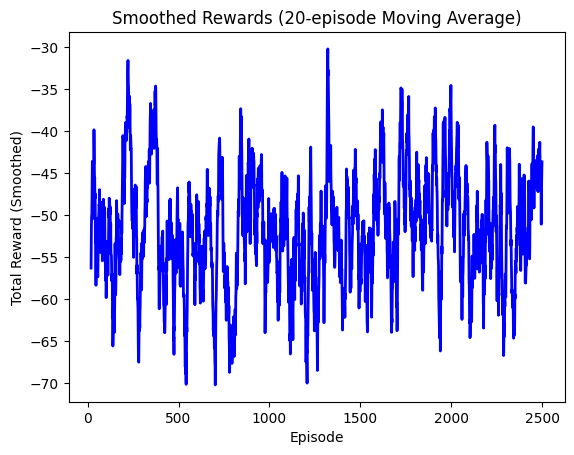

In [63]:
import pandas as pd
plt.plot(pd.Series(newlr2_rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()

In [64]:
# TUNING the model:

In [65]:
class TrafficEnv(gym.Env):
    def __init__(self, data):
        super(TrafficEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.max_index = len(data) - 1

        # Define spaces
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(len(data.columns)-1,), dtype=np.float32)
        self.action_space = spaces.Discrete(4)  # 4 signal phases

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Start from a random point in dataset
        self.current_step = np.random.randint(0, self.max_index - 50)
        obs = self.data.iloc[self.current_step, :-1].values.astype(np.float32)
        info = {}
        return obs, info

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_index

        row = self.data.iloc[self.current_step]
        wait_time = row.get('waiting_time', 0)
        queue_len = row.get('queue_length', 0)
        emergency = row.get('emergency_detected', 0) if 'emergency_detected' in row else 0

        reward = self.compute_reward(wait_time, queue_len, emergency, action)
        next_obs = row[:-1].values.astype(np.float32)
        truncated = False
        info = {}

        return next_obs, reward, done, truncated, info

    def compute_reward(self, wait_time, queue_len, emergency_detected, action):
        wait_time = wait_time / 100
        queue_len = queue_len / 50
        reward = - (0.6 * wait_time + 0.4 * queue_len)
        if emergency_detected:
          reward += 10
        return reward
        '''
        reward = - (0.7 * wait_time + 0.3 * queue_len)
        if emergency_detected and action == 0:  # example: NS-green helps emergency
            reward += 20
        return reward'''

    def render(self):
        pass


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json, os
from tqdm import tqdm


env = TrafficEnv(data)

# Load agent with same architecture
agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)

# Load previous trained weights if available
model_path = "ppo_traffic_model_3500.pt"
if os.path.exists(model_path):
    agent.load_state_dict(torch.load(model_path))
    print("Loaded existing trained model:", model_path)
else:
    print("No previous model found — training will start fresh.")


# 2️ PPO Evaluation function (NO EXPLORATION)
def evaluate(agent, env, episodes=10):
    rewards = []
    for _ in range(episodes):
        s, _ = env.reset()
        done = False
        total = 0
        while not done:
            a, _ = agent.act(s)   # greedy action (actor takes highest prob)
            s, r, done, truncated, _ = env.step(a)
            total += r
        rewards.append(total)
    return np.mean(rewards)


# 3 TRAINING FUNCTION (NEW)
def train_ppo_next_phase(
    episodes=1000,
    gamma=0.99,
    clip_epsilon=0.2,
    save_path="ppo_traffic_model_latest.pt",
    rewards_path="reward_log.json"
):
    # Load previous reward log
    reward_history = []
    if os.path.exists(rewards_path):
        with open(rewards_path, "r") as f:
            reward_history = json.load(f)
        print(f"Loaded {len(reward_history)} previous reward entries.")

    # LR scheduler — reduces LR when improvement plateaus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        agent.optimizer,
        mode='max',
        factor=0.5,     # Halve the LR
        patience=5,     # Wait 5 eval cycles
        min_lr=1e-6
        # verbose=True  # Removed verbose argument
    )

    print("\n Starting Next-Phase Training...\n")

    for ep in tqdm(range(episodes)):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, log_prob = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)

            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            value = agent.critic(state_tensor)
            next_value = agent.critic(next_state_tensor)
            advantage = reward_tensor + gamma * next_value - value

            new_log_prob, _, entropy = agent.evaluate(
                state_tensor, torch.tensor([action], dtype=torch.long)
            )

            ratio = (new_log_prob - log_prob).exp()
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantage.detach()
            loss = -torch.min(surr1, surr2) + 0.5 * advantage.pow(2) - 0.01 * entropy

            agent.optimizer.zero_grad()
            loss.mean().backward()
            agent.optimizer.step()

            total_reward += reward
            state = next_state

        reward_history.append(total_reward)
        print(f"Episode {len(reward_history)} | Reward: {total_reward:.2f}")

        # Every 100 episodes → evaluate & adjust LR
        if (ep + 1) % 100 == 0:
            eval_reward = evaluate(agent, env, episodes=5)
            print(f"Evaluation Reward after {len(reward_history)} eps: {eval_reward:.2f}")

            scheduler.step(eval_reward)

            # Save progress
            torch.save(agent.state_dict(), save_path)
            with open(rewards_path, "w") as f:
                json.dump(reward_history, f)
            print("💾 Autosaved model + rewards.")

    # final save
    torch.save(agent.state_dict(), save_path)
    with open(rewards_path, "w") as f:
        json.dump(reward_history, f)

    print("\nTraining Phase Complete!")
    return reward_history


# 4️ Run training
new_rewards = train_ppo_next_phase(episodes=500)

✔ Loaded existing trained model: ppo_traffic_model_3500.pt
✔ Loaded 3500 previous reward entries.

 Starting Next-Phase Training...



  0%|          | 1/500 [00:01<12:37,  1.52s/it]

Episode 3501 | Reward: -1.24


  0%|          | 2/500 [00:03<14:27,  1.74s/it]

Episode 3502 | Reward: -1.66


  1%|          | 3/500 [00:03<09:24,  1.14s/it]

Episode 3503 | Reward: -0.37


  1%|          | 4/500 [00:06<15:28,  1.87s/it]

Episode 3504 | Reward: -2.60


  1%|          | 5/500 [00:07<10:57,  1.33s/it]

Episode 3505 | Reward: -0.33


  1%|          | 6/500 [00:08<11:15,  1.37s/it]

Episode 3506 | Reward: -1.25


  1%|▏         | 7/500 [00:11<14:39,  1.78s/it]

Episode 3507 | Reward: -2.32


  2%|▏         | 8/500 [00:11<11:19,  1.38s/it]

Episode 3508 | Reward: -0.46


  2%|▏         | 9/500 [00:14<13:42,  1.68s/it]

Episode 3509 | Reward: -2.05


  2%|▏         | 10/500 [00:14<10:17,  1.26s/it]

Episode 3510 | Reward: -0.31


  2%|▏         | 11/500 [00:14<07:53,  1.03it/s]

Episode 3511 | Reward: -0.29


  2%|▏         | 12/500 [00:17<11:04,  1.36s/it]

Episode 3512 | Reward: -1.90


  3%|▎         | 13/500 [00:18<11:11,  1.38s/it]

Episode 3513 | Reward: -1.24


  3%|▎         | 14/500 [00:19<09:16,  1.15s/it]

Episode 3514 | Reward: -0.54


  3%|▎         | 15/500 [00:21<12:18,  1.52s/it]

Episode 3515 | Reward: -2.10


  3%|▎         | 16/500 [00:23<14:07,  1.75s/it]

Episode 3516 | Reward: -1.97


  3%|▎         | 17/500 [00:24<12:05,  1.50s/it]

Episode 3517 | Reward: -0.79


  4%|▎         | 18/500 [00:24<09:03,  1.13s/it]

Episode 3518 | Reward: -0.25


  4%|▍         | 19/500 [00:26<10:04,  1.26s/it]

Episode 3519 | Reward: -1.31


  4%|▍         | 20/500 [00:27<10:22,  1.30s/it]

Episode 3520 | Reward: -1.18


  4%|▍         | 21/500 [00:29<12:19,  1.54s/it]

Episode 3521 | Reward: -1.87


  4%|▍         | 22/500 [00:31<12:08,  1.52s/it]

Episode 3522 | Reward: -1.25


  5%|▍         | 23/500 [00:33<14:32,  1.83s/it]

Episode 3523 | Reward: -2.24


  5%|▍         | 24/500 [00:35<13:36,  1.72s/it]

Episode 3524 | Reward: -1.26


  5%|▌         | 25/500 [00:35<10:00,  1.26s/it]

Episode 3525 | Reward: -0.21


  5%|▌         | 26/500 [00:38<12:56,  1.64s/it]

Episode 3526 | Reward: -2.15


  6%|▌         | 28/500 [00:39<08:39,  1.10s/it]

Episode 3527 | Reward: -1.04
Episode 3528 | Reward: -0.16


  6%|▌         | 29/500 [00:42<12:34,  1.60s/it]

Episode 3529 | Reward: -2.46


  6%|▌         | 30/500 [00:44<15:00,  1.92s/it]

Episode 3530 | Reward: -2.34


  6%|▌         | 31/500 [00:47<16:49,  2.15s/it]

Episode 3531 | Reward: -2.37


  6%|▋         | 32/500 [00:49<16:52,  2.16s/it]

Episode 3532 | Reward: -1.91


  7%|▋         | 33/500 [00:51<15:14,  1.96s/it]

Episode 3533 | Reward: -1.26


  7%|▋         | 34/500 [00:53<14:40,  1.89s/it]

Episode 3534 | Reward: -1.51


  7%|▋         | 35/500 [00:53<10:57,  1.41s/it]

Episode 3535 | Reward: -0.29


  7%|▋         | 36/500 [00:54<10:44,  1.39s/it]

Episode 3536 | Reward: -1.14


  7%|▋         | 37/500 [00:55<08:29,  1.10s/it]

Episode 3537 | Reward: -0.38


  8%|▊         | 38/500 [00:55<07:20,  1.05it/s]

Episode 3538 | Reward: -0.54


  8%|▊         | 39/500 [00:56<06:54,  1.11it/s]

Episode 3539 | Reward: -0.68


  8%|▊         | 40/500 [00:58<09:54,  1.29s/it]

Episode 3540 | Reward: -1.91


  8%|▊         | 41/500 [00:59<09:40,  1.26s/it]

Episode 3541 | Reward: -1.04


  8%|▊         | 42/500 [01:00<09:05,  1.19s/it]

Episode 3542 | Reward: -0.88


  9%|▊         | 43/500 [01:01<08:12,  1.08s/it]

Episode 3543 | Reward: -0.69


  9%|▉         | 44/500 [01:04<12:18,  1.62s/it]

Episode 3544 | Reward: -2.55


  9%|▉         | 45/500 [01:05<10:20,  1.36s/it]

Episode 3545 | Reward: -0.63


  9%|▉         | 46/500 [01:06<10:22,  1.37s/it]

Episode 3546 | Reward: -1.18


  9%|▉         | 47/500 [01:08<11:13,  1.49s/it]

Episode 3547 | Reward: -1.49


 10%|▉         | 48/500 [01:09<10:11,  1.35s/it]

Episode 3548 | Reward: -0.91


 10%|▉         | 49/500 [01:12<13:03,  1.74s/it]

Episode 3549 | Reward: -2.32


 10%|█         | 50/500 [01:14<15:12,  2.03s/it]

Episode 3550 | Reward: -2.42


 10%|█         | 51/500 [01:16<13:56,  1.86s/it]

Episode 3551 | Reward: -1.23


 10%|█         | 52/500 [01:18<13:58,  1.87s/it]

Episode 3552 | Reward: -1.63


 11%|█         | 53/500 [01:20<14:15,  1.91s/it]

Episode 3553 | Reward: -1.77


 11%|█         | 54/500 [01:22<14:08,  1.90s/it]

Episode 3554 | Reward: -1.61


 11%|█         | 55/500 [01:24<15:04,  2.03s/it]

Episode 3555 | Reward: -2.06


 11%|█         | 56/500 [01:25<13:48,  1.87s/it]

Episode 3556 | Reward: -1.28


 11%|█▏        | 57/500 [01:26<10:32,  1.43s/it]

Episode 3557 | Reward: -0.36


 12%|█▏        | 58/500 [01:28<13:10,  1.79s/it]

Episode 3558 | Reward: -2.28


 12%|█▏        | 59/500 [01:31<13:36,  1.85s/it]

Episode 3559 | Reward: -1.77


 12%|█▏        | 60/500 [01:33<15:58,  2.18s/it]

Episode 3560 | Reward: -2.56


 12%|█▏        | 61/500 [01:35<14:44,  2.02s/it]

Episode 3561 | Reward: -1.41


 12%|█▏        | 62/500 [01:36<12:45,  1.75s/it]

Episode 3562 | Reward: -0.97


 13%|█▎        | 63/500 [01:38<13:25,  1.84s/it]

Episode 3563 | Reward: -1.76


 13%|█▎        | 65/500 [01:41<11:24,  1.57s/it]

Episode 3564 | Reward: -2.59
Episode 3565 | Reward: -0.20


 13%|█▎        | 66/500 [01:43<12:28,  1.72s/it]

Episode 3566 | Reward: -1.81


 13%|█▎        | 67/500 [01:44<10:57,  1.52s/it]

Episode 3567 | Reward: -0.91


 14%|█▎        | 68/500 [01:47<13:32,  1.88s/it]

Episode 3568 | Reward: -2.36


 14%|█▍        | 69/500 [01:50<15:34,  2.17s/it]

Episode 3569 | Reward: -2.52


 14%|█▍        | 70/500 [01:52<14:24,  2.01s/it]

Episode 3570 | Reward: -1.39


 14%|█▍        | 71/500 [01:54<14:25,  2.02s/it]

Episode 3571 | Reward: -1.77


 14%|█▍        | 72/500 [01:54<10:35,  1.48s/it]

Episode 3572 | Reward: -0.23


 15%|█▍        | 73/500 [01:56<11:52,  1.67s/it]

Episode 3573 | Reward: -1.85


 15%|█▍        | 74/500 [01:58<11:20,  1.60s/it]

Episode 3574 | Reward: -1.23


 15%|█▌        | 75/500 [01:58<09:50,  1.39s/it]

Episode 3575 | Reward: -0.77


 15%|█▌        | 76/500 [02:00<11:05,  1.57s/it]

Episode 3576 | Reward: -1.73


 15%|█▌        | 77/500 [02:01<08:29,  1.20s/it]

Episode 3577 | Reward: -0.32


 16%|█▌        | 78/500 [02:04<11:57,  1.70s/it]

Episode 3578 | Reward: -2.52


 16%|█▌        | 79/500 [02:05<12:00,  1.71s/it]

Episode 3579 | Reward: -1.47


 16%|█▌        | 80/500 [02:06<10:20,  1.48s/it]

Episode 3580 | Reward: -0.78


 16%|█▌        | 81/500 [02:08<11:32,  1.65s/it]

Episode 3581 | Reward: -1.77


 16%|█▋        | 82/500 [02:10<11:19,  1.63s/it]

Episode 3582 | Reward: -1.35


 17%|█▋        | 83/500 [02:12<12:01,  1.73s/it]

Episode 3583 | Reward: -1.70


 17%|█▋        | 84/500 [02:13<09:52,  1.42s/it]

Episode 3584 | Reward: -0.62


 17%|█▋        | 85/500 [02:15<11:56,  1.73s/it]

Episode 3585 | Reward: -2.15


 17%|█▋        | 86/500 [02:17<12:39,  1.83s/it]

Episode 3586 | Reward: -1.77


 17%|█▋        | 87/500 [02:19<13:26,  1.95s/it]

Episode 3587 | Reward: -1.93


 18%|█▊        | 88/500 [02:20<10:31,  1.53s/it]

Episode 3588 | Reward: -0.49


 18%|█▊        | 89/500 [02:21<09:43,  1.42s/it]

Episode 3589 | Reward: -1.00


 18%|█▊        | 90/500 [02:23<10:43,  1.57s/it]

Episode 3590 | Reward: -1.65


 18%|█▊        | 91/500 [02:25<11:34,  1.70s/it]

Episode 3591 | Reward: -1.76


 18%|█▊        | 92/500 [02:26<11:06,  1.63s/it]

Episode 3592 | Reward: -1.25


 19%|█▊        | 93/500 [02:29<12:23,  1.83s/it]

Episode 3593 | Reward: -1.98


 19%|█▉        | 94/500 [02:31<12:18,  1.82s/it]

Episode 3594 | Reward: -1.57


 19%|█▉        | 95/500 [02:32<11:14,  1.67s/it]

Episode 3595 | Reward: -1.12


 19%|█▉        | 96/500 [02:34<12:03,  1.79s/it]

Episode 3596 | Reward: -1.83


 19%|█▉        | 97/500 [02:35<11:07,  1.66s/it]

Episode 3597 | Reward: -1.17


 20%|█▉        | 98/500 [02:36<09:18,  1.39s/it]

Episode 3598 | Reward: -0.68


 20%|█▉        | 99/500 [02:38<10:28,  1.57s/it]

Episode 3599 | Reward: -1.67
Episode 3600 | Reward: -2.16


 20%|██        | 100/500 [02:42<14:48,  2.22s/it]

🧪 Evaluation Reward after 3600 eps: -1.09
💾 Autosaved model + rewards.


 20%|██        | 101/500 [02:44<15:28,  2.33s/it]

Episode 3601 | Reward: -2.25


 20%|██        | 102/500 [02:47<15:33,  2.34s/it]

Episode 3602 | Reward: -2.09


 21%|██        | 103/500 [02:49<15:51,  2.40s/it]

Episode 3603 | Reward: -2.17


 21%|██        | 104/500 [02:50<12:58,  1.97s/it]

Episode 3604 | Reward: -0.84


 21%|██        | 105/500 [02:53<14:51,  2.26s/it]

Episode 3605 | Reward: -2.59


 21%|██        | 106/500 [02:55<14:44,  2.25s/it]

Episode 3606 | Reward: -1.79


 21%|██▏       | 107/500 [02:57<13:28,  2.06s/it]

Episode 3607 | Reward: -1.32


 22%|██▏       | 108/500 [02:58<11:26,  1.75s/it]

Episode 3608 | Reward: -0.85


 22%|██▏       | 109/500 [02:59<09:13,  1.42s/it]

Episode 3609 | Reward: -0.52


 22%|██▏       | 110/500 [03:01<11:48,  1.82s/it]

Episode 3610 | Reward: -2.41


 22%|██▏       | 111/500 [03:04<12:49,  1.98s/it]

Episode 3611 | Reward: -2.05


 22%|██▏       | 112/500 [03:06<12:45,  1.97s/it]

Episode 3612 | Reward: -1.67


 23%|██▎       | 113/500 [03:08<13:26,  2.08s/it]

Episode 3613 | Reward: -2.04


 23%|██▎       | 114/500 [03:09<10:43,  1.67s/it]

Episode 3614 | Reward: -0.58


 23%|██▎       | 115/500 [03:11<12:22,  1.93s/it]

Episode 3615 | Reward: -2.20


 23%|██▎       | 116/500 [03:13<11:21,  1.77s/it]

Episode 3616 | Reward: -1.20


 23%|██▎       | 117/500 [03:13<08:31,  1.34s/it]

Episode 3617 | Reward: -0.28


 24%|██▎       | 118/500 [03:15<10:38,  1.67s/it]

Episode 3618 | Reward: -2.15


 24%|██▍       | 120/500 [03:17<07:40,  1.21s/it]

Episode 3619 | Reward: -1.37
Episode 3620 | Reward: -0.13


 24%|██▍       | 121/500 [03:20<10:22,  1.64s/it]

Episode 3621 | Reward: -2.20


 24%|██▍       | 122/500 [03:20<07:53,  1.25s/it]

Episode 3622 | Reward: -0.30


 25%|██▍       | 123/500 [03:21<07:09,  1.14s/it]

Episode 3623 | Reward: -0.74


 25%|██▍       | 124/500 [03:24<09:57,  1.59s/it]

Episode 3624 | Reward: -2.31


 25%|██▌       | 125/500 [03:24<08:05,  1.29s/it]

Episode 3625 | Reward: -0.52


 25%|██▌       | 126/500 [03:26<08:08,  1.31s/it]

Episode 3626 | Reward: -1.15


 25%|██▌       | 127/500 [03:26<06:26,  1.04s/it]

Episode 3627 | Reward: -0.37


 26%|██▌       | 128/500 [03:27<06:15,  1.01s/it]

Episode 3628 | Reward: -0.78


 26%|██▌       | 129/500 [03:28<06:41,  1.08s/it]

Episode 3629 | Reward: -1.07


 26%|██▌       | 130/500 [03:31<09:39,  1.57s/it]

Episode 3630 | Reward: -2.38


 26%|██▌       | 131/500 [03:33<10:32,  1.71s/it]

Episode 3631 | Reward: -1.77


 26%|██▋       | 132/500 [03:34<08:33,  1.40s/it]

Episode 3632 | Reward: -0.56


 27%|██▋       | 133/500 [03:34<07:00,  1.15s/it]

Episode 3633 | Reward: -0.49


 27%|██▋       | 134/500 [03:36<07:19,  1.20s/it]

Episode 3634 | Reward: -1.15


 27%|██▋       | 135/500 [03:38<09:15,  1.52s/it]

Episode 3635 | Reward: -1.95


 27%|██▋       | 136/500 [03:40<10:15,  1.69s/it]

Episode 3636 | Reward: -1.80


 27%|██▋       | 137/500 [03:42<10:01,  1.66s/it]

Episode 3637 | Reward: -1.35


 28%|██▊       | 139/500 [03:43<07:19,  1.22s/it]

Episode 3638 | Reward: -1.40
Episode 3639 | Reward: -0.15


 28%|██▊       | 140/500 [03:46<09:19,  1.55s/it]

Episode 3640 | Reward: -2.06


 28%|██▊       | 141/500 [03:47<09:02,  1.51s/it]

Episode 3641 | Reward: -1.21


 28%|██▊       | 142/500 [03:48<07:27,  1.25s/it]

Episode 3642 | Reward: -0.55


 29%|██▊       | 143/500 [03:49<07:25,  1.25s/it]

Episode 3643 | Reward: -1.04


 29%|██▉       | 144/500 [03:52<10:10,  1.72s/it]

Episode 3644 | Reward: -2.49


 29%|██▉       | 145/500 [03:54<11:32,  1.95s/it]

Episode 3645 | Reward: -2.19


 29%|██▉       | 146/500 [03:57<12:22,  2.10s/it]

Episode 3646 | Reward: -2.15


 29%|██▉       | 147/500 [03:59<12:07,  2.06s/it]

Episode 3647 | Reward: -1.70


 30%|██▉       | 148/500 [03:59<08:49,  1.50s/it]

Episode 3648 | Reward: -0.20


 30%|██▉       | 149/500 [04:01<09:23,  1.60s/it]

Episode 3649 | Reward: -1.54


 30%|███       | 150/500 [04:01<07:33,  1.30s/it]

Episode 3650 | Reward: -0.50


 30%|███       | 151/500 [04:04<09:32,  1.64s/it]

Episode 3651 | Reward: -2.13


 30%|███       | 152/500 [04:05<09:18,  1.61s/it]

Episode 3652 | Reward: -1.28


 31%|███       | 153/500 [04:06<07:34,  1.31s/it]

Episode 3653 | Reward: -0.54


 31%|███       | 154/500 [04:07<06:38,  1.15s/it]

Episode 3654 | Reward: -0.67


 31%|███       | 155/500 [04:08<07:37,  1.33s/it]

Episode 3655 | Reward: -1.47


 31%|███       | 156/500 [04:11<09:21,  1.63s/it]

Episode 3656 | Reward: -2.00


 31%|███▏      | 157/500 [04:12<09:20,  1.64s/it]

Episode 3657 | Reward: -1.40


 32%|███▏      | 158/500 [04:14<08:22,  1.47s/it]

Episode 3658 | Reward: -0.92


 32%|███▏      | 159/500 [04:15<08:26,  1.48s/it]

Episode 3659 | Reward: -1.31


 32%|███▏      | 160/500 [04:16<07:31,  1.33s/it]

Episode 3660 | Reward: -0.79


 32%|███▏      | 161/500 [04:17<07:29,  1.33s/it]

Episode 3661 | Reward: -1.13


 32%|███▏      | 162/500 [04:18<07:03,  1.25s/it]

Episode 3662 | Reward: -0.92


 33%|███▎      | 163/500 [04:20<06:54,  1.23s/it]

Episode 3663 | Reward: -0.98


 33%|███▎      | 164/500 [04:22<08:17,  1.48s/it]

Episode 3664 | Reward: -1.80


 33%|███▎      | 165/500 [04:24<09:33,  1.71s/it]

Episode 3665 | Reward: -1.96


 33%|███▎      | 166/500 [04:27<11:17,  2.03s/it]

Episode 3666 | Reward: -2.43


 33%|███▎      | 167/500 [04:27<08:54,  1.60s/it]

Episode 3667 | Reward: -0.52


 34%|███▎      | 168/500 [04:29<08:46,  1.59s/it]

Episode 3668 | Reward: -1.32


 34%|███▍      | 169/500 [04:30<08:00,  1.45s/it]

Episode 3669 | Reward: -0.97


 34%|███▍      | 170/500 [04:32<08:19,  1.52s/it]

Episode 3670 | Reward: -1.41


 34%|███▍      | 171/500 [04:34<09:39,  1.76s/it]

Episode 3671 | Reward: -2.03


 34%|███▍      | 172/500 [04:37<11:26,  2.09s/it]

Episode 3672 | Reward: -2.55


 35%|███▍      | 173/500 [04:37<08:28,  1.55s/it]

Episode 3673 | Reward: -0.26


 35%|███▍      | 174/500 [04:39<08:07,  1.50s/it]

Episode 3674 | Reward: -1.15


 35%|███▌      | 175/500 [04:41<10:13,  1.89s/it]

Episode 3675 | Reward: -2.45


 35%|███▌      | 176/500 [04:43<09:39,  1.79s/it]

Episode 3676 | Reward: -1.32


 35%|███▌      | 177/500 [04:46<11:05,  2.06s/it]

Episode 3677 | Reward: -2.35


 36%|███▌      | 178/500 [04:46<08:30,  1.59s/it]

Episode 3678 | Reward: -0.41


 36%|███▌      | 179/500 [04:47<08:12,  1.53s/it]

Episode 3679 | Reward: -1.22


 36%|███▌      | 180/500 [04:48<07:08,  1.34s/it]

Episode 3680 | Reward: -0.72


 36%|███▌      | 181/500 [04:49<06:05,  1.15s/it]

Episode 3681 | Reward: -0.59


 36%|███▋      | 182/500 [04:51<07:23,  1.40s/it]

Episode 3682 | Reward: -1.70


 37%|███▋      | 183/500 [04:51<05:38,  1.07s/it]

Episode 3683 | Reward: -0.28


 37%|███▋      | 184/500 [04:54<07:26,  1.41s/it]

Episode 3684 | Reward: -1.91


 37%|███▋      | 185/500 [04:54<05:53,  1.12s/it]

Episode 3685 | Reward: -0.37


 37%|███▋      | 186/500 [04:55<05:16,  1.01s/it]

Episode 3686 | Reward: -0.66


 37%|███▋      | 187/500 [04:57<07:52,  1.51s/it]

Episode 3687 | Reward: -2.35


 38%|███▊      | 188/500 [04:59<07:44,  1.49s/it]

Episode 3688 | Reward: -1.23


 38%|███▊      | 189/500 [05:01<09:10,  1.77s/it]

Episode 3689 | Reward: -2.07


 38%|███▊      | 190/500 [05:02<08:12,  1.59s/it]

Episode 3690 | Reward: -0.99


 38%|███▊      | 191/500 [05:03<06:18,  1.23s/it]

Episode 3691 | Reward: -0.34


 38%|███▊      | 192/500 [05:04<06:54,  1.35s/it]

Episode 3692 | Reward: -1.34


 39%|███▊      | 193/500 [05:05<05:34,  1.09s/it]

Episode 3693 | Reward: -0.42


 39%|███▉      | 194/500 [05:08<07:58,  1.56s/it]

Episode 3694 | Reward: -2.34


 39%|███▉      | 195/500 [05:09<08:03,  1.59s/it]

Episode 3695 | Reward: -1.37


 39%|███▉      | 196/500 [05:11<08:22,  1.65s/it]

Episode 3696 | Reward: -1.52


 39%|███▉      | 197/500 [05:13<09:02,  1.79s/it]

Episode 3697 | Reward: -1.82


 40%|███▉      | 198/500 [05:16<10:48,  2.15s/it]

Episode 3698 | Reward: -2.61


 40%|███▉      | 199/500 [05:19<12:06,  2.41s/it]

Episode 3699 | Reward: -2.64
Episode 3700 | Reward: -0.68


 40%|████      | 200/500 [05:22<12:33,  2.51s/it]

🧪 Evaluation Reward after 3700 eps: -1.58
💾 Autosaved model + rewards.


 40%|████      | 201/500 [05:24<12:26,  2.50s/it]

Episode 3701 | Reward: -2.13


 40%|████      | 202/500 [05:27<12:44,  2.57s/it]

Episode 3702 | Reward: -2.37


 41%|████      | 203/500 [05:30<12:37,  2.55s/it]

Episode 3703 | Reward: -2.19


 41%|████      | 204/500 [05:32<12:44,  2.58s/it]

Episode 3704 | Reward: -2.27


 41%|████      | 205/500 [05:35<13:06,  2.67s/it]

Episode 3705 | Reward: -2.51


 41%|████      | 206/500 [05:38<12:52,  2.63s/it]

Episode 3706 | Reward: -2.21


 41%|████▏     | 207/500 [05:39<11:24,  2.34s/it]

Episode 3707 | Reward: -1.39


 42%|████▏     | 208/500 [05:40<09:26,  1.94s/it]

Episode 3708 | Reward: -0.86


 42%|████▏     | 209/500 [05:41<07:33,  1.56s/it]

Episode 3709 | Reward: -0.55


 42%|████▏     | 210/500 [05:43<08:33,  1.77s/it]

Episode 3710 | Reward: -1.94


 42%|████▏     | 211/500 [05:45<08:01,  1.67s/it]

Episode 3711 | Reward: -1.22


 42%|████▏     | 212/500 [05:46<07:55,  1.65s/it]

Episode 3712 | Reward: -1.37


 43%|████▎     | 213/500 [05:49<08:55,  1.87s/it]

Episode 3713 | Reward: -2.04


 43%|████▎     | 214/500 [05:49<07:16,  1.52s/it]

Episode 3714 | Reward: -0.61


 43%|████▎     | 215/500 [05:51<06:52,  1.45s/it]

Episode 3715 | Reward: -1.10


 43%|████▎     | 216/500 [05:53<07:53,  1.67s/it]

Episode 3716 | Reward: -1.87


 43%|████▎     | 217/500 [05:55<08:16,  1.76s/it]

Episode 3717 | Reward: -1.67


 44%|████▎     | 218/500 [05:55<06:06,  1.30s/it]

Episode 3718 | Reward: -0.23


 44%|████▍     | 220/500 [05:57<04:45,  1.02s/it]

Episode 3719 | Reward: -1.34
Episode 3720 | Reward: -0.17


 44%|████▍     | 221/500 [05:57<03:38,  1.28it/s]

Episode 3721 | Reward: -0.23


 44%|████▍     | 222/500 [05:57<02:57,  1.56it/s]

Episode 3722 | Reward: -0.27


 45%|████▍     | 223/500 [05:59<04:28,  1.03it/s]

Episode 3723 | Reward: -1.47


 45%|████▍     | 224/500 [06:01<05:21,  1.16s/it]

Episode 3724 | Reward: -1.37


 45%|████▌     | 225/500 [06:02<05:27,  1.19s/it]

Episode 3725 | Reward: -1.05


 45%|████▌     | 226/500 [06:02<04:10,  1.09it/s]

Episode 3726 | Reward: -0.25


 45%|████▌     | 227/500 [06:03<03:46,  1.21it/s]

Episode 3727 | Reward: -0.53


 46%|████▌     | 228/500 [06:05<04:59,  1.10s/it]

Episode 3728 | Reward: -1.44


 46%|████▌     | 229/500 [06:07<07:17,  1.61s/it]

Episode 3729 | Reward: -2.47


 46%|████▌     | 230/500 [06:08<06:29,  1.44s/it]

Episode 3730 | Reward: -0.87


 46%|████▌     | 231/500 [06:10<06:42,  1.50s/it]

Episode 3731 | Reward: -1.36


 46%|████▋     | 232/500 [06:13<08:29,  1.90s/it]

Episode 3732 | Reward: -2.43


 47%|████▋     | 233/500 [06:16<09:41,  2.18s/it]

Episode 3733 | Reward: -2.47


 47%|████▋     | 234/500 [06:16<07:12,  1.63s/it]

Episode 3734 | Reward: -0.30


 47%|████▋     | 235/500 [06:17<06:01,  1.36s/it]

Episode 3735 | Reward: -0.66


 47%|████▋     | 236/500 [06:18<06:23,  1.45s/it]

Episode 3736 | Reward: -1.38


 47%|████▋     | 237/500 [06:21<07:17,  1.67s/it]

Episode 3737 | Reward: -1.87


 48%|████▊     | 238/500 [06:21<05:36,  1.28s/it]

Episode 3738 | Reward: -0.33


 48%|████▊     | 239/500 [06:23<06:07,  1.41s/it]

Episode 3739 | Reward: -1.39


 48%|████▊     | 240/500 [06:25<07:37,  1.76s/it]

Episode 3740 | Reward: -2.26


 48%|████▊     | 241/500 [06:27<07:56,  1.84s/it]

Episode 3741 | Reward: -1.74


 48%|████▊     | 242/500 [06:30<09:00,  2.09s/it]

Episode 3742 | Reward: -2.34


 49%|████▊     | 243/500 [06:32<08:47,  2.05s/it]

Episode 3743 | Reward: -1.66


 49%|████▉     | 244/500 [06:33<07:51,  1.84s/it]

Episode 3744 | Reward: -1.13


 49%|████▉     | 245/500 [06:35<06:58,  1.64s/it]

Episode 3745 | Reward: -1.00


 49%|████▉     | 246/500 [06:37<07:36,  1.80s/it]

Episode 3746 | Reward: -1.88


 49%|████▉     | 247/500 [06:38<06:44,  1.60s/it]

Episode 3747 | Reward: -0.96


 50%|████▉     | 248/500 [06:41<08:30,  2.03s/it]

Episode 3748 | Reward: -2.65


 50%|████▉     | 249/500 [06:43<08:32,  2.04s/it]

Episode 3749 | Reward: -1.77


 50%|█████     | 250/500 [06:44<06:47,  1.63s/it]

Episode 3750 | Reward: -0.56


 50%|█████     | 251/500 [06:45<06:58,  1.68s/it]

Episode 3751 | Reward: -1.55


 50%|█████     | 252/500 [06:48<08:35,  2.08s/it]

Episode 3752 | Reward: -2.62


 51%|█████     | 253/500 [06:51<08:42,  2.12s/it]

Episode 3753 | Reward: -1.91


 51%|█████     | 254/500 [06:52<08:00,  1.95s/it]

Episode 3754 | Reward: -1.32


 51%|█████     | 255/500 [06:54<08:25,  2.06s/it]

Episode 3755 | Reward: -2.01


 51%|█████     | 256/500 [06:57<08:43,  2.15s/it]

Episode 3756 | Reward: -2.01


 51%|█████▏    | 257/500 [06:58<07:20,  1.81s/it]

Episode 3757 | Reward: -0.88


 52%|█████▏    | 258/500 [06:59<06:21,  1.58s/it]

Episode 3758 | Reward: -0.86


 52%|█████▏    | 259/500 [07:01<06:40,  1.66s/it]

Episode 3759 | Reward: -1.56


 52%|█████▏    | 260/500 [07:03<07:31,  1.88s/it]

Episode 3760 | Reward: -2.02


 52%|█████▏    | 261/500 [07:05<07:11,  1.81s/it]

Episode 3761 | Reward: -1.35


 52%|█████▏    | 262/500 [07:08<08:19,  2.10s/it]

Episode 3762 | Reward: -2.43


 53%|█████▎    | 263/500 [07:10<08:19,  2.11s/it]

Episode 3763 | Reward: -1.86


 53%|█████▎    | 264/500 [07:10<06:15,  1.59s/it]

Episode 3764 | Reward: -0.32


 53%|█████▎    | 265/500 [07:13<07:47,  1.99s/it]

Episode 3765 | Reward: -2.55


 53%|█████▎    | 266/500 [07:14<06:37,  1.70s/it]

Episode 3766 | Reward: -0.86


 53%|█████▎    | 267/500 [07:16<06:21,  1.64s/it]

Episode 3767 | Reward: -1.24


 54%|█████▎    | 268/500 [07:16<04:59,  1.29s/it]

Episode 3768 | Reward: -0.41


 54%|█████▍    | 269/500 [07:16<03:50,  1.00it/s]

Episode 3769 | Reward: -0.29


 54%|█████▍    | 270/500 [07:18<04:17,  1.12s/it]

Episode 3770 | Reward: -1.21


 54%|█████▍    | 271/500 [07:19<04:44,  1.24s/it]

Episode 3771 | Reward: -1.31


 54%|█████▍    | 272/500 [07:22<06:04,  1.60s/it]

Episode 3772 | Reward: -2.09


 55%|█████▍    | 273/500 [07:25<07:39,  2.02s/it]

Episode 3773 | Reward: -2.63


 55%|█████▍    | 274/500 [07:25<05:50,  1.55s/it]

Episode 3774 | Reward: -0.38


 55%|█████▌    | 275/500 [07:26<04:31,  1.21s/it]

Episode 3775 | Reward: -0.36


 55%|█████▌    | 276/500 [07:26<04:14,  1.14s/it]

Episode 3776 | Reward: -0.82


 55%|█████▌    | 277/500 [07:29<05:20,  1.44s/it]

Episode 3777 | Reward: -1.87


 56%|█████▌    | 278/500 [07:30<05:30,  1.49s/it]

Episode 3778 | Reward: -1.37


 56%|█████▌    | 279/500 [07:33<06:23,  1.74s/it]

Episode 3779 | Reward: -1.99


 56%|█████▌    | 280/500 [07:34<06:34,  1.79s/it]

Episode 3780 | Reward: -1.64


 56%|█████▌    | 281/500 [07:37<07:15,  1.99s/it]

Episode 3781 | Reward: -2.15


 56%|█████▋    | 282/500 [07:39<07:44,  2.13s/it]

Episode 3782 | Reward: -2.13


 57%|█████▋    | 284/500 [07:41<05:11,  1.44s/it]

Episode 3783 | Reward: -1.44
Episode 3784 | Reward: -0.13


 57%|█████▋    | 285/500 [07:43<05:50,  1.63s/it]

Episode 3785 | Reward: -1.75


 57%|█████▋    | 286/500 [07:46<06:47,  1.90s/it]

Episode 3786 | Reward: -2.23


 57%|█████▋    | 287/500 [07:46<05:23,  1.52s/it]

Episode 3787 | Reward: -0.52


 58%|█████▊    | 288/500 [07:49<06:39,  1.88s/it]

Episode 3788 | Reward: -2.38


 58%|█████▊    | 289/500 [07:50<05:14,  1.49s/it]

Episode 3789 | Reward: -0.50


 58%|█████▊    | 290/500 [07:53<06:36,  1.89s/it]

Episode 3790 | Reward: -2.46


 58%|█████▊    | 291/500 [07:55<07:00,  2.01s/it]

Episode 3791 | Reward: -1.95


 58%|█████▊    | 292/500 [07:55<05:05,  1.47s/it]

Episode 3792 | Reward: -0.20


 59%|█████▊    | 293/500 [07:57<05:59,  1.74s/it]

Episode 3793 | Reward: -2.05


 59%|█████▉    | 294/500 [07:58<05:11,  1.51s/it]

Episode 3794 | Reward: -0.84


 59%|█████▉    | 295/500 [07:59<04:03,  1.19s/it]

Episode 3795 | Reward: -0.38


 59%|█████▉    | 296/500 [08:01<05:25,  1.59s/it]

Episode 3796 | Reward: -2.21


 59%|█████▉    | 297/500 [08:02<04:14,  1.25s/it]

Episode 3797 | Reward: -0.41


 60%|█████▉    | 298/500 [08:02<03:24,  1.01s/it]

Episode 3798 | Reward: -0.40


 60%|█████▉    | 299/500 [08:05<04:40,  1.39s/it]

Episode 3799 | Reward: -1.93
Episode 3800 | Reward: -0.38


 60%|██████    | 300/500 [08:06<05:06,  1.53s/it]

🧪 Evaluation Reward after 3800 eps: -1.17
💾 Autosaved model + rewards.


 60%|██████    | 301/500 [08:08<05:26,  1.64s/it]

Episode 3801 | Reward: -1.61


 60%|██████    | 302/500 [08:09<04:52,  1.48s/it]

Episode 3802 | Reward: -0.94


 61%|██████    | 304/500 [08:13<04:38,  1.42s/it]

Episode 3803 | Reward: -2.71
Episode 3804 | Reward: -0.12


 61%|██████    | 305/500 [08:14<04:15,  1.31s/it]

Episode 3805 | Reward: -0.88


 61%|██████    | 306/500 [08:17<05:52,  1.82s/it]

Episode 3806 | Reward: -2.62


 61%|██████▏   | 307/500 [08:19<06:42,  2.09s/it]

Episode 3807 | Reward: -2.35


 62%|██████▏   | 309/500 [08:22<05:09,  1.62s/it]

Episode 3808 | Reward: -2.23
Episode 3809 | Reward: -0.19


 62%|██████▏   | 310/500 [08:23<04:26,  1.40s/it]

Episode 3810 | Reward: -0.77


 62%|██████▏   | 311/500 [08:26<05:54,  1.88s/it]

Episode 3811 | Reward: -2.59


 62%|██████▏   | 312/500 [08:28<06:08,  1.96s/it]

Episode 3812 | Reward: -1.86


 63%|██████▎   | 313/500 [08:30<06:18,  2.02s/it]

Episode 3813 | Reward: -1.88


 63%|██████▎   | 314/500 [08:33<06:40,  2.15s/it]

Episode 3814 | Reward: -2.14


 63%|██████▎   | 315/500 [08:35<06:23,  2.07s/it]

Episode 3815 | Reward: -1.60


 63%|██████▎   | 316/500 [08:35<05:02,  1.64s/it]

Episode 3816 | Reward: -0.55


 63%|██████▎   | 317/500 [08:37<05:20,  1.75s/it]

Episode 3817 | Reward: -1.73


 64%|██████▎   | 318/500 [08:40<05:55,  1.95s/it]

Episode 3818 | Reward: -2.08


 64%|██████▍   | 319/500 [08:40<04:37,  1.53s/it]

Episode 3819 | Reward: -0.47


 64%|██████▍   | 320/500 [08:41<03:44,  1.25s/it]

Episode 3820 | Reward: -0.48


 64%|██████▍   | 322/500 [08:43<03:08,  1.06s/it]

Episode 3821 | Reward: -1.61
Episode 3822 | Reward: -0.15


 65%|██████▍   | 323/500 [08:44<02:53,  1.02it/s]

Episode 3823 | Reward: -0.66


 65%|██████▍   | 324/500 [08:47<04:36,  1.57s/it]

Episode 3824 | Reward: -2.59


 65%|██████▌   | 326/500 [08:49<03:51,  1.33s/it]

Episode 3825 | Reward: -2.13
Episode 3826 | Reward: -0.15


 65%|██████▌   | 327/500 [08:50<03:10,  1.10s/it]

Episode 3827 | Reward: -0.49


 66%|██████▌   | 328/500 [08:52<04:19,  1.51s/it]

Episode 3828 | Reward: -2.16


 66%|██████▌   | 329/500 [08:55<05:17,  1.86s/it]

Episode 3829 | Reward: -2.31


 66%|██████▌   | 330/500 [08:58<05:57,  2.10s/it]

Episode 3830 | Reward: -2.34


 66%|██████▌   | 331/500 [08:58<04:22,  1.56s/it]

Episode 3831 | Reward: -0.26


 66%|██████▋   | 332/500 [09:01<05:15,  1.88s/it]

Episode 3832 | Reward: -2.26


 67%|██████▋   | 333/500 [09:03<05:18,  1.91s/it]

Episode 3833 | Reward: -1.70


 67%|██████▋   | 335/500 [09:06<04:23,  1.60s/it]

Episode 3834 | Reward: -2.56
Episode 3835 | Reward: -0.11


 67%|██████▋   | 336/500 [09:07<04:07,  1.51s/it]

Episode 3836 | Reward: -1.12


 67%|██████▋   | 337/500 [09:09<04:17,  1.58s/it]

Episode 3837 | Reward: -1.47


 68%|██████▊   | 338/500 [09:12<05:27,  2.02s/it]

Episode 3838 | Reward: -2.66


 68%|██████▊   | 339/500 [09:13<04:37,  1.72s/it]

Episode 3839 | Reward: -0.87


 68%|██████▊   | 340/500 [09:16<05:23,  2.02s/it]

Episode 3840 | Reward: -2.35


 68%|██████▊   | 341/500 [09:18<05:47,  2.19s/it]

Episode 3841 | Reward: -2.24


 68%|██████▊   | 342/500 [09:19<04:47,  1.82s/it]

Episode 3842 | Reward: -0.79


 69%|██████▊   | 343/500 [09:20<04:16,  1.63s/it]

Episode 3843 | Reward: -1.04


 69%|██████▉   | 344/500 [09:23<04:55,  1.90s/it]

Episode 3844 | Reward: -2.17


 69%|██████▉   | 345/500 [09:26<05:43,  2.21s/it]

Episode 3845 | Reward: -2.59


 69%|██████▉   | 346/500 [09:29<06:09,  2.40s/it]

Episode 3846 | Reward: -2.44


 69%|██████▉   | 347/500 [09:29<04:52,  1.91s/it]

Episode 3847 | Reward: -0.68


 70%|██████▉   | 348/500 [09:31<04:36,  1.82s/it]

Episode 3848 | Reward: -1.35


 70%|██████▉   | 349/500 [09:33<04:54,  1.95s/it]

Episode 3849 | Reward: -1.94


 70%|███████   | 350/500 [09:36<05:34,  2.23s/it]

Episode 3850 | Reward: -2.51


 70%|███████   | 351/500 [09:39<06:06,  2.46s/it]

Episode 3851 | Reward: -2.60


 70%|███████   | 352/500 [09:40<04:51,  1.97s/it]

Episode 3852 | Reward: -0.73


 71%|███████   | 353/500 [09:42<05:04,  2.07s/it]

Episode 3853 | Reward: -2.00


 71%|███████   | 354/500 [09:44<04:25,  1.82s/it]

Episode 3854 | Reward: -1.04


 71%|███████   | 355/500 [09:45<04:00,  1.66s/it]

Episode 3855 | Reward: -1.08


 71%|███████   | 356/500 [09:48<05:00,  2.09s/it]

Episode 3856 | Reward: -2.69


 71%|███████▏  | 357/500 [09:50<05:15,  2.20s/it]

Episode 3857 | Reward: -2.14


 72%|███████▏  | 358/500 [09:53<05:23,  2.28s/it]

Episode 3858 | Reward: -2.13


 72%|███████▏  | 359/500 [09:55<05:02,  2.15s/it]

Episode 3859 | Reward: -1.56


 72%|███████▏  | 360/500 [09:55<03:53,  1.67s/it]

Episode 3860 | Reward: -0.46


 72%|███████▏  | 361/500 [09:57<04:06,  1.77s/it]

Episode 3861 | Reward: -1.70


 72%|███████▏  | 362/500 [09:58<03:04,  1.34s/it]

Episode 3862 | Reward: -0.29


 73%|███████▎  | 363/500 [09:58<02:32,  1.11s/it]

Episode 3863 | Reward: -0.50


 73%|███████▎  | 364/500 [09:59<02:26,  1.07s/it]

Episode 3864 | Reward: -0.84


 73%|███████▎  | 365/500 [10:01<02:52,  1.28s/it]

Episode 3865 | Reward: -1.50


 73%|███████▎  | 366/500 [10:03<03:26,  1.54s/it]

Episode 3866 | Reward: -1.84


 73%|███████▎  | 367/500 [10:05<03:51,  1.74s/it]

Episode 3867 | Reward: -1.87


 74%|███████▎  | 368/500 [10:06<03:18,  1.51s/it]

Episode 3868 | Reward: -0.79


 74%|███████▍  | 369/500 [10:08<03:29,  1.60s/it]

Episode 3869 | Reward: -1.56


 74%|███████▍  | 370/500 [10:09<03:15,  1.51s/it]

Episode 3870 | Reward: -1.11


 74%|███████▍  | 371/500 [10:10<03:02,  1.41s/it]

Episode 3871 | Reward: -1.02


 74%|███████▍  | 372/500 [10:12<03:07,  1.46s/it]

Episode 3872 | Reward: -1.32


 75%|███████▍  | 373/500 [10:12<02:25,  1.14s/it]

Episode 3873 | Reward: -0.36


 75%|███████▍  | 374/500 [10:14<02:36,  1.24s/it]

Episode 3874 | Reward: -1.25


 75%|███████▌  | 375/500 [10:14<02:02,  1.02it/s]

Episode 3875 | Reward: -0.34


 75%|███████▌  | 376/500 [10:16<02:42,  1.31s/it]

Episode 3876 | Reward: -1.73


 75%|███████▌  | 377/500 [10:17<02:16,  1.11s/it]

Episode 3877 | Reward: -0.55


 76%|███████▌  | 378/500 [10:20<03:24,  1.68s/it]

Episode 3878 | Reward: -2.64


 76%|███████▌  | 379/500 [10:21<02:42,  1.34s/it]

Episode 3879 | Reward: -0.50


 76%|███████▌  | 380/500 [10:22<02:30,  1.25s/it]

Episode 3880 | Reward: -0.87


 76%|███████▌  | 381/500 [10:22<02:13,  1.12s/it]

Episode 3881 | Reward: -0.69


 76%|███████▋  | 382/500 [10:25<02:50,  1.44s/it]

Episode 3882 | Reward: -1.90


 77%|███████▋  | 383/500 [10:28<03:47,  1.95s/it]

Episode 3883 | Reward: -2.69


 77%|███████▋  | 384/500 [10:30<04:01,  2.08s/it]

Episode 3884 | Reward: -2.08


 77%|███████▋  | 385/500 [10:33<04:26,  2.32s/it]

Episode 3885 | Reward: -2.50


 77%|███████▋  | 386/500 [10:34<03:44,  1.97s/it]

Episode 3886 | Reward: -0.99


 77%|███████▋  | 387/500 [10:36<03:52,  2.06s/it]

Episode 3887 | Reward: -1.95


 78%|███████▊  | 388/500 [10:39<03:59,  2.14s/it]

Episode 3888 | Reward: -2.00


 78%|███████▊  | 389/500 [10:40<03:30,  1.89s/it]

Episode 3889 | Reward: -1.13


 78%|███████▊  | 390/500 [10:42<03:24,  1.86s/it]

Episode 3890 | Reward: -1.51


 78%|███████▊  | 391/500 [10:44<03:28,  1.91s/it]

Episode 3891 | Reward: -1.66


 78%|███████▊  | 392/500 [10:47<04:01,  2.24s/it]

Episode 3892 | Reward: -2.61


 79%|███████▊  | 393/500 [10:49<03:57,  2.22s/it]

Episode 3893 | Reward: -1.84


 79%|███████▉  | 394/500 [10:50<03:14,  1.83s/it]

Episode 3894 | Reward: -0.79


 79%|███████▉  | 395/500 [10:51<02:50,  1.63s/it]

Episode 3895 | Reward: -0.96


 79%|███████▉  | 396/500 [10:52<02:09,  1.24s/it]

Episode 3896 | Reward: -0.30


 79%|███████▉  | 397/500 [10:53<02:03,  1.20s/it]

Episode 3897 | Reward: -0.91


 80%|███████▉  | 398/500 [10:54<02:19,  1.36s/it]

Episode 3898 | Reward: -1.47


 80%|███████▉  | 399/500 [10:55<01:51,  1.10s/it]

Episode 3899 | Reward: -0.43
Episode 3900 | Reward: -1.38


 80%|████████  | 400/500 [10:58<02:49,  1.70s/it]

🧪 Evaluation Reward after 3900 eps: -1.05
💾 Autosaved model + rewards.


 80%|████████  | 401/500 [11:01<03:26,  2.08s/it]

Episode 3901 | Reward: -2.59


 80%|████████  | 402/500 [11:04<03:41,  2.26s/it]

Episode 3902 | Reward: -2.31


 81%|████████  | 403/500 [11:05<03:06,  1.92s/it]

Episode 3903 | Reward: -0.95


 81%|████████  | 404/500 [11:07<03:02,  1.90s/it]

Episode 3904 | Reward: -1.55


 81%|████████  | 405/500 [11:08<02:45,  1.74s/it]

Episode 3905 | Reward: -1.17


 81%|████████  | 406/500 [11:09<02:14,  1.44s/it]

Episode 3906 | Reward: -0.62


 81%|████████▏ | 407/500 [11:09<01:40,  1.08s/it]

Episode 3907 | Reward: -0.24


 82%|████████▏ | 408/500 [11:12<02:25,  1.58s/it]

Episode 3908 | Reward: -2.36


 82%|████████▏ | 409/500 [11:12<01:56,  1.28s/it]

Episode 3909 | Reward: -0.49


 82%|████████▏ | 410/500 [11:15<02:45,  1.84s/it]

Episode 3910 | Reward: -2.71


 82%|████████▏ | 411/500 [11:16<02:17,  1.54s/it]

Episode 3911 | Reward: -0.70


 82%|████████▏ | 412/500 [11:17<01:51,  1.27s/it]

Episode 3912 | Reward: -0.55


 83%|████████▎ | 413/500 [11:17<01:23,  1.05it/s]

Episode 3913 | Reward: -0.21


 83%|████████▎ | 414/500 [11:17<01:07,  1.27it/s]

Episode 3914 | Reward: -0.36


 83%|████████▎ | 415/500 [11:19<01:17,  1.09it/s]

Episode 3915 | Reward: -1.04


 83%|████████▎ | 416/500 [11:21<01:49,  1.31s/it]

Episode 3916 | Reward: -1.92


 83%|████████▎ | 417/500 [11:21<01:28,  1.07s/it]

Episode 3917 | Reward: -0.44


 84%|████████▎ | 418/500 [11:23<01:40,  1.22s/it]

Episode 3918 | Reward: -1.34


 84%|████████▍ | 419/500 [11:26<02:10,  1.61s/it]

Episode 3919 | Reward: -2.19


 84%|████████▍ | 420/500 [11:27<02:06,  1.58s/it]

Episode 3920 | Reward: -1.26


 84%|████████▍ | 421/500 [11:29<02:23,  1.81s/it]

Episode 3921 | Reward: -2.04


 84%|████████▍ | 422/500 [11:32<02:39,  2.04s/it]

Episode 3922 | Reward: -2.24


 85%|████████▍ | 423/500 [11:33<02:18,  1.79s/it]

Episode 3923 | Reward: -1.04


 85%|████████▍ | 424/500 [11:33<01:40,  1.32s/it]

Episode 3924 | Reward: -0.21


 85%|████████▌ | 425/500 [11:35<01:52,  1.49s/it]

Episode 3925 | Reward: -1.63


 85%|████████▌ | 426/500 [11:37<01:47,  1.46s/it]

Episode 3926 | Reward: -1.15


 85%|████████▌ | 427/500 [11:39<02:04,  1.70s/it]

Episode 3927 | Reward: -1.95


 86%|████████▌ | 428/500 [11:39<01:30,  1.26s/it]

Episode 3928 | Reward: -0.23


 86%|████████▌ | 429/500 [11:40<01:21,  1.15s/it]

Episode 3929 | Reward: -0.76


 86%|████████▌ | 430/500 [11:42<01:38,  1.40s/it]

Episode 3930 | Reward: -1.70


 86%|████████▌ | 431/500 [11:43<01:31,  1.32s/it]

Episode 3931 | Reward: -0.95


 86%|████████▋ | 432/500 [11:45<01:32,  1.37s/it]

Episode 3932 | Reward: -1.24


 87%|████████▋ | 433/500 [11:48<02:04,  1.86s/it]

Episode 3933 | Reward: -2.61


 87%|████████▋ | 434/500 [11:50<02:03,  1.88s/it]

Episode 3934 | Reward: -1.61


 87%|████████▋ | 435/500 [11:51<02:01,  1.88s/it]

Episode 3935 | Reward: -1.62


 87%|████████▋ | 436/500 [11:54<02:21,  2.21s/it]

Episode 3936 | Reward: -2.61


 87%|████████▋ | 437/500 [11:57<02:24,  2.29s/it]

Episode 3937 | Reward: -2.14


 88%|████████▊ | 439/500 [11:59<01:40,  1.65s/it]

Episode 3938 | Reward: -1.92
Episode 3939 | Reward: -0.15


 88%|████████▊ | 440/500 [12:02<02:00,  2.01s/it]

Episode 3940 | Reward: -2.51


 88%|████████▊ | 441/500 [12:03<01:44,  1.78s/it]

Episode 3941 | Reward: -1.04


 88%|████████▊ | 442/500 [12:04<01:17,  1.33s/it]

Episode 3942 | Reward: -0.27


 89%|████████▊ | 443/500 [12:05<01:09,  1.21s/it]

Episode 3943 | Reward: -0.76


 89%|████████▉ | 444/500 [12:06<01:14,  1.33s/it]

Episode 3944 | Reward: -1.34


 89%|████████▉ | 445/500 [12:09<01:36,  1.76s/it]

Episode 3945 | Reward: -2.37


 89%|████████▉ | 446/500 [12:10<01:15,  1.39s/it]

Episode 3946 | Reward: -0.47


 89%|████████▉ | 447/500 [12:12<01:34,  1.78s/it]

Episode 3947 | Reward: -2.33


 90%|████████▉ | 448/500 [12:13<01:20,  1.55s/it]

Episode 3948 | Reward: -0.84


 90%|████████▉ | 449/500 [12:16<01:36,  1.90s/it]

Episode 3949 | Reward: -2.35


 90%|█████████ | 450/500 [12:17<01:27,  1.75s/it]

Episode 3950 | Reward: -1.15


 90%|█████████ | 451/500 [12:20<01:41,  2.07s/it]

Episode 3951 | Reward: -2.47


 90%|█████████ | 452/500 [12:21<01:22,  1.71s/it]

Episode 3952 | Reward: -0.73


 91%|█████████ | 453/500 [12:23<01:20,  1.72s/it]

Episode 3953 | Reward: -1.46


 91%|█████████ | 454/500 [12:23<00:58,  1.27s/it]

Episode 3954 | Reward: -0.23


 91%|█████████ | 455/500 [12:24<00:51,  1.15s/it]

Episode 3955 | Reward: -0.73


 91%|█████████ | 456/500 [12:26<00:56,  1.29s/it]

Episode 3956 | Reward: -1.35


 91%|█████████▏| 457/500 [12:26<00:50,  1.16s/it]

Episode 3957 | Reward: -0.74


 92%|█████████▏| 458/500 [12:27<00:46,  1.11s/it]

Episode 3958 | Reward: -0.80


 92%|█████████▏| 459/500 [12:30<01:03,  1.56s/it]

Episode 3959 | Reward: -2.25


 92%|█████████▏| 460/500 [12:31<00:58,  1.45s/it]

Episode 3960 | Reward: -1.03


 92%|█████████▏| 461/500 [12:32<00:48,  1.25s/it]

Episode 3961 | Reward: -0.66


 92%|█████████▏| 462/500 [12:34<00:53,  1.40s/it]

Episode 3962 | Reward: -1.50


 93%|█████████▎| 463/500 [12:36<01:05,  1.78s/it]

Episode 3963 | Reward: -2.33


 93%|█████████▎| 464/500 [12:39<01:11,  1.99s/it]

Episode 3964 | Reward: -2.10


 93%|█████████▎| 465/500 [12:41<01:13,  2.10s/it]

Episode 3965 | Reward: -2.04


 93%|█████████▎| 466/500 [12:42<01:01,  1.82s/it]

Episode 3966 | Reward: -1.02


 93%|█████████▎| 467/500 [12:44<01:02,  1.88s/it]

Episode 3967 | Reward: -1.74


 94%|█████████▎| 468/500 [12:45<00:49,  1.55s/it]

Episode 3968 | Reward: -0.66


 94%|█████████▍| 469/500 [12:47<00:45,  1.48s/it]

Episode 3969 | Reward: -1.13


 94%|█████████▍| 470/500 [12:48<00:46,  1.53s/it]

Episode 3970 | Reward: -1.37


 94%|█████████▍| 471/500 [12:50<00:46,  1.59s/it]

Episode 3971 | Reward: -1.44


 94%|█████████▍| 472/500 [12:50<00:33,  1.20s/it]

Episode 3972 | Reward: -0.27


 95%|█████████▍| 473/500 [12:52<00:40,  1.51s/it]

Episode 3973 | Reward: -1.94


 95%|█████████▍| 474/500 [12:55<00:48,  1.88s/it]

Episode 3974 | Reward: -2.36


 95%|█████████▌| 475/500 [12:56<00:37,  1.50s/it]

Episode 3975 | Reward: -0.51


 95%|█████████▌| 476/500 [12:57<00:35,  1.47s/it]

Episode 3976 | Reward: -1.22


 95%|█████████▌| 477/500 [12:59<00:33,  1.46s/it]

Episode 3977 | Reward: -1.21


 96%|█████████▌| 478/500 [12:59<00:28,  1.28s/it]

Episode 3978 | Reward: -0.69


 96%|█████████▌| 479/500 [13:01<00:27,  1.29s/it]

Episode 3979 | Reward: -1.14


 96%|█████████▌| 480/500 [13:01<00:20,  1.01s/it]

Episode 3980 | Reward: -0.32


 96%|█████████▌| 481/500 [13:02<00:19,  1.02s/it]

Episode 3981 | Reward: -0.89


 96%|█████████▋| 482/500 [13:04<00:23,  1.30s/it]

Episode 3982 | Reward: -1.64


 97%|█████████▋| 483/500 [13:06<00:23,  1.41s/it]

Episode 3983 | Reward: -1.37


 97%|█████████▋| 484/500 [13:06<00:18,  1.17s/it]

Episode 3984 | Reward: -0.52


 97%|█████████▋| 485/500 [13:09<00:22,  1.48s/it]

Episode 3985 | Reward: -1.88


 97%|█████████▋| 486/500 [13:11<00:24,  1.77s/it]

Episode 3986 | Reward: -2.08


 97%|█████████▋| 487/500 [13:13<00:22,  1.74s/it]

Episode 3987 | Reward: -1.41


 98%|█████████▊| 488/500 [13:15<00:23,  1.97s/it]

Episode 3988 | Reward: -2.15


 98%|█████████▊| 489/500 [13:17<00:19,  1.81s/it]

Episode 3989 | Reward: -1.20


 98%|█████████▊| 490/500 [13:19<00:19,  1.94s/it]

Episode 3990 | Reward: -1.94


 98%|█████████▊| 491/500 [13:21<00:18,  2.05s/it]

Episode 3991 | Reward: -1.96


 98%|█████████▊| 492/500 [13:24<00:18,  2.31s/it]

Episode 3992 | Reward: -2.56


 99%|█████████▊| 493/500 [13:26<00:14,  2.07s/it]

Episode 3993 | Reward: -1.28


 99%|█████████▉| 494/500 [13:26<00:09,  1.56s/it]

Episode 3994 | Reward: -0.34


 99%|█████████▉| 495/500 [13:28<00:08,  1.70s/it]

Episode 3995 | Reward: -1.74


 99%|█████████▉| 496/500 [13:31<00:07,  1.94s/it]

Episode 3996 | Reward: -2.15


 99%|█████████▉| 497/500 [13:32<00:05,  1.92s/it]

Episode 3997 | Reward: -1.62


100%|█████████▉| 498/500 [13:33<00:03,  1.57s/it]

Episode 3998 | Reward: -0.63


100%|█████████▉| 499/500 [13:34<00:01,  1.40s/it]

Episode 3999 | Reward: -0.85
Episode 4000 | Reward: -0.26


100%|██████████| 500/500 [13:36<00:00,  1.63s/it]

🧪 Evaluation Reward after 4000 eps: -1.34
💾 Autosaved model + rewards.

🎉 Training Phase Complete!


In [67]:
torch.save(agent.state_dict(), "ppo_traffic_model_4000.pt")


In [68]:
print("Models saved: ppo_traffic_model_latest.pt, reward_log.json, ppo_traffic_model_4000.pt")

Models saved: ppo_traffic_model_latest.pt, reward_log.json, ppo_traffic_model_4000.pt


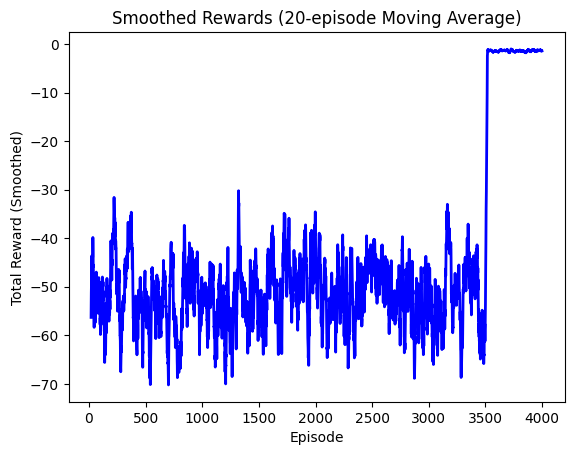

In [69]:
import pandas as pd
plt.plot(pd.Series(new_rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()

In [ ]:
# Re-create agent with smaller LR
agent = PPOAgent(
    state_dim=len(data.columns)-1,
    action_dim=4,
    lr=5e-5      # ← NEW learning rate
)

# Load previous trained model (4000 eps)
model_path = "ppo_traffic_model_3500.pt"
agent.load_state_dict(torch.load(model_path))
print("Loaded model with new LR for fine-tuning")


✔ Loaded model with new LR for fine-tuning


In [71]:
print("Current learning rate:")
for g in agent.optimizer.param_groups:
    print(g['lr'])

Current learning rate:
5e-05


In [72]:
new_rewards = train_ppo_next_phase(episodes=500)


✔ Loaded 4000 previous reward entries.

 Starting Next-Phase Training...



  0%|          | 1/500 [00:00<07:53,  1.05it/s]

Episode 4001 | Reward: -0.76


  0%|          | 2/500 [00:01<07:24,  1.12it/s]

Episode 4002 | Reward: -0.72


  1%|          | 3/500 [00:04<14:36,  1.76s/it]

Episode 4003 | Reward: -2.45


  1%|          | 4/500 [00:06<14:37,  1.77s/it]

Episode 4004 | Reward: -1.56


  1%|          | 5/500 [00:06<10:47,  1.31s/it]

Episode 4005 | Reward: -0.42


  1%|          | 6/500 [00:08<12:52,  1.56s/it]

Episode 4006 | Reward: -1.81


  1%|▏         | 7/500 [00:10<11:50,  1.44s/it]

Episode 4007 | Reward: -1.04


  2%|▏         | 8/500 [00:11<10:56,  1.34s/it]

Episode 4008 | Reward: -0.98


  2%|▏         | 9/500 [00:13<14:26,  1.77s/it]

Episode 4009 | Reward: -2.35


  2%|▏         | 10/500 [00:15<15:02,  1.84s/it]

Episode 4010 | Reward: -1.78


  2%|▏         | 11/500 [00:18<17:12,  2.11s/it]

Episode 4011 | Reward: -2.40


  2%|▏         | 12/500 [00:19<13:41,  1.68s/it]

Episode 4012 | Reward: -0.61


  3%|▎         | 13/500 [00:21<13:32,  1.67s/it]

Episode 4013 | Reward: -1.40


  3%|▎         | 14/500 [00:21<11:17,  1.39s/it]

Episode 4014 | Reward: -0.68


  3%|▎         | 15/500 [00:24<13:30,  1.67s/it]

Episode 4015 | Reward: -1.97


  3%|▎         | 16/500 [00:26<14:30,  1.80s/it]

Episode 4016 | Reward: -1.86


  3%|▎         | 17/500 [00:28<15:14,  1.89s/it]

Episode 4017 | Reward: -1.84


  4%|▎         | 18/500 [00:29<13:12,  1.64s/it]

Episode 4018 | Reward: -0.93


  4%|▍         | 19/500 [00:31<14:38,  1.83s/it]

Episode 4019 | Reward: -1.99


  4%|▍         | 20/500 [00:33<14:37,  1.83s/it]

Episode 4020 | Reward: -1.56


  4%|▍         | 21/500 [00:34<13:02,  1.63s/it]

Episode 4021 | Reward: -1.02


  4%|▍         | 22/500 [00:35<12:09,  1.53s/it]

Episode 4022 | Reward: -1.11


  5%|▍         | 24/500 [00:37<08:01,  1.01s/it]

Episode 4023 | Reward: -0.84
Episode 4024 | Reward: -0.20


  5%|▌         | 25/500 [00:39<11:00,  1.39s/it]

Episode 4025 | Reward: -1.95


  5%|▌         | 26/500 [00:41<13:03,  1.65s/it]

Episode 4026 | Reward: -2.00


  5%|▌         | 27/500 [00:42<10:26,  1.33s/it]

Episode 4027 | Reward: -0.50


  6%|▌         | 28/500 [00:43<11:23,  1.45s/it]

Episode 4028 | Reward: -1.46


  6%|▌         | 29/500 [00:45<11:22,  1.45s/it]

Episode 4029 | Reward: -1.24


  6%|▌         | 30/500 [00:47<11:57,  1.53s/it]

Episode 4030 | Reward: -1.48


  6%|▌         | 31/500 [00:48<12:00,  1.54s/it]

Episode 4031 | Reward: -1.33


  6%|▋         | 32/500 [00:49<11:14,  1.44s/it]

Episode 4032 | Reward: -1.06


  7%|▋         | 33/500 [00:52<12:57,  1.66s/it]

Episode 4033 | Reward: -1.91


  7%|▋         | 34/500 [00:52<10:36,  1.37s/it]

Episode 4034 | Reward: -0.57


  7%|▋         | 35/500 [00:54<12:36,  1.63s/it]

Episode 4035 | Reward: -1.93


  7%|▋         | 36/500 [00:56<12:26,  1.61s/it]

Episode 4036 | Reward: -1.32


  7%|▋         | 37/500 [00:59<15:05,  1.96s/it]

Episode 4037 | Reward: -2.45


  8%|▊         | 38/500 [01:00<13:05,  1.70s/it]

Episode 4038 | Reward: -0.96


  8%|▊         | 39/500 [01:00<10:22,  1.35s/it]

Episode 4039 | Reward: -0.47


  8%|▊         | 40/500 [01:01<07:56,  1.04s/it]

Episode 4040 | Reward: -0.28


  8%|▊         | 41/500 [01:04<12:34,  1.64s/it]

Episode 4041 | Reward: -2.68


  8%|▊         | 42/500 [01:05<12:04,  1.58s/it]

Episode 4042 | Reward: -1.24


  9%|▊         | 43/500 [01:07<11:48,  1.55s/it]

Episode 4043 | Reward: -1.26


  9%|▉         | 44/500 [01:07<09:06,  1.20s/it]

Episode 4044 | Reward: -0.35


  9%|▉         | 45/500 [01:09<10:25,  1.37s/it]

Episode 4045 | Reward: -1.54


  9%|▉         | 46/500 [01:11<12:24,  1.64s/it]

Episode 4046 | Reward: -2.01


  9%|▉         | 47/500 [01:12<10:33,  1.40s/it]

Episode 4047 | Reward: -0.71


 10%|▉         | 48/500 [01:12<08:16,  1.10s/it]

Episode 4048 | Reward: -0.37


 10%|▉         | 49/500 [01:14<09:31,  1.27s/it]

Episode 4049 | Reward: -1.38


 10%|█         | 50/500 [01:17<12:57,  1.73s/it]

Episode 4050 | Reward: -2.48


 10%|█         | 52/500 [01:19<10:35,  1.42s/it]

Episode 4051 | Reward: -2.19
Episode 4052 | Reward: -0.14


 11%|█         | 53/500 [01:21<10:44,  1.44s/it]

Episode 4053 | Reward: -1.30


 11%|█         | 54/500 [01:24<14:23,  1.94s/it]

Episode 4054 | Reward: -2.66


 11%|█         | 55/500 [01:25<12:53,  1.74s/it]

Episode 4055 | Reward: -1.12


 11%|█         | 56/500 [01:26<10:32,  1.42s/it]

Episode 4056 | Reward: -0.58


 11%|█▏        | 57/500 [01:28<12:22,  1.68s/it]

Episode 4057 | Reward: -1.95


 12%|█▏        | 58/500 [01:30<13:26,  1.82s/it]

Episode 4058 | Reward: -1.89


 12%|█▏        | 59/500 [01:33<14:30,  1.97s/it]

Episode 4059 | Reward: -2.05


 12%|█▏        | 60/500 [01:36<16:39,  2.27s/it]

Episode 4060 | Reward: -2.61


 12%|█▏        | 61/500 [01:37<14:30,  1.98s/it]

Episode 4061 | Reward: -1.15


 12%|█▏        | 62/500 [01:40<16:45,  2.29s/it]

Episode 4062 | Reward: -2.67


 13%|█▎        | 63/500 [01:40<12:38,  1.74s/it]

Episode 4063 | Reward: -0.38


 13%|█▎        | 65/500 [01:42<08:45,  1.21s/it]

Episode 4064 | Reward: -1.29
Episode 4065 | Reward: -0.15


 13%|█▎        | 66/500 [01:45<12:29,  1.73s/it]

Episode 4066 | Reward: -2.55


 13%|█▎        | 67/500 [01:46<10:46,  1.49s/it]

Episode 4067 | Reward: -0.83


 14%|█▎        | 68/500 [01:49<13:52,  1.93s/it]

Episode 4068 | Reward: -2.61


 14%|█▍        | 69/500 [01:50<12:20,  1.72s/it]

Episode 4069 | Reward: -1.05


 14%|█▍        | 70/500 [01:52<13:17,  1.85s/it]

Episode 4070 | Reward: -1.91


 14%|█▍        | 71/500 [01:54<12:22,  1.73s/it]

Episode 4071 | Reward: -1.22


 14%|█▍        | 72/500 [01:56<14:07,  1.98s/it]

Episode 4072 | Reward: -2.25


 15%|█▍        | 73/500 [01:57<11:25,  1.61s/it]

Episode 4073 | Reward: -0.63


 15%|█▍        | 74/500 [01:58<10:49,  1.53s/it]

Episode 4074 | Reward: -1.17


 15%|█▌        | 75/500 [02:01<13:47,  1.95s/it]

Episode 4075 | Reward: -2.58


 15%|█▌        | 76/500 [02:03<12:49,  1.81s/it]

Episode 4076 | Reward: -1.30


 15%|█▌        | 77/500 [02:05<12:42,  1.80s/it]

Episode 4077 | Reward: -1.51


 16%|█▌        | 78/500 [02:06<11:48,  1.68s/it]

Episode 4078 | Reward: -1.20


 16%|█▌        | 79/500 [02:07<10:23,  1.48s/it]

Episode 4079 | Reward: -0.88


 16%|█▌        | 80/500 [02:09<10:31,  1.50s/it]

Episode 4080 | Reward: -1.35


 16%|█▌        | 81/500 [02:11<11:39,  1.67s/it]

Episode 4081 | Reward: -1.79


 16%|█▋        | 82/500 [02:12<10:11,  1.46s/it]

Episode 4082 | Reward: -0.83


 17%|█▋        | 83/500 [02:14<11:26,  1.65s/it]

Episode 4083 | Reward: -1.80


 17%|█▋        | 84/500 [02:17<14:13,  2.05s/it]

Episode 4084 | Reward: -2.65


 17%|█▋        | 85/500 [02:20<16:08,  2.33s/it]

Episode 4085 | Reward: -2.62


 17%|█▋        | 86/500 [02:21<13:16,  1.92s/it]

Episode 4086 | Reward: -0.84


 18%|█▊        | 88/500 [02:21<07:18,  1.07s/it]

Episode 4087 | Reward: -0.31
Episode 4088 | Reward: -0.16


 18%|█▊        | 89/500 [02:23<07:48,  1.14s/it]

Episode 4089 | Reward: -1.12


 18%|█▊        | 90/500 [02:24<09:12,  1.35s/it]

Episode 4090 | Reward: -1.54


 18%|█▊        | 91/500 [02:25<07:35,  1.11s/it]

Episode 4091 | Reward: -0.50


 18%|█▊        | 92/500 [02:26<07:38,  1.12s/it]

Episode 4092 | Reward: -1.00


 19%|█▊        | 93/500 [02:28<09:08,  1.35s/it]

Episode 4093 | Reward: -1.63


 19%|█▉        | 94/500 [02:29<08:21,  1.23s/it]

Episode 4094 | Reward: -0.84


 19%|█▉        | 95/500 [02:29<06:19,  1.07it/s]

Episode 4095 | Reward: -0.22


 19%|█▉        | 96/500 [02:29<04:58,  1.35it/s]

Episode 4096 | Reward: -0.26


 19%|█▉        | 97/500 [02:30<04:11,  1.60it/s]

Episode 4097 | Reward: -0.32


 20%|█▉        | 98/500 [02:31<04:37,  1.45it/s]

Episode 4098 | Reward: -0.74


 20%|█▉        | 99/500 [02:33<07:26,  1.11s/it]

Episode 4099 | Reward: -1.84
Episode 4100 | Reward: -1.08


 20%|██        | 100/500 [02:36<12:04,  1.81s/it]

🧪 Evaluation Reward after 4100 eps: -1.74
💾 Autosaved model + rewards.


 20%|██        | 101/500 [02:38<11:22,  1.71s/it]

Episode 4101 | Reward: -1.26


 20%|██        | 102/500 [02:40<12:02,  1.82s/it]

Episode 4102 | Reward: -1.76


 21%|██        | 103/500 [02:43<14:17,  2.16s/it]

Episode 4103 | Reward: -2.64


 21%|██        | 104/500 [02:44<12:51,  1.95s/it]

Episode 4104 | Reward: -1.23


 21%|██        | 105/500 [02:45<10:08,  1.54s/it]

Episode 4105 | Reward: -0.49


 21%|██        | 106/500 [02:45<07:49,  1.19s/it]

Episode 4106 | Reward: -0.34


 21%|██▏       | 107/500 [02:48<11:15,  1.72s/it]

Episode 4107 | Reward: -2.64


 22%|██▏       | 108/500 [02:51<13:26,  2.06s/it]

Episode 4108 | Reward: -2.47


 22%|██▏       | 109/500 [02:54<15:18,  2.35s/it]

Episode 4109 | Reward: -2.69


 22%|██▏       | 110/500 [02:56<15:43,  2.42s/it]

Episode 4110 | Reward: -2.20


 22%|██▏       | 111/500 [02:57<12:42,  1.96s/it]

Episode 4111 | Reward: -0.77


 22%|██▏       | 112/500 [03:00<14:11,  2.19s/it]

Episode 4112 | Reward: -2.40


 23%|██▎       | 113/500 [03:03<15:28,  2.40s/it]

Episode 4113 | Reward: -2.17


 23%|██▎       | 114/500 [03:04<12:30,  1.94s/it]

Episode 4114 | Reward: -0.76


 23%|██▎       | 115/500 [03:06<13:03,  2.03s/it]

Episode 4115 | Reward: -1.93


 23%|██▎       | 116/500 [03:07<10:41,  1.67s/it]

Episode 4116 | Reward: -0.71


 23%|██▎       | 117/500 [03:10<12:56,  2.03s/it]

Episode 4117 | Reward: -2.53


 24%|██▎       | 118/500 [03:10<10:10,  1.60s/it]

Episode 4118 | Reward: -0.51


 24%|██▍       | 119/500 [03:12<09:33,  1.50s/it]

Episode 4119 | Reward: -1.11


 24%|██▍       | 120/500 [03:14<10:34,  1.67s/it]

Episode 4120 | Reward: -1.81


 24%|██▍       | 122/500 [03:16<08:18,  1.32s/it]

Episode 4121 | Reward: -1.88
Episode 4122 | Reward: -0.14


 25%|██▍       | 123/500 [03:19<10:32,  1.68s/it]

Episode 4123 | Reward: -2.17


 25%|██▍       | 124/500 [03:19<07:53,  1.26s/it]

Episode 4124 | Reward: -0.26


 25%|██▌       | 125/500 [03:22<11:15,  1.80s/it]

Episode 4125 | Reward: -2.65


 25%|██▌       | 126/500 [03:23<10:01,  1.61s/it]

Episode 4126 | Reward: -0.98


 25%|██▌       | 127/500 [03:25<10:08,  1.63s/it]

Episode 4127 | Reward: -1.40


 26%|██▌       | 128/500 [03:27<10:35,  1.71s/it]

Episode 4128 | Reward: -1.60


 26%|██▌       | 129/500 [03:29<10:58,  1.77s/it]

Episode 4129 | Reward: -1.64


 26%|██▌       | 130/500 [03:30<10:21,  1.68s/it]

Episode 4130 | Reward: -1.24


 26%|██▌       | 131/500 [03:33<12:51,  2.09s/it]

Episode 4131 | Reward: -2.70


 26%|██▋       | 132/500 [03:34<11:11,  1.83s/it]

Episode 4132 | Reward: -1.04


 27%|██▋       | 133/500 [03:36<10:38,  1.74s/it]

Episode 4133 | Reward: -1.28


 27%|██▋       | 135/500 [03:38<08:37,  1.42s/it]

Episode 4134 | Reward: -2.18
Episode 4135 | Reward: -0.13


 27%|██▋       | 136/500 [03:39<06:48,  1.12s/it]

Episode 4136 | Reward: -0.38


 27%|██▋       | 137/500 [03:41<09:27,  1.56s/it]

Episode 4137 | Reward: -2.25


 28%|██▊       | 138/500 [03:44<11:58,  1.99s/it]

Episode 4138 | Reward: -2.61


 28%|██▊       | 139/500 [03:47<13:30,  2.24s/it]

Episode 4139 | Reward: -2.49


 28%|██▊       | 140/500 [03:50<13:29,  2.25s/it]

Episode 4140 | Reward: -1.97


 28%|██▊       | 141/500 [03:51<12:38,  2.11s/it]

Episode 4141 | Reward: -1.54


 28%|██▊       | 142/500 [03:54<13:56,  2.34s/it]

Episode 4142 | Reward: -2.53


 29%|██▊       | 143/500 [03:55<11:56,  2.01s/it]

Episode 4143 | Reward: -1.02


 29%|██▉       | 144/500 [03:56<09:53,  1.67s/it]

Episode 4144 | Reward: -0.75


 29%|██▉       | 145/500 [03:58<10:28,  1.77s/it]

Episode 4145 | Reward: -1.77


 29%|██▉       | 146/500 [04:00<09:29,  1.61s/it]

Episode 4146 | Reward: -1.07


 29%|██▉       | 147/500 [04:01<09:06,  1.55s/it]

Episode 4147 | Reward: -1.20


 30%|██▉       | 148/500 [04:04<10:51,  1.85s/it]

Episode 4148 | Reward: -2.26


 30%|██▉       | 149/500 [04:06<11:27,  1.96s/it]

Episode 4149 | Reward: -1.88


 30%|███       | 150/500 [04:08<11:28,  1.97s/it]

Episode 4150 | Reward: -1.70


 30%|███       | 151/500 [04:10<12:23,  2.13s/it]

Episode 4151 | Reward: -2.16


 30%|███       | 152/500 [04:12<12:18,  2.12s/it]

Episode 4152 | Reward: -1.81


 31%|███       | 153/500 [04:14<10:50,  1.87s/it]

Episode 4153 | Reward: -1.13


 31%|███       | 154/500 [04:16<10:53,  1.89s/it]

Episode 4154 | Reward: -1.64


 31%|███       | 155/500 [04:17<09:38,  1.68s/it]

Episode 4155 | Reward: -1.03


 31%|███       | 156/500 [04:19<09:51,  1.72s/it]

Episode 4156 | Reward: -1.56


 31%|███▏      | 157/500 [04:19<07:54,  1.38s/it]

Episode 4157 | Reward: -0.52


 32%|███▏      | 158/500 [04:20<07:38,  1.34s/it]

Episode 4158 | Reward: -1.06


 32%|███▏      | 159/500 [04:22<07:21,  1.29s/it]

Episode 4159 | Reward: -1.03


 32%|███▏      | 160/500 [04:25<10:05,  1.78s/it]

Episode 4160 | Reward: -2.56


 32%|███▏      | 161/500 [04:26<10:17,  1.82s/it]

Episode 4161 | Reward: -1.64


 32%|███▏      | 162/500 [04:28<09:56,  1.76s/it]

Episode 4162 | Reward: -1.37


 33%|███▎      | 163/500 [04:31<11:50,  2.11s/it]

Episode 4163 | Reward: -2.56


 33%|███▎      | 164/500 [04:33<11:50,  2.11s/it]

Episode 4164 | Reward: -1.88


 33%|███▎      | 165/500 [04:34<09:30,  1.70s/it]

Episode 4165 | Reward: -0.63


 33%|███▎      | 166/500 [04:37<11:07,  2.00s/it]

Episode 4166 | Reward: -2.33


 33%|███▎      | 167/500 [04:39<11:11,  2.02s/it]

Episode 4167 | Reward: -1.79


 34%|███▎      | 168/500 [04:40<09:38,  1.74s/it]

Episode 4168 | Reward: -0.94


 34%|███▍      | 169/500 [04:41<08:55,  1.62s/it]

Episode 4169 | Reward: -1.13


 34%|███▍      | 170/500 [04:42<08:10,  1.49s/it]

Episode 4170 | Reward: -1.04


 34%|███▍      | 171/500 [04:45<10:15,  1.87s/it]

Episode 4171 | Reward: -2.43


 34%|███▍      | 172/500 [04:47<10:40,  1.95s/it]

Episode 4172 | Reward: -1.81


 35%|███▍      | 173/500 [04:48<09:21,  1.72s/it]

Episode 4173 | Reward: -1.02


 35%|███▍      | 174/500 [04:50<09:43,  1.79s/it]

Episode 4174 | Reward: -1.66


 35%|███▌      | 175/500 [04:51<08:41,  1.60s/it]

Episode 4175 | Reward: -1.00


 35%|███▌      | 176/500 [04:54<09:34,  1.77s/it]

Episode 4176 | Reward: -1.90


 35%|███▌      | 177/500 [04:55<09:43,  1.81s/it]

Episode 4177 | Reward: -1.62


 36%|███▌      | 178/500 [04:57<09:43,  1.81s/it]

Episode 4178 | Reward: -1.56


 36%|███▌      | 179/500 [04:59<09:00,  1.68s/it]

Episode 4179 | Reward: -1.21


 36%|███▌      | 180/500 [05:01<10:29,  1.97s/it]

Episode 4180 | Reward: -2.27


 36%|███▌      | 181/500 [05:03<10:28,  1.97s/it]

Episode 4181 | Reward: -1.73


 36%|███▋      | 182/500 [05:05<09:56,  1.87s/it]

Episode 4182 | Reward: -1.42


 37%|███▋      | 183/500 [05:05<07:28,  1.42s/it]

Episode 4183 | Reward: -0.31


 37%|███▋      | 184/500 [05:07<08:00,  1.52s/it]

Episode 4184 | Reward: -1.36


 37%|███▋      | 185/500 [05:08<06:48,  1.30s/it]

Episode 4185 | Reward: -0.68


 37%|███▋      | 186/500 [05:09<06:34,  1.26s/it]

Episode 4186 | Reward: -1.02


 37%|███▋      | 187/500 [05:12<09:16,  1.78s/it]

Episode 4187 | Reward: -2.62


 38%|███▊      | 188/500 [05:15<11:09,  2.15s/it]

Episode 4188 | Reward: -2.68


 38%|███▊      | 189/500 [05:18<12:04,  2.33s/it]

Episode 4189 | Reward: -2.36


 38%|███▊      | 190/500 [05:19<09:39,  1.87s/it]

Episode 4190 | Reward: -0.70


 38%|███▊      | 191/500 [05:20<08:41,  1.69s/it]

Episode 4191 | Reward: -1.08


 38%|███▊      | 192/500 [05:21<07:35,  1.48s/it]

Episode 4192 | Reward: -0.84


 39%|███▊      | 193/500 [05:22<07:04,  1.38s/it]

Episode 4193 | Reward: -1.01


 39%|███▉      | 194/500 [05:24<07:31,  1.48s/it]

Episode 4194 | Reward: -1.43


 39%|███▉      | 195/500 [05:25<07:42,  1.52s/it]

Episode 4195 | Reward: -1.37


 39%|███▉      | 196/500 [05:28<09:15,  1.83s/it]

Episode 4196 | Reward: -2.19


 39%|███▉      | 197/500 [05:29<08:06,  1.60s/it]

Episode 4197 | Reward: -0.92


 40%|███▉      | 198/500 [05:31<08:13,  1.63s/it]

Episode 4198 | Reward: -1.47


 40%|███▉      | 199/500 [05:31<06:55,  1.38s/it]

Episode 4199 | Reward: -0.69
Episode 4200 | Reward: -2.07


 40%|████      | 200/500 [05:35<10:21,  2.07s/it]

🧪 Evaluation Reward after 4200 eps: -1.07
💾 Autosaved model + rewards.


 40%|████      | 201/500 [05:38<11:16,  2.26s/it]

Episode 4201 | Reward: -2.34


 40%|████      | 202/500 [05:39<09:05,  1.83s/it]

Episode 4202 | Reward: -0.70


 41%|████      | 203/500 [05:40<08:33,  1.73s/it]

Episode 4203 | Reward: -1.25


 41%|████      | 204/500 [05:42<08:29,  1.72s/it]

Episode 4204 | Reward: -1.45


 41%|████      | 205/500 [05:43<08:18,  1.69s/it]

Episode 4205 | Reward: -1.37


 41%|████      | 206/500 [05:45<07:46,  1.59s/it]

Episode 4206 | Reward: -1.13


 41%|████▏     | 207/500 [05:47<09:09,  1.88s/it]

Episode 4207 | Reward: -2.21


 42%|████▏     | 208/500 [05:50<10:08,  2.08s/it]

Episode 4208 | Reward: -2.27


 42%|████▏     | 209/500 [05:52<10:32,  2.17s/it]

Episode 4209 | Reward: -2.06


 42%|████▏     | 210/500 [05:54<09:56,  2.06s/it]

Episode 4210 | Reward: -1.53


 42%|████▏     | 211/500 [05:56<09:13,  1.91s/it]

Episode 4211 | Reward: -1.32


 42%|████▏     | 212/500 [05:57<09:06,  1.90s/it]

Episode 4212 | Reward: -1.57


 43%|████▎     | 213/500 [05:58<07:19,  1.53s/it]

Episode 4213 | Reward: -0.58


 43%|████▎     | 214/500 [06:01<08:32,  1.79s/it]

Episode 4214 | Reward: -2.10


 43%|████▎     | 215/500 [06:02<07:59,  1.68s/it]

Episode 4215 | Reward: -1.20


 43%|████▎     | 216/500 [06:04<08:33,  1.81s/it]

Episode 4216 | Reward: -1.83


 43%|████▎     | 217/500 [06:06<08:53,  1.88s/it]

Episode 4217 | Reward: -1.80


 44%|████▎     | 218/500 [06:07<07:25,  1.58s/it]

Episode 4218 | Reward: -0.73


 44%|████▍     | 219/500 [06:08<05:54,  1.26s/it]

Episode 4219 | Reward: -0.43


 44%|████▍     | 220/500 [06:10<07:11,  1.54s/it]

Episode 4220 | Reward: -1.93


 44%|████▍     | 221/500 [06:11<06:14,  1.34s/it]

Episode 4221 | Reward: -0.76


 44%|████▍     | 222/500 [06:12<06:21,  1.37s/it]

Episode 4222 | Reward: -1.21


 45%|████▍     | 223/500 [06:15<08:16,  1.79s/it]

Episode 4223 | Reward: -2.46


 45%|████▍     | 224/500 [06:16<07:54,  1.72s/it]

Episode 4224 | Reward: -1.32


 45%|████▌     | 225/500 [06:19<09:10,  2.00s/it]

Episode 4225 | Reward: -2.30


 45%|████▌     | 226/500 [06:20<07:06,  1.56s/it]

Episode 4226 | Reward: -0.44


 45%|████▌     | 227/500 [06:22<08:45,  1.92s/it]

Episode 4227 | Reward: -2.43


 46%|████▌     | 228/500 [06:23<07:28,  1.65s/it]

Episode 4228 | Reward: -0.85


 46%|████▌     | 229/500 [06:25<07:30,  1.66s/it]

Episode 4229 | Reward: -1.46


 46%|████▌     | 230/500 [06:27<08:05,  1.80s/it]

Episode 4230 | Reward: -1.80


 46%|████▌     | 231/500 [06:28<06:26,  1.44s/it]

Episode 4231 | Reward: -0.48


 46%|████▋     | 232/500 [06:29<06:29,  1.45s/it]

Episode 4232 | Reward: -1.28


 47%|████▋     | 233/500 [06:30<05:27,  1.23s/it]

Episode 4233 | Reward: -0.59


 47%|████▋     | 234/500 [06:31<05:22,  1.21s/it]

Episode 4234 | Reward: -1.02


 47%|████▋     | 235/500 [06:32<04:22,  1.01it/s]

Episode 4235 | Reward: -0.41


 47%|████▋     | 236/500 [06:32<03:47,  1.16it/s]

Episode 4236 | Reward: -0.48


 47%|████▋     | 237/500 [06:35<06:22,  1.46s/it]

Episode 4237 | Reward: -2.52


 48%|████▊     | 238/500 [06:37<07:21,  1.68s/it]

Episode 4238 | Reward: -1.92


 48%|████▊     | 239/500 [06:40<08:09,  1.87s/it]

Episode 4239 | Reward: -1.99


 48%|████▊     | 240/500 [06:40<06:56,  1.60s/it]

Episode 4240 | Reward: -0.82


 48%|████▊     | 241/500 [06:42<06:50,  1.58s/it]

Episode 4241 | Reward: -1.31


 48%|████▊     | 242/500 [06:44<07:27,  1.73s/it]

Episode 4242 | Reward: -1.81


 49%|████▊     | 243/500 [06:46<07:16,  1.70s/it]

Episode 4243 | Reward: -1.36


 49%|████▉     | 244/500 [06:48<07:47,  1.83s/it]

Episode 4244 | Reward: -1.85


 49%|████▉     | 245/500 [06:50<07:44,  1.82s/it]

Episode 4245 | Reward: -1.54


 49%|████▉     | 246/500 [06:52<07:59,  1.89s/it]

Episode 4246 | Reward: -1.77


 49%|████▉     | 247/500 [06:53<07:30,  1.78s/it]

Episode 4247 | Reward: -1.30


 50%|████▉     | 248/500 [06:54<06:21,  1.52s/it]

Episode 4248 | Reward: -0.77


 50%|████▉     | 249/500 [06:55<05:58,  1.43s/it]

Episode 4249 | Reward: -1.06


 50%|█████     | 250/500 [06:58<07:56,  1.91s/it]

Episode 4250 | Reward: -2.60


 50%|█████     | 251/500 [06:59<06:41,  1.61s/it]

Episode 4251 | Reward: -0.79


 50%|█████     | 252/500 [07:02<07:29,  1.81s/it]

Episode 4252 | Reward: -1.97


 51%|█████     | 253/500 [07:04<07:58,  1.94s/it]

Episode 4253 | Reward: -1.94


 51%|█████     | 254/500 [07:06<08:03,  1.96s/it]

Episode 4254 | Reward: -1.78


 51%|█████     | 255/500 [07:07<06:34,  1.61s/it]

Episode 4255 | Reward: -0.67


 51%|█████     | 256/500 [07:07<04:54,  1.21s/it]

Episode 4256 | Reward: -0.25


 51%|█████▏    | 257/500 [07:09<05:49,  1.44s/it]

Episode 4257 | Reward: -1.67


 52%|█████▏    | 258/500 [07:10<05:48,  1.44s/it]

Episode 4258 | Reward: -1.24


 52%|█████▏    | 259/500 [07:11<04:40,  1.16s/it]

Episode 4259 | Reward: -0.45


 52%|█████▏    | 260/500 [07:13<06:28,  1.62s/it]

Episode 4260 | Reward: -2.35


 52%|█████▏    | 261/500 [07:14<04:49,  1.21s/it]

Episode 4261 | Reward: -0.25


 52%|█████▏    | 262/500 [07:16<06:14,  1.57s/it]

Episode 4262 | Reward: -2.13


 53%|█████▎    | 263/500 [07:18<06:51,  1.74s/it]

Episode 4263 | Reward: -1.82


 53%|█████▎    | 264/500 [07:20<07:14,  1.84s/it]

Episode 4264 | Reward: -1.81


 53%|█████▎    | 265/500 [07:23<08:35,  2.20s/it]

Episode 4265 | Reward: -2.64


 53%|█████▎    | 266/500 [07:24<06:51,  1.76s/it]

Episode 4266 | Reward: -0.65


 53%|█████▎    | 267/500 [07:25<05:58,  1.54s/it]

Episode 4267 | Reward: -0.90


 54%|█████▎    | 268/500 [07:28<07:37,  1.97s/it]

Episode 4268 | Reward: -2.59


 54%|█████▍    | 269/500 [07:29<06:28,  1.68s/it]

Episode 4269 | Reward: -0.83


 54%|█████▍    | 270/500 [07:32<07:36,  1.99s/it]

Episode 4270 | Reward: -2.40


 54%|█████▍    | 271/500 [07:33<06:37,  1.74s/it]

Episode 4271 | Reward: -1.00


 54%|█████▍    | 272/500 [07:34<05:42,  1.50s/it]

Episode 4272 | Reward: -0.77


 55%|█████▍    | 273/500 [07:36<06:22,  1.68s/it]

Episode 4273 | Reward: -1.87


 55%|█████▍    | 274/500 [07:38<06:19,  1.68s/it]

Episode 4274 | Reward: -1.40


 55%|█████▌    | 275/500 [07:39<05:35,  1.49s/it]

Episode 4275 | Reward: -0.88


 55%|█████▌    | 276/500 [07:40<05:45,  1.54s/it]

Episode 4276 | Reward: -1.41


 55%|█████▌    | 277/500 [07:42<05:35,  1.50s/it]

Episode 4277 | Reward: -1.22


 56%|█████▌    | 278/500 [07:43<04:50,  1.31s/it]

Episode 4278 | Reward: -0.73


 56%|█████▌    | 279/500 [07:44<04:16,  1.16s/it]

Episode 4279 | Reward: -0.71


 56%|█████▌    | 280/500 [07:46<05:25,  1.48s/it]

Episode 4280 | Reward: -1.94


 56%|█████▌    | 281/500 [07:48<06:30,  1.78s/it]

Episode 4281 | Reward: -2.20


 56%|█████▋    | 282/500 [07:49<05:49,  1.60s/it]

Episode 4282 | Reward: -1.02


 57%|█████▋    | 284/500 [07:50<03:31,  1.02it/s]

Episode 4283 | Reward: -0.61
Episode 4284 | Reward: -0.13


 57%|█████▋    | 285/500 [07:53<05:25,  1.51s/it]

Episode 4285 | Reward: -2.44


 57%|█████▋    | 286/500 [07:54<04:59,  1.40s/it]

Episode 4286 | Reward: -0.99


 57%|█████▋    | 287/500 [07:56<05:46,  1.63s/it]

Episode 4287 | Reward: -1.86


 58%|█████▊    | 288/500 [07:57<05:14,  1.49s/it]

Episode 4288 | Reward: -1.02


 58%|█████▊    | 290/500 [07:58<03:19,  1.05it/s]

Episode 4289 | Reward: -0.71
Episode 4290 | Reward: -0.16


 58%|█████▊    | 291/500 [07:59<03:07,  1.11it/s]

Episode 4291 | Reward: -0.66


 58%|█████▊    | 292/500 [08:00<03:18,  1.05it/s]

Episode 4292 | Reward: -0.94


 59%|█████▊    | 293/500 [08:03<04:40,  1.35s/it]

Episode 4293 | Reward: -1.99


 59%|█████▉    | 294/500 [08:05<05:57,  1.74s/it]

Episode 4294 | Reward: -2.33


 59%|█████▉    | 295/500 [08:06<05:21,  1.57s/it]

Episode 4295 | Reward: -1.02


 59%|█████▉    | 296/500 [08:09<06:36,  1.94s/it]

Episode 4296 | Reward: -2.47


 59%|█████▉    | 297/500 [08:10<05:11,  1.53s/it]

Episode 4297 | Reward: -0.49


 60%|█████▉    | 298/500 [08:10<04:00,  1.19s/it]

Episode 4298 | Reward: -0.36


 60%|█████▉    | 299/500 [08:12<04:56,  1.48s/it]

Episode 4299 | Reward: -1.86
Episode 4300 | Reward: -1.63


 60%|██████    | 300/500 [08:16<06:54,  2.07s/it]

🧪 Evaluation Reward after 4300 eps: -1.31
💾 Autosaved model + rewards.


 60%|██████    | 301/500 [08:19<07:47,  2.35s/it]

Episode 4301 | Reward: -2.62


 60%|██████    | 302/500 [08:21<07:49,  2.37s/it]

Episode 4302 | Reward: -2.10


 61%|██████    | 303/500 [08:22<06:17,  1.92s/it]

Episode 4303 | Reward: -0.74


 61%|██████    | 304/500 [08:23<05:05,  1.56s/it]

Episode 4304 | Reward: -0.58


 61%|██████    | 305/500 [08:25<05:11,  1.60s/it]

Episode 4305 | Reward: -1.44


 61%|██████    | 306/500 [08:27<05:38,  1.75s/it]

Episode 4306 | Reward: -1.83


 61%|██████▏   | 307/500 [08:27<04:31,  1.41s/it]

Episode 4307 | Reward: -0.53


 62%|██████▏   | 308/500 [08:28<04:11,  1.31s/it]

Episode 4308 | Reward: -0.94


 62%|██████▏   | 309/500 [08:29<03:42,  1.17s/it]

Episode 4309 | Reward: -0.72


 62%|██████▏   | 310/500 [08:32<05:12,  1.65s/it]

Episode 4310 | Reward: -2.43


 62%|██████▏   | 311/500 [08:32<03:52,  1.23s/it]

Episode 4311 | Reward: -0.26


 62%|██████▏   | 312/500 [08:35<05:29,  1.75s/it]

Episode 4312 | Reward: -2.61


 63%|██████▎   | 313/500 [08:38<06:17,  2.02s/it]

Episode 4313 | Reward: -2.32


 63%|██████▎   | 314/500 [08:40<05:59,  1.93s/it]

Episode 4314 | Reward: -1.47


 63%|██████▎   | 315/500 [08:40<04:51,  1.58s/it]

Episode 4315 | Reward: -0.62


 63%|██████▎   | 316/500 [08:41<04:27,  1.45s/it]

Episode 4316 | Reward: -1.02


 63%|██████▎   | 317/500 [08:43<04:58,  1.63s/it]

Episode 4317 | Reward: -1.78


 64%|██████▎   | 318/500 [08:44<03:49,  1.26s/it]

Episode 4318 | Reward: -0.36


 64%|██████▍   | 319/500 [08:46<04:28,  1.48s/it]

Episode 4319 | Reward: -1.72


 64%|██████▍   | 320/500 [08:48<04:59,  1.66s/it]

Episode 4320 | Reward: -1.82


 64%|██████▍   | 321/500 [08:50<05:18,  1.78s/it]

Episode 4321 | Reward: -1.74


 64%|██████▍   | 322/500 [08:53<06:05,  2.05s/it]

Episode 4322 | Reward: -2.38


 65%|██████▍   | 323/500 [08:53<04:50,  1.64s/it]

Episode 4323 | Reward: -0.57


 65%|██████▍   | 324/500 [08:56<05:55,  2.02s/it]

Episode 4324 | Reward: -2.57


 65%|██████▌   | 325/500 [08:59<06:32,  2.24s/it]

Episode 4325 | Reward: -2.43


 65%|██████▌   | 326/500 [09:01<06:38,  2.29s/it]

Episode 4326 | Reward: -2.06


 65%|██████▌   | 327/500 [09:02<05:18,  1.84s/it]

Episode 4327 | Reward: -0.70


 66%|██████▌   | 328/500 [09:04<05:35,  1.95s/it]

Episode 4328 | Reward: -1.94


 66%|██████▌   | 329/500 [09:05<04:23,  1.54s/it]

Episode 4329 | Reward: -0.50


 66%|██████▌   | 330/500 [09:08<05:37,  1.98s/it]

Episode 4330 | Reward: -2.67


 66%|██████▌   | 331/500 [09:11<06:30,  2.31s/it]

Episode 4331 | Reward: -2.70


 66%|██████▋   | 332/500 [09:12<05:32,  1.98s/it]

Episode 4332 | Reward: -1.01


 67%|██████▋   | 333/500 [09:13<04:16,  1.53s/it]

Episode 4333 | Reward: -0.43


 67%|██████▋   | 334/500 [09:15<04:28,  1.62s/it]

Episode 4334 | Reward: -1.58


 67%|██████▋   | 335/500 [09:17<05:04,  1.85s/it]

Episode 4335 | Reward: -2.08


 67%|██████▋   | 336/500 [09:18<04:05,  1.50s/it]

Episode 4336 | Reward: -0.58


 67%|██████▋   | 337/500 [09:18<03:12,  1.18s/it]

Episode 4337 | Reward: -0.39


 68%|██████▊   | 338/500 [09:20<03:56,  1.46s/it]

Episode 4338 | Reward: -1.83


 68%|██████▊   | 339/500 [09:22<04:18,  1.61s/it]

Episode 4339 | Reward: -1.69


 68%|██████▊   | 340/500 [09:22<03:10,  1.19s/it]

Episode 4340 | Reward: -0.20


 68%|██████▊   | 341/500 [09:25<04:28,  1.69s/it]

Episode 4341 | Reward: -2.53


 68%|██████▊   | 342/500 [09:28<05:08,  1.95s/it]

Episode 4342 | Reward: -2.25


 69%|██████▊   | 343/500 [09:28<04:01,  1.54s/it]

Episode 4343 | Reward: -0.47


 69%|██████▉   | 344/500 [09:31<05:06,  1.96s/it]

Episode 4344 | Reward: -2.59


 69%|██████▉   | 345/500 [09:33<05:08,  1.99s/it]

Episode 4345 | Reward: -1.79


 69%|██████▉   | 346/500 [09:34<03:56,  1.54s/it]

Episode 4346 | Reward: -0.39


 69%|██████▉   | 347/500 [09:35<03:44,  1.47s/it]

Episode 4347 | Reward: -1.12


 70%|██████▉   | 348/500 [09:36<03:26,  1.36s/it]

Episode 4348 | Reward: -0.95


 70%|██████▉   | 349/500 [09:38<03:30,  1.40s/it]

Episode 4349 | Reward: -1.28


 70%|███████   | 350/500 [09:41<04:36,  1.85s/it]

Episode 4350 | Reward: -2.53


 70%|███████   | 351/500 [09:44<05:24,  2.18s/it]

Episode 4351 | Reward: -2.61


 70%|███████   | 352/500 [09:45<04:32,  1.84s/it]

Episode 4352 | Reward: -0.85


 71%|███████   | 353/500 [09:46<04:15,  1.74s/it]

Episode 4353 | Reward: -1.28


 71%|███████   | 354/500 [09:48<04:13,  1.74s/it]

Episode 4354 | Reward: -1.50


 71%|███████   | 355/500 [09:51<05:01,  2.08s/it]

Episode 4355 | Reward: -2.51


 71%|███████   | 356/500 [09:51<03:59,  1.66s/it]

Episode 4356 | Reward: -0.57


 71%|███████▏  | 357/500 [09:54<04:38,  1.95s/it]

Episode 4357 | Reward: -2.29


 72%|███████▏  | 358/500 [09:56<04:28,  1.89s/it]

Episode 4358 | Reward: -1.51


 72%|███████▏  | 359/500 [09:57<03:46,  1.61s/it]

Episode 4359 | Reward: -0.82


 72%|███████▏  | 360/500 [09:58<03:25,  1.47s/it]

Episode 4360 | Reward: -1.00


 72%|███████▏  | 361/500 [10:00<03:44,  1.62s/it]

Episode 4361 | Reward: -1.70


 72%|███████▏  | 362/500 [10:01<03:33,  1.55s/it]

Episode 4362 | Reward: -1.15


 73%|███████▎  | 363/500 [10:02<02:51,  1.25s/it]

Episode 4363 | Reward: -0.50


 73%|███████▎  | 364/500 [10:05<03:56,  1.74s/it]

Episode 4364 | Reward: -2.53


 73%|███████▎  | 365/500 [10:06<03:23,  1.51s/it]

Episode 4365 | Reward: -0.84


 73%|███████▎  | 366/500 [10:06<02:37,  1.17s/it]

Episode 4366 | Reward: -0.35


 73%|███████▎  | 367/500 [10:08<03:12,  1.44s/it]

Episode 4367 | Reward: -1.80


 74%|███████▎  | 368/500 [10:10<03:26,  1.57s/it]

Episode 4368 | Reward: -1.57


 74%|███████▍  | 369/500 [10:13<04:02,  1.85s/it]

Episode 4369 | Reward: -2.17


 74%|███████▍  | 370/500 [10:14<03:28,  1.60s/it]

Episode 4370 | Reward: -0.88


 74%|███████▍  | 371/500 [10:16<04:13,  1.96s/it]

Episode 4371 | Reward: -2.47


 74%|███████▍  | 372/500 [10:17<03:28,  1.63s/it]

Episode 4372 | Reward: -0.73


 75%|███████▍  | 373/500 [10:19<03:24,  1.61s/it]

Episode 4373 | Reward: -1.35


 75%|███████▍  | 374/500 [10:20<03:24,  1.62s/it]

Episode 4374 | Reward: -1.39


 75%|███████▌  | 375/500 [10:21<02:43,  1.31s/it]

Episode 4375 | Reward: -0.51


 75%|███████▌  | 376/500 [10:21<02:04,  1.01s/it]

Episode 4376 | Reward: -0.27


 75%|███████▌  | 377/500 [10:23<02:31,  1.23s/it]

Episode 4377 | Reward: -1.45


 76%|███████▌  | 378/500 [10:24<02:15,  1.11s/it]

Episode 4378 | Reward: -0.72


 76%|███████▌  | 379/500 [10:24<01:51,  1.09it/s]

Episode 4379 | Reward: -0.41


 76%|███████▌  | 380/500 [10:27<02:39,  1.33s/it]

Episode 4380 | Reward: -2.01


 76%|███████▌  | 381/500 [10:28<02:22,  1.20s/it]

Episode 4381 | Reward: -0.75


 76%|███████▋  | 382/500 [10:30<02:53,  1.47s/it]

Episode 4382 | Reward: -1.81


 77%|███████▋  | 383/500 [10:31<03:00,  1.54s/it]

Episode 4383 | Reward: -1.47


 77%|███████▋  | 384/500 [10:32<02:23,  1.24s/it]

Episode 4384 | Reward: -0.44


 77%|███████▋  | 385/500 [10:32<01:50,  1.04it/s]

Episode 4385 | Reward: -0.29


 77%|███████▋  | 386/500 [10:33<01:53,  1.01it/s]

Episode 4386 | Reward: -0.92


 77%|███████▋  | 387/500 [10:35<02:13,  1.18s/it]

Episode 4387 | Reward: -1.37


 78%|███████▊  | 388/500 [10:37<02:34,  1.38s/it]

Episode 4388 | Reward: -1.60


 78%|███████▊  | 389/500 [10:38<02:36,  1.41s/it]

Episode 4389 | Reward: -1.28


 78%|███████▊  | 390/500 [10:41<03:06,  1.70s/it]

Episode 4390 | Reward: -2.04


 78%|███████▊  | 391/500 [10:43<03:34,  1.97s/it]

Episode 4391 | Reward: -2.27


 78%|███████▊  | 392/500 [10:44<02:57,  1.64s/it]

Episode 4392 | Reward: -0.75


 79%|███████▊  | 393/500 [10:45<02:33,  1.44s/it]

Episode 4393 | Reward: -0.78


 79%|███████▉  | 394/500 [10:46<02:14,  1.27s/it]

Episode 4394 | Reward: -0.77


 79%|███████▉  | 395/500 [10:47<01:53,  1.08s/it]

Episode 4395 | Reward: -0.54


 79%|███████▉  | 396/500 [10:48<01:56,  1.12s/it]

Episode 4396 | Reward: -1.05


 79%|███████▉  | 397/500 [10:51<02:48,  1.64s/it]

Episode 4397 | Reward: -2.47


 80%|███████▉  | 398/500 [10:52<02:32,  1.50s/it]

Episode 4398 | Reward: -1.02


 80%|███████▉  | 399/500 [10:52<01:54,  1.14s/it]

Episode 4399 | Reward: -0.25
Episode 4400 | Reward: -0.15


 80%|████████  | 400/500 [10:55<02:43,  1.63s/it]

🧪 Evaluation Reward after 4400 eps: -2.14
💾 Autosaved model + rewards.


 80%|████████  | 401/500 [10:58<03:24,  2.06s/it]

Episode 4401 | Reward: -2.67


 80%|████████  | 402/500 [10:58<02:37,  1.61s/it]

Episode 4402 | Reward: -0.46


 81%|████████  | 403/500 [10:59<02:16,  1.41s/it]

Episode 4403 | Reward: -0.81


 81%|████████  | 404/500 [11:00<01:50,  1.16s/it]

Episode 4404 | Reward: -0.47


 81%|████████  | 405/500 [11:01<01:54,  1.20s/it]

Episode 4405 | Reward: -1.13


 81%|████████  | 406/500 [11:02<01:49,  1.16s/it]

Episode 4406 | Reward: -0.90


 81%|████████▏ | 407/500 [11:03<01:39,  1.07s/it]

Episode 4407 | Reward: -0.74


 82%|████████▏ | 408/500 [11:04<01:41,  1.10s/it]

Episode 4408 | Reward: -1.03


 82%|████████▏ | 409/500 [11:05<01:18,  1.16it/s]

Episode 4409 | Reward: -0.26


 82%|████████▏ | 410/500 [11:07<01:51,  1.24s/it]

Episode 4410 | Reward: -1.81


 82%|████████▏ | 411/500 [11:09<02:23,  1.62s/it]

Episode 4411 | Reward: -2.20


 82%|████████▏ | 412/500 [11:11<02:36,  1.78s/it]

Episode 4412 | Reward: -1.88


 83%|████████▎ | 413/500 [11:14<02:51,  1.97s/it]

Episode 4413 | Reward: -2.08


 83%|████████▎ | 415/500 [11:16<02:05,  1.48s/it]

Episode 4414 | Reward: -1.96
Episode 4415 | Reward: -0.14


 83%|████████▎ | 416/500 [11:18<02:15,  1.61s/it]

Episode 4416 | Reward: -1.64


 83%|████████▎ | 417/500 [11:21<02:46,  2.01s/it]

Episode 4417 | Reward: -2.60


 84%|████████▍ | 419/500 [11:22<01:36,  1.19s/it]

Episode 4418 | Reward: -0.66
Episode 4419 | Reward: -0.16


 84%|████████▍ | 420/500 [11:24<02:00,  1.51s/it]

Episode 4420 | Reward: -1.94


 84%|████████▍ | 421/500 [11:26<01:56,  1.47s/it]

Episode 4421 | Reward: -1.16


 84%|████████▍ | 422/500 [11:28<02:21,  1.81s/it]

Episode 4422 | Reward: -2.25


 85%|████████▍ | 423/500 [11:30<02:18,  1.80s/it]

Episode 4423 | Reward: -1.52


 85%|████████▍ | 424/500 [11:31<02:07,  1.67s/it]

Episode 4424 | Reward: -1.19


 85%|████████▌ | 425/500 [11:33<01:56,  1.55s/it]

Episode 4425 | Reward: -1.08


 85%|████████▌ | 426/500 [11:36<02:28,  2.01s/it]

Episode 4426 | Reward: -2.68


 85%|████████▌ | 427/500 [11:38<02:26,  2.01s/it]

Episode 4427 | Reward: -1.75


 86%|████████▌ | 428/500 [11:39<02:03,  1.72s/it]

Episode 4428 | Reward: -0.88


 86%|████████▌ | 429/500 [11:41<02:08,  1.81s/it]

Episode 4429 | Reward: -1.76


 86%|████████▌ | 430/500 [11:44<02:28,  2.12s/it]

Episode 4430 | Reward: -2.49


 86%|████████▌ | 431/500 [11:46<02:32,  2.21s/it]

Episode 4431 | Reward: -2.10


 86%|████████▋ | 432/500 [11:47<02:05,  1.85s/it]

Episode 4432 | Reward: -0.87


 87%|████████▋ | 433/500 [11:50<02:23,  2.14s/it]

Episode 4433 | Reward: -2.51


 87%|████████▋ | 434/500 [11:51<01:57,  1.78s/it]

Episode 4434 | Reward: -0.78


 87%|████████▋ | 435/500 [11:53<02:09,  1.99s/it]

Episode 4435 | Reward: -2.17


 87%|████████▋ | 436/500 [11:54<01:45,  1.64s/it]

Episode 4436 | Reward: -0.72


 87%|████████▋ | 437/500 [11:56<01:52,  1.79s/it]

Episode 4437 | Reward: -1.86


 88%|████████▊ | 438/500 [11:58<01:40,  1.62s/it]

Episode 4438 | Reward: -1.07


 88%|████████▊ | 439/500 [11:59<01:34,  1.54s/it]

Episode 4439 | Reward: -1.16


 88%|████████▊ | 440/500 [12:00<01:23,  1.39s/it]

Episode 4440 | Reward: -0.89


 88%|████████▊ | 441/500 [12:03<01:46,  1.80s/it]

Episode 4441 | Reward: -2.41


 88%|████████▊ | 442/500 [12:04<01:28,  1.53s/it]

Episode 4442 | Reward: -0.75


 89%|████████▊ | 443/500 [12:06<01:45,  1.85s/it]

Episode 4443 | Reward: -2.26


 89%|████████▉ | 445/500 [12:09<01:24,  1.54s/it]

Episode 4444 | Reward: -2.47
Episode 4445 | Reward: -0.15


 89%|████████▉ | 446/500 [12:10<01:09,  1.28s/it]

Episode 4446 | Reward: -0.60


 89%|████████▉ | 447/500 [12:10<00:53,  1.01s/it]

Episode 4447 | Reward: -0.32


 90%|████████▉ | 448/500 [12:12<01:01,  1.18s/it]

Episode 4448 | Reward: -1.35


 90%|████████▉ | 449/500 [12:13<01:03,  1.24s/it]

Episode 4449 | Reward: -1.17


 90%|█████████ | 450/500 [12:15<01:03,  1.28s/it]

Episode 4450 | Reward: -1.15


 90%|█████████ | 451/500 [12:18<01:28,  1.80s/it]

Episode 4451 | Reward: -2.66


 90%|█████████ | 452/500 [12:19<01:15,  1.58s/it]

Episode 4452 | Reward: -0.92


 91%|█████████ | 453/500 [12:20<01:08,  1.46s/it]

Episode 4453 | Reward: -1.03


 91%|█████████ | 455/500 [12:22<00:52,  1.16s/it]

Episode 4454 | Reward: -1.66
Episode 4455 | Reward: -0.15


 91%|█████████ | 456/500 [12:25<01:14,  1.69s/it]

Episode 4456 | Reward: -2.52


 91%|█████████▏| 457/500 [12:26<01:11,  1.67s/it]

Episode 4457 | Reward: -1.39


 92%|█████████▏| 458/500 [12:29<01:15,  1.80s/it]

Episode 4458 | Reward: -1.82


 92%|█████████▏| 459/500 [12:29<00:58,  1.43s/it]

Episode 4459 | Reward: -0.49


 92%|█████████▏| 460/500 [12:31<01:08,  1.71s/it]

Episode 4460 | Reward: -2.07


 92%|█████████▏| 461/500 [12:33<01:10,  1.81s/it]

Episode 4461 | Reward: -1.78


 92%|█████████▏| 462/500 [12:35<01:00,  1.60s/it]

Episode 4462 | Reward: -0.92


 93%|█████████▎| 463/500 [12:37<01:08,  1.86s/it]

Episode 4463 | Reward: -2.15


 93%|█████████▎| 464/500 [12:38<00:58,  1.63s/it]

Episode 4464 | Reward: -0.94


 93%|█████████▎| 465/500 [12:41<01:09,  1.99s/it]

Episode 4465 | Reward: -2.47


 93%|█████████▎| 466/500 [12:43<01:06,  1.96s/it]

Episode 4466 | Reward: -1.66


 93%|█████████▎| 467/500 [12:44<00:52,  1.60s/it]

Episode 4467 | Reward: -0.65


 94%|█████████▎| 468/500 [12:45<00:50,  1.58s/it]

Episode 4468 | Reward: -1.28


 94%|█████████▍| 469/500 [12:47<00:52,  1.69s/it]

Episode 4469 | Reward: -1.67


 94%|█████████▍| 470/500 [12:48<00:45,  1.51s/it]

Episode 4470 | Reward: -0.94


 94%|█████████▍| 471/500 [12:48<00:32,  1.12s/it]

Episode 4471 | Reward: -0.21


 94%|█████████▍| 472/500 [12:49<00:27,  1.01it/s]

Episode 4472 | Reward: -0.60


 95%|█████████▍| 473/500 [12:51<00:35,  1.30s/it]

Episode 4473 | Reward: -1.73


 95%|█████████▍| 474/500 [12:52<00:29,  1.12s/it]

Episode 4474 | Reward: -0.60


 95%|█████████▌| 475/500 [12:53<00:31,  1.27s/it]

Episode 4475 | Reward: -1.37


 95%|█████████▌| 476/500 [12:56<00:40,  1.69s/it]

Episode 4476 | Reward: -2.33


 95%|█████████▌| 477/500 [12:57<00:34,  1.48s/it]

Episode 4477 | Reward: -0.86


 96%|█████████▌| 478/500 [13:00<00:41,  1.90s/it]

Episode 4478 | Reward: -2.53


 96%|█████████▌| 480/500 [13:03<00:29,  1.50s/it]

Episode 4479 | Reward: -2.14
Episode 4480 | Reward: -0.16


 96%|█████████▌| 481/500 [13:04<00:25,  1.33s/it]

Episode 4481 | Reward: -0.80


 96%|█████████▋| 482/500 [13:05<00:24,  1.35s/it]

Episode 4482 | Reward: -1.20


 97%|█████████▋| 483/500 [13:06<00:23,  1.40s/it]

Episode 4483 | Reward: -1.29


 97%|█████████▋| 484/500 [13:07<00:17,  1.07s/it]

Episode 4484 | Reward: -0.25


 97%|█████████▋| 485/500 [13:09<00:20,  1.37s/it]

Episode 4485 | Reward: -1.82


 97%|█████████▋| 486/500 [13:11<00:21,  1.55s/it]

Episode 4486 | Reward: -1.72


 97%|█████████▋| 487/500 [13:13<00:22,  1.77s/it]

Episode 4487 | Reward: -1.96


 98%|█████████▊| 488/500 [13:14<00:19,  1.63s/it]

Episode 4488 | Reward: -1.09


 98%|█████████▊| 489/500 [13:16<00:16,  1.52s/it]

Episode 4489 | Reward: -1.09


 98%|█████████▊| 490/500 [13:17<00:14,  1.42s/it]

Episode 4490 | Reward: -1.01


 98%|█████████▊| 491/500 [13:18<00:11,  1.24s/it]

Episode 4491 | Reward: -0.71


 98%|█████████▊| 492/500 [13:20<00:12,  1.51s/it]

Episode 4492 | Reward: -1.87


 99%|█████████▊| 493/500 [13:21<00:09,  1.32s/it]

Episode 4493 | Reward: -0.77


 99%|█████████▉| 494/500 [13:23<00:09,  1.63s/it]

Episode 4494 | Reward: -2.02


 99%|█████████▉| 495/500 [13:23<00:06,  1.23s/it]

Episode 4495 | Reward: -0.26


 99%|█████████▉| 496/500 [13:25<00:05,  1.48s/it]

Episode 4496 | Reward: -1.75


 99%|█████████▉| 497/500 [13:26<00:03,  1.19s/it]

Episode 4497 | Reward: -0.43


100%|█████████▉| 498/500 [13:27<00:02,  1.22s/it]

Episode 4498 | Reward: -1.08


100%|█████████▉| 499/500 [13:30<00:01,  1.72s/it]

Episode 4499 | Reward: -2.51
Episode 4500 | Reward: -0.28


100%|██████████| 500/500 [13:32<00:00,  1.63s/it]

🧪 Evaluation Reward after 4500 eps: -1.56
💾 Autosaved model + rewards.

🎉 Training Phase Complete!


In [73]:
torch.save(agent.state_dict(), "ppo_traffic_model_4500.pt")


In [74]:
print("Models saved: ppo_traffic_model_latest.pt, reward_log.json, ppo_traffic_model_4500.pt")

Models saved: ppo_traffic_model_latest.pt, reward_log.json, ppo_traffic_model_4500.pt
